# 此處利用Tensorflow提供之CNN教學code做簡易demo

此demo利用Tensorflow內建之資料集 ─ MNIST，作為我們的訓練以及驗證資料集，MNIST為一機器學習初學者常見之數據集，內容為0~9之手寫阿拉伯數字，目標是利用訓練資料集來讓機器分辨0~9的數字。

## 載入所需 package

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

## 設計CNN網路架構

這裡我們設計了一個簡單的CNN網路架構，其架構如下： (括號內為code中代碼名稱)
    1. Convolutional Layer 1 (conv1):
        參數設定為：filters = 32、kernel_size = 5x5、padding = same(output與input同維度)、activation function使用ReLU
    2. Pooling Layer 1 (pool1):
        參數設定為：pool_size = 2x2、strides = 2(每次矩陣移動的距離)
    3. Convolutional Layer 2 (conv2):
        參數設定為：filters = 64、kernel_size = 5x5、padding = same、activation function使用ReLU
    4. Pooling Layer 2 (pool2):
        參數設定為：pool_size = 2x2、strides = 2
    5. Full Connected Layer (dense)：
        參數設定為：units = 1024 (該層有1024個神經元)、activation function使用ReLU
    6. Dropout (dropout)：
        參數設定為：rate = 0.4 (每次隨機抽取四成神經元捨去)、training=mode == tf.estimator.ModeKeys.TRAIN (唯有在train時啟動dropout)
    7. Full Connected Layer (logit)：
        參數設定為：units = 10 (為輸出層，需與欲分類類別數相同)
    8. Predict (predictions)
    8-1. Argmax (tf.argmax)：
        將logit中，得分最高的類別令為預測的結果
    8-2. Softmax (tf.nn.softmax)：
        將logit經過softmax函數處理後得到各類別預測可能百分比
        
    9. Optimizer：SGD (tf.train.GradientDescentOptimizer)
        參數設定為：learning_rate = 0.001

In [2]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

## 建構main (運行主體)
分為數個部分
    1. Load training and eval data:
        讀取資料 (MNIST)
    2. Create the Estimator:
        estimator為tensorflow其中一種型態，用以將上述建立之model整合，並應用於之後會使用的模型訓練, 模型評測以及結論
    3. Set up logging for predictions:
        由於CNN需要跑一陣子，我們設定一個logging來在CNN訓練時監測他的訓練狀況
        tensors_to_log為我們想要監測的tensors，此處我們設定為softmax tensor，即，各筆資料可能的分類百分比
    4. Train the model:
        訓練模型，參數設定為：batch_size = 100 (每次投入100筆資料進入我的model進行訓練)，num_epochs = None (不限制我的訓練次數)
    5. Evaluate the model and print results:
        評測模型，將testing data帶入訓練好的模型中，此處num_epochs = 1用意為每一筆testing data都需看過。
        並將結果print出來

In [3]:
def main(unused_argv):
  # Load training and eval data
  mnist = tf.contrib.learn.datasets.load_dataset("mnist")
  train_data = mnist.train.images  # Returns np.array
  train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
  eval_data = mnist.test.images  # Returns np.array
  eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

  # Create the Estimator
  mnist_classifier = tf.estimator.Estimator(
      model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model")

  # Set up logging for predictions
  # Log the values in the "Softmax" tensor with label "probabilities"
  tensors_to_log = {"probabilities": "softmax_tensor"}
  logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=50)

  # Train the model
  train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=100,
      num_epochs=None,
      shuffle=True)
  mnist_classifier.train(
      input_fn=train_input_fn,
      steps=20000,
      hooks=[logging_hook])

  # Evaluate the model and print results
  eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
  eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
  print(eval_results)

## 開始訓練並產出結果

In [4]:
if __name__ == "__main__":
  tf.app.run()

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data\t10k-labels-idx1-u

INFO:tensorflow:step = 0, loss = 2.3098683
INFO:tensorflow:probabilities = [[0.11333353 0.10790512 0.09656096 0.10381224 0.10319372 0.11457507
  0.09292595 0.08188218 0.09892745 0.08688382]
 [0.10219464 0.09683614 0.10102221 0.10507973 0.09949038 0.1051603
  0.0911414  0.10318182 0.09992167 0.09597165]
 [0.11244668 0.10813574 0.08976115 0.09504762 0.09758712 0.10194619
  0.10632288 0.10205024 0.09483009 0.09187217]
 [0.11453059 0.09488262 0.09811889 0.09347852 0.10684752 0.09647641
  0.09338254 0.0958859  0.1018272  0.10456992]
 [0.09976796 0.09635015 0.10227988 0.09495175 0.09747399 0.10273936
  0.10381893 0.09573103 0.11066104 0.09622604]
 [0.11759915 0.10362677 0.1026259  0.09880105 0.09857262 0.09469213
  0.09067705 0.09872036 0.10483804 0.08984687]
 [0.09776039 0.10914333 0.09727184 0.09970524 0.10533407 0.10704742
  0.09562097 0.08986181 0.10475002 0.09350497]
 [0.10869458 0.08359759 0.10516301 0.10298266 0.08780416 0.09789784
  0.09144443 0.09420767 0.12358072 0.10462738]
 [0.10

INFO:tensorflow:global_step/sec: 60.3214
INFO:tensorflow:probabilities = [[0.100957   0.08477792 0.11106271 0.10538466 0.08826767 0.10640347
  0.09057076 0.09832675 0.1117321  0.10251687]
 [0.10350142 0.09348514 0.10976703 0.11241039 0.09424425 0.10612941
  0.09552133 0.08899537 0.10225086 0.09369479]
 [0.112797   0.09670985 0.09647057 0.08557993 0.09205203 0.09496709
  0.09516814 0.10764027 0.11887269 0.09974244]
 [0.09433237 0.09971114 0.1098386  0.10229789 0.08693767 0.10280746
  0.09284327 0.10925252 0.10279402 0.09918495]
 [0.09610451 0.09612237 0.09561099 0.09894633 0.10306061 0.10202558
  0.11073403 0.09000653 0.12197164 0.08541748]
 [0.11400418 0.0980302  0.10053841 0.08308113 0.10236483 0.10545378
  0.09575963 0.09549775 0.11312544 0.09214467]
 [0.10489194 0.1086619  0.09952769 0.1002942  0.09307824 0.10015927
  0.09831575 0.10147266 0.10808045 0.08551793]
 [0.11286988 0.0964685  0.09093983 0.09597751 0.10201693 0.0938279
  0.10849945 0.09374498 0.1049479  0.10070716]
 [0.1086

INFO:tensorflow:step = 100, loss = 2.3083203 (1.662 sec)
INFO:tensorflow:probabilities = [[0.11859926 0.09887633 0.09673482 0.09258208 0.08562243 0.10238978
  0.10867982 0.08998116 0.11643992 0.0900945 ]
 [0.11112126 0.10447842 0.10295611 0.09294329 0.11294035 0.09623997
  0.08886193 0.09441163 0.09869038 0.09735671]
 [0.10492902 0.09656704 0.10250038 0.1023581  0.09307189 0.09131002
  0.09988833 0.10520133 0.10013984 0.1040341 ]
 [0.09668877 0.10304198 0.09930563 0.1064919  0.09582745 0.09497056
  0.09718661 0.10070441 0.10300759 0.10277519]
 [0.10429668 0.10135653 0.10130503 0.10725361 0.09622777 0.10089461
  0.09643661 0.09413778 0.1125786  0.08551273]
 [0.0970733  0.09749498 0.09617072 0.10476867 0.10386759 0.10868012
  0.09244782 0.10217462 0.10477917 0.09254315]
 [0.10013227 0.09540781 0.1097801  0.09879007 0.09048616 0.09473843
  0.09046878 0.11132421 0.10820005 0.10067211]
 [0.10214934 0.08829436 0.09881599 0.10018916 0.10132995 0.097625
  0.11094303 0.09645241 0.10805507 0.096

INFO:tensorflow:global_step/sec: 66.4
INFO:tensorflow:probabilities = [[0.11209089 0.09095778 0.09888636 0.1044668  0.10079949 0.10040554
  0.1040366  0.09734979 0.1011128  0.08989395]
 [0.11552329 0.09837095 0.08776432 0.10292857 0.09610508 0.09246825
  0.11411465 0.09140462 0.10691603 0.09440426]
 [0.10393016 0.10975882 0.10598747 0.09734246 0.09808986 0.10743134
  0.09508114 0.09519745 0.09621692 0.09096434]
 [0.10862323 0.10838028 0.10100224 0.09772173 0.09749685 0.10684604
  0.08910717 0.09713316 0.10857044 0.08511879]
 [0.112276   0.09843469 0.10490491 0.09696976 0.09233829 0.09749915
  0.10347923 0.08557784 0.11234154 0.09617847]
 [0.11226849 0.08585571 0.09200881 0.09814952 0.09070228 0.09786572
  0.10081696 0.11531986 0.1054066  0.10160609]
 [0.11352373 0.09081849 0.09927101 0.10333768 0.08785643 0.0962263
  0.09311864 0.1117051  0.10452367 0.0996189 ]
 [0.10403936 0.10342118 0.10356262 0.08310933 0.09722473 0.10846663
  0.10858091 0.09262142 0.11556824 0.08340564]
 [0.1005906

INFO:tensorflow:step = 200, loss = 2.259528 (1.510 sec)
INFO:tensorflow:probabilities = [[0.11061355 0.08854146 0.11506431 0.11688359 0.10065789 0.10008468
  0.08843023 0.09137646 0.10739042 0.08095755]
 [0.09948401 0.09451754 0.09567665 0.09919501 0.09886057 0.09657297
  0.10413267 0.09895567 0.10912543 0.10347949]
 [0.11769272 0.0930061  0.07769498 0.09937004 0.10039094 0.11347155
  0.11150239 0.08306272 0.10611965 0.09768897]
 [0.10549507 0.09153941 0.10024868 0.10471239 0.10121305 0.10281667
  0.09303878 0.1024278  0.10136779 0.09714027]
 [0.10680248 0.09140673 0.10472179 0.09653934 0.09274356 0.10529689
  0.10457241 0.08963092 0.1126136  0.09567229]
 [0.11965133 0.10130085 0.09188095 0.10266005 0.09929207 0.09837472
  0.09623422 0.09613896 0.10300655 0.09146024]
 [0.10232048 0.11149572 0.10776341 0.09111582 0.09669052 0.09676826
  0.09864467 0.10369845 0.09671546 0.0947872 ]
 [0.10865072 0.08983761 0.11418106 0.08922786 0.10034474 0.10496598
  0.1075271  0.08879147 0.10296468 0.09

INFO:tensorflow:global_step/sec: 66.2275
INFO:tensorflow:probabilities = [[0.09996939 0.11293039 0.09897621 0.09579787 0.09282847 0.10755546
  0.09628833 0.09814273 0.0971677  0.10034346]
 [0.1043465  0.10675611 0.09416335 0.09809251 0.09190516 0.10813824
  0.09533361 0.10192543 0.10235537 0.09698363]
 [0.1135819  0.09262912 0.09183791 0.10191818 0.09774527 0.10324486
  0.09265094 0.09559069 0.10908774 0.1017134 ]
 [0.10690788 0.09092863 0.10316212 0.1163225  0.08443639 0.08604336
  0.1020937  0.10386077 0.11557885 0.09066583]
 [0.11224376 0.09117228 0.09066162 0.09265473 0.11087585 0.10167404
  0.08583482 0.10271259 0.11750728 0.09466302]
 [0.09647768 0.09638623 0.10189883 0.10483455 0.09589184 0.09330349
  0.10032646 0.08631454 0.12212675 0.10243964]
 [0.11078619 0.09782355 0.10527202 0.1129442  0.09104624 0.09911203
  0.0932897  0.10640043 0.0996526  0.08367308]
 [0.10972707 0.09488119 0.09515218 0.1036553  0.09947149 0.10048512
  0.09574547 0.09805094 0.10487776 0.09795363]
 [0.106

INFO:tensorflow:step = 300, loss = 2.2607374 (1.510 sec)
INFO:tensorflow:probabilities = [[0.10243672 0.10044811 0.1055707  0.10220934 0.08946621 0.10358549
  0.09786577 0.09671364 0.10397992 0.09772407]
 [0.10075697 0.08992773 0.1097175  0.09526771 0.10494021 0.09351195
  0.09316369 0.1087025  0.10764635 0.09636542]
 [0.11076425 0.08737249 0.09418839 0.11020005 0.09684674 0.0977651
  0.10345344 0.09854444 0.10458566 0.0962794 ]
 [0.10438779 0.08539994 0.11541852 0.10339309 0.10084721 0.09383292
  0.08833402 0.09302087 0.11885123 0.09651446]
 [0.09515781 0.09702873 0.10705151 0.10782509 0.09336299 0.10257412
  0.10313674 0.09259962 0.10122043 0.10004294]
 [0.11426029 0.1044809  0.11113064 0.10202237 0.10101247 0.09251493
  0.10262133 0.07929143 0.10144831 0.09121739]
 [0.0908191  0.10495764 0.10013003 0.09436229 0.10110197 0.10472043
  0.09209244 0.10489953 0.1144522  0.09246439]
 [0.11002162 0.08902793 0.10768132 0.10314343 0.10107835 0.0939118
  0.08733618 0.10514992 0.11854355 0.084

INFO:tensorflow:global_step/sec: 66.5782
INFO:tensorflow:probabilities = [[0.10229272 0.09951349 0.10808797 0.09741605 0.0964612  0.09895107
  0.09598475 0.09795832 0.10039743 0.10293703]
 [0.09958256 0.11245876 0.10656095 0.09425715 0.09285042 0.10709653
  0.09340852 0.0964514  0.10092586 0.09640791]
 [0.10374208 0.1107014  0.0982391  0.09827644 0.09547959 0.09643546
  0.08988184 0.10003215 0.10149694 0.10571505]
 [0.10579735 0.10292545 0.09370304 0.09369346 0.0991597  0.09988769
  0.09563424 0.10053053 0.10635645 0.10231203]
 [0.11977753 0.09422537 0.10880953 0.10212473 0.08445148 0.10285843
  0.09992649 0.08774443 0.11952632 0.0805557 ]
 [0.10293664 0.09112395 0.11743238 0.10599738 0.08289386 0.10381976
  0.08621471 0.10485817 0.11714326 0.08757988]
 [0.09681382 0.09104342 0.11653464 0.10559981 0.10046525 0.09867817
  0.08609495 0.09773139 0.11835423 0.08868431]
 [0.13082501 0.08643885 0.10420319 0.10327807 0.0901808  0.09367468
  0.09384261 0.08283513 0.11587448 0.09884717]
 [0.116

INFO:tensorflow:step = 400, loss = 2.2458441 (1.498 sec)
INFO:tensorflow:probabilities = [[0.09473252 0.08250683 0.09995652 0.1016499  0.09905328 0.10425258
  0.09870262 0.09548379 0.12165776 0.10200424]
 [0.10525239 0.09810898 0.11088248 0.09157657 0.09094524 0.09367417
  0.1094329  0.08484977 0.12216077 0.09311675]
 [0.09532237 0.08893994 0.10274345 0.1101879  0.10054764 0.08559401
  0.09541528 0.12128615 0.10468494 0.09527833]
 [0.11448953 0.09451466 0.10209128 0.11756027 0.07874995 0.10004193
  0.0876499  0.09903153 0.11356994 0.09230098]
 [0.10890318 0.10066483 0.11739185 0.09414973 0.07832602 0.09311903
  0.10306258 0.09579167 0.11318263 0.09540847]
 [0.13064    0.08054192 0.10591511 0.10235248 0.08936682 0.10626344
  0.08243386 0.09748933 0.09949949 0.10549759]
 [0.10171169 0.090597   0.10170019 0.08665951 0.11630177 0.10184804
  0.09744956 0.09278111 0.10812198 0.10282908]
 [0.11236459 0.1065063  0.08904447 0.1051219  0.10503884 0.10335583
  0.09014273 0.09742068 0.09982199 0.0

INFO:tensorflow:global_step/sec: 66.9341
INFO:tensorflow:probabilities = [[0.08421187 0.11629499 0.11349923 0.10176505 0.10036916 0.10247833
  0.08310553 0.10587676 0.10455681 0.08784226]
 [0.10974864 0.09108841 0.11157434 0.10512731 0.10363111 0.09286263
  0.08498567 0.09963081 0.10010903 0.10124212]
 [0.10550463 0.10911994 0.08628357 0.10151457 0.09536021 0.09609491
  0.10262118 0.08598188 0.11038703 0.10713209]
 [0.09326464 0.09069089 0.08756662 0.08844373 0.10908174 0.11199543
  0.10328107 0.09898844 0.11481779 0.10186969]
 [0.1049661  0.09209809 0.11344884 0.10412928 0.09463958 0.10214195
  0.08766496 0.09636297 0.10926503 0.0952832 ]
 [0.12154783 0.08246067 0.12341104 0.09310315 0.10053254 0.08887149
  0.10297338 0.08684681 0.09934004 0.10091309]
 [0.10761263 0.0850638  0.12432288 0.09521661 0.11074393 0.09912603
  0.11140865 0.085306   0.10128441 0.07991503]
 [0.10277134 0.10761469 0.0937916  0.09772109 0.09608474 0.11294887
  0.09359987 0.09624268 0.09861027 0.10061488]
 [0.103

INFO:tensorflow:step = 500, loss = 2.2158716 (1.494 sec)
INFO:tensorflow:probabilities = [[0.10394822 0.08667053 0.10079806 0.10584848 0.09737897 0.09292504
  0.11642949 0.08994514 0.10547217 0.10058397]
 [0.10120685 0.1062398  0.09527316 0.10417954 0.09934214 0.11106774
  0.09723537 0.09716622 0.09583151 0.09245773]
 [0.10836871 0.10204542 0.09424154 0.09463681 0.11062694 0.09109332
  0.08590084 0.11224825 0.11395996 0.08687823]
 [0.09887443 0.08385522 0.1524694  0.11381873 0.10196725 0.09210852
  0.10230417 0.07441811 0.10385234 0.07633174]
 [0.11495214 0.08044964 0.11557432 0.11543854 0.09530951 0.09553344
  0.09530417 0.08987664 0.09793881 0.09962275]
 [0.09696217 0.10955198 0.10658151 0.1078786  0.08331718 0.10525166
  0.09486901 0.09861455 0.09801913 0.09895427]
 [0.09582464 0.08609425 0.10795451 0.1033413  0.10032853 0.11092021
  0.09000951 0.09061836 0.10579745 0.10911131]
 [0.09955368 0.11634769 0.10616373 0.10519668 0.08758983 0.08144243
  0.10118826 0.10126837 0.09904106 0.1

INFO:tensorflow:global_step/sec: 66.8998
INFO:tensorflow:probabilities = [[0.10800822 0.0750094  0.11428642 0.11152489 0.12207052 0.09254491
  0.08286895 0.08407858 0.11776268 0.09184546]
 [0.11012173 0.09080719 0.09591563 0.07977727 0.09457264 0.10993686
  0.11724533 0.08644869 0.1227712  0.09240349]
 [0.10820045 0.09290186 0.11255171 0.0991971  0.10185181 0.0904377
  0.08655345 0.10727485 0.10075684 0.10027421]
 [0.09907407 0.09714817 0.09544645 0.12058666 0.09030408 0.09286225
  0.09325118 0.12637495 0.09687043 0.0880817 ]
 [0.1044738  0.08822649 0.09791205 0.11913362 0.09092297 0.093591
  0.10840865 0.08898762 0.11197978 0.09636404]
 [0.08391257 0.0908477  0.11016385 0.10881639 0.10319398 0.09471356
  0.08939184 0.10541993 0.10717659 0.10636365]
 [0.10275105 0.08197567 0.08195664 0.12092149 0.10709272 0.10940597
  0.1028771  0.0949536  0.1174072  0.08065868]
 [0.08798105 0.08274354 0.10182164 0.12475985 0.09003226 0.09382194
  0.08934417 0.12304693 0.09746774 0.10898089]
 [0.116403

INFO:tensorflow:step = 600, loss = 2.1858528 (1.495 sec)
INFO:tensorflow:probabilities = [[0.10131129 0.09693792 0.10737443 0.09573102 0.0924186  0.08918843
  0.11428075 0.1112124  0.09429165 0.09725358]
 [0.15130839 0.06505802 0.10604737 0.10856649 0.09356751 0.09295492
  0.11021405 0.07575601 0.10393296 0.09259421]
 [0.11242896 0.07800862 0.12071166 0.10861696 0.09968704 0.09876756
  0.10173468 0.08458734 0.10910156 0.08635563]
 [0.11091952 0.10959041 0.09943324 0.11803628 0.09250803 0.08910198
  0.09163056 0.11178295 0.09854412 0.07845294]
 [0.16300654 0.0825066  0.10741643 0.08888431 0.08573233 0.09080382
  0.09819356 0.08586176 0.09884012 0.09875458]
 [0.10309309 0.08213299 0.08423527 0.11414775 0.10720329 0.10280591
  0.11485382 0.09200705 0.10686438 0.09265652]
 [0.15036131 0.08369328 0.11369359 0.10897305 0.08288977 0.0880656
  0.1077747  0.09071859 0.10081796 0.07301218]
 [0.10546698 0.07451741 0.12845445 0.12215968 0.08440122 0.09689786
  0.0881063  0.09728672 0.10528161 0.09

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.11280387 0.09657618 0.11131342 0.09768491 0.09180602 0.0879985
  0.08916196 0.09276321 0.12273502 0.09715689]
 [0.09979564 0.11604088 0.10850001 0.09261579 0.09127497 0.09288846
  0.09017934 0.09514499 0.10676283 0.10679715]
 [0.10699683 0.09824544 0.11616307 0.09185854 0.11668401 0.09822767
  0.0956557  0.09101151 0.10719424 0.07796302]
 [0.11613926 0.09142701 0.09915353 0.10643434 0.08495887 0.08477744
  0.12875226 0.07720289 0.11314984 0.09800459]
 [0.13543867 0.07288512 0.12063871 0.09099697 0.0821004  0.09014561
  0.11162064 0.08971763 0.09698573 0.10947064]
 [0.09763546 0.06586781 0.08678937 0.11554258 0.10591099 0.09829481
  0.11335246 0.09691481 0.11551153 0.10418019]
 [0.12150456 0.07091477 0.1167779  0.11525284 0.08908509 0.08405861
  0.09984495 0.10012516 0.09811042 0.10432573]
 [0.11468398 0.10967471 0.11568891 0.09732867 0.10924019 0.10582332
  0.0827775  0.0777583  0.09233694 0.09468745]
 [0.1048

INFO:tensorflow:step = 700, loss = 2.1764517 (1.498 sec)
INFO:tensorflow:probabilities = [[0.10617559 0.10288573 0.10393386 0.11138091 0.10195685 0.0952809
  0.09749895 0.11038674 0.08969729 0.0808033 ]
 [0.12921771 0.07612445 0.12260926 0.10906098 0.09375389 0.09615729
  0.08489016 0.09589544 0.09633993 0.09595084]
 [0.14610289 0.05808538 0.12595312 0.12607041 0.09226442 0.07553004
  0.09419436 0.05676155 0.11883298 0.10620487]
 [0.09312373 0.12579419 0.09836431 0.09840304 0.1016302  0.09914111
  0.1035605  0.08386136 0.1044412  0.09168041]
 [0.10734021 0.09764996 0.1021511  0.09619088 0.09863228 0.10176766
  0.10161527 0.08595042 0.11290965 0.09579258]
 [0.112937   0.09401747 0.10542183 0.10043703 0.09685086 0.10344236
  0.09810461 0.0839957  0.10572825 0.09906494]
 [0.11660352 0.09572332 0.11548082 0.1018834  0.10017622 0.08695771
  0.10550907 0.07987019 0.1063619  0.09143379]
 [0.1333923  0.07984321 0.06947568 0.08570052 0.11469046 0.09172604
  0.09368508 0.11593466 0.1073209  0.10

INFO:tensorflow:global_step/sec: 65.8773
INFO:tensorflow:probabilities = [[0.15165557 0.07639531 0.10372204 0.10492391 0.08026216 0.09355194
  0.12203792 0.0787425  0.09322029 0.09548838]
 [0.14464015 0.07656015 0.09668837 0.10909393 0.09336251 0.09539583
  0.11056178 0.09620021 0.08573649 0.09176058]
 [0.11384919 0.09042537 0.10604964 0.09509528 0.09719896 0.07898785
  0.10002423 0.09827033 0.12404837 0.09605081]
 [0.1630658  0.06403254 0.11636484 0.10598435 0.11699409 0.08783094
  0.0831752  0.07583082 0.0970173  0.08970412]
 [0.10972337 0.0829026  0.1040227  0.08603016 0.11133626 0.0900083
  0.09162922 0.09184247 0.11154623 0.1209587 ]
 [0.08491351 0.07889174 0.08843061 0.1112776  0.09836619 0.08014591
  0.09233458 0.15140058 0.10753091 0.10670841]
 [0.11465515 0.07766686 0.09293142 0.1269564  0.08731718 0.10369707
  0.10150135 0.08625499 0.12317842 0.08584113]
 [0.09922019 0.08449673 0.08240547 0.09971675 0.11992901 0.10937238
  0.10236409 0.0938775  0.1132965  0.0953214 ]
 [0.1101

INFO:tensorflow:step = 800, loss = 2.108448 (1.518 sec)
INFO:tensorflow:probabilities = [[0.09825122 0.15092337 0.10617323 0.0743604  0.08889958 0.08827234
  0.08900543 0.08607949 0.11921509 0.09881984]
 [0.13610072 0.08872949 0.09694232 0.11549915 0.09327639 0.08265442
  0.12521851 0.07579872 0.09544627 0.09033404]
 [0.10593131 0.08159464 0.10791121 0.13095802 0.06510368 0.08992101
  0.07056255 0.09410984 0.1446652  0.10924256]
 [0.09680075 0.0837055  0.10550995 0.07826778 0.10992099 0.09390666
  0.10641363 0.10514902 0.12407395 0.09625179]
 [0.1068671  0.08583035 0.1030973  0.12376004 0.11785177 0.07962174
  0.0933206  0.09720647 0.09262559 0.09981907]
 [0.12370846 0.07494678 0.09830213 0.12625927 0.0934704  0.10191815
  0.09756753 0.10234247 0.09825148 0.08323327]
 [0.15185727 0.06432261 0.11139859 0.11427619 0.09352482 0.07971946
  0.11809986 0.06279891 0.10415883 0.09984343]
 [0.09584061 0.08092151 0.11023951 0.09421892 0.13655254 0.095405
  0.11791267 0.08870103 0.09501599 0.0851

INFO:tensorflow:global_step/sec: 64.6682
INFO:tensorflow:probabilities = [[0.09607826 0.14339712 0.1182247  0.08724663 0.07991352 0.08173307
  0.0906704  0.09442766 0.10643305 0.10187559]
 [0.07895798 0.12136447 0.08804215 0.09383151 0.09493893 0.10014574
  0.08412765 0.12951598 0.10616502 0.10291047]
 [0.12232019 0.10273883 0.11556009 0.08572197 0.0892043  0.07656489
  0.12481635 0.0751327  0.1251294  0.08281133]
 [0.13061348 0.07102747 0.10856355 0.07733765 0.11088108 0.09864839
  0.13290487 0.06767018 0.11114559 0.09120777]
 [0.12020346 0.08477639 0.08953708 0.09177069 0.11101932 0.09607372
  0.11777168 0.10161153 0.0946722  0.09256394]
 [0.2144421  0.05883987 0.08769857 0.12887578 0.05658679 0.08009623
  0.10959402 0.07243064 0.10081406 0.09062194]
 [0.10045536 0.07949215 0.10092848 0.07954871 0.1071315  0.06606961
  0.12839207 0.0935092  0.10763309 0.13683979]
 [0.10391317 0.10317338 0.10869709 0.0972616  0.10319621 0.09463319
  0.09846348 0.10036074 0.09466797 0.09563315]
 [0.111

INFO:tensorflow:step = 900, loss = 2.081386 (1.543 sec)
INFO:tensorflow:probabilities = [[0.09810917 0.09446313 0.10878764 0.08667595 0.08056162 0.08130088
  0.13500012 0.10447405 0.11266676 0.0979607 ]
 [0.18497497 0.04560304 0.1189547  0.08920804 0.0706481  0.08031786
  0.12022784 0.08122565 0.09749638 0.11134352]
 [0.11047508 0.07699016 0.12471366 0.0937617  0.11381552 0.09193957
  0.08688143 0.08569945 0.12292366 0.09279976]
 [0.15382278 0.06328315 0.06175536 0.08881713 0.14423922 0.07416642
  0.06189613 0.10794687 0.11142772 0.13264513]
 [0.08954757 0.09281065 0.10388394 0.10338833 0.11840702 0.09325921
  0.10857217 0.0827722  0.11163431 0.09572461]
 [0.11102004 0.07613607 0.08983656 0.15189485 0.06531826 0.0949861
  0.12099124 0.08057463 0.12206423 0.08717804]
 [0.09539969 0.11281247 0.1485718  0.07815316 0.08276065 0.08131145
  0.05933077 0.11926177 0.11268155 0.10971672]
 [0.21970223 0.06928913 0.08701478 0.07244214 0.08782592 0.0724851
  0.10058162 0.11196163 0.09971663 0.0789

INFO:tensorflow:global_step/sec: 64.913
INFO:tensorflow:probabilities = [[0.08055644 0.1194288  0.08730606 0.11823443 0.0836644  0.10489619
  0.09117227 0.11280566 0.11557648 0.08635917]
 [0.15081237 0.05432671 0.11714149 0.11760084 0.07661142 0.08711734
  0.10656815 0.07961363 0.10698137 0.10322672]
 [0.1348581  0.06855979 0.09914923 0.10351688 0.07902564 0.08295362
  0.15750614 0.06383303 0.09814765 0.11244984]
 [0.09101544 0.10145108 0.07383119 0.09240687 0.08294991 0.11644797
  0.06348751 0.1103257  0.17653522 0.09154911]
 [0.08839923 0.10354596 0.07170437 0.11299682 0.09249344 0.10672316
  0.11203929 0.10612004 0.09502177 0.1109559 ]
 [0.08419797 0.0685515  0.08329409 0.09931275 0.09903207 0.10535729
  0.08469632 0.16270718 0.11046142 0.10238945]
 [0.10533426 0.06967244 0.14631034 0.08676172 0.09755995 0.0999818
  0.08537183 0.08590622 0.12186582 0.10123563]
 [0.18150039 0.05300796 0.09768178 0.10847599 0.06711754 0.11933404
  0.13021035 0.06565785 0.08811136 0.08890272]
 [0.10326

INFO:tensorflow:step = 1000, loss = 2.03276 (1.544 sec)
INFO:tensorflow:probabilities = [[0.13406187 0.07834738 0.1058573  0.10807577 0.10627066 0.07562401
  0.13414185 0.06508096 0.11067417 0.081866  ]
 [0.08943679 0.08715428 0.09626635 0.0729339  0.12756099 0.0755415
  0.11063289 0.11494511 0.11134178 0.11418636]
 [0.08132948 0.06818829 0.08423118 0.09923419 0.1049292  0.0931255
  0.07368746 0.15200572 0.10224588 0.14102317]
 [0.11131867 0.06704365 0.08329239 0.09811278 0.12016729 0.0898211
  0.07755401 0.13819562 0.08253822 0.13195622]
 [0.09427307 0.10921685 0.11114382 0.10338437 0.11032961 0.07830422
  0.09443474 0.09256948 0.12314639 0.08319752]
 [0.0790967  0.09883659 0.07683278 0.0979681  0.09740757 0.09371886
  0.08747996 0.1333403  0.11224934 0.12306985]
 [0.14135304 0.07475196 0.18766984 0.11864098 0.10408811 0.05831113
  0.09055795 0.06159874 0.10722868 0.05579947]
 [0.16620456 0.09081624 0.11144399 0.14521381 0.05646063 0.11180559
  0.07688692 0.08915556 0.08093676 0.07107

INFO:tensorflow:global_step/sec: 62.5838
INFO:tensorflow:probabilities = [[0.08488107 0.16279078 0.09554452 0.10741945 0.06965561 0.10697092
  0.09450305 0.08107983 0.11624721 0.08090754]
 [0.11684475 0.08668001 0.09624234 0.08218309 0.11164466 0.10889863
  0.13410835 0.04930396 0.11212993 0.10196428]
 [0.07520617 0.15892008 0.13623385 0.08679413 0.08421659 0.08241
  0.09441014 0.0792246  0.1099926  0.09259186]
 [0.10272132 0.08918553 0.1519921  0.12828784 0.07422224 0.06463256
  0.09631245 0.07559186 0.15658557 0.06046847]
 [0.13620804 0.07976755 0.16267814 0.12815486 0.10705502 0.05352389
  0.08643536 0.06807062 0.09867067 0.07943589]
 [0.07726025 0.05321284 0.10942915 0.0925977  0.18246761 0.06953675
  0.10444494 0.07640635 0.15393229 0.08071221]
 [0.07990574 0.04818246 0.07023651 0.1232527  0.10186034 0.0543165
  0.05483839 0.22884959 0.09930375 0.13925397]
 [0.09372347 0.05564389 0.06234495 0.10046385 0.1004721  0.07552586
  0.08460705 0.14226969 0.1189883  0.1659608 ]
 [0.0918830

INFO:tensorflow:step = 1100, loss = 1.8970727 (1.598 sec)
INFO:tensorflow:probabilities = [[0.08345525 0.0714941  0.06057511 0.1249378  0.09608945 0.11588302
  0.09292141 0.0846042  0.13145034 0.13858932]
 [0.17321177 0.01719238 0.24285188 0.07730705 0.11380105 0.03457695
  0.19621328 0.02786461 0.0441191  0.07286197]
 [0.1292276  0.05364318 0.17958444 0.0644249  0.11006817 0.06726362
  0.11626787 0.06681509 0.11376447 0.09894065]
 [0.16111568 0.0326486  0.14981902 0.12864819 0.08313604 0.05762872
  0.10617989 0.07764696 0.0532442  0.14993271]
 [0.08236862 0.09337623 0.0658774  0.09847018 0.10236764 0.0843308
  0.11079524 0.12941699 0.12012771 0.11286917]
 [0.09559959 0.08153822 0.08635753 0.07111995 0.08987946 0.08494937
  0.04478911 0.22084123 0.1161935  0.10873217]
 [0.06461684 0.22663397 0.10534122 0.07573716 0.06918652 0.07365178
  0.08434629 0.10871207 0.10497928 0.08679484]
 [0.0523157  0.08609968 0.0983387  0.11335856 0.10122588 0.08426701
  0.11014885 0.13135843 0.11012954 0.1

INFO:tensorflow:global_step/sec: 66.4238
INFO:tensorflow:probabilities = [[0.05002182 0.23160113 0.08493436 0.10450108 0.06282006 0.10066239
  0.07808886 0.10528222 0.10074472 0.08134337]
 [0.07976475 0.19105887 0.08311764 0.11614493 0.07964809 0.04588716
  0.06358988 0.0872416  0.16139032 0.09215673]
 [0.07170498 0.19643158 0.1400393  0.10036922 0.06922404 0.07061683
  0.08773208 0.04935598 0.12951753 0.08500854]
 [0.16096023 0.0558305  0.09501767 0.0796969  0.1146985  0.07939861
  0.16116206 0.04640397 0.12861185 0.07821982]
 [0.04938382 0.23995069 0.10663401 0.05624955 0.08228744 0.06218234
  0.05610039 0.08884317 0.13118602 0.12718263]
 [0.24708098 0.0369187  0.13838403 0.13100524 0.04568077 0.08457571
  0.07856207 0.07709569 0.07953615 0.08116066]
 [0.14011343 0.07931602 0.17762049 0.15796895 0.05767111 0.08507194
  0.08593585 0.06728507 0.07160494 0.0774122 ]
 [0.11298473 0.10035739 0.11279688 0.08762196 0.1551573  0.08437987
  0.07918914 0.08442686 0.09735166 0.08573425]
 [0.094

INFO:tensorflow:step = 1200, loss = 1.7814327 (1.506 sec)
INFO:tensorflow:probabilities = [[0.07272159 0.06686869 0.1094574  0.06062808 0.15152754 0.07453277
  0.12931745 0.08002997 0.1774099  0.07750662]
 [0.0754948  0.20076448 0.06674068 0.10080661 0.0769483  0.099264
  0.06039681 0.10513128 0.1259808  0.08847222]
 [0.0840468  0.05524362 0.06692144 0.12095926 0.1212346  0.08604544
  0.11240941 0.10894772 0.08472438 0.15946734]
 [0.08476383 0.07401835 0.08659116 0.07718595 0.11058319 0.10029732
  0.08789581 0.10049722 0.16577522 0.11239193]
 [0.07901491 0.04190959 0.09196199 0.05233376 0.14755513 0.0485831
  0.05756782 0.12786846 0.11602076 0.23718454]
 [0.0653692  0.15323678 0.12226785 0.0753506  0.09904189 0.07384846
  0.14061788 0.08725952 0.08805501 0.0949529 ]
 [0.05102284 0.08436593 0.08562315 0.0574048  0.14592761 0.07913356
  0.10332531 0.11486502 0.1086234  0.16970842]
 [0.13292417 0.06795868 0.09457788 0.12276848 0.11633817 0.09733784
  0.07088707 0.09685958 0.10986549 0.090

INFO:tensorflow:global_step/sec: 66.0512
INFO:tensorflow:probabilities = [[0.05781823 0.0642006  0.12370896 0.08720738 0.07577309 0.13773656
  0.0680579  0.05520824 0.24603997 0.08424906]
 [0.10685872 0.06370085 0.11616119 0.05444452 0.12509169 0.13689928
  0.13329622 0.04837274 0.08132414 0.13385071]
 [0.30209696 0.02609208 0.14464812 0.03535679 0.07926451 0.09158197
  0.19348073 0.02050724 0.04512277 0.06184881]
 [0.03726054 0.03824163 0.04067549 0.06248619 0.18634114 0.05367063
  0.0872242  0.11850075 0.19323687 0.1823626 ]
 [0.1129512  0.10035731 0.11987173 0.09821782 0.06854367 0.08198696
  0.10516634 0.03984489 0.16657841 0.1064816 ]
 [0.43348986 0.02467654 0.1210917  0.04536181 0.07199308 0.07589497
  0.075623   0.03907205 0.05631343 0.05648351]
 [0.13502903 0.09478413 0.07476497 0.07651938 0.06598204 0.12787357
  0.17948718 0.04247429 0.11813579 0.08494967]
 [0.04456119 0.05612457 0.11547122 0.10202753 0.11003539 0.12467805
  0.10745731 0.07791978 0.12093406 0.14079086]
 [0.052

INFO:tensorflow:step = 1300, loss = 1.5745709 (1.510 sec)
INFO:tensorflow:probabilities = [[0.08992123 0.12194022 0.35226735 0.06212192 0.05383016 0.04601613
  0.06002509 0.0281661  0.12902662 0.05668518]
 [0.08094124 0.04192099 0.09870952 0.07234688 0.11416856 0.05515282
  0.2844676  0.06570792 0.08506936 0.10151503]
 [0.2422037  0.03437231 0.11047012 0.0453733  0.05901492 0.09702077
  0.15342239 0.05110393 0.1264592  0.08055938]
 [0.1869093  0.0519312  0.06112236 0.09436525 0.10629857 0.1114285
  0.05528022 0.0671554  0.18849567 0.07701346]
 [0.0703664  0.05833806 0.07284677 0.07700761 0.0890561  0.17823184
  0.09788257 0.09311003 0.15253386 0.1106268 ]
 [0.05114836 0.08658799 0.12148537 0.17833659 0.11554019 0.06215529
  0.0474591  0.10530387 0.0809421  0.15104106]
 [0.09559613 0.021142   0.06198172 0.07191084 0.07190485 0.05011379
  0.42520374 0.03716578 0.10607503 0.05890614]
 [0.0714099  0.07292588 0.0485076  0.07214914 0.13199678 0.22029278
  0.10361125 0.07715125 0.0889897  0.1

INFO:tensorflow:global_step/sec: 66.2259
INFO:tensorflow:probabilities = [[0.1643127  0.02061624 0.07014693 0.041112   0.20157441 0.05344776
  0.191035   0.02882699 0.05639635 0.17253159]
 [0.02559809 0.24437353 0.06148049 0.09292111 0.05800665 0.07482839
  0.05021835 0.15901929 0.09322519 0.14032905]
 [0.50787514 0.01576864 0.08124351 0.05936566 0.02447383 0.05527785
  0.12980808 0.0343335  0.0509298  0.04092396]
 [0.04115672 0.22104788 0.1315232  0.10302317 0.06381664 0.10526256
  0.1414682  0.04493324 0.0877828  0.05998552]
 [0.04678151 0.01595283 0.0167892  0.10546403 0.10591688 0.04708475
  0.0370092  0.3506226  0.09385026 0.18052872]
 [0.08813757 0.02601453 0.04298348 0.02433105 0.25841326 0.06417809
  0.1751856  0.07473646 0.0761553  0.16986467]
 [0.0321395  0.21556984 0.09135757 0.15176381 0.08224192 0.05274121
  0.02776456 0.15963621 0.12071828 0.06606713]
 [0.14557597 0.04339053 0.07271093 0.06119022 0.15263967 0.06355266
  0.12879243 0.03826462 0.07763723 0.21624579]
 [0.036

INFO:tensorflow:step = 1400, loss = 1.4362953 (1.514 sec)
INFO:tensorflow:probabilities = [[0.01747057 0.24465089 0.05696333 0.06763148 0.07244994 0.10417277
  0.06721292 0.10634508 0.10548881 0.15761432]
 [0.20660198 0.02132417 0.0828371  0.20313033 0.04834597 0.11157518
  0.15113139 0.05879891 0.06780519 0.04844972]
 [0.06642929 0.02003643 0.10920136 0.12319207 0.07432267 0.12908407
  0.06906217 0.08199268 0.25350815 0.0731711 ]
 [0.03497026 0.0594024  0.20256312 0.16693291 0.04010855 0.08842769
  0.252893   0.03775077 0.08527588 0.03167535]
 [0.05298348 0.08540403 0.40914455 0.1432654  0.0141897  0.05175899
  0.08325566 0.01226085 0.12112725 0.02661005]
 [0.12462691 0.11966117 0.10773567 0.08935185 0.11337116 0.10230761
  0.05211208 0.07278542 0.16908005 0.04896817]
 [0.06647903 0.15015353 0.08781905 0.08326447 0.05942798 0.11361325
  0.20128496 0.02953301 0.13218652 0.07623815]
 [0.06935563 0.06268052 0.07516542 0.09539405 0.15920652 0.07095145
  0.06166455 0.13518524 0.14344148 0.

INFO:tensorflow:global_step/sec: 63.8592
INFO:tensorflow:probabilities = [[0.03160068 0.01134393 0.07894966 0.02296377 0.3814821  0.04373388
  0.06398456 0.1126062  0.06083997 0.19249527]
 [0.11475567 0.02492278 0.04893535 0.31806475 0.00503586 0.24287793
  0.05531077 0.05904149 0.09670027 0.03435509]
 [0.05048549 0.03141356 0.268472   0.2658573  0.07932127 0.03336588
  0.11091766 0.0330104  0.067437   0.05971945]
 [0.0375521  0.03414913 0.1813875  0.06757027 0.04569132 0.13091107
  0.17762423 0.0305673  0.11707965 0.17746747]
 [0.03847215 0.02006494 0.1379138  0.02633745 0.16178106 0.04441614
  0.3699173  0.02483536 0.08111823 0.09514374]
 [0.00625665 0.05806713 0.03244262 0.04252151 0.03571016 0.01001122
  0.01287004 0.6225526  0.10458474 0.07498346]
 [0.06749664 0.05290945 0.12867293 0.08976869 0.07122555 0.06627925
  0.09982993 0.1329915  0.15023546 0.14059052]
 [0.03831787 0.2183192  0.03504641 0.08569989 0.03216551 0.27373534
  0.06311443 0.07069235 0.12207284 0.06083612]
 [0.043

INFO:tensorflow:step = 1500, loss = 1.2479857 (1.566 sec)
INFO:tensorflow:probabilities = [[0.08169347 0.01177049 0.01635024 0.1170084  0.17442046 0.0444099
  0.03703579 0.24596515 0.09544708 0.17589898]
 [0.7003055  0.0008009  0.03362675 0.12148421 0.01203343 0.05692276
  0.02548374 0.00615778 0.02830717 0.01487787]
 [0.02946926 0.07051773 0.18445478 0.23952442 0.04607939 0.1578839
  0.07327053 0.09046781 0.08183524 0.02649685]
 [0.00790253 0.21612263 0.05325598 0.11169118 0.07774626 0.04485385
  0.03099504 0.24116468 0.1059645  0.11030328]
 [0.05460945 0.02774181 0.4282685  0.09123583 0.01841011 0.04670174
  0.29009485 0.00850194 0.01960687 0.01482894]
 [0.0915403  0.04672296 0.02562613 0.11178796 0.03434045 0.39143947
  0.02040641 0.03438671 0.15285224 0.09089743]
 [0.05371562 0.2433319  0.16423282 0.07530744 0.04207337 0.08727206
  0.05447706 0.04609929 0.18706696 0.04642351]
 [0.03154987 0.02797955 0.13863268 0.06993858 0.12436894 0.06937549
  0.30446568 0.09304871 0.05322641 0.08

INFO:tensorflow:global_step/sec: 65.3629
INFO:tensorflow:probabilities = [[0.03237066 0.46327877 0.06785781 0.06149447 0.05190271 0.07980669
  0.04355894 0.0584691  0.07944087 0.0618199 ]
 [0.03060313 0.01476328 0.0492218  0.04907791 0.2432502  0.08637318
  0.09736625 0.15276444 0.11499715 0.16158268]
 [0.75610954 0.00202983 0.01750792 0.02393655 0.03624794 0.04262526
  0.04469344 0.01620678 0.03356692 0.02707594]
 [0.04227001 0.07177217 0.03288935 0.06211841 0.17641774 0.06533155
  0.15291476 0.06378666 0.12668249 0.20581682]
 [0.66111344 0.0024534  0.02763845 0.04014735 0.02873896 0.09899603
  0.06900898 0.01392749 0.04209256 0.01588336]
 [0.03039923 0.00559137 0.03980948 0.02429901 0.64170676 0.05173866
  0.05809605 0.01768296 0.05427695 0.07639959]
 [0.01189763 0.05428421 0.03390213 0.03470949 0.31973103 0.06807126
  0.07284937 0.16074425 0.0996394  0.14417122]
 [0.03346687 0.02006166 0.03425975 0.07756861 0.03690607 0.10756836
  0.01790383 0.43747666 0.07982633 0.15496187]
 [0.028

INFO:tensorflow:step = 1600, loss = 1.0366466 (1.530 sec)
INFO:tensorflow:probabilities = [[0.03259338 0.07118615 0.01812794 0.08264142 0.0653437  0.08520968
  0.02814965 0.31637993 0.10500521 0.19536306]
 [0.05237959 0.07902066 0.01708346 0.12341271 0.0434963  0.33211035
  0.02844839 0.07897204 0.19989602 0.0451804 ]
 [0.15741636 0.01247064 0.1426245  0.40954977 0.0214432  0.04010239
  0.03499847 0.10382168 0.04210701 0.03546597]
 [0.05397184 0.0372921  0.03407056 0.01325238 0.20785388 0.06643852
  0.03182448 0.16278313 0.08174382 0.31076926]
 [0.08955196 0.01562997 0.68189275 0.07815134 0.00845091 0.01149824
  0.05372632 0.00478444 0.05067515 0.00563885]
 [0.15205392 0.13543785 0.0239957  0.02799687 0.09866665 0.19169557
  0.04201208 0.04216176 0.19698831 0.0889913 ]
 [0.17738783 0.02564335 0.02914332 0.088526   0.12222414 0.14461431
  0.03694896 0.1481001  0.12534194 0.10207003]
 [0.02543753 0.20031516 0.17494209 0.3732358  0.00357839 0.12382984
  0.016375   0.0203709  0.03066455 0.

INFO:tensorflow:global_step/sec: 65.7044
INFO:tensorflow:probabilities = [[0.03904701 0.01716687 0.05869086 0.04735917 0.01336062 0.06433135
  0.68656564 0.004945   0.02970662 0.03882689]
 [0.16292825 0.00142583 0.09895201 0.1507848  0.04391693 0.08098496
  0.39151013 0.01403879 0.04399582 0.01146241]
 [0.0146136  0.10727304 0.03797682 0.07963654 0.00497695 0.1828977
  0.00282374 0.03734538 0.50662965 0.02582659]
 [0.00988264 0.04374318 0.05239391 0.08230783 0.04394247 0.01699874
  0.01324392 0.63703436 0.06764463 0.03280839]
 [0.01717675 0.00175668 0.00440299 0.01373343 0.51970035 0.0727268
  0.02361815 0.04829406 0.05482998 0.24376072]
 [0.69393533 0.00507683 0.04184769 0.01685547 0.02809757 0.03953158
  0.03688668 0.03684572 0.09606592 0.00485718]
 [0.07011513 0.01146474 0.040963   0.07894018 0.02970043 0.34089446
  0.01751991 0.02913194 0.36755285 0.01371739]
 [0.0090134  0.01153224 0.00716214 0.02124395 0.02826329 0.04237362
  0.00121722 0.6995226  0.10676057 0.07291101]
 [0.00865

INFO:tensorflow:step = 1700, loss = 0.98203504 (1.522 sec)
INFO:tensorflow:probabilities = [[0.03326832 0.01181023 0.01949884 0.0176178  0.33460182 0.06665451
  0.03500396 0.10068154 0.14052242 0.2403406 ]
 [0.00355731 0.00913757 0.01549119 0.05192274 0.44423437 0.05936743
  0.08919544 0.20001453 0.03839889 0.08868064]
 [0.04782486 0.00223568 0.17863    0.5599136  0.00731252 0.10689953
  0.00960992 0.00943879 0.06917951 0.00895557]
 [0.11019948 0.02075377 0.1017678  0.03814219 0.09460634 0.0790072
  0.3960056  0.01123704 0.12052709 0.0277535 ]
 [0.040289   0.22168502 0.37166053 0.06351279 0.01198467 0.02020132
  0.01620897 0.09666098 0.12301607 0.03478073]
 [0.00468076 0.00073599 0.14348537 0.01077511 0.07916716 0.00741955
  0.73698914 0.00444102 0.00378132 0.00852458]
 [0.01075256 0.00581404 0.01683769 0.00131981 0.01430825 0.01617924
  0.92143685 0.00024671 0.00306177 0.01004304]
 [0.00417312 0.00840119 0.0041569  0.03073411 0.01350758 0.01400553
  0.003676   0.8138282  0.02263557 0.

INFO:tensorflow:global_step/sec: 64.3532
INFO:tensorflow:probabilities = [[0.0027616  0.07647846 0.83312094 0.04204412 0.00196477 0.00479348
  0.01898958 0.00065977 0.01361009 0.00557718]
 [0.00168219 0.00393297 0.00753762 0.09034535 0.00212701 0.02127009
  0.00097886 0.72720504 0.07977079 0.06515007]
 [0.0798761  0.00183683 0.33699843 0.04894546 0.16545537 0.02754397
  0.25280836 0.01510702 0.01565011 0.05577833]
 [0.01394357 0.20340304 0.02721816 0.03634152 0.08788416 0.08594902
  0.07842886 0.06097494 0.12959749 0.27625927]
 [0.00182008 0.00221943 0.00356426 0.01810241 0.34005874 0.03931777
  0.00883318 0.43730032 0.04964762 0.09913607]
 [0.92065805 0.00035869 0.0179966  0.00084006 0.00798391 0.02126182
  0.01837157 0.00125178 0.00335136 0.00792608]
 [0.04676108 0.05137103 0.0264448  0.09422208 0.02175383 0.25003862
  0.03886756 0.01969975 0.41528383 0.03555743]
 [0.12363025 0.00186596 0.02706829 0.09897488 0.44008178 0.05193625
  0.06466365 0.0281166  0.03200713 0.13165519]
 [0.005

INFO:tensorflow:step = 1800, loss = 0.87300473 (1.550 sec)
INFO:tensorflow:probabilities = [[0.11257184 0.0123699  0.67124027 0.01267836 0.02270498 0.03411138
  0.09149263 0.00180832 0.01774031 0.02328197]
 [0.07240089 0.07199403 0.0919944  0.08717676 0.11071838 0.16135663
  0.11973116 0.04863724 0.13021111 0.10577941]
 [0.01377945 0.04765226 0.564164   0.07482696 0.03097372 0.12987332
  0.06200077 0.00072623 0.07325553 0.00274776]
 [0.09949134 0.00295219 0.02380783 0.39131564 0.00538698 0.34738934
  0.00366951 0.01295277 0.08158499 0.03144947]
 [0.00083145 0.00281331 0.00727245 0.01376493 0.00197879 0.00979925
  0.00012405 0.90757287 0.02968818 0.02615477]
 [0.00356671 0.0048486  0.07810444 0.7392349  0.00297775 0.03177889
  0.00110639 0.07562421 0.0585911  0.0041669 ]
 [0.00112088 0.81848526 0.01718772 0.02209037 0.00707813 0.01515515
  0.00650368 0.03425917 0.03146615 0.04665348]
 [0.00679655 0.54104334 0.01753556 0.03251889 0.01395694 0.03947902
  0.02025222 0.0405435  0.23214623 0

INFO:tensorflow:global_step/sec: 66.3997
INFO:tensorflow:probabilities = [[0.8473385  0.00086003 0.00450549 0.00797223 0.00382561 0.07023772
  0.01762892 0.00076468 0.03975097 0.00711588]
 [0.00901335 0.01701598 0.30452594 0.10377602 0.00661823 0.08454473
  0.42047802 0.01691091 0.02897324 0.0081435 ]
 [0.01124676 0.17248562 0.01725969 0.06285236 0.07874193 0.03946089
  0.02292665 0.21747068 0.09019148 0.28736383]
 [0.03352395 0.06869487 0.01025698 0.03091215 0.0738354  0.18163541
  0.04460225 0.09778437 0.30047888 0.15827565]
 [0.9647982  0.00001005 0.00195573 0.00379429 0.00197741 0.01422563
  0.00676183 0.00282252 0.00149399 0.00216043]
 [0.00364927 0.6132693  0.08508754 0.03721044 0.01290678 0.01681971
  0.01002086 0.01837804 0.17492944 0.02772876]
 [0.01051573 0.03841753 0.37846184 0.40808502 0.00285242 0.0223184
  0.01756302 0.03933223 0.07743029 0.00502346]
 [0.01934073 0.09970827 0.617508   0.13278642 0.0053695  0.02531587
  0.02311119 0.00098602 0.07310828 0.00276571]
 [0.0205

INFO:tensorflow:step = 1900, loss = 0.98621404 (1.506 sec)
INFO:tensorflow:probabilities = [[0.02569624 0.00678741 0.00442308 0.01072793 0.6177463  0.04602767
  0.01964683 0.04525228 0.02848625 0.19520602]
 [0.00152283 0.00124992 0.00092996 0.08266994 0.01386374 0.00714886
  0.0009922  0.7684574  0.01257866 0.11058644]
 [0.00032658 0.89249456 0.00852175 0.01864968 0.0039815  0.00951417
  0.00876035 0.01092182 0.02485995 0.02196972]
 [0.95979905 0.00000753 0.00263038 0.00378739 0.00049952 0.02816204
  0.00196081 0.00018428 0.00173736 0.00123168]
 [0.9819723  0.00000034 0.00377262 0.00214659 0.00006358 0.0097365
  0.00060807 0.00006848 0.00149802 0.00013373]
 [0.01103263 0.0036164  0.00368222 0.02282658 0.14832106 0.08923157
  0.02121703 0.15984213 0.02095541 0.5192749 ]
 [0.00119601 0.87872154 0.01853108 0.01608024 0.0044067  0.02016831
  0.01219973 0.01301738 0.02755832 0.00812066]
 [0.00448091 0.04114663 0.01696708 0.15060389 0.04589773 0.13824162
  0.04716891 0.06625497 0.09311236 0.

INFO:tensorflow:global_step/sec: 66.053
INFO:tensorflow:probabilities = [[0.00064575 0.63996434 0.00305968 0.0192547  0.00729055 0.02380877
  0.00220777 0.10820819 0.09021821 0.10534213]
 [0.1353029  0.00338141 0.04593517 0.04321321 0.06975404 0.10441224
  0.15435256 0.10656489 0.20494825 0.1321353 ]
 [0.00482704 0.03465035 0.00308853 0.01091082 0.01375457 0.01492421
  0.00223466 0.72449535 0.12927367 0.06184082]
 [0.00711768 0.05878065 0.17255928 0.41722432 0.01891953 0.12261258
  0.05606803 0.00741128 0.11384378 0.02546283]
 [0.00117218 0.000522   0.00691589 0.01436414 0.44221833 0.01806332
  0.00977511 0.03364674 0.01080044 0.4625218 ]
 [0.00728889 0.04797665 0.01020808 0.03981681 0.18766111 0.04141085
  0.04432315 0.25081116 0.08326747 0.2872358 ]
 [0.02174246 0.06846691 0.1196784  0.19028375 0.01845509 0.04005723
  0.00408061 0.3694798  0.10507423 0.06268144]
 [0.00135014 0.8234497  0.038404   0.02614158 0.02051358 0.01213685
  0.00847476 0.00772737 0.02798544 0.03381662]
 [0.0035

INFO:tensorflow:step = 2000, loss = 0.9861244 (1.514 sec)
INFO:tensorflow:probabilities = [[0.00246183 0.01222578 0.05692982 0.00152362 0.03410381 0.01857338
  0.834915   0.00027701 0.03362542 0.00536435]
 [0.00127375 0.6276952  0.02811829 0.01106547 0.01171257 0.03747921
  0.07435575 0.00255748 0.19328962 0.01245255]
 [0.00110929 0.5579775  0.02273635 0.02822216 0.04038203 0.05165108
  0.1169606  0.03682343 0.05162284 0.0925147 ]
 [0.03271072 0.00076483 0.0283064  0.5976789  0.01897895 0.13767563
  0.01513671 0.03477405 0.11233626 0.02163758]
 [0.00231973 0.02083918 0.09192488 0.00972634 0.01245841 0.00518916
  0.8290734  0.0021579  0.01697026 0.00934074]
 [0.00663734 0.00050923 0.08258204 0.52749693 0.01587049 0.04760232
  0.01131444 0.02198535 0.2783789  0.00762287]
 [0.00511554 0.00067813 0.04395344 0.08668199 0.01402467 0.42326766
  0.00326917 0.00819255 0.38611448 0.02870233]
 [0.00116044 0.0307012  0.46573183 0.2910053  0.00365133 0.01018247
  0.13712516 0.00691678 0.04607898 0.

INFO:tensorflow:global_step/sec: 66.2259
INFO:tensorflow:probabilities = [[0.00970322 0.01429571 0.04280895 0.01949647 0.35907587 0.04499431
  0.22588572 0.02020849 0.07560579 0.18792544]
 [0.01326198 0.00169351 0.00603041 0.0373563  0.23818506 0.06435109
  0.02511007 0.14186662 0.12080481 0.35134017]
 [0.16846095 0.00048198 0.00294497 0.04106509 0.07051896 0.02819245
  0.00319926 0.4521655  0.09368803 0.13928285]
 [0.00367651 0.03097714 0.02720923 0.1223544  0.0856849  0.13106427
  0.04637571 0.04909704 0.20717418 0.29638663]
 [0.78650653 0.00006206 0.00558722 0.07737685 0.00051135 0.03654629
  0.05117869 0.0006987  0.04049724 0.00103507]
 [0.00707748 0.00047832 0.05222169 0.0045957  0.01244614 0.00266729
  0.90781254 0.00093899 0.00589584 0.00586601]
 [0.10924985 0.00027475 0.12502782 0.04152601 0.03459854 0.0306811
  0.6351432  0.0022934  0.00692962 0.01427575]
 [0.00373658 0.71113634 0.06160552 0.01256664 0.01015644 0.02381951
  0.01646607 0.02387806 0.11202981 0.02460493]
 [0.0074

INFO:tensorflow:step = 2100, loss = 0.6720617 (1.558 sec)
INFO:tensorflow:probabilities = [[0.01094455 0.3011257  0.03230451 0.09424622 0.018309   0.08674953
  0.00916713 0.01427506 0.40180498 0.03107339]
 [0.01305302 0.0086033  0.00493569 0.0293178  0.01433531 0.8086348
  0.03111689 0.00153193 0.07545429 0.01301697]
 [0.00489088 0.06806315 0.66418976 0.02368799 0.00976673 0.0033353
  0.11952042 0.00052811 0.03703548 0.06898236]
 [0.00329748 0.01297622 0.0893186  0.67442757 0.0016413  0.0602837
  0.00542328 0.00436383 0.13113667 0.01713128]
 [0.00432397 0.0033334  0.87378246 0.10773828 0.000055   0.00204003
  0.00141524 0.00019037 0.0070415  0.00007966]
 [0.04844865 0.01745151 0.3448975  0.29319197 0.00056275 0.08357906
  0.00156149 0.00730919 0.20084907 0.00214881]
 [0.00090734 0.8601732  0.01534844 0.01849287 0.00732071 0.00914442
  0.02871484 0.00911281 0.03511843 0.0156668 ]
 [0.00028513 0.9704395  0.00308263 0.00856957 0.00071512 0.00349835
  0.00250247 0.00156202 0.00614366 0.003

INFO:tensorflow:global_step/sec: 64.519
INFO:tensorflow:probabilities = [[0.01483294 0.0164509  0.71966445 0.16904001 0.00061719 0.02951439
  0.01394678 0.00351446 0.03058884 0.00183004]
 [0.00366855 0.00004689 0.00192499 0.65177613 0.00030844 0.3208852
  0.0000493  0.00939479 0.01002093 0.00192473]
 [0.0005397  0.00245512 0.00060844 0.9169914  0.0004341  0.06421755
  0.00195036 0.00469966 0.0060144  0.00208948]
 [0.00124535 0.01312364 0.00825676 0.0014474  0.00329523 0.00282881
  0.9640155  0.00005658 0.00379741 0.00193344]
 [0.00366415 0.02591255 0.01056712 0.04223617 0.08890358 0.0540534
  0.00757043 0.08693571 0.0445345  0.6356223 ]
 [0.02183353 0.0000128  0.02805501 0.00140026 0.00487918 0.0012187
  0.9305276  0.00003297 0.01180642 0.00023347]
 [0.01452761 0.00149401 0.00275232 0.05995001 0.30208206 0.33121237
  0.0063811  0.05245809 0.05656077 0.17258172]
 [0.11809475 0.00504221 0.70561963 0.01235336 0.00587063 0.03143604
  0.05820632 0.00151103 0.05815178 0.00371423]
 [0.0003558

INFO:tensorflow:step = 2200, loss = 0.78226125 (1.506 sec)
INFO:tensorflow:probabilities = [[0.00309942 0.00075071 0.00109841 0.00340365 0.00456488 0.04967001
  0.00038456 0.00793072 0.9061793  0.02291841]
 [0.58902156 0.00005193 0.01763724 0.01256989 0.00094363 0.03174403
  0.32029206 0.00023959 0.01443628 0.01306386]
 [0.00047238 0.34796414 0.0324209  0.04061342 0.02082364 0.07489847
  0.22119172 0.00811215 0.11334768 0.14015558]
 [0.00068558 0.7465955  0.01833422 0.05000631 0.01323628 0.0314425
  0.05528336 0.02430931 0.03045291 0.02965413]
 [0.018128   0.00089884 0.01616077 0.17080915 0.01194921 0.3473585
  0.00508963 0.00793276 0.38062575 0.04104747]
 [0.07309047 0.00205566 0.8243914  0.04832889 0.00097767 0.01239609
  0.00742674 0.00120516 0.02749583 0.00263213]
 [0.14638755 0.00727977 0.0425865  0.5460782  0.00095541 0.07322105
  0.09812392 0.02084143 0.04508929 0.01943684]
 [0.00564411 0.00540421 0.43918914 0.13054088 0.00379131 0.02518871
  0.00368014 0.1840826  0.17495243 0.0

INFO:tensorflow:global_step/sec: 66.2259
INFO:tensorflow:probabilities = [[0.00200976 0.00062954 0.00012894 0.00077129 0.06090805 0.01037484
  0.0023617  0.0763384  0.00700945 0.83946806]
 [0.00454857 0.00005961 0.0002507  0.00143482 0.00210169 0.00213111
  0.00004295 0.97594994 0.00098936 0.0124912 ]
 [0.00114501 0.00004455 0.00073132 0.00657755 0.00087042 0.00371372
  0.0008153  0.96697    0.00303276 0.01609934]
 [0.01218216 0.02625332 0.00290643 0.00835511 0.44558585 0.0647234
  0.0267594  0.05194625 0.13085748 0.23043068]
 [0.00099884 0.02402496 0.01624214 0.06117012 0.00089847 0.00168295
  0.00029326 0.85159063 0.01107405 0.03202458]
 [0.00533844 0.00245301 0.00423631 0.00891367 0.19068609 0.00500459
  0.01835947 0.05431268 0.01246527 0.6982305 ]
 [0.6710457  0.00028687 0.01966949 0.06560757 0.00060005 0.18353277
  0.00562472 0.01012354 0.03683618 0.00667306]
 [0.01081628 0.00052371 0.00055343 0.15662426 0.0301113  0.14568889
  0.00211222 0.536601   0.03724726 0.07972161]
 [0.0024

INFO:tensorflow:step = 2300, loss = 0.6210777 (1.506 sec)
INFO:tensorflow:probabilities = [[0.15692283 0.00008086 0.02368814 0.49094597 0.0008121  0.16923346
  0.14772595 0.00016656 0.0094294  0.00099487]
 [0.00152124 0.00004704 0.01038817 0.9683288  0.00001408 0.00218974
  0.00089541 0.00005846 0.0164886  0.00006861]
 [0.00005584 0.00004667 0.00386881 0.00030437 0.00095779 0.00089489
  0.9900816  0.00001846 0.00296513 0.00080655]
 [0.04988544 0.00367337 0.00626097 0.26959336 0.0022013  0.41784886
  0.01622133 0.14132316 0.06618332 0.02680894]
 [0.44726676 0.00027577 0.00998241 0.00110776 0.13987854 0.10900442
  0.00762089 0.00663922 0.26238778 0.01583646]
 [0.00051891 0.9108976  0.0175139  0.0057214  0.00301128 0.00809713
  0.02300015 0.00096925 0.02785894 0.00241152]
 [0.00031906 0.58272475 0.01768323 0.04981399 0.0226128  0.04092457
  0.0401722  0.03816715 0.13515575 0.07242654]
 [0.05305393 0.10766917 0.44256744 0.03529987 0.01480001 0.03203328
  0.14707464 0.00303815 0.15445042 0.

INFO:tensorflow:global_step/sec: 66.7539
INFO:tensorflow:probabilities = [[0.90720576 0.00002122 0.00577099 0.00840582 0.00100602 0.05610426
  0.00069433 0.00267376 0.01198487 0.00613307]
 [0.04538372 0.00105122 0.8583021  0.03935401 0.00015182 0.02501553
  0.00167731 0.00016493 0.02744907 0.00145021]
 [0.00154792 0.84582806 0.03745942 0.01802658 0.00376865 0.00448911
  0.00202634 0.0070228  0.07709301 0.00273805]
 [0.03101206 0.15665027 0.06781251 0.09459717 0.0274375  0.20035748
  0.01064009 0.00341722 0.40286377 0.00521191]
 [0.0026905  0.00345027 0.8886076  0.01566049 0.05216554 0.00441274
  0.01428857 0.0003175  0.01050191 0.00790475]
 [0.00237088 0.54155433 0.05063192 0.03666756 0.02968996 0.05984338
  0.04447626 0.01378468 0.19556493 0.02541609]
 [0.00675901 0.0040998  0.00209902 0.02633838 0.09286052 0.06160845
  0.00965786 0.17904255 0.03372304 0.58381134]
 [0.00032163 0.8457392  0.01318659 0.02023008 0.00507569 0.02162705
  0.0157351  0.0135048  0.05076223 0.01381769]
 [0.000

INFO:tensorflow:step = 2400, loss = 0.6556565 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00037464 0.01377006 0.02663318 0.7019157  0.00030858 0.0102867
  0.00033078 0.01983253 0.22065514 0.00589266]
 [0.00289146 0.00001856 0.02265707 0.00076897 0.01978731 0.00252266
  0.93639004 0.00107786 0.00099261 0.01289354]
 [0.00195446 0.00012741 0.9873166  0.00773963 0.00012915 0.00028759
  0.00086382 0.00012534 0.00134737 0.00010876]
 [0.00035299 0.00000043 0.00000442 0.00001888 0.9301381  0.00462657
  0.00169141 0.00026527 0.00310676 0.05979514]
 [0.8311297  0.00013358 0.00294758 0.00180175 0.00216318 0.09992814
  0.0514225  0.00110511 0.00564643 0.00372201]
 [0.97546184 0.00000068 0.00330248 0.00830407 0.00041423 0.00458455
  0.00116511 0.0013891  0.00439513 0.00098286]
 [0.00317997 0.00032289 0.00010822 0.00909754 0.0014786  0.01024813
  0.0000476  0.90727615 0.01040539 0.05783552]
 [0.12170194 0.00609969 0.02336708 0.38051993 0.00287515 0.05798864
  0.01520294 0.31016594 0.04166875 0.0

INFO:tensorflow:global_step/sec: 66.5784
INFO:tensorflow:probabilities = [[0.00019382 0.0007478  0.00169165 0.00082898 0.87398523 0.0023365
  0.01042882 0.00514272 0.01783703 0.08680752]
 [0.00200122 0.81034756 0.04482726 0.00356442 0.00616621 0.00698335
  0.03135976 0.00052521 0.08062095 0.01360399]
 [0.0058727  0.14207552 0.01617066 0.06227957 0.00126713 0.06303757
  0.00202683 0.04279702 0.5340537  0.13041933]
 [0.00656038 0.02876846 0.05493478 0.0454903  0.00098945 0.02655789
  0.001222   0.00422468 0.8207665  0.01048555]
 [0.00028444 0.9179057  0.01247364 0.0111881  0.00319334 0.00829802
  0.00659044 0.00626064 0.02039167 0.01341415]
 [0.06260473 0.00010687 0.00570477 0.00215658 0.23941995 0.01690752
  0.05812036 0.17032032 0.03337679 0.4112821 ]
 [0.01801939 0.04898618 0.00308332 0.03464334 0.12765568 0.02509451
  0.02765781 0.16085428 0.1758987  0.37810674]
 [0.00139085 0.00134218 0.00364357 0.09234844 0.1854131  0.09555311
  0.01395152 0.08975144 0.0246746  0.49193123]
 [0.0045

INFO:tensorflow:step = 2500, loss = 0.45873907 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00555641 0.01023594 0.0017545  0.00080694 0.73178726 0.05978099
  0.01624085 0.00594503 0.06725081 0.1006412 ]
 [0.33158743 0.00998313 0.15640905 0.02216107 0.21983978 0.03236306
  0.04459145 0.0511692  0.06778624 0.06410956]
 [0.0083334  0.27571458 0.05970363 0.01744095 0.00581113 0.13843024
  0.00284774 0.03531922 0.43186224 0.02453697]
 [0.58463556 0.00623433 0.00980883 0.04667149 0.00528242 0.25577953
  0.02161191 0.01394212 0.03544747 0.02058637]
 [0.02907426 0.03549927 0.03985141 0.01342721 0.02576281 0.06083748
  0.0668776  0.00231761 0.7181797  0.00817272]
 [0.00271496 0.11062644 0.00358762 0.02871752 0.17491025 0.10162862
  0.01038501 0.06141324 0.04183106 0.4641853 ]
 [0.00091994 0.00268706 0.01799415 0.00279037 0.13615026 0.00543108
  0.80680513 0.00445099 0.00438506 0.01838598]
 [0.00272868 0.00270009 0.04230535 0.93414843 0.0000048  0.00545585
  0.00081395 0.00086519 0.01079282 0

INFO:tensorflow:global_step/sec: 65.5259
INFO:tensorflow:probabilities = [[0.00618827 0.00000254 0.01285397 0.00124887 0.852564   0.0031298
  0.01616075 0.00146615 0.00205291 0.10433272]
 [0.02444505 0.00080859 0.15457739 0.7425581  0.00005262 0.01405274
  0.00018682 0.00321404 0.05973535 0.00036933]
 [0.00032017 0.00008137 0.00030958 0.01227704 0.00010557 0.00051794
  0.00000881 0.97523844 0.00298843 0.0081527 ]
 [0.04917964 0.03319708 0.11713855 0.01400793 0.34202373 0.08327587
  0.13764162 0.02202884 0.10392687 0.09757976]
 [0.0194533  0.00403727 0.16456631 0.08892698 0.00025736 0.00426548
  0.00057287 0.632313   0.05752775 0.02807969]
 [0.00570151 0.00943424 0.01980085 0.45349848 0.00672368 0.31219685
  0.02066864 0.04089418 0.11115894 0.01992261]
 [0.00033414 0.06559414 0.00091325 0.02011455 0.0596226  0.01631567
  0.01464303 0.05250011 0.10341535 0.6665472 ]
 [0.00205112 0.00007857 0.00009089 0.03815955 0.0010049  0.8990452
  0.00041954 0.00159161 0.05558529 0.00197315]
 [0.00171

INFO:tensorflow:step = 2600, loss = 0.47885454 (1.530 sec)
INFO:tensorflow:probabilities = [[0.2169404  0.06866628 0.02574689 0.17574666 0.0054381  0.08755869
  0.02354502 0.01713027 0.25511208 0.12411564]
 [0.00057895 0.01781103 0.00063062 0.00714294 0.04888033 0.01773756
  0.00094757 0.36302507 0.0384812  0.50476474]
 [0.00028556 0.00008373 0.96368885 0.0006977  0.00725208 0.0001703
  0.02720399 0.00000277 0.0003808  0.00023428]
 [0.0023504  0.22171588 0.07267994 0.010713   0.20435971 0.03236913
  0.14021257 0.00803196 0.20648064 0.10108691]
 [0.12559125 0.00362349 0.00538319 0.06986168 0.00748921 0.24557379
  0.437763   0.00104602 0.10188811 0.0017803 ]
 [0.00164608 0.0001538  0.96244115 0.03075154 0.0000353  0.00057016
  0.00165747 0.00014675 0.00247094 0.00012672]
 [0.00090917 0.01764398 0.00032076 0.01348224 0.04812323 0.06731122
  0.00114126 0.12234474 0.06635185 0.6623716 ]
 [0.00433359 0.01230844 0.00599012 0.6785424  0.00196061 0.07922444
  0.00038852 0.01255655 0.15225682 0.

INFO:tensorflow:global_step/sec: 65.9672
INFO:tensorflow:probabilities = [[0.00074068 0.00000242 0.00012546 0.00110967 0.00001857 0.00022853
  0.00000205 0.9960265  0.0002963  0.0014499 ]
 [0.00054553 0.00031946 0.7317006  0.23285197 0.00002108 0.00200584
  0.00031954 0.00894224 0.02310604 0.00018765]
 [0.997235   0.00000001 0.00010198 0.0002216  0.00000082 0.0017981
  0.00001141 0.00026899 0.00033774 0.00002437]
 [0.01105902 0.05799493 0.02542351 0.04011878 0.00600508 0.20837788
  0.00951027 0.00528291 0.623834   0.0123936 ]
 [0.00256691 0.83339036 0.03518998 0.02513339 0.00452551 0.01167044
  0.0304265  0.01382839 0.02691801 0.01635046]
 [0.0004514  0.00160815 0.0034567  0.00115904 0.00583724 0.00191285
  0.9791278  0.00010665 0.00226244 0.00407761]
 [0.00099332 0.7263974  0.00415554 0.02832057 0.0122429  0.07505121
  0.01616775 0.02198423 0.04253571 0.07215141]
 [0.00955336 0.00028251 0.04006996 0.653361   0.00192592 0.1019753
  0.00065165 0.00459508 0.16787577 0.01970946]
 [0.00026

INFO:tensorflow:step = 2700, loss = 0.49043155 (1.514 sec)
INFO:tensorflow:probabilities = [[0.04611292 0.00000489 0.00160622 0.03252985 0.01685094 0.74590105
  0.01127665 0.00207729 0.09867688 0.0449633 ]
 [0.00024868 0.00086585 0.04606884 0.08392625 0.03135556 0.06365202
  0.24360473 0.00765426 0.5119692  0.01065463]
 [0.00059801 0.7669101  0.04247319 0.02532381 0.0044101  0.01567999
  0.02606474 0.00127264 0.10109811 0.01616939]
 [0.00330118 0.00001333 0.00315423 0.01338153 0.612246   0.05060811
  0.0286274  0.00990102 0.00967105 0.26909608]
 [0.97913617 0.00000147 0.00035983 0.00229813 0.00003337 0.01615993
  0.00035156 0.00024853 0.00069337 0.00071763]
 [0.02177454 0.0505269  0.01708275 0.07442363 0.1694092  0.149335
  0.08193799 0.11171671 0.26341256 0.06038064]
 [0.00207515 0.23197226 0.03907061 0.05014169 0.01597468 0.01983131
  0.5656528  0.00157371 0.0545226  0.01918523]
 [0.02488445 0.00012128 0.01389857 0.7272414  0.00057302 0.15079015
  0.0366503  0.00004806 0.0447695  0.0

INFO:tensorflow:global_step/sec: 66.8963
INFO:tensorflow:probabilities = [[0.00005814 0.36336884 0.3946847  0.04608012 0.00087124 0.00183104
  0.00478182 0.01166777 0.16036825 0.01628815]
 [0.00140437 0.0000163  0.00043194 0.11977714 0.00001669 0.00074021
  0.00000916 0.873063   0.00189184 0.00264926]
 [0.02258068 0.00014084 0.01542901 0.00543677 0.092859   0.6113058
  0.08817517 0.00344335 0.06486307 0.09576637]
 [0.00640251 0.76354015 0.05037338 0.08939689 0.00140421 0.01604101
  0.00255713 0.00678411 0.05825935 0.00524135]
 [0.00026724 0.9394548  0.00241702 0.0072344  0.004593   0.00096477
  0.00190878 0.02263407 0.00300076 0.01752501]
 [0.00156558 0.00396734 0.0025888  0.06403163 0.00007981 0.00266953
  0.00008681 0.89223766 0.00950349 0.02326926]
 [0.00003588 0.0000022  0.00009915 0.9959002  0.00000025 0.00175352
  0.0000034  0.00132736 0.00080485 0.00007308]
 [0.00640283 0.00014261 0.00163284 0.01653611 0.1222669  0.01287335
  0.01551267 0.21773309 0.37646052 0.2304391 ]
 [0.0012

INFO:tensorflow:step = 2800, loss = 0.61846465 (1.497 sec)
INFO:tensorflow:probabilities = [[0.00020784 0.00000836 0.0012422  0.00050844 0.48395205 0.0006918
  0.01168612 0.00065214 0.00961993 0.49143115]
 [0.04547155 0.24970412 0.06538929 0.0431881  0.01077854 0.16357936
  0.02449567 0.01309169 0.3465263  0.03777534]
 [0.00522865 0.0001486  0.01602605 0.6476913  0.00266848 0.03700843
  0.00465306 0.02858284 0.21310808 0.04488459]
 [0.00267384 0.00000359 0.0086452  0.8428225  0.00006833 0.00157146
  0.00000611 0.00202914 0.14083432 0.00134555]
 [0.04317067 0.0024389  0.00394498 0.0016663  0.2178839  0.46922514
  0.07758165 0.02857486 0.12559175 0.02992196]
 [0.01483617 0.00056647 0.00539887 0.0112969  0.11355206 0.01699064
  0.00512873 0.03117797 0.00814357 0.79290867]
 [0.00357354 0.01626696 0.04787979 0.0016294  0.02681249 0.00067157
  0.88957655 0.00009615 0.00356244 0.00993115]
 [0.00558054 0.0005925  0.8365744  0.13989496 0.00320595 0.00085171
  0.00460277 0.00265926 0.00100257 0.

INFO:tensorflow:global_step/sec: 66.5782
INFO:tensorflow:probabilities = [[0.00013746 0.07231654 0.07201293 0.05041198 0.02918729 0.00406748
  0.00312648 0.45385522 0.01481167 0.30007297]
 [0.00093824 0.00315764 0.00252276 0.0014435  0.00113862 0.00428259
  0.00119178 0.00054147 0.978109   0.00667438]
 [0.00956765 0.00113533 0.46777868 0.00294227 0.45493755 0.00608211
  0.015615   0.0015414  0.00308036 0.03731951]
 [0.0065482  0.00009127 0.00225777 0.00085029 0.2754697  0.00122033
  0.00163555 0.02376765 0.00669611 0.6814632 ]
 [0.9977659  0.00000001 0.00003854 0.00003026 0.00000162 0.00093092
  0.00019227 0.00083564 0.00002798 0.00017692]
 [0.00010905 0.9336399  0.00407721 0.01210482 0.00061897 0.00646151
  0.00575169 0.0144093  0.01833297 0.00449454]
 [0.0006595  0.00009874 0.9100474  0.04842272 0.00062719 0.00156468
  0.00017216 0.00966885 0.02767853 0.00106026]
 [0.00052706 0.02708849 0.00377308 0.93916744 0.00027944 0.01185116
  0.00028116 0.00467681 0.0075766  0.00477875]
 [0.000

INFO:tensorflow:step = 2900, loss = 0.56345224 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00569261 0.00469934 0.5912602  0.21677095 0.00720596 0.0128621
  0.00316519 0.01467555 0.11002892 0.03363909]
 [0.08250086 0.00116514 0.00121238 0.3283959  0.00582958 0.08618377
  0.00119659 0.2665698  0.09740555 0.12954046]
 [0.00005461 0.00000907 0.99776375 0.00162705 0.00000346 0.00000665
  0.00045402 0.00000014 0.00007963 0.0000018 ]
 [0.00009164 0.00004211 0.00002847 0.00089975 0.00281362 0.00093857
  0.00002044 0.9407436  0.00236312 0.05205871]
 [0.00038002 0.00002089 0.00028994 0.00034223 0.04823847 0.00214941
  0.00175458 0.06220694 0.01847305 0.86614454]
 [0.00086457 0.00143725 0.00392219 0.00654225 0.28361353 0.03255727
  0.00534477 0.00689699 0.02095383 0.63786733]
 [0.0007348  0.00127653 0.00665053 0.00757359 0.1602614  0.00302929
  0.00420828 0.01993499 0.03240874 0.7639219 ]
 [0.03675966 0.00079774 0.0164567  0.6842908  0.00348548 0.02383702
  0.005394   0.01127693 0.18811364 0.

INFO:tensorflow:global_step/sec: 65.8438
INFO:tensorflow:probabilities = [[0.00049253 0.00105476 0.00003411 0.00132563 0.7275371  0.00373331
  0.00076227 0.08148913 0.02622258 0.15734865]
 [0.982691   0.00000207 0.00044156 0.00162561 0.00000024 0.01471634
  0.00027679 0.00000566 0.00021002 0.00003072]
 [0.00016219 0.52477336 0.09184856 0.08317217 0.01396645 0.00752915
  0.00775437 0.03792905 0.11377245 0.11909224]
 [0.00792091 0.00104444 0.05599992 0.8628503  0.00042136 0.02058763
  0.00036903 0.00364709 0.04541679 0.00174252]
 [0.00474806 0.00084919 0.03574313 0.5345028  0.0022832  0.21381223
  0.01873053 0.00378168 0.1560985  0.02945066]
 [0.0050309  0.00097706 0.89704436 0.0872197  0.00012262 0.00218573
  0.0012778  0.00229809 0.00370646 0.00013717]
 [0.9851093  0.00000003 0.00027662 0.0004787  0.00000168 0.00849513
  0.00526458 0.00000138 0.00036359 0.00000899]
 [0.98146546 0.00000007 0.00057074 0.00504967 0.00000368 0.01205004
  0.00010186 0.00027294 0.00033523 0.0001502 ]
 [0.748

INFO:tensorflow:step = 3000, loss = 0.5055615 (1.523 sec)
INFO:tensorflow:probabilities = [[0.00219576 0.00044658 0.00085659 0.00073192 0.02249015 0.1380414
  0.00044364 0.01232597 0.7801668  0.04230117]
 [0.989799   0.00000159 0.00031372 0.00071028 0.00000047 0.00804219
  0.00012543 0.00062302 0.00037398 0.00001032]
 [0.00097468 0.7439262  0.05811987 0.00970759 0.04837092 0.00190398
  0.01540361 0.00534882 0.10175318 0.01449116]
 [0.01969706 0.00812602 0.00245913 0.01657905 0.00838627 0.6383497
  0.01213231 0.00135475 0.24322727 0.04968844]
 [0.00003011 0.99258775 0.00117591 0.00137321 0.00031696 0.00036953
  0.00111578 0.00107342 0.00100645 0.00095086]
 [0.00315566 0.00013505 0.00039162 0.00124269 0.36008537 0.41226214
  0.00412764 0.00018591 0.01886334 0.19955058]
 [0.00013736 0.0000235  0.00109501 0.00162123 0.00986249 0.000044
  0.00013017 0.9073662  0.00029614 0.07942379]
 [0.00014223 0.9269257  0.01419777 0.01636128 0.00379629 0.0046856
  0.00607214 0.00969319 0.01014122 0.00798

INFO:tensorflow:global_step/sec: 66.5765
INFO:tensorflow:probabilities = [[0.03376905 0.00081185 0.00496244 0.00610902 0.00134209 0.01751544
  0.00509445 0.00198424 0.9219665  0.00644489]
 [0.10156334 0.01358281 0.01710848 0.4796033  0.00161497 0.33684975
  0.00850357 0.00375415 0.02220126 0.01521833]
 [0.0003306  0.00013712 0.00386912 0.00296152 0.6574789  0.01077811
  0.00733816 0.00146482 0.0126534  0.30298823]
 [0.0012431  0.05032386 0.44509232 0.23737237 0.00300199 0.05824981
  0.00807955 0.1698666  0.01901827 0.00775203]
 [0.04004423 0.00369307 0.59089744 0.16893312 0.00467138 0.0302974
  0.00376506 0.00098114 0.14947264 0.00724445]
 [0.9597709  0.00000029 0.01259429 0.00901828 0.00002344 0.01089596
  0.00016167 0.0005825  0.00489385 0.00205873]
 [0.00032909 0.00064797 0.00284366 0.99224687 0.00000198 0.00152056
  0.00005471 0.00125641 0.00102929 0.00006933]
 [0.00930296 0.0000885  0.00151739 0.2745892  0.00012131 0.4686521
  0.00112556 0.00000655 0.24417415 0.00042224]
 [0.00042

INFO:tensorflow:step = 3100, loss = 0.3942861 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00111564 0.00000341 0.95839983 0.03659922 0.00025417 0.00019814
  0.00111812 0.00116291 0.00062895 0.00051948]
 [0.00744729 0.00109229 0.00000577 0.0004597  0.00138824 0.02782486
  0.00003456 0.9326743  0.02145657 0.00761644]
 [0.00005601 0.00105441 0.00221684 0.00456303 0.00468327 0.00014872
  0.0001984  0.92459303 0.00389222 0.05859414]
 [0.00287889 0.20024927 0.0031585  0.0663778  0.05060472 0.0413749
  0.00874088 0.05846493 0.07258558 0.49556452]
 [0.01027229 0.00597857 0.00212682 0.00217277 0.01278538 0.5551384
  0.03052759 0.0004929  0.3626704  0.01783492]
 [0.0004445  0.00034213 0.00019334 0.00113757 0.32202807 0.18278606
  0.00307795 0.00124423 0.02971103 0.45903507]
 [0.00085998 0.00000017 0.00000012 0.00020165 0.01109845 0.01257411
  0.00000274 0.880969   0.00033402 0.0939598 ]
 [0.00144708 0.00414635 0.0011814  0.00194832 0.6219866  0.00213683
  0.01410652 0.02487331 0.03093263 0.29

INFO:tensorflow:global_step/sec: 65.022
INFO:tensorflow:probabilities = [[0.08785699 0.00078951 0.18852884 0.21380706 0.00504607 0.30570143
  0.00342992 0.00169419 0.16552018 0.02762587]
 [0.00020015 0.9385187  0.00853344 0.011459   0.00424434 0.00500647
  0.0042835  0.00612824 0.00729841 0.01432776]
 [0.96021575 0.00001762 0.00374358 0.00371849 0.00026177 0.00991189
  0.0025879  0.00266545 0.01217085 0.00470659]
 [0.3683968  0.00041389 0.15588005 0.24658719 0.0037553  0.13615371
  0.01931751 0.00007774 0.069043   0.00037494]
 [0.00431366 0.00019301 0.00120629 0.00227479 0.00227406 0.0255661
  0.00121642 0.0009652  0.9514311  0.01055933]
 [0.00105178 0.07450815 0.06632472 0.35298187 0.00113993 0.06434206
  0.03811251 0.00211588 0.39320782 0.00621532]
 [0.9708047  0.00000003 0.00088868 0.0016873  0.00000139 0.02616105
  0.00005698 0.00014515 0.00021283 0.00004191]
 [0.00141854 0.00190809 0.0023978  0.00052972 0.04956467 0.03882367
  0.01645063 0.00162784 0.85979587 0.02748319]
 [0.47695

INFO:tensorflow:step = 3200, loss = 0.40200436 (1.538 sec)
INFO:tensorflow:probabilities = [[0.00192756 0.00076405 0.00095893 0.00835183 0.00414101 0.02510206
  0.00080446 0.778195   0.0311072  0.1486479 ]
 [0.01715801 0.00000136 0.01169921 0.00005188 0.92193085 0.00177357
  0.03355007 0.0001418  0.01149503 0.00219819]
 [0.00023803 0.00556338 0.0060693  0.00620644 0.00087847 0.0248265
  0.9167667  0.00002568 0.0387134  0.00071201]
 [0.0000195  0.00000025 0.00025102 0.00105781 0.9771606  0.0007537
  0.00006049 0.00144766 0.00032966 0.01891936]
 [0.00016851 0.96447676 0.01017651 0.00833621 0.00029956 0.00095951
  0.00061641 0.00200627 0.0087244  0.00423595]
 [0.9472005  0.00000143 0.00187682 0.00329472 0.00004017 0.04142911
  0.00055715 0.00026967 0.00472043 0.00060998]
 [0.00207904 0.00000464 0.00015172 0.00021582 0.92054087 0.00130787
  0.01204156 0.00453997 0.00101117 0.0581075 ]
 [0.00000768 0.00037142 0.00000633 0.00234532 0.0002492  0.00026446
  0.00000084 0.9908736  0.00070411 0.0

INFO:tensorflow:global_step/sec: 66.5797
INFO:tensorflow:probabilities = [[0.00271172 0.03613015 0.01454721 0.03715975 0.00207113 0.00362918
  0.00027949 0.7025319  0.12292682 0.07801262]
 [0.14175119 0.00041551 0.16612191 0.02523465 0.00768606 0.10078927
  0.5017138  0.00634451 0.04947328 0.00046976]
 [0.00620362 0.3533729  0.01453323 0.06563924 0.00265578 0.03284129
  0.00248767 0.01907235 0.47827142 0.02492243]
 [0.00001253 0.0007452  0.00107903 0.00042171 0.01782806 0.00312037
  0.93728846 0.00001158 0.03868766 0.0008054 ]
 [0.00005168 0.0000357  0.02816759 0.96754855 0.00000241 0.00176035
  0.0000228  0.00009003 0.0023025  0.00001828]
 [0.00052046 0.00000922 0.00000592 0.08015433 0.00005312 0.8902258
  0.00000558 0.00567169 0.02199875 0.00135513]
 [0.00001358 0.9901574  0.00091138 0.00327138 0.00015859 0.00039029
  0.00095246 0.000306   0.00316334 0.00067556]
 [0.00119683 0.00000185 0.00004961 0.00163322 0.00000094 0.00004603
  0.00000199 0.9968817  0.00002945 0.00015832]
 [0.0003

INFO:tensorflow:step = 3300, loss = 0.511377 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00020093 0.000001   0.00004875 0.00000494 0.9812852  0.00064153
  0.00382051 0.0007289  0.00129133 0.01197695]
 [0.99869686 0.00000001 0.00015873 0.00008005 0.00000044 0.00042283
  0.0000529  0.00000518 0.00057915 0.00000383]
 [0.00000968 0.00026381 0.99376124 0.00376493 0.00002141 0.00017875
  0.00119541 0.00030424 0.00043626 0.00006405]
 [0.9979765  0.00000005 0.00024648 0.00001266 0.00000119 0.00116453
  0.00045301 0.00006151 0.00004448 0.00003957]
 [0.01224887 0.00396575 0.00502889 0.00126204 0.01484193 0.0059914
  0.94644684 0.0001847  0.00808032 0.00194924]
 [0.00052874 0.00000075 0.9978397  0.00124653 0.0000062  0.00001139
  0.00016565 0.00000125 0.00019923 0.0000006 ]
 [0.00007148 0.00001647 0.95593697 0.03153981 0.00001874 0.00000546
  0.0117779  0.00032799 0.00025088 0.00005434]
 [0.00028656 0.9713283  0.00420945 0.00557017 0.00040533 0.00279519
  0.00441553 0.00254482 0.00655299 0.00

INFO:tensorflow:global_step/sec: 66.578
INFO:tensorflow:probabilities = [[0.0002718  0.00015458 0.03164059 0.9627872  0.00004686 0.00281629
  0.00010861 0.00001929 0.00212145 0.00003335]
 [0.0010441  0.00477409 0.01064812 0.04233655 0.00050648 0.01519811
  0.00779146 0.00008682 0.9153419  0.00227236]
 [0.00000852 0.99285114 0.00036678 0.00069609 0.00024598 0.00008538
  0.00008047 0.00101097 0.00207706 0.00257772]
 [0.9571832  0.00004295 0.00120136 0.00420218 0.00087414 0.01572457
  0.00112316 0.00642034 0.00094624 0.01228196]
 [0.00002356 0.9937503  0.00169579 0.00106134 0.00001384 0.00004527
  0.00016164 0.00013837 0.00280896 0.00030105]
 [0.00016368 0.00000112 0.00025697 0.01582967 0.0016738  0.00060722
  0.00014292 0.930057   0.00004717 0.05122047]
 [0.00082984 0.00035418 0.00123203 0.96430904 0.00021386 0.01919844
  0.00002888 0.00096167 0.01230276 0.00056935]
 [0.00000123 0.00000022 0.00000001 0.00005307 0.00199396 0.00003536
  0.00000007 0.98904103 0.00015769 0.00871742]
 [0.0002

INFO:tensorflow:step = 3400, loss = 0.36707374 (1.510 sec)
INFO:tensorflow:probabilities = [[0.92915165 0.00000954 0.00225185 0.00257969 0.0000066  0.05549463
  0.00036859 0.00360972 0.0063042  0.00022352]
 [0.00015295 0.97687453 0.0068902  0.00182325 0.00039385 0.0010006
  0.00108167 0.00525927 0.00358719 0.00293661]
 [0.00033303 0.00031511 0.00119545 0.96486527 0.00014563 0.01812533
  0.00001958 0.00471996 0.00843726 0.00184345]
 [0.00521395 0.00170673 0.00182627 0.9373019  0.00009145 0.02811183
  0.00003272 0.00622059 0.01815142 0.00134302]
 [0.00439485 0.20571582 0.02980547 0.11214956 0.00194906 0.27085027
  0.00568694 0.09142587 0.25208008 0.025942  ]
 [0.004057   0.00000549 0.00640806 0.874384   0.00185065 0.04925907
  0.00115469 0.00021924 0.0599655  0.00269626]
 [0.00039103 0.0000116  0.00007093 0.0012804  0.00032407 0.99121046
  0.00022282 0.00001038 0.00636931 0.00010905]
 [0.18234265 0.00094056 0.04598686 0.00604507 0.00815113 0.06356115
  0.05278133 0.00051217 0.6374925  0.

INFO:tensorflow:global_step/sec: 65.3615
INFO:tensorflow:probabilities = [[0.00035879 0.00000435 0.00005558 0.00011352 0.04724517 0.00044797
  0.00080351 0.01793844 0.00375572 0.92927694]
 [0.01925768 0.007028   0.64872915 0.07879291 0.12455133 0.01384954
  0.05959418 0.00685786 0.02564913 0.01569024]
 [0.00090809 0.0003157  0.9736613  0.00775399 0.00127476 0.00054291
  0.00229785 0.00564823 0.0011787  0.00641848]
 [0.00120302 0.00005989 0.0078053  0.24599871 0.01256508 0.6037204
  0.01284615 0.00063837 0.10689212 0.00827094]
 [0.00997356 0.00139674 0.00058815 0.00318689 0.34750903 0.119538
  0.0099509  0.05563911 0.02145657 0.43076095]
 [0.01826869 0.00002948 0.00009229 0.00476955 0.00669684 0.9597245
  0.00271499 0.00015967 0.0027767  0.00476727]
 [0.00005031 0.00000771 0.00177272 0.00000264 0.00133544 0.00008256
  0.9964742  0.00000057 0.00015956 0.00011422]
 [0.00155645 0.00211775 0.00034193 0.0086561  0.02951712 0.07364745
  0.00156557 0.33034337 0.00786417 0.5443901 ]
 [0.0002218

INFO:tensorflow:step = 3500, loss = 0.37345397 (1.526 sec)
INFO:tensorflow:probabilities = [[0.00535165 0.02007577 0.01012921 0.01278071 0.08402123 0.6136952
  0.02736475 0.00534652 0.20718418 0.01405079]
 [0.00036746 0.0005035  0.20158918 0.01536409 0.23683031 0.0198929
  0.47753167 0.0000535  0.03706571 0.01080158]
 [0.00051935 0.91248053 0.00911652 0.0237993  0.00162588 0.00271102
  0.00264755 0.02380599 0.01087155 0.01242221]
 [0.00031663 0.93977875 0.00352443 0.01331365 0.00266054 0.0021935
  0.00040954 0.02050807 0.01376531 0.00352954]
 [0.00014828 0.00000559 0.01043613 0.01762287 0.12974663 0.01704411
  0.01618093 0.0199222  0.01561013 0.7732831 ]
 [0.95552766 0.00000058 0.02312596 0.00099701 0.00000031 0.0196615
  0.00054493 0.00003256 0.00010465 0.00000464]
 [0.00902536 0.1062218  0.02320348 0.35098332 0.00735396 0.04071014
  0.00263104 0.31056485 0.06602848 0.08327758]
 [0.01126408 0.00000105 0.00277198 0.8324691  0.00000067 0.12933835
  0.00009604 0.02329488 0.00062308 0.000

INFO:tensorflow:global_step/sec: 65.8773
INFO:tensorflow:probabilities = [[0.00253642 0.00028148 0.00131955 0.00031746 0.00442826 0.00216153
  0.9835238  0.00000154 0.00536189 0.00006812]
 [0.00001719 0.00492097 0.00006409 0.00068172 0.8107852  0.01840857
  0.00659985 0.00044422 0.00128378 0.15679446]
 [0.9719071  0.00000208 0.00117062 0.00193782 0.00005757 0.01401206
  0.00162762 0.00180605 0.00586093 0.00161817]
 [0.00700643 0.00036864 0.01812974 0.84215903 0.00051153 0.05004317
  0.02155733 0.00140595 0.04973282 0.00908543]
 [0.00002794 0.00054309 0.00021991 0.00058783 0.00077281 0.00005352
  0.00001988 0.9678306  0.0010567  0.02888764]
 [0.00049823 0.27974406 0.07774319 0.01202319 0.29051214 0.02592399
  0.2665813  0.0021476  0.02481133 0.02001489]
 [0.00004776 0.00000487 0.00002583 0.00051778 0.8390137  0.00052395
  0.00650201 0.022151   0.00791845 0.12329462]
 [0.00030246 0.000107   0.00763205 0.00120855 0.01963604 0.00149842
  0.96263796 0.00027897 0.00448635 0.00221222]
 [0.000

INFO:tensorflow:step = 3600, loss = 0.24511184 (1.514 sec)
INFO:tensorflow:probabilities = [[0.7883251  0.00014405 0.00544265 0.00309514 0.00069873 0.07779113
  0.00101043 0.00113695 0.12123566 0.00112015]
 [0.01473377 0.00034917 0.01727435 0.02918346 0.0001181  0.0013527
  0.00006276 0.88277495 0.01320048 0.04095024]
 [0.00000696 0.00000541 0.00003245 0.00015325 0.84269524 0.00055689
  0.00036506 0.00279727 0.00405826 0.1493292 ]
 [0.00042861 0.36139068 0.02197057 0.08045025 0.0299081  0.17852147
  0.13689405 0.00298737 0.15999211 0.02745678]
 [0.04548093 0.00000471 0.87716794 0.00931011 0.00001256 0.00532018
  0.00022705 0.00001164 0.06234629 0.00011875]
 [0.01161583 0.00004543 0.01424722 0.00075813 0.23697844 0.01194101
  0.00246809 0.02751273 0.00610553 0.68832755]
 [0.00408412 0.0001923  0.00929725 0.9511097  0.00003934 0.03101059
  0.00012179 0.00015881 0.00378153 0.00020452]
 [0.00077886 0.00058511 0.00179891 0.00241538 0.00037837 0.00111369
  0.0000033  0.97252434 0.01640306 0.

INFO:tensorflow:global_step/sec: 66.7543
INFO:tensorflow:probabilities = [[0.00027256 0.34002143 0.01131503 0.4586044  0.00197616 0.04528568
  0.00177584 0.03648815 0.07544059 0.02882027]
 [0.0034468  0.00023229 0.9808302  0.00137402 0.00036919 0.00019345
  0.00738629 0.00000604 0.00592188 0.00023986]
 [0.02548642 0.00045836 0.00565723 0.00101879 0.44405314 0.00796625
  0.0067634  0.12554252 0.11698118 0.26607278]
 [0.0065955  0.01099023 0.00303484 0.13730094 0.02371601 0.36950904
  0.00456998 0.00219204 0.42219213 0.0198993 ]
 [0.01517263 0.02972375 0.13505311 0.00428626 0.00166899 0.16597417
  0.35904858 0.00039633 0.28660724 0.00206885]
 [0.00074167 0.00032756 0.00341135 0.9083688  0.00204478 0.04628778
  0.00019381 0.00023555 0.03701879 0.00136997]
 [0.04612215 0.05468401 0.01679933 0.6987941  0.00106078 0.07094578
  0.01441057 0.00271494 0.06767564 0.02679268]
 [0.00273839 0.00342362 0.00083197 0.0010479  0.00680263 0.0382795
  0.00272575 0.00039105 0.9335097  0.01024949]
 [0.0001

INFO:tensorflow:step = 3700, loss = 0.38599086 (1.502 sec)
INFO:tensorflow:probabilities = [[0.0001129  0.00937888 0.00744439 0.9462693  0.00044069 0.0054949
  0.00007184 0.00673113 0.01092714 0.01312885]
 [0.00001465 0.00000296 0.00013265 0.00121188 0.00004847 0.00004462
  0.00000111 0.99698824 0.00012894 0.00142648]
 [0.00056954 0.00001892 0.00012599 0.01967821 0.0000023  0.9592238
  0.00001611 0.00003381 0.02027197 0.00005922]
 [0.05012411 0.00001251 0.6890705  0.00761132 0.00419681 0.0022626
  0.22095314 0.00083251 0.02394207 0.0009944 ]
 [0.00079521 0.00580866 0.11392839 0.6361496  0.00021979 0.18584567
  0.02145905 0.0001129  0.03480613 0.00087467]
 [0.00001    0.9908833  0.00073576 0.00308672 0.00007372 0.0003288
  0.00025803 0.00231891 0.00126984 0.00103485]
 [0.00667529 0.00000555 0.14175013 0.0152755  0.0543374  0.00317572
  0.7620692  0.00014913 0.01228234 0.00427972]
 [0.00022301 0.95268387 0.00715319 0.00370589 0.00086026 0.00164611
  0.00758137 0.00480377 0.01564056 0.005

INFO:tensorflow:global_step/sec: 66.934
INFO:tensorflow:probabilities = [[0.93741447 0.00000011 0.00013645 0.00167851 0.00000029 0.06026935
  0.00001092 0.00008964 0.00034217 0.00005808]
 [0.00089956 0.00470061 0.9393042  0.01084964 0.00000209 0.00296147
  0.00021107 0.00001985 0.04097653 0.00007494]
 [0.08179655 0.00072882 0.21793526 0.06166026 0.04102661 0.01511436
  0.5756348  0.00029234 0.00292057 0.00289046]
 [0.03289017 0.00061957 0.00048515 0.00107733 0.5341336  0.23381026
  0.02177417 0.01952514 0.08615761 0.06952686]
 [0.00048197 0.9563971  0.01061702 0.01123683 0.00107766 0.00114517
  0.00209645 0.0070037  0.00682804 0.00311612]
 [0.9980275  0.00000009 0.00020242 0.00006007 0.00000092 0.00143118
  0.00007977 0.00001392 0.00016872 0.00001543]
 [0.00003022 0.00002261 0.00000745 0.00008415 0.00000297 0.00001863
  0.00000058 0.9474952  0.0003964  0.0519419 ]
 [0.9733567  0.00001138 0.01032206 0.0016285  0.00004227 0.00217352
  0.00011452 0.00218759 0.00825416 0.00190938]
 [0.0001

INFO:tensorflow:step = 3800, loss = 0.30498213 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00081946 0.00001483 0.00069434 0.8796921  0.00011817 0.00911256
  0.00057313 0.03270973 0.0730195  0.00324612]
 [0.00049948 0.88492316 0.02006656 0.02783708 0.00553897 0.0085891
  0.01058372 0.00991991 0.02568922 0.00635277]
 [0.00056161 0.00042725 0.00778215 0.00033127 0.00894549 0.00116341
  0.9794382  0.00002388 0.00103329 0.00029344]
 [0.00105514 0.00043698 0.00274657 0.29851586 0.00063087 0.03119522
  0.0003344  0.6033894  0.03279637 0.02889919]
 [0.00000803 0.00002665 0.0000086  0.00222483 0.00003781 0.0000857
  0.00000004 0.9936733  0.00036286 0.00357229]
 [0.00001138 0.0000154  0.9726891  0.02720685 0.00000001 0.00000513
  0.00000427 0.00002378 0.00004362 0.0000005 ]
 [0.00066194 0.21854766 0.01893573 0.04313369 0.0015958  0.01359843
  0.02038672 0.00363682 0.6700674  0.0094358 ]
 [0.00000407 0.00354469 0.00194626 0.00568412 0.00053175 0.0001376
  0.0000276  0.9442016  0.00139756 0.04

INFO:tensorflow:global_step/sec: 66.9358
INFO:tensorflow:probabilities = [[0.00197849 0.00284387 0.00052718 0.00128665 0.73210216 0.00999059
  0.02676473 0.00958477 0.00636455 0.20855694]
 [0.00043528 0.00000087 0.15090427 0.0024613  0.17796847 0.00117058
  0.00646425 0.00422287 0.00414952 0.65222263]
 [0.00014314 0.00301522 0.0010641  0.03502754 0.00049563 0.00167549
  0.00004408 0.908497   0.0013472  0.04869067]
 [0.00241634 0.00253851 0.00050613 0.00609367 0.00900869 0.00711374
  0.00022991 0.6143205  0.00658104 0.35119146]
 [0.00586238 0.01001971 0.03453099 0.70369935 0.00859281 0.12877548
  0.01630693 0.00016275 0.08742175 0.0046278 ]
 [0.00021706 0.9581104  0.00565658 0.01136335 0.0023119  0.00246039
  0.00651029 0.00516666 0.00462553 0.00357787]
 [0.00086181 0.00138726 0.00000574 0.00131233 0.08107617 0.02703969
  0.000564   0.16721722 0.19477741 0.5257584 ]
 [0.00026392 0.00021153 0.8541079  0.00138582 0.03963553 0.00055686
  0.09243325 0.00067054 0.00598625 0.00474826]
 [0.000

INFO:tensorflow:step = 3900, loss = 0.50894034 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00187986 0.000209   0.8781389  0.01236142 0.00001824 0.00262315
  0.00091623 0.00000216 0.10383857 0.00001244]
 [0.00607522 0.37354767 0.24064253 0.08400448 0.03054779 0.02321672
  0.00758137 0.0133431  0.21183026 0.00921082]
 [0.00001062 0.00000456 0.00000115 0.00014765 0.00001006 0.00001463
  0.00000012 0.99256414 0.0007264  0.00652066]
 [0.00166757 0.00147128 0.05669123 0.00140413 0.65027934 0.0012334
  0.00140607 0.00455103 0.02406127 0.25723466]
 [0.00057853 0.00011949 0.00200764 0.9669731  0.00001299 0.00355012
  0.00001587 0.02434115 0.00189434 0.00050666]
 [0.00025992 0.00002431 0.00077493 0.01228806 0.00057423 0.14711924
  0.00007916 0.00076931 0.83389753 0.00421337]
 [0.01347731 0.00000365 0.00899387 0.0011697  0.00031161 0.00274897
  0.97262716 0.00004636 0.00054589 0.00007549]
 [0.00099569 0.00061512 0.01367422 0.00038428 0.00025436 0.00158804
  0.98219126 0.0000016  0.0002613  0.

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.00598791 0.00005915 0.61055666 0.02577784 0.0552079  0.00906737
  0.22185317 0.00118079 0.03864279 0.03166642]
 [0.00871545 0.00011671 0.00355454 0.95791364 0.00000135 0.02381567
  0.00012154 0.00003333 0.00569747 0.00003024]
 [0.00008923 0.8592509  0.00452397 0.00052319 0.00773916 0.00066795
  0.0002262  0.00462299 0.11907812 0.00327827]
 [0.00014304 0.00680502 0.98649293 0.00422184 0.0000093  0.00011525
  0.00052864 0.00003776 0.00159616 0.00005004]
 [0.00045384 0.0003157  0.00196231 0.00028388 0.00112834 0.00972064
  0.00037397 0.00007153 0.98547167 0.00021821]
 [0.00002841 0.85903543 0.00366682 0.03422004 0.00941216 0.02923953
  0.02551699 0.00101248 0.03295946 0.0049088 ]
 [0.00062672 0.00000158 0.00002805 0.00732462 0.00004341 0.98581934
  0.00006381 0.00001469 0.0058374  0.00024035]
 [0.00093082 0.0001496  0.0019923  0.00427485 0.83929926 0.01065703
  0.0019677  0.00738441 0.02473462 0.1086093 ]
 [0.018

INFO:tensorflow:step = 4000, loss = 0.39268336 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00001457 0.00000424 0.00000093 0.00009409 0.00975264 0.0000976
  0.0000078  0.19303226 0.00038985 0.796606  ]
 [0.00001172 0.00001599 0.99880815 0.00009099 0.00000471 0.00001218
  0.00063227 0.00000044 0.00042193 0.00000151]
 [0.00006493 0.02192223 0.0137118  0.04159649 0.00025983 0.0002152
  0.00000513 0.8426856  0.06695938 0.01257943]
 [0.00000965 0.00135745 0.00084786 0.8815672  0.00005683 0.01210879
  0.00001101 0.00035623 0.1029084  0.0007765 ]
 [0.00000291 0.00000068 0.0031264  0.00000519 0.00152823 0.00011138
  0.99504423 0.00000003 0.00017768 0.0000033 ]
 [0.00365129 0.00000404 0.02334679 0.42791587 0.00006714 0.0630964
  0.00020526 0.00039382 0.4810935  0.00022589]
 [0.58042806 0.00000014 0.00007242 0.00299529 0.00000006 0.41573083
  0.00000109 0.00059065 0.00010551 0.00007597]
 [0.6401063  0.00022962 0.00039097 0.0549598  0.00031983 0.2829545
  0.0000312  0.01235725 0.00319666 0.005

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00011321 0.00021302 0.02086843 0.04524968 0.03041758 0.00093584
  0.00071806 0.8019211  0.01011443 0.08944871]
 [0.00002497 0.00081376 0.9718859  0.00212577 0.0037814  0.00040922
  0.01991124 0.00003805 0.00055349 0.00045633]
 [0.01505193 0.00104583 0.00179467 0.00170041 0.68022114 0.11748427
  0.087733   0.00993621 0.02778447 0.05724809]
 [0.0090808  0.05610256 0.0075038  0.00506383 0.0046838  0.02923111
  0.86723304 0.00007007 0.019995   0.00103615]
 [0.00004641 0.9409713  0.00393231 0.01984927 0.00078557 0.00269403
  0.00211544 0.00339131 0.0205325  0.00568175]
 [0.00015722 0.9845249  0.00299298 0.00254052 0.00022521 0.00125194
  0.00178318 0.00271975 0.00244306 0.00136105]
 [0.10975149 0.00007408 0.6412063  0.07069135 0.00296986 0.05642364
  0.07934929 0.00002866 0.03865354 0.00085174]
 [0.00060874 0.01276601 0.03027989 0.00073356 0.01402592 0.003666
  0.9331602  0.00006031 0.00301274 0.00168669]
 [0.00123

INFO:tensorflow:step = 4100, loss = 0.41153327 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00062559 0.90868026 0.00625025 0.01797333 0.00354742 0.01423341
  0.00817968 0.01749421 0.01398921 0.00902675]
 [0.00055082 0.00001029 0.00002565 0.00143058 0.02876977 0.00941251
  0.00000994 0.78378636 0.01653698 0.15946707]
 [0.98965746 0.00000037 0.00037383 0.00030165 0.00000182 0.00907375
  0.00002957 0.00003148 0.00050608 0.00002378]
 [0.0001146  0.975521   0.00632654 0.0053017  0.00090958 0.00019438
  0.00102947 0.00571154 0.00181033 0.00308073]
 [0.00052966 0.00011546 0.0001206  0.9751441  0.00000372 0.02246984
  0.0000125  0.00078152 0.00032217 0.00050039]
 [0.00004165 0.00076802 0.00122712 0.00008791 0.0004283  0.00082338
  0.9948821  0.00000031 0.0017158  0.00002541]
 [0.00216353 0.00000623 0.9516951  0.00533148 0.00000069 0.00009597
  0.04012437 0.00001299 0.00056876 0.00000079]
 [0.00030111 0.0000006  0.00439175 0.00025654 0.94646454 0.0004389
  0.00089467 0.00112323 0.00023575 0.

INFO:tensorflow:global_step/sec: 66.2259
INFO:tensorflow:probabilities = [[0.0012723  0.03139048 0.00667788 0.7731764  0.00253413 0.00817311
  0.00008103 0.01542532 0.14039691 0.02087237]
 [0.00000725 0.9855138  0.00196171 0.00329394 0.00157812 0.00031247
  0.00388892 0.00030959 0.00111444 0.00201961]
 [0.00004387 0.00001967 0.00000779 0.00067669 0.00002662 0.00016114
  0.00000054 0.99095094 0.00022545 0.00788729]
 [0.00221808 0.00000745 0.00189999 0.00088542 0.01319059 0.00032482
  0.00038797 0.0176058  0.00102315 0.9624567 ]
 [0.00193987 0.00114689 0.00270777 0.12773328 0.0000588  0.7795296
  0.06765413 0.00002392 0.01903657 0.00016922]
 [0.0009407  0.00486238 0.00489679 0.01887783 0.00706095 0.09519047
  0.0021074  0.01424664 0.69038767 0.1614291 ]
 [0.02608504 0.00416475 0.00366847 0.34989983 0.00216034 0.53866726
  0.02769492 0.00909017 0.01794704 0.02062215]
 [0.00001807 0.9802524  0.00093224 0.01129244 0.00016216 0.0005039
  0.00051904 0.00204683 0.0010529  0.00321991]
 [0.00001

INFO:tensorflow:step = 4200, loss = 0.36208576 (1.510 sec)
INFO:tensorflow:probabilities = [[0.00000586 0.00000002 0.00000003 0.00000396 0.00000076 0.00006557
  0.         0.99635565 0.00019871 0.00336936]
 [0.00027996 0.01839723 0.11135587 0.6337698  0.0102524  0.04943286
  0.00516475 0.02432093 0.1261171  0.02090911]
 [0.00001859 0.9573626  0.00249369 0.01252069 0.00081564 0.00231106
  0.00102199 0.00343739 0.00950954 0.01050879]
 [0.03196227 0.00126859 0.00257916 0.14100567 0.00152881 0.6184436
  0.1794804  0.00006631 0.02315146 0.00051373]
 [0.00026265 0.00006033 0.00258476 0.00003737 0.00081098 0.00043809
  0.99565566 0.00000161 0.00011857 0.0000299 ]
 [0.00002749 0.00034263 0.00000474 0.0009254  0.00049791 0.00021888
  0.00000646 0.95851886 0.00094286 0.03851474]
 [0.00000361 0.00000001 0.0000025  0.00008451 0.97471935 0.00005154
  0.00001613 0.00244228 0.00009177 0.02258823]
 [0.00046841 0.00094905 0.00049518 0.00191001 0.1397276  0.00183682
  0.00073517 0.0192543  0.01414286 0.

INFO:tensorflow:global_step/sec: 65.7029
INFO:tensorflow:probabilities = [[0.00010745 0.00003314 0.9858555  0.00700518 0.00081612 0.00010313
  0.00466378 0.00016091 0.00109302 0.00016179]
 [0.00506204 0.00454747 0.0132285  0.00046223 0.00224313 0.03826535
  0.92911327 0.00002988 0.00685127 0.00019681]
 [0.02113778 0.00009494 0.00042588 0.00036418 0.02509629 0.00274186
  0.00762357 0.02888318 0.0134781  0.9001542 ]
 [0.00450764 0.00022385 0.00133954 0.00356165 0.01508497 0.05693677
  0.00049045 0.00070237 0.9045601  0.01259275]
 [0.00216962 0.00017858 0.00106808 0.5346689  0.00001664 0.3998883
  0.00007949 0.00006717 0.06182815 0.00003514]
 [0.95964354 0.00000081 0.00002227 0.00227175 0.00000493 0.03667106
  0.00008415 0.00082287 0.00017386 0.00030469]
 [0.01369164 0.00002307 0.00108575 0.96951956 0.00000202 0.01114653
  0.00003011 0.00013907 0.00415846 0.00020396]
 [0.00107183 0.00125679 0.00149901 0.00694593 0.00215603 0.0090991
  0.00045628 0.00259817 0.88186264 0.09305427]
 [0.00130

INFO:tensorflow:step = 4300, loss = 0.3378968 (1.518 sec)
INFO:tensorflow:probabilities = [[0.00007796 0.00020718 0.995381   0.00066933 0.00009457 0.00000609
  0.00276252 0.00000295 0.00078929 0.00000911]
 [0.17603856 0.00118107 0.00059473 0.00143341 0.00375307 0.75899965
  0.00250113 0.0036112  0.04870147 0.00318574]
 [0.00052224 0.88993734 0.07895388 0.01273058 0.00081816 0.00229026
  0.00027721 0.00179151 0.01092982 0.00174909]
 [0.00004743 0.00001539 0.00026966 0.00024465 0.9821582  0.00057881
  0.00120249 0.00010031 0.00133999 0.01404309]
 [0.00017705 0.00366028 0.00405511 0.00027036 0.00073047 0.00536701
  0.00066356 0.00029974 0.9823108  0.00246563]
 [0.00009311 0.00001856 0.00187033 0.00983298 0.0025271  0.00630178
  0.00109835 0.00004105 0.9774878  0.00072882]
 [0.00414814 0.02975854 0.00108864 0.00498036 0.0001703  0.02121484
  0.00057091 0.00073608 0.93582124 0.00151091]
 [0.00806277 0.0000016  0.9341596  0.04423775 0.00000649 0.00703174
  0.00285355 0.00000618 0.00363048 0.

INFO:tensorflow:global_step/sec: 66.4031
INFO:tensorflow:probabilities = [[0.00035891 0.00023372 0.00016237 0.47995213 0.00871608 0.18062234
  0.00017961 0.01045217 0.0290907  0.2902319 ]
 [0.00255096 0.00010697 0.01113355 0.00400653 0.16000068 0.00291437
  0.69666815 0.00299688 0.09146339 0.02815853]
 [0.0011831  0.03000201 0.00631004 0.7992317  0.00006052 0.03707077
  0.00001439 0.00822587 0.11697528 0.00092637]
 [0.00042257 0.0000272  0.00160898 0.00034655 0.04861679 0.00094176
  0.0002214  0.00927889 0.0044663  0.9340696 ]
 [0.00030894 0.05047634 0.011289   0.00308683 0.0053652  0.02494976
  0.07551084 0.00018693 0.8272404  0.0015857 ]
 [0.0025688  0.17169082 0.01451029 0.02273057 0.0006583  0.03252406
  0.00037711 0.00181104 0.7501327  0.00299631]
 [0.00102495 0.02283733 0.01512119 0.02345882 0.54888904 0.01141873
  0.01205703 0.03598858 0.1002945  0.22890992]
 [0.00016285 0.00000115 0.00000098 0.0000292  0.01101863 0.0016802
  0.00000251 0.04400643 0.01242889 0.9306692 ]
 [0.0000

INFO:tensorflow:step = 4400, loss = 0.4526449 (1.510 sec)
INFO:tensorflow:probabilities = [[0.00003972 0.00056803 0.00030089 0.0164191  0.00048201 0.00075496
  0.00000888 0.9512485  0.00221038 0.02796753]
 [0.98908675 0.00000006 0.00593036 0.00094164 0.00000016 0.00379759
  0.0000061  0.0001737  0.00002653 0.00003716]
 [0.00001702 0.9644108  0.00213757 0.00714974 0.00483396 0.00228521
  0.00255637 0.00575699 0.00445413 0.0063981 ]
 [0.00030436 0.00004802 0.00049608 0.6816202  0.0000298  0.27586973
  0.00003477 0.00367226 0.03149084 0.00643399]
 [0.00094586 0.7132261  0.07200629 0.12287671 0.01430012 0.01046185
  0.00239484 0.0011096  0.0469489  0.01572974]
 [0.00038727 0.00001045 0.00093485 0.00017785 0.00042051 0.00749764
  0.00039028 0.00081412 0.9877415  0.00162556]
 [0.00367981 0.6743475  0.01289251 0.083148   0.00159386 0.01500587
  0.0091088  0.12550576 0.02970824 0.04500969]
 [0.00005255 0.00145368 0.00457864 0.0004305  0.00181572 0.00306923
  0.9739637  0.00000682 0.0140385  0.

INFO:tensorflow:global_step/sec: 64.6842
INFO:tensorflow:probabilities = [[0.00155856 0.00096855 0.00180543 0.01466912 0.00316315 0.01652099
  0.00082308 0.00041275 0.95655197 0.00352642]
 [0.00195437 0.00002114 0.00003488 0.00161764 0.01538222 0.00071128
  0.00011054 0.21650396 0.00056192 0.763102  ]
 [0.00998276 0.03339757 0.10385774 0.01313727 0.0044395  0.01962466
  0.00203457 0.14487036 0.6310624  0.03759328]
 [0.00161766 0.13663368 0.11285465 0.00779951 0.3968773  0.04844606
  0.11846188 0.00817679 0.07765789 0.09147459]
 [0.00076507 0.01180591 0.065034   0.09871745 0.00130796 0.00043346
  0.00045758 0.7916283  0.01607466 0.01377556]
 [0.00156047 0.00012635 0.00049755 0.0005417  0.02580372 0.00182955
  0.0002342  0.08984853 0.00113399 0.878424  ]
 [0.00059162 0.00243249 0.00163036 0.71972466 0.01754258 0.09250031
  0.00190193 0.01504067 0.05738728 0.09124813]
 [0.0001426  0.00000118 0.00014236 0.00034275 0.05847842 0.00020474
  0.00009709 0.01145782 0.00060062 0.9285324 ]
 [0.000

INFO:tensorflow:step = 4500, loss = 0.3287306 (1.542 sec)
INFO:tensorflow:probabilities = [[0.00014198 0.8231745  0.00139921 0.04051852 0.01383319 0.01505803
  0.00387801 0.0205793  0.00893177 0.07248541]
 [0.9900647  0.00000014 0.00048175 0.00004352 0.00005534 0.00088095
  0.00008554 0.00526261 0.00004803 0.00307739]
 [0.00211214 0.00015444 0.00009368 0.137441   0.00011174 0.84308594
  0.00007881 0.00020322 0.01049234 0.00622666]
 [0.00002499 0.00000382 0.05617981 0.0067313  0.00740773 0.00038913
  0.00114979 0.00523332 0.00041106 0.9224691 ]
 [0.0000875  0.00327152 0.01320447 0.9779384  0.00000119 0.00209093
  0.00002043 0.0009512  0.00190978 0.00052459]
 [0.00000308 0.00009344 0.00000508 0.00017415 0.00261771 0.00000682
  0.00000306 0.0310945  0.00083976 0.96516246]
 [0.00730945 0.00019217 0.19758482 0.00038066 0.00170666 0.09225489
  0.65835327 0.00000625 0.04034616 0.00186556]
 [0.00032451 0.00001759 0.00033168 0.00101817 0.00031698 0.00004884
  0.00002717 0.963292   0.00112685 0.

INFO:tensorflow:global_step/sec: 65.3629
INFO:tensorflow:probabilities = [[0.00082421 0.94157857 0.01557777 0.0084757  0.00016583 0.00489949
  0.00374488 0.00053418 0.02363912 0.00056028]
 [0.63613266 0.00001649 0.20336938 0.12458014 0.00000028 0.01906621
  0.00035769 0.00642119 0.01002953 0.00002643]
 [0.00002502 0.8745438  0.00422073 0.01508807 0.00855079 0.02425329
  0.0242948  0.00763814 0.03589409 0.00549148]
 [0.00518322 0.00007243 0.00387924 0.08451252 0.00012949 0.89017797
  0.00076655 0.00094488 0.01414678 0.00018698]
 [0.00001017 0.00000254 0.00000034 0.00009314 0.00006343 0.00005111
  0.00000049 0.97429115 0.0001837  0.02530389]
 [0.00001513 0.9573712  0.00166551 0.01887513 0.00082409 0.0033091
  0.00206621 0.00145032 0.01249677 0.00192664]
 [0.9992198  0.00000008 0.00009326 0.00013656 0.00000142 0.0002116
  0.00002882 0.00002605 0.00018863 0.00009375]
 [0.20889184 0.00067342 0.03886123 0.00646444 0.0034397  0.1485144
  0.582269   0.0001857  0.00856418 0.0021361 ]
 [0.998009

INFO:tensorflow:step = 4600, loss = 0.40010673 (1.530 sec)
INFO:tensorflow:probabilities = [[0.0063827  0.00008884 0.00016904 0.00278727 0.0772262  0.00078353
  0.00087676 0.00968598 0.02487184 0.8771279 ]
 [0.00000159 0.00000096 0.00000053 0.00010055 0.0000002  0.00000127
  0.00000001 0.9996619  0.00002945 0.00020349]
 [0.8963366  0.00000002 0.00013866 0.00068708 0.00000027 0.08329536
  0.00001399 0.00004827 0.01934408 0.0001356 ]
 [0.00021742 0.13989665 0.00226774 0.00248596 0.00033969 0.03081157
  0.00077777 0.00061716 0.82244015 0.0001459 ]
 [0.0001592  0.00066169 0.00049387 0.00232259 0.28989446 0.00479253
  0.00089227 0.00142901 0.24926163 0.4500927 ]
 [0.00002933 0.9852932  0.00410204 0.00076891 0.00029784 0.00071563
  0.00199664 0.00106888 0.00433386 0.00139365]
 [0.00001915 0.0000243  0.00021179 0.12082061 0.00062084 0.00553496
  0.00012403 0.8687092  0.0005427  0.00339241]
 [0.0148197  0.02013537 0.01853677 0.23492512 0.0600986  0.42926618
  0.04137742 0.03445452 0.05149146 0

INFO:tensorflow:global_step/sec: 66.5782
INFO:tensorflow:probabilities = [[0.00021246 0.00032307 0.00251799 0.00461298 0.38447815 0.0034436
  0.00219248 0.00398783 0.07146151 0.52677   ]
 [0.00801435 0.04869227 0.02944032 0.07780884 0.01751643 0.49839857
  0.08310963 0.00391824 0.22060144 0.01249992]
 [0.000048   0.00093235 0.00324101 0.01473446 0.9099016  0.0036782
  0.01581752 0.00178285 0.00889758 0.04096636]
 [0.00001003 0.00001456 0.00000499 0.00008535 0.00002895 0.00011959
  0.00000017 0.9838456  0.00034996 0.01554077]
 [0.00076691 0.00145974 0.00076609 0.14873178 0.176512   0.03392443
  0.00074323 0.13491711 0.17486763 0.32731104]
 [0.96355915 0.         0.00000815 0.00007815 0.00000001 0.03622176
  0.00002488 0.00000447 0.00009294 0.00001062]
 [0.00127019 0.9230953  0.00539659 0.00562507 0.00914776 0.00423482
  0.00346235 0.02177238 0.0147572  0.01123832]
 [0.00045778 0.00015826 0.00048085 0.00147666 0.4367481  0.00258025
  0.00339108 0.07579044 0.08189224 0.3970244 ]
 [0.97811

INFO:tensorflow:step = 4700, loss = 0.2854704 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00005758 0.00026801 0.00003862 0.00144564 0.0145855  0.00023671
  0.00002494 0.0584386  0.02045503 0.9044494 ]
 [0.00006185 0.00007941 0.000093   0.00079368 0.1133765  0.00049257
  0.00002156 0.00741084 0.00728621 0.8703844 ]
 [0.00381103 0.00003356 0.00015917 0.00509991 0.04042644 0.93441087
  0.00194329 0.00130387 0.00340295 0.00940889]
 [0.00033535 0.9580122  0.00342385 0.00461277 0.00064778 0.00117864
  0.0011097  0.01051754 0.01630118 0.00386118]
 [0.00067269 0.07860243 0.06108376 0.01764894 0.00002996 0.00178806
  0.00043065 0.00023665 0.8391448  0.00036206]
 [0.89068276 0.00000092 0.00054268 0.00061546 0.00015015 0.10392951
  0.00042888 0.00162942 0.00074276 0.00127757]
 [0.00017144 0.00343689 0.00003448 0.00176657 0.0017426  0.00220047
  0.00005914 0.03640795 0.26423556 0.68994486]
 [0.00141138 0.00015581 0.89659095 0.0347285  0.00001215 0.00490875
  0.06196267 0.00011925 0.00010678 0.

INFO:tensorflow:global_step/sec: 66.5779
INFO:tensorflow:probabilities = [[0.00132862 0.0047194  0.00347012 0.01769945 0.00001814 0.00757729
  0.00021102 0.00040391 0.96404284 0.0005292 ]
 [0.00095988 0.0001922  0.00452176 0.00436313 0.00011093 0.05296097
  0.00589574 0.00000357 0.9307047  0.0002871 ]
 [0.0005595  0.00001806 0.99874413 0.00025247 0.00003045 0.00000859
  0.00002124 0.00027681 0.00002971 0.00005899]
 [0.00668685 0.01098988 0.01155327 0.01029975 0.34257624 0.35618794
  0.05480167 0.00749472 0.11165348 0.08775616]
 [0.00002065 0.00087289 0.99726427 0.00137595 0.00000031 0.00002761
  0.00008378 0.00000085 0.00035345 0.00000022]
 [0.00005502 0.00192308 0.00277659 0.00207613 0.00760937 0.01278788
  0.93782306 0.00000761 0.03391037 0.00103089]
 [0.00002048 0.00000327 0.00121907 0.00024113 0.02424904 0.00023838
  0.9713429  0.0000673  0.00042483 0.00219356]
 [0.00003622 0.00032067 0.00363118 0.05619394 0.6355416  0.00274635
  0.00064386 0.013084   0.01681426 0.27098796]
 [0.000

INFO:tensorflow:step = 4800, loss = 0.33883357 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00016043 0.96729773 0.01259182 0.00328867 0.00062931 0.00060951
  0.00268688 0.00063443 0.0102456  0.00185562]
 [0.00029408 0.9736467  0.00340949 0.00358022 0.00028914 0.0022829
  0.00234743 0.00088226 0.01016412 0.00310355]
 [0.00001093 0.98172337 0.00158849 0.00192631 0.0003903  0.00183885
  0.00236969 0.00147588 0.00762489 0.00105143]
 [0.00070406 0.00000549 0.00000465 0.00083686 0.00000494 0.9974395
  0.00001441 0.00000235 0.00093956 0.00004817]
 [0.99438345 0.0000002  0.00008099 0.00015718 0.00000109 0.00121461
  0.00356383 0.00000437 0.00058326 0.00001115]
 [0.00002518 0.00001555 0.00017385 0.00065893 0.20506613 0.01016169
  0.00008178 0.00384847 0.00151863 0.77844983]
 [0.00645573 0.0024688  0.00345393 0.8566118  0.00010838 0.1006332
  0.00226318 0.00185817 0.02396271 0.00218415]
 [0.01882238 0.00006398 0.00784091 0.02289997 0.33318156 0.00460518
  0.00042495 0.01477711 0.00297014 0.59

INFO:tensorflow:global_step/sec: 65.3615
INFO:tensorflow:probabilities = [[0.00112034 0.00001799 0.02014499 0.01552639 0.5280255  0.00204172
  0.00301866 0.00134872 0.00159849 0.4271571 ]
 [0.00022783 0.01028093 0.00229247 0.00340025 0.8788798  0.00612245
  0.01295563 0.00308996 0.025702   0.05704857]
 [0.00031738 0.00060243 0.00162709 0.00149171 0.00037078 0.01952549
  0.0015293  0.00012429 0.97379917 0.00061236]
 [0.00578233 0.00137184 0.00386216 0.0027132  0.00453175 0.00980194
  0.96646166 0.00006001 0.00388676 0.0015283 ]
 [0.00031069 0.00014461 0.01444841 0.00313525 0.00203709 0.01131837
  0.00045234 0.00000992 0.96809196 0.00005137]
 [0.00049041 0.00000588 0.00037975 0.980572   0.0000043  0.01512694
  0.0000004  0.00107593 0.00129054 0.00105405]
 [0.00204703 0.00000537 0.99660575 0.00033026 0.00000486 0.00000391
  0.00046152 0.00000705 0.00052321 0.00001107]
 [0.80815434 0.00282603 0.00637363 0.00699742 0.00511037 0.00792745
  0.10594834 0.00334985 0.0445274  0.00878522]
 [0.000

INFO:tensorflow:step = 4900, loss = 0.22204882 (1.534 sec)
INFO:tensorflow:probabilities = [[0.00904868 0.42932492 0.12136085 0.1561686  0.00014484 0.12628183
  0.0158945  0.02235925 0.11402385 0.00539257]
 [0.00015403 0.00460277 0.00022547 0.00684898 0.00970899 0.00251852
  0.00006812 0.07058406 0.05040174 0.85488737]
 [0.00000375 0.00000434 0.00002717 0.00000447 0.9938823  0.00040735
  0.00131982 0.00008378 0.00016238 0.00410464]
 [0.00035192 0.00000171 0.00002905 0.024815   0.00000209 0.9694215
  0.00000624 0.00002934 0.0051196  0.00022347]
 [0.00005276 0.00105566 0.05022142 0.90691185 0.00001617 0.00112499
  0.00000659 0.02248781 0.01449911 0.00362348]
 [0.00009225 0.00016969 0.00001919 0.00111908 0.00873822 0.00035449
  0.00007634 0.01296359 0.00230725 0.9741599 ]
 [0.00128456 0.00000086 0.00009642 0.00018927 0.00035529 0.9644367
  0.00055632 0.00000083 0.03293836 0.00014131]
 [0.00001041 0.0000007  0.00012518 0.00004294 0.9957675  0.00003821
  0.00002396 0.00011831 0.00005383 0.0

INFO:tensorflow:global_step/sec: 66.5782
INFO:tensorflow:probabilities = [[0.9985738  0.         0.0000195  0.00000154 0.00000011 0.00118772
  0.00019122 0.0000006  0.00002299 0.00000245]
 [0.00005987 0.0088998  0.00184915 0.02409629 0.63343185 0.00184119
  0.00152793 0.04302483 0.03611535 0.24915361]
 [0.00010695 0.00000002 0.10435116 0.00000583 0.00022579 0.00031643
  0.8949823  0.00000029 0.00000911 0.00000216]
 [0.00002444 0.98980767 0.00151045 0.00112505 0.00053549 0.00040813
  0.00047009 0.00103761 0.00385362 0.00122745]
 [0.0000039  0.00006695 0.9932615  0.00524453 0.00000832 0.00003193
  0.00120974 0.00000448 0.00016722 0.00000137]
 [0.99800676 0.00000003 0.00004781 0.00014846 0.0000035  0.00148841
  0.00004808 0.00000622 0.00016554 0.00008529]
 [0.00000001 0.00000004 0.00000002 0.0002771  0.00000042 0.00000261
  0.         0.9992151  0.0000012  0.00050354]
 [0.00422235 0.01160927 0.00660698 0.08008371 0.00031297 0.8569064
  0.00777646 0.00060906 0.03143141 0.00044138]
 [0.9990

INFO:tensorflow:step = 5000, loss = 0.43220344 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00034664 0.96976286 0.01268579 0.00522787 0.00071188 0.00074005
  0.00070271 0.00274335 0.0048161  0.00226272]
 [0.00016183 0.01307552 0.00575478 0.01409445 0.00109387 0.00297509
  0.00011725 0.5277558  0.17958486 0.25538644]
 [0.00167802 0.00005952 0.00030412 0.00514016 0.00060757 0.9640702
  0.00043458 0.00001242 0.02624502 0.00144849]
 [0.00006936 0.00001809 0.00028014 0.00000682 0.00015224 0.00017885
  0.9986016  0.00000005 0.00068643 0.00000654]
 [0.09806637 0.0000527  0.00191383 0.00529693 0.01047129 0.45966074
  0.23258756 0.00000071 0.19191265 0.00003713]
 [0.00197918 0.00775433 0.00872163 0.07517683 0.03116712 0.58460176
  0.16696408 0.00060094 0.08888435 0.03414982]
 [0.01511014 0.15686831 0.0262474  0.04260102 0.003995   0.08751312
  0.0057626  0.02420966 0.5879067  0.0497861 ]
 [0.00040459 0.00002293 0.00025525 0.00001036 0.00200722 0.00038214
  0.99531186 0.00000022 0.00155802 0.

INFO:tensorflow:global_step/sec: 64.3529
INFO:tensorflow:probabilities = [[0.9996152  0.         0.0000048  0.00001171 0.         0.0003618
  0.00000192 0.00000088 0.00000105 0.00000268]
 [0.00003771 0.98855513 0.0019565  0.00037483 0.0001357  0.0000944
  0.00038091 0.00071064 0.00728409 0.00047005]
 [0.00068031 0.00000065 0.00095653 0.00000315 0.00005762 0.00016398
  0.9962346  0.00000001 0.00187786 0.00002525]
 [0.01298649 0.00065016 0.00218356 0.36384952 0.00015225 0.5584301
  0.00015691 0.00362153 0.05352081 0.00444875]
 [0.00225065 0.00403359 0.00043315 0.00113299 0.36330315 0.23350003
  0.02828091 0.00540181 0.296915   0.0647488 ]
 [0.00061745 0.00028152 0.00003625 0.00808391 0.19603972 0.7710444
  0.00029883 0.00459257 0.00366325 0.01534217]
 [0.00013243 0.00001242 0.9940451  0.0043235  0.00003823 0.00002303
  0.00136225 0.00000098 0.00005462 0.00000762]
 [0.00056422 0.00000601 0.00067179 0.00262826 0.00000475 0.0000934
  0.00000112 0.99501497 0.00035579 0.00065962]
 [0.00178187

INFO:tensorflow:step = 5100, loss = 0.35159683 (1.550 sec)
INFO:tensorflow:probabilities = [[0.0000443  0.0000432  0.00017191 0.00315297 0.00047544 0.00031026
  0.00000209 0.98925775 0.00034086 0.00620126]
 [0.00250368 0.00000516 0.00002864 0.00016098 0.15165049 0.00352735
  0.00027575 0.01768519 0.00505019 0.8191126 ]
 [0.10363707 0.24178861 0.03518156 0.05481267 0.00575807 0.02086877
  0.1578236  0.00397408 0.36630479 0.0098508 ]
 [0.00000752 0.00004339 0.00031745 0.00000474 0.98745406 0.00001062
  0.00034431 0.00004886 0.00015002 0.01161908]
 [0.00000055 0.00063733 0.00057461 0.35288277 0.00004686 0.00020909
  0.00000018 0.6092269  0.03498135 0.00144031]
 [0.0008943  0.00000172 0.00004876 0.00020829 0.00015518 0.99615794
  0.00021408 0.00001317 0.0021825  0.00012396]
 [0.00002132 0.9928058  0.00378131 0.00051657 0.00017984 0.00009295
  0.00029714 0.00034308 0.00179202 0.00017   ]
 [0.02292155 0.00016441 0.00024004 0.00313513 0.01572369 0.2666485
  0.00298362 0.05838847 0.31830052 0.

INFO:tensorflow:global_step/sec: 66.9328
INFO:tensorflow:probabilities = [[0.00000282 0.00000004 0.00081281 0.00000662 0.99630296 0.00000159
  0.00050021 0.00109085 0.00001107 0.00127111]
 [0.0001939  0.00018175 0.04685025 0.4453593  0.00026444 0.0012782
  0.00002387 0.00047293 0.50120723 0.00416816]
 [0.00021276 0.00032189 0.00323087 0.00005754 0.00460222 0.00021448
  0.98986024 0.00001416 0.001296   0.0001899 ]
 [0.9467191  0.00000001 0.04983523 0.00320943 0.00000002 0.00001146
  0.00015819 0.00004402 0.00001012 0.00001228]
 [0.00091819 0.02983757 0.01872427 0.357334   0.00038555 0.00951046
  0.00639609 0.00019032 0.5761166  0.00058689]
 [0.00116959 0.00028622 0.00014139 0.0007872  0.00027576 0.00316142
  0.00001407 0.75899744 0.0072755  0.22789149]
 [0.9916612  0.00000058 0.00068736 0.00003127 0.00000284 0.00349649
  0.00357341 0.00000395 0.00048992 0.000053  ]
 [0.00169916 0.00047063 0.0003325  0.00023722 0.00405623 0.03164885
  0.9587418  0.00000672 0.00254601 0.00026084]
 [0.0000

INFO:tensorflow:step = 5200, loss = 0.34458712 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00048093 0.00164549 0.00404125 0.00043279 0.01749557 0.00237733
  0.95605564 0.00010308 0.01666988 0.00069804]
 [0.01071375 0.00006664 0.00020847 0.00027763 0.00420067 0.02047728
  0.00048881 0.3069431  0.6407849  0.01583882]
 [0.00005405 0.00019491 0.00990199 0.98109955 0.00003871 0.00251284
  0.00020923 0.00000217 0.00596806 0.00001847]
 [0.00008659 0.01361874 0.00028647 0.00299577 0.19253114 0.01062151
  0.00050694 0.02156483 0.02464833 0.7331397 ]
 [0.00004682 0.00036407 0.00151428 0.00849634 0.90610677 0.00425274
  0.00998283 0.02845664 0.00232419 0.03845526]
 [0.00001037 0.00007796 0.00018293 0.00008797 0.9880497  0.00019009
  0.00325359 0.0001033  0.0008059  0.00723821]
 [0.00007736 0.0000001  0.0000004  0.00000356 0.00055992 0.00005643
  0.00000005 0.9800664  0.00005711 0.01917856]
 [0.00000772 0.00009464 0.9873979  0.00014787 0.00000013 0.00005882
  0.01213346 0.00000011 0.00015914 0

INFO:tensorflow:global_step/sec: 66.9343
INFO:tensorflow:probabilities = [[0.0003525  0.00000521 0.0059385  0.9828707  0.00001307 0.00361652
  0.00000338 0.00002881 0.00712575 0.00004541]
 [0.00027305 0.00000397 0.00000711 0.00009003 0.00428552 0.00002837
  0.00000801 0.06254618 0.00047836 0.9322794 ]
 [0.14861935 0.00000781 0.0166075  0.00087685 0.00013245 0.02757033
  0.783073   0.00000894 0.02296726 0.00013648]
 [0.00001313 0.00623642 0.00071141 0.00322289 0.39587837 0.00701357
  0.00056917 0.06462859 0.12356685 0.3981596 ]
 [0.00230857 0.6461995  0.06764715 0.05355292 0.00880315 0.00220384
  0.02958478 0.02421782 0.1465625  0.01891973]
 [0.00007217 0.99135584 0.0015734  0.00110131 0.00060394 0.00044991
  0.00061008 0.00049993 0.00216495 0.00156853]
 [0.00493675 0.00307556 0.11169347 0.03216883 0.00123206 0.00082676
  0.00006276 0.6809833  0.04473743 0.12028309]
 [0.00001194 0.00006451 0.99911195 0.00071927 0.00000053 0.00000638
  0.00000417 0.00000072 0.00007926 0.00000135]
 [0.000

INFO:tensorflow:step = 5300, loss = 0.33075106 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00653102 0.00000086 0.00004788 0.00818905 0.00000638 0.9831995
  0.00001153 0.00004849 0.00178587 0.00017948]
 [0.00010804 0.00004785 0.0001995  0.9869768  0.00003253 0.0116134
  0.00001281 0.00019518 0.00051657 0.00029736]
 [0.2291356  0.00492202 0.41954607 0.0903704  0.00060984 0.20910157
  0.01059786 0.0016386  0.03009997 0.0039781 ]
 [0.00036826 0.00286084 0.00371432 0.00250113 0.00097241 0.00345001
  0.9817037  0.00000183 0.00440386 0.00002365]
 [0.6699359  0.0000042  0.00123062 0.20153901 0.00000971 0.07377206
  0.00001378 0.03876867 0.00649509 0.00823102]
 [0.9189501  0.00002433 0.00856588 0.00257221 0.0000865  0.05056074
  0.0012894  0.00463723 0.01064674 0.00266708]
 [0.00082758 0.00153921 0.0149754  0.03034667 0.00020901 0.02629384
  0.00068957 0.00024703 0.92437786 0.0004938 ]
 [0.00013615 0.00018815 0.00826059 0.03110482 0.00063926 0.00709692
  0.00020202 0.00231343 0.9489437  0.0

INFO:tensorflow:global_step/sec: 66.5797
INFO:tensorflow:probabilities = [[0.0005595  0.00044958 0.00016925 0.00038764 0.6796595  0.01899077
  0.00213819 0.00361231 0.0027904  0.29124296]
 [0.00000529 0.21833013 0.00593899 0.7594682  0.00003148 0.00723486
  0.00002439 0.00046955 0.00447594 0.00402121]
 [0.00008098 0.95009303 0.01823771 0.00331612 0.0003814  0.00176611
  0.00534316 0.000154   0.01995081 0.0006767 ]
 [0.00012001 0.00083523 0.00055751 0.9794277  0.00002981 0.00366666
  0.00000213 0.00969478 0.0007711  0.00489522]
 [0.9966192  0.00000001 0.00040717 0.00005049 0.00000017 0.00244587
  0.00037195 0.0000207  0.00007826 0.00000622]
 [0.00216578 0.00000046 0.00212396 0.9639647  0.0000275  0.01774838
  0.00005888 0.00151945 0.01233778 0.00005312]
 [0.00000818 0.9797483  0.00050617 0.0035202  0.00032059 0.00203093
  0.00014827 0.00167554 0.0094352  0.00260646]
 [0.16939816 0.00000168 0.00154113 0.01224193 0.00000316 0.5452926
  0.00134885 0.00012324 0.26958734 0.00046193]
 [0.0000

INFO:tensorflow:step = 5400, loss = 0.3467049 (1.502 sec)
INFO:tensorflow:probabilities = [[0.99759954 0.00000024 0.00019117 0.00109681 0.00000202 0.0008521
  0.00015408 0.00001971 0.00002742 0.00005687]
 [0.00001372 0.000169   0.00008092 0.00279469 0.00004854 0.00004108
  0.00000055 0.97000915 0.00036906 0.02647332]
 [0.00439426 0.00005981 0.00701026 0.00066753 0.8695682  0.00206254
  0.03230656 0.00087488 0.00072216 0.0823338 ]
 [0.00002708 0.00002133 0.00001508 0.00090247 0.01403124 0.9781154
  0.00180699 0.00000315 0.00393542 0.00114198]
 [0.00001146 0.00005234 0.00000201 0.00037723 0.00665361 0.00168467
  0.00001665 0.39548075 0.00566265 0.5900586 ]
 [0.00364095 0.00206321 0.00870632 0.07169078 0.00048088 0.60438097
  0.2792788  0.00006495 0.02925613 0.00043708]
 [0.00290239 0.00074772 0.00236406 0.00467855 0.02986043 0.02328509
  0.00048614 0.572117   0.01434724 0.34921142]
 [0.0000539  0.0001005  0.25505334 0.00842547 0.00000008 0.00010968
  0.00000223 0.00000883 0.7362382  0.00

INFO:tensorflow:global_step/sec: 66.5781
INFO:tensorflow:probabilities = [[0.00030839 0.00060242 0.00006939 0.00408395 0.01238445 0.00615903
  0.00012483 0.06725118 0.03062564 0.87839067]
 [0.00024337 0.00019817 0.00023332 0.00145343 0.00017206 0.00086329
  0.00001007 0.92385906 0.00141585 0.07155139]
 [0.02446928 0.00000494 0.07281762 0.0010647  0.00757461 0.00217135
  0.8774454  0.00008004 0.01403109 0.00034102]
 [0.00193854 0.00137804 0.0001451  0.0012548  0.00265422 0.00577359
  0.00006151 0.4940306  0.020432   0.4723316 ]
 [0.00038491 0.97932625 0.00159304 0.00312697 0.00023214 0.00511464
  0.00385564 0.00080835 0.00509741 0.00046064]
 [0.2938985  0.00000044 0.00001288 0.01379935 0.00141715 0.16116609
  0.00024864 0.49752083 0.00250001 0.0294361 ]
 [0.0000909  0.03380794 0.00123687 0.01002239 0.00005511 0.00134504
  0.00000896 0.8993153  0.00396361 0.05015389]
 [0.99933064 0.         0.00000738 0.00000229 0.00000001 0.0006533
  0.00000098 0.00000006 0.0000048  0.00000057]
 [0.0074

INFO:tensorflow:step = 5500, loss = 0.430501 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00003551 0.00017926 0.00657089 0.00000708 0.00135424 0.00033335
  0.99134505 0.00000058 0.00015891 0.00001517]
 [0.00000044 0.00000242 0.00351287 0.00003427 0.00057325 0.00009719
  0.9957522  0.00000042 0.00002573 0.00000111]
 [0.00594508 0.00000361 0.00003274 0.00014169 0.00010759 0.9826964
  0.00606431 0.00000067 0.00495757 0.00005037]
 [0.9966281  0.00000002 0.00019832 0.00007511 0.00000002 0.00308115
  0.00000895 0.00000544 0.00000075 0.00000229]
 [0.00025677 0.09889186 0.20319057 0.07514132 0.00421565 0.00493768
  0.00136809 0.41104743 0.05417224 0.1467785 ]
 [0.00013246 0.00009955 0.00015545 0.000218   0.00399523 0.00156638
  0.00010342 0.00032027 0.97521836 0.01819087]
 [0.00005664 0.9259949  0.01116896 0.02696297 0.00103577 0.00492271
  0.00058303 0.00860042 0.01085912 0.00981555]
 [0.00023152 0.9342831  0.01119066 0.01073503 0.00912149 0.00205437
  0.00659683 0.01164355 0.00873635 0.00

INFO:tensorflow:global_step/sec: 66.9343
INFO:tensorflow:probabilities = [[0.00166131 0.00099109 0.00242196 0.00737834 0.00395187 0.0246094
  0.00479773 0.00038658 0.8774204  0.07638127]
 [0.0000019  0.00000488 0.00011594 0.00018532 0.00059468 0.00000348
  0.00000687 0.9910759  0.00096456 0.00704657]
 [0.0000452  0.00000048 0.00000264 0.0000108  0.9579384  0.00349131
  0.00029548 0.00100953 0.00066261 0.03654355]
 [0.00046017 0.9449369  0.00611389 0.00810556 0.00688986 0.00237625
  0.002962   0.01210899 0.00902458 0.00702172]
 [0.01334914 0.02819343 0.01063302 0.16142088 0.00044108 0.56106234
  0.1668626  0.00092568 0.05585784 0.00125398]
 [0.9971717  0.00000053 0.0018152  0.00013874 0.00000012 0.00055493
  0.00021575 0.00000823 0.00002906 0.00006595]
 [0.00014019 0.00467281 0.00136986 0.0050932  0.00031104 0.00020148
  0.00001133 0.9551893  0.00228206 0.0307288 ]
 [0.00754925 0.00006681 0.00128019 0.95705914 0.00001446 0.0303316
  0.00009197 0.00000389 0.00296065 0.00064203]
 [0.00260

INFO:tensorflow:step = 5600, loss = 0.25256336 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.00000661 0.9962127  0.0028446  0.00000001 0.00000346
  0.00089611 0.00000003 0.00003632 0.00000004]
 [0.9990651  0.00000001 0.00006153 0.00002099 0.00000003 0.00064659
  0.00019667 0.00000002 0.00000767 0.00000159]
 [0.00789991 0.00084674 0.00654233 0.00252178 0.14997517 0.01033927
  0.00915135 0.00785981 0.13344717 0.6714165 ]
 [0.00012955 0.00024066 0.00001272 0.01685084 0.00034586 0.01293813
  0.00000149 0.35276917 0.00187892 0.6148327 ]
 [0.00076881 0.00000188 0.00020146 0.00001412 0.00065868 0.00022173
  0.9971259  0.00000001 0.00099698 0.00001048]
 [0.926013   0.00000004 0.00007259 0.0000194  0.00000024 0.07217043
  0.00162292 0.00000001 0.00009852 0.00000284]
 [0.7724974  0.00280427 0.01713663 0.04285687 0.00062985 0.03584078
  0.07167786 0.00320463 0.04331161 0.01004006]
 [0.00004805 0.00066744 0.00307302 0.01066658 0.6049522  0.00931971
  0.00333057 0.00035586 0.00371433 0

INFO:tensorflow:global_step/sec: 66.9326
INFO:tensorflow:probabilities = [[0.00005772 0.00002682 0.00005391 0.00110029 0.04071291 0.00162117
  0.00000892 0.00034238 0.00590055 0.95017534]
 [0.00000927 0.9907804  0.0019669  0.00050232 0.00001954 0.000267
  0.00063884 0.00017421 0.00557483 0.00006677]
 [0.00000265 0.0007964  0.00006965 0.00009545 0.96596754 0.00023417
  0.00032651 0.00033186 0.00099451 0.03118131]
 [0.02094371 0.00000457 0.00001482 0.00041937 0.00366121 0.01580807
  0.00004704 0.8272119  0.00055724 0.13133205]
 [0.00000675 0.00618175 0.05712317 0.2430074  0.00089652 0.00006816
  0.00003711 0.62846965 0.01375309 0.05045636]
 [0.00002985 0.93108094 0.00589103 0.03117326 0.00355024 0.00806142
  0.00163154 0.00223166 0.01407585 0.00227425]
 [0.00032043 0.00269146 0.00744491 0.00177128 0.01165216 0.00483116
  0.9628416  0.00008273 0.00509816 0.00326608]
 [0.00004164 0.00008263 0.00022712 0.00549598 0.01804849 0.00006156
  0.00003561 0.56923115 0.00132489 0.4054509 ]
 [0.00203

INFO:tensorflow:step = 5700, loss = 0.27438995 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00005764 0.94052655 0.01020835 0.0184796  0.00132615 0.01096877
  0.00170338 0.00522634 0.00868967 0.00281346]
 [0.03291995 0.00031044 0.00181015 0.5754888  0.00002727 0.02379607
  0.00008058 0.32942885 0.00143229 0.03470559]
 [0.00356564 0.2601935  0.03551639 0.06847642 0.01055275 0.08258595
  0.00348266 0.02207656 0.46779335 0.04575676]
 [0.00002564 0.00000007 0.00000014 0.0000021  0.9608211  0.00733493
  0.00014961 0.00009746 0.00176563 0.02980335]
 [0.00100263 0.00000804 0.00015245 0.99418455 0.00000031 0.00319819
  0.00000009 0.00008297 0.00124807 0.00012264]
 [0.05155375 0.0003994  0.00474517 0.00166864 0.00024535 0.01415097
  0.92645794 0.00002089 0.0006984  0.00005946]
 [0.00019201 0.00047866 0.71452016 0.00088049 0.1473355  0.00005064
  0.00955704 0.00061223 0.08592172 0.04045143]
 [0.00002967 0.00062846 0.00005459 0.00005641 0.04818242 0.0005391
  0.00001304 0.02456259 0.00591718 0.

INFO:tensorflow:global_step/sec: 66.7573
INFO:tensorflow:probabilities = [[0.00277567 0.00000367 0.82639086 0.16675685 0.00004565 0.00120144
  0.00096392 0.00014259 0.00113807 0.00058138]
 [0.00011425 0.00000089 0.00000667 0.0000119  0.00000531 0.00004367
  0.00000007 0.9921138  0.00176118 0.00594229]
 [0.00006138 0.00000002 0.99958557 0.0003403  0.         0.00000286
  0.0000065  0.00000017 0.00000318 0.        ]
 [0.00004757 0.0008042  0.00352551 0.00326617 0.97451437 0.00214712
  0.00498942 0.0004854  0.00186965 0.00835057]
 [0.00153009 0.00009864 0.04564378 0.03342364 0.00001545 0.00057875
  0.0000066  0.87109476 0.03315804 0.01445008]
 [0.00016569 0.9565099  0.00704943 0.01304372 0.00217174 0.00120617
  0.00131384 0.00834776 0.00307111 0.00712063]
 [0.00033904 0.00265785 0.12315226 0.23051694 0.01057964 0.00045408
  0.0001172  0.00962463 0.47913268 0.14342569]
 [0.00001656 0.00013592 0.00015778 0.00006152 0.00130179 0.00183262
  0.99151355 0.00000005 0.00496368 0.00001652]
 [0.000

INFO:tensorflow:step = 5800, loss = 0.18706739 (1.494 sec)
INFO:tensorflow:probabilities = [[0.99484575 0.0000004  0.00017855 0.00035838 0.00000468 0.00444835
  0.00005628 0.00002437 0.00003629 0.00004698]
 [0.02910844 0.00014015 0.00115103 0.08589286 0.00039361 0.8512494
  0.006146   0.00062849 0.02400206 0.00128799]
 [0.99661535 0.00000029 0.00008667 0.00000918 0.0000009  0.00124235
  0.00189173 0.00000302 0.00014359 0.00000687]
 [0.0016545  0.00243378 0.01726787 0.00143918 0.02765979 0.00235376
  0.9464483  0.00007183 0.00057514 0.00009574]
 [0.00008079 0.9898113  0.00087336 0.00156048 0.00020927 0.00070735
  0.00050791 0.00055422 0.00523006 0.00046517]
 [0.00001299 0.00131099 0.00047857 0.00481263 0.00033768 0.00072008
  0.00005831 0.94439423 0.00893048 0.03894406]
 [0.00014014 0.00018958 0.00797586 0.00675954 0.00121056 0.01273038
  0.00246504 0.00004322 0.96818787 0.00029795]
 [0.29724723 0.00000007 0.00370248 0.00000539 0.0204569  0.00305821
  0.674564   0.00008525 0.00001587 0.

INFO:tensorflow:global_step/sec: 65.8773
INFO:tensorflow:probabilities = [[0.00004836 0.98670596 0.00151937 0.00331872 0.00106659 0.00043731
  0.0010764  0.00119016 0.00173053 0.00290664]
 [0.00000055 0.0000114  0.00011588 0.99526703 0.00000161 0.00084194
  0.00000003 0.00245674 0.00081361 0.00049129]
 [0.00009092 0.00561453 0.9230473  0.05714793 0.00166674 0.00010411
  0.00957554 0.00026803 0.00204137 0.00044347]
 [0.00000102 0.00000037 0.00331571 0.0000832  0.0006147  0.00001648
  0.99577314 0.00000004 0.00019169 0.00000372]
 [0.48792955 0.00004576 0.11578246 0.01757871 0.00003556 0.33979946
  0.02203323 0.00621814 0.00293738 0.00763968]
 [0.00002993 0.9451842  0.00123359 0.0024538  0.00114369 0.0097681
  0.00115355 0.00122414 0.0367475  0.00106146]
 [0.00079106 0.8605736  0.01879318 0.04248624 0.00325609 0.0017771
  0.00149263 0.05295201 0.01078447 0.00709357]
 [0.00004565 0.00019338 0.00002064 0.00146604 0.02328937 0.00026629
  0.00001595 0.02273977 0.00711597 0.9448469 ]
 [0.00013

INFO:tensorflow:step = 5900, loss = 0.24157539 (1.518 sec)
INFO:tensorflow:probabilities = [[0.0007616  0.00000297 0.0000329  0.00019701 0.08335101 0.00093599
  0.00015447 0.02366641 0.00333779 0.8875598 ]
 [0.00003219 0.00000179 0.00000497 0.00004863 0.00000705 0.00000589
  0.00000007 0.99318165 0.00003814 0.00667955]
 [0.990212   0.00000001 0.00028476 0.00006431 0.00000001 0.00916301
  0.00000092 0.00001735 0.00025602 0.00000153]
 [0.00424244 0.00288796 0.00681884 0.0015241  0.00473076 0.0153501
  0.9598107  0.00004895 0.00447665 0.0001096 ]
 [0.00012312 0.00006737 0.9960634  0.00011222 0.00013504 0.0000038
  0.00265614 0.00000138 0.00078713 0.00005052]
 [0.00004872 0.00001098 0.00597839 0.00031837 0.01306006 0.00144161
  0.97902757 0.00000234 0.00007581 0.00003603]
 [0.00673464 0.00210308 0.00309731 0.7416217  0.0167769  0.18566078
  0.00514071 0.00350812 0.02452066 0.01083624]
 [0.94331163 0.00000264 0.00892852 0.0002241  0.00118207 0.00476479
  0.03658517 0.00062668 0.00078933 0.0

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.00001927 0.00003121 0.00164026 0.00000218 0.00005477 0.00017994
  0.99805105 0.00000001 0.00002126 0.00000005]
 [0.6461224  0.00000187 0.0021326  0.000286   0.00038965 0.00630419
  0.00465935 0.00044159 0.3279053  0.01175715]
 [0.00000478 0.00000261 0.00040278 0.0000056  0.00107365 0.00010898
  0.9983354  0.00000009 0.00006093 0.00000507]
 [0.0000855  0.97849095 0.00315934 0.00130797 0.0008375  0.00064052
  0.00148971 0.00129793 0.01113444 0.0015562 ]
 [0.01027126 0.00000518 0.00066511 0.04325589 0.00000037 0.94100153
  0.00028409 0.00136318 0.00256275 0.00059062]
 [0.00066006 0.00005407 0.055492   0.03184251 0.00075059 0.03293598
  0.01793776 0.00000216 0.8590869  0.00123791]
 [0.00009271 0.00000096 0.00022468 0.00000756 0.00007399 0.00038482
  0.99919564 0.         0.00001919 0.00000051]
 [0.00198821 0.00029385 0.00052925 0.00136366 0.0000306  0.06158366
  0.00000284 0.00003217 0.9341422  0.00003364]
 [0.000

INFO:tensorflow:step = 6000, loss = 0.14632483 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000299 0.00000276 0.00000126 0.00058032 0.00000654 0.00008226
  0.00000032 0.9965835  0.00003296 0.0027072 ]
 [0.00000017 0.00000027 0.00000011 0.00000097 0.00625756 0.0000152
  0.00000023 0.01824924 0.00052382 0.97495246]
 [0.9898539  0.00000001 0.0001786  0.00050019 0.00000288 0.00023527
  0.00021722 0.00804925 0.00000455 0.00095807]
 [0.00016999 0.00655648 0.00116593 0.00204269 0.00009849 0.00003525
  0.0000126  0.9183972  0.01060233 0.06091911]
 [0.06522369 0.00000235 0.00584929 0.00039702 0.5607843  0.04419496
  0.02755561 0.0021125  0.1618401  0.13204023]
 [0.00020197 0.00007001 0.00001478 0.03242015 0.00000117 0.9669126
  0.00000861 0.00000127 0.00036858 0.0000008 ]
 [0.00188025 0.00000873 0.00000875 0.00012176 0.00067116 0.00076935
  0.00000319 0.46683034 0.00109131 0.5286152 ]
 [0.00005034 0.990229   0.00067984 0.00239845 0.00063513 0.00025385
  0.00056916 0.00257705 0.00220161 0.0

INFO:tensorflow:global_step/sec: 66.4015
INFO:tensorflow:probabilities = [[0.21086228 0.00001092 0.07522374 0.00108961 0.00838835 0.00717979
  0.69704044 0.00000391 0.00012006 0.00008084]
 [0.00069283 0.00092307 0.00009465 0.00312107 0.00007449 0.9927717
  0.00004798 0.0004945  0.00152565 0.00025421]
 [0.00027012 0.0011507  0.00546866 0.00294739 0.01327581 0.00146987
  0.9514487  0.00021755 0.02290983 0.00084144]
 [0.00198819 0.44294128 0.0318199  0.31157485 0.0270312  0.05945557
  0.00233715 0.00276314 0.11631881 0.00376977]
 [0.00116389 0.0045831  0.00505645 0.00949184 0.86959094 0.01309012
  0.04738516 0.00263719 0.00058024 0.04642113]
 [0.01038239 0.00013181 0.00091277 0.04962119 0.00008168 0.14611244
  0.00004034 0.00251069 0.7809013  0.00930544]
 [0.00005053 0.00000155 0.00317994 0.00122112 0.01114118 0.00000241
  0.00000261 0.73799807 0.00060843 0.24579416]
 [0.00009317 0.004952   0.00008613 0.00045981 0.3056622  0.00014685
  0.00120343 0.00378821 0.0069253  0.67668283]
 [0.0296

INFO:tensorflow:step = 6100, loss = 0.4231636 (1.510 sec)
INFO:tensorflow:probabilities = [[0.00063267 0.00015992 0.0013413  0.00100413 0.00027836 0.00197748
  0.00000928 0.00090199 0.899111   0.09458398]
 [0.02771169 0.00002331 0.0000205  0.01398164 0.00002381 0.95581293
  0.00006061 0.00014214 0.00203946 0.00018398]
 [0.92457044 0.00000403 0.00006329 0.00011539 0.00002392 0.07112975
  0.00219455 0.00000042 0.00185119 0.00004693]
 [0.00008125 0.00013271 0.0012046  0.9851649  0.00000169 0.01312039
  0.00002353 0.00003468 0.00013898 0.00009742]
 [0.0005895  0.00629776 0.00056216 0.00310073 0.00926046 0.00515486
  0.00018982 0.07329267 0.06845373 0.83309835]
 [0.0312908  0.00000089 0.00007691 0.00815656 0.00008963 0.93015146
  0.00136953 0.000053   0.02610412 0.00270706]
 [0.00000756 0.9647329  0.00024475 0.01494718 0.00087821 0.00751849
  0.00018207 0.00084399 0.00682129 0.00382362]
 [0.00178307 0.00037986 0.95835406 0.01282783 0.00116856 0.00080552
  0.00737546 0.00007069 0.01333142 0.

INFO:tensorflow:global_step/sec: 66.7558
INFO:tensorflow:probabilities = [[0.0001911  0.00007496 0.00015065 0.00061753 0.08013922 0.00094516
  0.00027137 0.01340179 0.35006642 0.5541418 ]
 [0.00669919 0.00004349 0.00039542 0.0552731  0.0002221  0.9017507
  0.01822244 0.00000005 0.01734001 0.00005349]
 [0.         0.00000182 0.99976856 0.00022629 0.         0.00000026
  0.0000008  0.00000007 0.00000214 0.        ]
 [0.9984498  0.00000001 0.00024676 0.00001419 0.00000472 0.00032907
  0.00003023 0.000005   0.00000653 0.00091361]
 [0.9460329  0.00000294 0.00289325 0.00065697 0.00000431 0.04093682
  0.00412517 0.00479844 0.00025201 0.0002973 ]
 [0.00001577 0.00067432 0.00028947 0.00043936 0.23680748 0.00148166
  0.00046803 0.0022072  0.01120576 0.74641097]
 [0.99807656 0.00000023 0.00009015 0.00012494 0.00000037 0.00134472
  0.00000983 0.00005154 0.00021491 0.00008677]
 [0.0095268  0.00044933 0.00068067 0.0160504  0.00956771 0.8831748
  0.0074092  0.00008476 0.05843223 0.01462422]
 [0.00000

INFO:tensorflow:step = 6200, loss = 0.35792282 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00034495 0.00003599 0.00020004 0.00011231 0.00359606 0.00077048
  0.00009229 0.0096231  0.03540353 0.9498212 ]
 [0.05147119 0.00008327 0.23000953 0.0011196  0.00024665 0.6593253
  0.02401946 0.00005297 0.02310698 0.01056505]
 [0.00016204 0.00016487 0.00006385 0.00838536 0.21714935 0.00418007
  0.00057084 0.02891308 0.00987923 0.73053133]
 [0.00003615 0.00001488 0.00000301 0.00041338 0.00038977 0.00076424
  0.00000073 0.97677535 0.00013431 0.02146832]
 [0.00094924 0.00029031 0.9866223  0.00413641 0.00378028 0.00006409
  0.00350918 0.00000449 0.00027882 0.0003649 ]
 [0.01334591 0.00305097 0.06578374 0.22806756 0.002775   0.05838645
  0.01183021 0.00060995 0.6108938  0.00525642]
 [0.0015719  0.00979407 0.16498646 0.14546725 0.00462606 0.2828969
  0.34085616 0.00058783 0.04678118 0.00243218]
 [0.15742628 0.00059456 0.00333348 0.00505995 0.00522063 0.6198428
  0.00619391 0.01469548 0.02212183 0.16

INFO:tensorflow:global_step/sec: 66.7556
INFO:tensorflow:probabilities = [[0.00000163 0.00000305 0.0000285  0.998855   0.00000124 0.00005345
  0.00000063 0.00046151 0.00010408 0.00049093]
 [0.00376218 0.00000956 0.7171889  0.2720232  0.00022377 0.00038933
  0.0003848  0.00128028 0.00454668 0.00019135]
 [0.00004475 0.00000011 0.00007364 0.0001138  0.00000425 0.00069302
  0.00000209 0.00000222 0.9990575  0.00000867]
 [0.0005531  0.9315697  0.00698537 0.01859632 0.00264566 0.00784155
  0.00312906 0.00760514 0.00460511 0.01646882]
 [0.00200177 0.00091529 0.0016384  0.00029791 0.00123453 0.0080617
  0.97796774 0.00000026 0.00784613 0.00003623]
 [0.00082097 0.00000714 0.00002034 0.00152682 0.00002127 0.42214048
  0.00000037 0.00007527 0.5753503  0.00003707]
 [0.00014743 0.00025686 0.9967192  0.00225303 0.00012938 0.0001003
  0.00009661 0.0000988  0.00006067 0.00013765]
 [0.00098083 0.00012444 0.00004701 0.00020643 0.00206246 0.00026171
  0.00002155 0.9054427  0.00177702 0.08907593]
 [0.00000

INFO:tensorflow:step = 6300, loss = 0.18585743 (1.502 sec)
INFO:tensorflow:probabilities = [[0.99950325 0.         0.00000131 0.00000068 0.         0.00008597
  0.00000018 0.00038747 0.00000269 0.00001819]
 [0.9954566  0.0000009  0.000249   0.00013863 0.00000091 0.00383715
  0.00018031 0.00001084 0.00009479 0.00003102]
 [0.00000563 0.99202955 0.00317783 0.00086935 0.00003742 0.00005869
  0.00019271 0.00131917 0.00158143 0.00072808]
 [0.00000074 0.00000469 0.00000197 0.00002609 0.9966054  0.0000256
  0.00008016 0.00000727 0.00032071 0.00292733]
 [0.0000913  0.00132972 0.00041532 0.00328511 0.06207084 0.0036288
  0.00012449 0.01077967 0.02922885 0.88904595]
 [0.00000023 0.00000744 0.00043449 0.9993488  0.00000044 0.00001382
  0.00000003 0.00006843 0.00010913 0.00001729]
 [0.00000818 0.987568   0.00158048 0.00244013 0.00027159 0.00064702
  0.00033032 0.0027537  0.00331387 0.0010865 ]
 [0.0001791  0.00000068 0.0003936  0.00000262 0.0020273  0.00052936
  0.9966972  0.00000002 0.00016702 0.0

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00496694 0.00000683 0.00119    0.00294543 0.00069752 0.9208239
  0.0004189  0.00001894 0.06811511 0.00081643]
 [0.0001428  0.01002458 0.01386386 0.07970738 0.00054611 0.02138525
  0.00010467 0.0015925  0.8721079  0.00052495]
 [0.00018694 0.00000095 0.0000033  0.00172442 0.00002081 0.9931728
  0.0000142  0.00001596 0.00441836 0.0004422 ]
 [0.00025079 0.00000075 0.00000427 0.0001936  0.03526585 0.00053855
  0.00000335 0.42276123 0.00121288 0.53976876]
 [0.05002618 0.0000063  0.04307491 0.00977052 0.00295436 0.2719971
  0.42625633 0.00059279 0.18502417 0.01029738]
 [0.0000262  0.0005161  0.00026295 0.00727459 0.96229297 0.00071667
  0.00068865 0.01837196 0.0022789  0.00757112]
 [0.00001828 0.96546715 0.00172198 0.00271575 0.00194121 0.00767724
  0.00391055 0.00519247 0.00912768 0.00222771]
 [0.00002299 0.0000053  0.00000935 0.00050048 0.0006061  0.00005661
  0.00000042 0.11884906 0.00019895 0.8797507 ]
 [0.002349

INFO:tensorflow:step = 6400, loss = 0.32349175 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000716 0.00288942 0.99351984 0.00311966 0.00000099 0.00000824
  0.00015356 0.00000675 0.00029308 0.00000119]
 [0.00000257 0.00000048 0.00000034 0.00000397 0.00033731 0.00000665
  0.00000013 0.991999   0.00001691 0.00763265]
 [0.00000015 0.00000518 0.9943504  0.00560511 0.00000014 0.00000112
  0.00000766 0.00001233 0.00001796 0.00000004]
 [0.00008192 0.00345677 0.01236168 0.0015032  0.85163856 0.00256261
  0.11653548 0.00040643 0.00495262 0.00650075]
 [0.00000191 0.00001748 0.00002258 0.6539329  0.00000527 0.3412234
  0.00000177 0.00025053 0.00398153 0.00056253]
 [0.9879078  0.00000003 0.00004409 0.00000175 0.00000472 0.00240182
  0.00943327 0.00000093 0.00020055 0.00000493]
 [0.00012728 0.00000233 0.0011911  0.00000362 0.00103407 0.00016315
  0.9974492  0.00000002 0.00002666 0.00000261]
 [0.00000679 0.986249   0.00088253 0.00550146 0.00018619 0.00011232
  0.00004057 0.00362074 0.00128665 0.

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00000277 0.9910892  0.00086873 0.00088919 0.00013968 0.00099302
  0.00070889 0.00032755 0.00477525 0.00020578]
 [0.9985862  0.00000057 0.00010319 0.00042365 0.0000094  0.00054671
  0.00002681 0.00016733 0.00004295 0.00009311]
 [0.6328889  0.00026774 0.00441747 0.00977823 0.00838761 0.04063502
  0.28861257 0.00034915 0.00787631 0.00678698]
 [0.00004179 0.00024027 0.00464242 0.00001097 0.00014519 0.00059939
  0.99407035 0.00000006 0.00024705 0.00000235]
 [0.00038223 0.00002932 0.00238509 0.00001922 0.00212675 0.0131324
  0.9782105  0.00000028 0.00361605 0.00009815]
 [0.00002305 0.00888987 0.0948866  0.15017353 0.00325675 0.00908974
  0.00001566 0.01210096 0.02754219 0.69402164]
 [0.00018951 0.00009131 0.9943809  0.00274501 0.00002833 0.00042072
  0.00029957 0.00002188 0.00175449 0.00006831]
 [0.00001275 0.00145137 0.00063389 0.98900187 0.0000581  0.00156148
  0.00000498 0.00063908 0.00485249 0.00178404]
 [0.3427

INFO:tensorflow:step = 6500, loss = 0.25938156 (1.498 sec)
INFO:tensorflow:probabilities = [[0.02835975 0.00017609 0.02864199 0.00069772 0.00338577 0.00232353
  0.8987128  0.00007966 0.03649577 0.00112694]
 [0.00000079 0.0000001  0.00023906 0.00006006 0.9983765  0.00003234
  0.00054054 0.00003693 0.0000178  0.00069581]
 [0.9976927  0.0000003  0.00021612 0.00005091 0.00000049 0.00177883
  0.00005792 0.00000879 0.00016196 0.000032  ]
 [0.00005109 0.9611224  0.00265174 0.00042763 0.00021308 0.00177356
  0.01635426 0.00017349 0.01694351 0.0002892 ]
 [0.00204879 0.00014851 0.00011481 0.00094922 0.24948561 0.0175031
  0.00302046 0.00612117 0.01775195 0.7028564 ]
 [0.00011162 0.9810447  0.0079288  0.00256129 0.00068174 0.00039291
  0.00233068 0.00124949 0.00276258 0.0009362 ]
 [0.9994524  0.00000001 0.0002378  0.00011992 0.00000002 0.00015625
  0.00000595 0.00000051 0.00000442 0.00002274]
 [0.00048216 0.00328251 0.00176807 0.9792221  0.00001273 0.01306446
  0.00028288 0.00015311 0.00164841 0.

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00000327 0.000001   0.00002667 0.00001988 0.98880905 0.00020411
  0.00035853 0.00006853 0.00039281 0.01011621]
 [0.00884061 0.00182459 0.00016411 0.24475677 0.00028782 0.59072965
  0.00000438 0.05503372 0.0174478  0.08091061]
 [0.00014214 0.0000097  0.99880064 0.00063364 0.0000426  0.00000441
  0.00034547 0.00000113 0.0000129  0.00000748]
 [0.00069434 0.00264275 0.00035771 0.01719694 0.0479328  0.00280225
  0.00076379 0.16655087 0.02232881 0.73872966]
 [0.0000666  0.04948086 0.8352201  0.00055141 0.03978073 0.00019693
  0.07156873 0.00000768 0.00295993 0.00016719]
 [0.00000961 0.00154673 0.05465297 0.9064587  0.00000732 0.00067775
  0.00000992 0.00270001 0.03287883 0.00105806]
 [0.00018463 0.9530408  0.00111803 0.00566444 0.00008363 0.00288795
  0.00026715 0.0035077  0.02764833 0.0055973 ]
 [0.00001313 0.99385333 0.00074853 0.00066203 0.00005503 0.00010248
  0.00021958 0.0024165  0.00162632 0.00030318]
 [0.998

INFO:tensorflow:step = 6600, loss = 0.2456943 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00123701 0.0290752  0.00140943 0.03809758 0.06228994 0.02359187
  0.00257418 0.10488787 0.09200078 0.6448362 ]
 [0.00011854 0.00000028 0.00146641 0.00478706 0.000041   0.01382054
  0.00023293 0.00000014 0.97953206 0.00000103]
 [0.00001315 0.0000029  0.00000062 0.00028164 0.00001906 0.00030721
  0.00000011 0.97708    0.00004365 0.02225167]
 [0.0001478  0.9700183  0.00417453 0.00632862 0.0034347  0.00141006
  0.00024688 0.00142066 0.00907701 0.00374136]
 [0.0442134  0.00044559 0.01059958 0.31561753 0.00016978 0.36236182
  0.0230025  0.00028556 0.23958318 0.00372103]
 [0.00054718 0.9692703  0.00223508 0.00763856 0.0003026  0.00481747
  0.001572   0.00019469 0.01322403 0.00019805]
 [0.00592708 0.00016643 0.00003856 0.00324429 0.00309702 0.9039928
  0.00004147 0.02323095 0.00872876 0.05153263]
 [0.00006724 0.00000019 0.00001194 0.00018436 0.00022704 0.00007943
  0.00000005 0.90432215 0.00000383 0.0

INFO:tensorflow:global_step/sec: 67.1137
INFO:tensorflow:probabilities = [[0.00000202 0.00000011 0.00000098 0.00000032 0.9916966  0.00005188
  0.00000274 0.00006771 0.00007784 0.00809979]
 [0.0000569  0.00000071 0.01462813 0.22602834 0.00000022 0.00046256
  0.00000027 0.00016967 0.7584291  0.00022417]
 [0.00122452 0.03359447 0.00560741 0.04167755 0.00632913 0.00692535
  0.00046494 0.601535   0.01659557 0.286046  ]
 [0.00002828 0.00003556 0.00000033 0.00035527 0.04716102 0.00059919
  0.00000181 0.01858122 0.01529753 0.9179397 ]
 [0.65672576 0.00002223 0.11476946 0.00733721 0.00058709 0.04006295
  0.00461998 0.0215575  0.12540221 0.02891564]
 [0.00048288 0.00001778 0.00040083 0.00126418 0.00003279 0.0027663
  0.00001993 0.00008653 0.98815876 0.00677003]
 [0.00105473 0.00005602 0.00106403 0.00000616 0.00168118 0.00031464
  0.9955106  0.00000992 0.0002536  0.00004909]
 [0.00004934 0.00818507 0.8687662  0.04192812 0.00000067 0.00072367
  0.00008732 0.00001151 0.0802431  0.0000051 ]
 [0.9980

INFO:tensorflow:step = 6700, loss = 0.2755257 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00011513 0.00395832 0.00340144 0.00233684 0.21921805 0.00178054
  0.00043531 0.0037072  0.01088766 0.7541595 ]
 [0.98147064 0.00000062 0.00015517 0.00000768 0.00012137 0.00540453
  0.01262731 0.00000837 0.00018481 0.00001958]
 [0.009689   0.00492249 0.01463121 0.00214373 0.17086008 0.00817684
  0.07909369 0.02622961 0.08458614 0.5996672 ]
 [0.00116404 0.00059793 0.0003644  0.03955434 0.00006143 0.9518257
  0.00055374 0.00005108 0.00494817 0.00087925]
 [0.97009796 0.00000031 0.00069102 0.00831257 0.00001453 0.00217533
  0.00007989 0.00166238 0.00013047 0.0168355 ]
 [0.00168245 0.01086779 0.6663774  0.11206279 0.02889384 0.01264188
  0.07075243 0.00020483 0.09467673 0.00183989]
 [0.99509025 0.00000003 0.0018005  0.00000225 0.00008354 0.0009054
  0.00195317 0.00004033 0.00000852 0.00011597]
 [0.00123764 0.00000381 0.00008988 0.00071156 0.19437402 0.0042602
  0.00025134 0.04741464 0.00147994 0.750

INFO:tensorflow:global_step/sec: 66.5768
INFO:tensorflow:probabilities = [[0.00552931 0.00310806 0.00151453 0.11843972 0.00022372 0.17091389
  0.00046267 0.00034376 0.69840014 0.00106419]
 [0.0026071  0.00002149 0.03916796 0.00067631 0.00065507 0.00273554
  0.95242286 0.00001676 0.00139799 0.0002989 ]
 [0.00198695 0.60030264 0.08131956 0.16238822 0.00317853 0.00549753
  0.00021127 0.05205085 0.05203496 0.04102944]
 [0.00000144 0.9974649  0.00036683 0.00030478 0.00011225 0.00013729
  0.00006658 0.00010145 0.00133686 0.00010762]
 [0.9927194  0.00000049 0.00071225 0.0000873  0.00001315 0.00145098
  0.00462861 0.00000441 0.00002595 0.00035752]
 [0.00079167 0.00000297 0.00231164 0.00122906 0.00141834 0.00387538
  0.00777793 0.00000178 0.98102725 0.00156391]
 [0.00015607 0.00007242 0.99410844 0.00165181 0.00000001 0.00001647
  0.00000464 0.00000002 0.00398991 0.0000004 ]
 [0.73852223 0.00000277 0.00303844 0.00294515 0.00006831 0.22029662
  0.00531362 0.00023988 0.02635527 0.00321769]
 [0.006

INFO:tensorflow:step = 6800, loss = 0.22411375 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00287386 0.00001151 0.00019507 0.10398467 0.00000022 0.89065415
  0.00000554 0.00201668 0.00017566 0.00008274]
 [0.00156587 0.0230656  0.0012621  0.57063514 0.00020747 0.07764522
  0.00013722 0.10712351 0.10799045 0.11036731]
 [0.00417629 0.34052134 0.39466524 0.04664086 0.01524071 0.00207788
  0.08039107 0.01869142 0.08477452 0.01282066]
 [0.00002312 0.0004995  0.00133826 0.00199383 0.07124091 0.00166965
  0.00017472 0.00382237 0.01337796 0.90585965]
 [0.00018445 0.00000231 0.00001957 0.00010202 0.01097488 0.00044738
  0.00003704 0.08251472 0.01291425 0.8928034 ]
 [0.00013817 0.00769042 0.00141583 0.8789041  0.00101468 0.02246361
  0.00016347 0.05476446 0.01006692 0.02337837]
 [0.00060306 0.00021953 0.9938518  0.00428487 0.00024072 0.00007583
  0.00021006 0.00001312 0.00032027 0.00018085]
 [0.00630961 0.00000446 0.0000107  0.00015872 0.0000067  0.9921367
  0.00002392 0.00025322 0.00073971 0.

INFO:tensorflow:global_step/sec: 66.5795
INFO:tensorflow:probabilities = [[0.00057302 0.00028287 0.00023384 0.40398714 0.00002397 0.5805283
  0.0000306  0.00047286 0.01099051 0.00287691]
 [0.00001373 0.9851119  0.00438377 0.00372239 0.00032995 0.00091173
  0.00048492 0.00060357 0.00392741 0.00051061]
 [0.00094471 0.0017636  0.00103848 0.00109284 0.01738842 0.03396131
  0.93207127 0.00001884 0.01085397 0.00086655]
 [0.003463   0.00030357 0.01041668 0.00033928 0.00080312 0.00114851
  0.9808733  0.00004717 0.00216125 0.00044416]
 [0.004172   0.00029884 0.03256875 0.00019176 0.88864225 0.00103716
  0.02621132 0.00099382 0.03443657 0.01144743]
 [0.00008561 0.9799897  0.01040152 0.00230908 0.00032851 0.00028567
  0.00276207 0.00033273 0.00322084 0.00028422]
 [0.00003383 0.00000291 0.00000196 0.0000099  0.00054019 0.00016303
  0.00000006 0.9935549  0.00158057 0.0041126 ]
 [0.00001937 0.00106157 0.98762125 0.00199331 0.00432708 0.00035791
  0.00363    0.00001693 0.00093506 0.00003755]
 [0.0000

INFO:tensorflow:step = 6900, loss = 0.32099116 (1.498 sec)
INFO:tensorflow:probabilities = [[0.0029469  0.00008274 0.00787701 0.7900809  0.00030459 0.03740396
  0.00002145 0.00076291 0.15426008 0.00625948]
 [0.4985524  0.00043025 0.0218714  0.00695832 0.00521118 0.06651329
  0.22234969 0.000166   0.17728615 0.00066137]
 [0.00006393 0.00000002 0.00000052 0.0000049  0.9886048  0.00281769
  0.00014875 0.00005658 0.00146707 0.00683567]
 [0.00046523 0.96005994 0.01428039 0.01291896 0.00208587 0.00055476
  0.00040917 0.00064552 0.00786669 0.00071361]
 [0.000166   0.00012582 0.00029823 0.00018854 0.00005683 0.00237842
  0.00009443 0.00005098 0.9961708  0.00046988]
 [0.0044422  0.00012872 0.00167282 0.3729691  0.01079171 0.24565049
  0.00019345 0.01249998 0.23498666 0.11666486]
 [0.00112966 0.00000339 0.02708597 0.969274   0.00000001 0.00014723
  0.0000003  0.00098104 0.00137543 0.00000298]
 [0.00003715 0.00002413 0.00002578 0.00024305 0.00001782 0.00309423
  0.00007756 0.00000699 0.9964051  0

INFO:tensorflow:global_step/sec: 66.9326
INFO:tensorflow:probabilities = [[0.00001289 0.00000064 0.00001286 0.00059862 0.00741931 0.01497741
  0.0001297  0.0000073  0.97607666 0.00076458]
 [0.00002478 0.00009626 0.00920629 0.00000753 0.00020712 0.00092503
  0.98946744 0.00000009 0.00006535 0.0000001 ]
 [0.9962681  0.00000001 0.00004465 0.00025989 0.00000048 0.00071248
  0.00000651 0.00017499 0.00244315 0.00008986]
 [0.00051034 0.00006737 0.01342643 0.00004221 0.00536244 0.00018185
  0.9801138  0.00000007 0.00028065 0.00001485]
 [0.00000193 0.00024328 0.00171268 0.00901988 0.00000529 0.00000057
  0.00000008 0.98659015 0.00008735 0.00233885]
 [0.00000092 0.00000011 0.0000039  0.000052   0.00000008 0.00000004
  0.         0.9991949  0.00000209 0.00074585]
 [0.00000689 0.00000151 0.00000107 0.00035705 0.00395219 0.00003856
  0.00000056 0.012602   0.00030793 0.9827322 ]
 [0.00006624 0.00000026 0.02717412 0.00101935 0.00041408 0.00038343
  0.00119192 0.0000166  0.9668882  0.00284587]
 [0.000

INFO:tensorflow:step = 7000, loss = 0.2622366 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000944 0.00000001 0.00000022 0.00000141 0.9960461  0.00001041
  0.00001943 0.00023278 0.00017071 0.00350946]
 [0.00000119 0.00000103 0.00000226 0.00024197 0.00004102 0.00004519
  0.00000005 0.9206515  0.00026892 0.07874686]
 [0.49086213 0.0009254  0.00511526 0.00330029 0.00076548 0.04491951
  0.00123303 0.11090739 0.1278719  0.2140995 ]
 [0.00391532 0.0008818  0.00560681 0.00101715 0.00031048 0.41793278
  0.03410046 0.00000059 0.5362112  0.00002348]
 [0.9997259  0.00000001 0.00000737 0.00000769 0.00000003 0.00010194
  0.00000997 0.0000016  0.00013735 0.00000826]
 [0.00005994 0.00010716 0.00077291 0.00004254 0.02710657 0.00048579
  0.00004646 0.00086724 0.00676698 0.96374446]
 [0.00000401 0.00000105 0.00086354 0.00000101 0.0019186  0.00040447
  0.9967912  0.00000008 0.00001515 0.00000092]
 [0.01516702 0.00003674 0.0052267  0.00733879 0.76106954 0.01716388
  0.00558488 0.00203096 0.01951541 0.

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00001747 0.0001302  0.97918475 0.01345987 0.00000012 0.00021204
  0.00000892 0.00671785 0.00024423 0.0000246 ]
 [0.5899794  0.00000012 0.00036723 0.00001011 0.00000009 0.40748605
  0.00008694 0.00000069 0.00204996 0.00001946]
 [0.00025801 0.0009061  0.1196299  0.8621974  0.00000042 0.00585881
  0.00020271 0.00003237 0.01090305 0.00001132]
 [0.00000893 0.00115047 0.9951362  0.00360053 0.0000001  0.0000115
  0.00000488 0.00000245 0.00008484 0.00000013]
 [0.00015748 0.00001196 0.03087726 0.03950248 0.10532572 0.00644476
  0.00063343 0.00863615 0.08939167 0.71901906]
 [0.00011942 0.00000818 0.0136182  0.00041856 0.5966251  0.00158059
  0.37686148 0.00054781 0.00976893 0.00045177]
 [0.00014645 0.00079271 0.00011107 0.00692773 0.1458151  0.00064079
  0.00012392 0.132026   0.01615568 0.69726056]
 [0.9476047  0.00000011 0.00112806 0.02153535 0.00000244 0.02538273
  0.00001436 0.00124714 0.00122815 0.00185699]
 [0.0022

INFO:tensorflow:step = 7100, loss = 0.16328043 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00016199 0.00000197 0.00002516 0.0000071  0.9617582  0.00118544
  0.00201333 0.00070307 0.0007368  0.03340682]
 [0.00000334 0.9945944  0.0002279  0.00207439 0.00010414 0.00002104
  0.0000173  0.00192625 0.00063878 0.00039258]
 [0.00003594 0.00000202 0.00000809 0.00019932 0.990155   0.00077968
  0.0001487  0.00122572 0.00032544 0.0071201 ]
 [0.00004852 0.9751755  0.00160021 0.00993388 0.00034239 0.00194821
  0.00028753 0.00692893 0.00222287 0.00151189]
 [0.00059562 0.00006595 0.00007228 0.0001246  0.00001014 0.00068648
  0.00001117 0.00000696 0.9980903  0.0003365 ]
 [0.00018217 0.00565998 0.9488426  0.02730463 0.00521982 0.00016752
  0.00219794 0.00035508 0.00859887 0.00147129]
 [0.00011625 0.9522862  0.00761081 0.00107116 0.0002146  0.00280218
  0.00124042 0.00077472 0.03305817 0.00082549]
 [0.00007917 0.00003605 0.0260186  0.03752623 0.00080429 0.0001626
  0.0000097  0.09049621 0.00689652 0.

INFO:tensorflow:global_step/sec: 66.7573
INFO:tensorflow:probabilities = [[0.11953408 0.00510391 0.6642222  0.12496271 0.00816745 0.04487022
  0.02935266 0.00091113 0.00241859 0.00045703]
 [0.03472592 0.00046978 0.02815495 0.00077347 0.1461869  0.00325007
  0.7657136  0.00020041 0.01767223 0.00285264]
 [0.00035967 0.00000137 0.00305436 0.00002509 0.0125443  0.00079141
  0.98156    0.00000147 0.00164342 0.00001889]
 [0.00063897 0.29928568 0.00027001 0.00490339 0.01409035 0.03939709
  0.0003802  0.28818297 0.10734981 0.24550167]
 [0.00000196 0.00128341 0.00039097 0.00302806 0.00001758 0.00002907
  0.00000031 0.9867039  0.00025602 0.00828878]
 [0.00001821 0.00000156 0.01724708 0.00006482 0.9734687  0.00002381
  0.00256784 0.00013929 0.00163848 0.0048302 ]
 [0.01345438 0.0000099  0.05304812 0.00270521 0.00004262 0.00208801
  0.9253865  0.00014319 0.00311014 0.00001199]
 [0.00118975 0.00006054 0.00055452 0.00054461 0.00003883 0.7654472
  0.22536461 0.00000002 0.00679947 0.00000047]
 [0.0002

INFO:tensorflow:step = 7200, loss = 0.30458018 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00042293 0.00010313 0.00044056 0.00007581 0.0040438  0.00003833
  0.00035506 0.00009893 0.9888916  0.0055299 ]
 [0.00094058 0.00084093 0.57097274 0.06858049 0.00000073 0.00016318
  0.000009   0.00005877 0.35839307 0.00004049]
 [0.00021865 0.00015782 0.00206737 0.00142086 0.00223252 0.00211847
  0.00626433 0.00004072 0.9836669  0.00181245]
 [0.9905511  0.00002008 0.00003836 0.00404823 0.00000109 0.00241488
  0.00000455 0.00029902 0.00008102 0.00254159]
 [0.0074459  0.00000577 0.0000159  0.00019472 0.01643885 0.00114778
  0.00000857 0.16383456 0.00016002 0.810748  ]
 [0.0132808  0.00003139 0.00255394 0.29749888 0.00008792 0.670325
  0.00038393 0.00330797 0.0027322  0.00979804]
 [0.00002647 0.00009832 0.00004857 0.00008155 0.9880278  0.00041485
  0.00076052 0.00010785 0.00344371 0.00699037]
 [0.00304777 0.00001151 0.01112577 0.00013683 0.00010733 0.00654509
  0.00147763 0.00000961 0.9772764  0.0

INFO:tensorflow:global_step/sec: 66.9326
INFO:tensorflow:probabilities = [[0.99886864 0.         0.00001514 0.00002532 0.00000002 0.00096053
  0.00007673 0.00000001 0.00005244 0.00000124]
 [0.17302422 0.00012083 0.02721925 0.00741641 0.01884227 0.01011147
  0.00141124 0.03074197 0.00607832 0.725034  ]
 [0.0001444  0.         0.00000068 0.00000057 0.01314001 0.0000066
  0.00000168 0.00030672 0.00014925 0.98625004]
 [0.00045038 0.00000124 0.00002603 0.00363437 0.00181655 0.978187
  0.0010352  0.00001042 0.01122613 0.00361265]
 [0.00057865 0.96480286 0.00993736 0.00687675 0.00093396 0.00175278
  0.00356003 0.00253895 0.0055657  0.00345297]
 [0.00000455 0.00144451 0.00014056 0.00680773 0.915808   0.00472777
  0.00030463 0.00384623 0.00390202 0.063014  ]
 [0.00039231 0.00075367 0.0005071  0.00163911 0.00504652 0.00230638
  0.00004255 0.09759444 0.07089542 0.8208225 ]
 [0.00000526 0.00000176 0.00008203 0.00000025 0.00004868 0.00005935
  0.9997894  0.         0.00001299 0.00000021]
 [0.000087

INFO:tensorflow:step = 7300, loss = 0.2402616 (1.494 sec)
INFO:tensorflow:probabilities = [[0.99153566 0.00000012 0.00040902 0.00000094 0.00000103 0.00467866
  0.00336125 0.00000004 0.0000133  0.00000009]
 [0.00000395 0.00000201 0.00032475 0.00000075 0.00725246 0.00013031
  0.99208856 0.00000003 0.00005338 0.00014383]
 [0.0063545  0.00132063 0.00033302 0.03337954 0.04111648 0.78708285
  0.00406032 0.00141278 0.01635204 0.10858786]
 [0.00000097 0.00000012 0.00000022 0.00000905 0.00000144 0.00000243
  0.00000018 0.9999013  0.00000106 0.00008318]
 [0.99983394 0.         0.00000467 0.00000352 0.00000026 0.00009559
  0.00004593 0.00000026 0.00000861 0.00000725]
 [0.00053953 0.00000143 0.00064318 0.00008252 0.9717998  0.00304948
  0.00615913 0.00020555 0.00146493 0.01605456]
 [0.00038541 0.0258582  0.80037326 0.0107762  0.00232023 0.07108189
  0.05566687 0.02231046 0.0106001  0.00062741]
 [0.00594019 0.02411215 0.00721217 0.74539715 0.0026101  0.15442505
  0.0155874  0.00526633 0.00612591 0.

INFO:tensorflow:global_step/sec: 66.5797
INFO:tensorflow:probabilities = [[0.00000287 0.00000449 0.00002944 0.00000317 0.99278426 0.00019122
  0.00013955 0.00007649 0.00089942 0.00586904]
 [0.00000356 0.00000038 0.00000525 0.97465116 0.00000003 0.02532014
  0.00000003 0.0000034  0.00001537 0.00000083]
 [0.00119349 0.00000734 0.0000052  0.00872652 0.00000052 0.98811686
  0.00000073 0.0000074  0.00193295 0.00000899]
 [0.00000511 0.02306792 0.00148159 0.01172509 0.00491562 0.00431337
  0.00031687 0.01302821 0.8956708  0.04547545]
 [0.00052597 0.00416049 0.01007644 0.0036319  0.00115515 0.0200266
  0.00807651 0.00001215 0.9521585  0.00017623]
 [0.19995303 0.000006   0.00129821 0.01007567 0.00000906 0.7762613
  0.00954195 0.00023522 0.00228518 0.00033435]
 [0.00074874 0.00010467 0.00161807 0.00004704 0.00021229 0.00006452
  0.00023739 0.00010457 0.9950594  0.00180333]
 [0.00655813 0.00054256 0.00065074 0.05269691 0.00790059 0.11661649
  0.00007443 0.2817109  0.35028616 0.18296309]
 [0.00024

INFO:tensorflow:step = 7400, loss = 0.14113492 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00002466 0.00000017 0.0025849  0.00000233 0.9942431  0.0000646
  0.00143833 0.00007335 0.00004985 0.0015187 ]
 [0.00000691 0.0000277  0.00024784 0.00054324 0.9302685  0.00055102
  0.00008715 0.0013344  0.00059686 0.06633626]
 [0.04893086 0.00001589 0.00580432 0.07383104 0.00027137 0.80784833
  0.00295311 0.00147814 0.05864737 0.0002196 ]
 [0.07242142 0.00084363 0.00038993 0.00220989 0.00022842 0.903087
  0.00055779 0.00389271 0.01534821 0.00102091]
 [0.00001374 0.00616568 0.00016618 0.00092719 0.08435782 0.00062007
  0.00002465 0.81767124 0.00802359 0.0820298 ]
 [0.9992274  0.         0.00003923 0.00000354 0.00000002 0.00065674
  0.00000037 0.00000817 0.00000068 0.00006386]
 [0.00018548 0.00028858 0.00224826 0.00043973 0.02056729 0.00006146
  0.00003752 0.47607413 0.00235145 0.4977461 ]
 [0.00016062 0.0011067  0.9910615  0.00533148 0.00000013 0.00000721
  0.00001818 0.00002063 0.00228994 0.00

INFO:tensorflow:global_step/sec: 66.5767
INFO:tensorflow:probabilities = [[0.00000011 0.00000073 0.00000061 0.00001103 0.99947745 0.00000539
  0.00002383 0.00000783 0.00001296 0.00046002]
 [0.00136647 0.0005828  0.00021635 0.00355663 0.0099703  0.00545947
  0.00006693 0.8530837  0.00071141 0.12498582]
 [0.00011402 0.00006415 0.9857013  0.004355   0.00041581 0.00009527
  0.00134486 0.00001551 0.00782494 0.00006908]
 [0.9858629  0.00000579 0.00001035 0.00052202 0.00000129 0.01224083
  0.00091459 0.00006324 0.00034404 0.000035  ]
 [0.00000704 0.9581044  0.00062958 0.02818648 0.00008778 0.00253593
  0.00018584 0.00038994 0.00832514 0.00154794]
 [0.00006569 0.00000478 0.0000094  0.00105303 0.04937514 0.0009059
  0.00004209 0.02596209 0.00435634 0.9182255 ]
 [0.00046507 0.00000033 0.00689538 0.00154491 0.00020746 0.00046173
  0.00000763 0.00003137 0.9602358  0.03015034]
 [0.00102029 0.00004056 0.0016561  0.00020151 0.87606865 0.00085456
  0.00293722 0.00202607 0.08921911 0.02597578]
 [0.0000

INFO:tensorflow:step = 7500, loss = 0.17331596 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00091998 0.00001279 0.20276707 0.00757613 0.00275392 0.00253087
  0.7833596  0.00004948 0.00002956 0.0000006 ]
 [0.00001374 0.00001453 0.00183634 0.99758935 0.00000033 0.00020018
  0.00000146 0.00003622 0.00030136 0.00000654]
 [0.00000162 0.00000392 0.0002935  0.0000022  0.00215404 0.00005119
  0.99747187 0.00000001 0.00001963 0.00000205]
 [0.00068917 0.00000005 0.0011153  0.00000493 0.98094326 0.0000125
  0.00121191 0.00010539 0.00007218 0.0158453 ]
 [0.00000056 0.00002433 0.00052407 0.99653614 0.0000075  0.00055172
  0.00000356 0.00001968 0.00232037 0.00001218]
 [0.00027871 0.00000048 0.0007732  0.97513366 0.00000939 0.00082449
  0.00000055 0.0000667  0.0220695  0.00084323]
 [0.7408545  0.00008966 0.13297673 0.03812458 0.00042215 0.00520699
  0.00773098 0.00006369 0.07356742 0.00096338]
 [0.11165319 0.00019127 0.00133402 0.00341106 0.0000133  0.8596536
  0.00089067 0.00022644 0.02206617 0.0

INFO:tensorflow:global_step/sec: 66.4012
INFO:tensorflow:probabilities = [[0.00000097 0.00000004 0.00000004 0.00000041 0.99545044 0.00008394
  0.00002549 0.00003117 0.00011261 0.00429491]
 [0.000001   0.00006475 0.00005653 0.00003084 0.99529415 0.00005783
  0.00035006 0.00031818 0.0013029  0.00252391]
 [0.00006101 0.00000336 0.00820609 0.00072458 0.00022251 0.00003876
  0.00000489 0.9855097  0.00119618 0.00403296]
 [0.00027004 0.08829048 0.85764575 0.03080256 0.00020131 0.00016475
  0.00047521 0.00086703 0.02051076 0.00077221]
 [0.00540794 0.01227579 0.00742922 0.02197969 0.07346994 0.0428596
  0.7182329  0.00336666 0.05262025 0.06235794]
 [0.04815228 0.11581136 0.01506779 0.00660585 0.00078887 0.68237734
  0.03900227 0.00042437 0.0806331  0.01113668]
 [0.9986216  0.00000032 0.00023532 0.00002612 0.00000018 0.00088009
  0.00001064 0.00010664 0.00002544 0.00009361]
 [0.00004676 0.00001701 0.00020476 0.9805432  0.00000452 0.01835798
  0.0000035  0.00000736 0.0007651  0.00004964]
 [0.0000

INFO:tensorflow:step = 7600, loss = 0.28987157 (1.510 sec)
INFO:tensorflow:probabilities = [[0.00080262 0.0000616  0.00040947 0.00019455 0.00024249 0.02278425
  0.97486657 0.00000012 0.00062868 0.00000963]
 [0.00015404 0.00011831 0.02333934 0.00002421 0.00246071 0.00112669
  0.97270525 0.00000011 0.0000702  0.00000113]
 [0.00514479 0.00000632 0.96716344 0.00997696 0.00097006 0.00151834
  0.00047781 0.0030777  0.00329653 0.00836815]
 [0.00003167 0.9920325  0.00109922 0.00051603 0.00017222 0.00047393
  0.00022402 0.00210958 0.00306272 0.00027805]
 [0.00000115 0.00000316 0.00008078 0.00019777 0.98917526 0.00020831
  0.00265999 0.00018554 0.00059141 0.00689662]
 [0.00000403 0.00000869 0.00000681 0.00008246 0.00003469 0.00001437
  0.00000012 0.99853337 0.00014544 0.00117001]
 [0.0007602  0.00134015 0.00139206 0.00313173 0.00036113 0.00691108
  0.00004038 0.00708743 0.9563107  0.02266519]
 [0.00002155 0.00000009 0.00000008 0.00003759 0.00004274 0.0000584
  0.00000002 0.9964629  0.00000553 0.

INFO:tensorflow:global_step/sec: 66.2277
INFO:tensorflow:probabilities = [[0.00017102 0.00005459 0.00057414 0.00058424 0.00005281 0.00015587
  0.00000236 0.9820347  0.00164796 0.01472235]
 [0.00007996 0.00008985 0.00083589 0.000011   0.00052733 0.00016306
  0.9979479  0.00000031 0.0003407  0.00000399]
 [0.87384146 0.00002669 0.00444655 0.03669873 0.00006889 0.02492532
  0.00152896 0.00635392 0.03594887 0.0161606 ]
 [0.9999033  0.         0.00002471 0.00000096 0.         0.00003861
  0.00001267 0.00000003 0.00001967 0.00000009]
 [0.0002849  0.04840389 0.0015298  0.07407603 0.31806406 0.08311547
  0.00642933 0.00478769 0.0227636  0.44054526]
 [0.0003872  0.00508006 0.06408194 0.00049936 0.03193856 0.02321732
  0.8677063  0.00000472 0.00704539 0.00003914]
 [0.999951   0.         0.00001967 0.00000598 0.         0.00001961
  0.0000001  0.00000002 0.00000343 0.00000015]
 [0.00001099 0.0001531  0.99959856 0.00017887 0.00000007 0.00000142
  0.00003623 0.00000008 0.00002061 0.00000006]
 [0.000

INFO:tensorflow:step = 7700, loss = 0.254683 (1.506 sec)
INFO:tensorflow:probabilities = [[0.0000001  0.00000883 0.00000096 0.00096957 0.92827123 0.00070789
  0.00000123 0.00826381 0.00099075 0.06078576]
 [0.00000653 0.00000047 0.99997675 0.00001083 0.00000125 0.00000027
  0.00000261 0.00000003 0.00000125 0.00000005]
 [0.0020384  0.00049804 0.00014207 0.00053934 0.00724666 0.00491447
  0.00008307 0.7693961  0.00096658 0.21417524]
 [0.00007096 0.0000082  0.00012334 0.00399203 0.0000013  0.00204087
  0.00000137 0.0000006  0.99373925 0.0000221 ]
 [0.00000414 0.00000531 0.00023161 0.00004578 0.00139269 0.00039742
  0.9967796  0.00000077 0.00112405 0.00001863]
 [0.9996984  0.00000004 0.00007067 0.00008471 0.00000152 0.00001238
  0.00007246 0.00000022 0.00002325 0.00003632]
 [0.00041782 0.8625909  0.05529735 0.01733547 0.02320138 0.0072716
  0.00070669 0.00235027 0.02877082 0.00205769]
 [0.00021515 0.00000455 0.00138613 0.0005064  0.97419566 0.00075776
  0.01415097 0.00381354 0.00424458 0.00

INFO:tensorflow:global_step/sec: 64.3517
INFO:tensorflow:probabilities = [[0.98617524 0.00000054 0.00223992 0.00694843 0.00000013 0.00350616
  0.00000085 0.00065882 0.00030637 0.00016351]
 [0.00003284 0.00006587 0.00035816 0.00025525 0.00584042 0.0005659
  0.00267168 0.00001101 0.96715    0.02304892]
 [0.00000464 0.00464086 0.00010029 0.00268584 0.90435094 0.00020431
  0.00045102 0.00181669 0.00041687 0.08532848]
 [0.00000297 0.00000255 0.99032265 0.00964735 0.00000224 0.00000052
  0.00000819 0.00000112 0.00000957 0.000003  ]
 [0.00007028 0.00000004 0.00055758 0.00000287 0.00086292 0.00004667
  0.99845743 0.         0.00000201 0.00000027]
 [0.00011597 0.02780011 0.00012889 0.00223566 0.23798625 0.02934618
  0.00041782 0.04028576 0.01970847 0.64197487]
 [0.00070731 0.9325056  0.00523419 0.00530025 0.00130881 0.01324597
  0.01001509 0.00017998 0.02891063 0.00259208]
 [0.00000792 0.000909   0.996956   0.0018941  0.00001439 0.00001933
  0.0000585  0.00001141 0.00011162 0.0000178 ]
 [0.0001

INFO:tensorflow:step = 7800, loss = 0.27169052 (1.558 sec)
INFO:tensorflow:probabilities = [[0.00019035 0.00081257 0.00077289 0.00020687 0.00007671 0.9249775
  0.00466078 0.0000016  0.06827827 0.00002229]
 [0.00000083 0.00001158 0.00013894 0.99877936 0.00000212 0.00062504
  0.00000003 0.00009666 0.00030295 0.00004249]
 [0.00004118 0.9824922  0.00059556 0.00098104 0.00006603 0.00025077
  0.00020508 0.00006474 0.01513248 0.00017092]
 [0.0000006  0.9872936  0.00031023 0.00184322 0.00021155 0.00202815
  0.00079173 0.00155267 0.00514161 0.00082676]
 [0.3052525  0.0000905  0.08022532 0.00299875 0.00176804 0.0023839
  0.05572272 0.00003565 0.5504486  0.00107408]
 [0.00039615 0.0000486  0.00077187 0.0004486  0.00000189 0.98982567
  0.00384695 0.00000001 0.00465996 0.00000035]
 [0.08284897 0.0019082  0.00548041 0.00096355 0.00002453 0.8932751
  0.00352182 0.00012148 0.01175653 0.0000993 ]
 [0.00020413 0.00002649 0.00005778 0.00018615 0.8860536  0.00039755
  0.00063753 0.00507    0.00042834 0.10

INFO:tensorflow:global_step/sec: 66.4032
INFO:tensorflow:probabilities = [[0.02494982 0.00004254 0.00008885 0.01072994 0.00004894 0.9614609
  0.00003249 0.00075716 0.00033201 0.00155733]
 [0.00000055 0.00008472 0.0002223  0.00006259 0.980372   0.00007675
  0.00020253 0.00087    0.00085261 0.01725595]
 [0.00002174 0.0000015  0.00100243 0.0000006  0.00036607 0.00013205
  0.998467   0.00000022 0.00000519 0.00000314]
 [0.00029422 0.14616878 0.06116107 0.0151447  0.03121805 0.01596429
  0.06001423 0.0008468  0.6515558  0.01763211]
 [0.00067147 0.00046151 0.9722519  0.00929108 0.00047464 0.00300818
  0.00007821 0.01009929 0.00071228 0.0029513 ]
 [0.00002951 0.00000316 0.0000216  0.00156925 0.07976705 0.00100034
  0.00001363 0.0100016  0.00124818 0.90634567]
 [0.00011175 0.00043419 0.00060854 0.00550297 0.0075421  0.86683273
  0.00109606 0.00006321 0.11376379 0.00404469]
 [0.0068224  0.00001436 0.00949069 0.00001759 0.00003908 0.00147245
  0.98211366 0.00000016 0.00002281 0.00000683]
 [0.0000

INFO:tensorflow:step = 7900, loss = 0.19847767 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00100351 0.18157792 0.2768689  0.03404948 0.11724418 0.01320688
  0.3466824  0.00154994 0.0258808  0.00193607]
 [0.00000188 0.00002271 0.99909234 0.00076341 0.00000302 0.00000068
  0.00004618 0.0000258  0.00001685 0.0000271 ]
 [0.00014361 0.00002613 0.00106113 0.0000054  0.01009542 0.00011952
  0.98724455 0.00000172 0.00096619 0.00033628]
 [0.00032304 0.00000101 0.00000594 0.00267575 0.07819711 0.08335633
  0.00011204 0.00032205 0.02872202 0.8062847 ]
 [0.00010358 0.00000045 0.0000892  0.9985033  0.00000003 0.00128969
  0.00000237 0.00000101 0.00000708 0.00000349]
 [0.00614473 0.00000478 0.00384878 0.00009462 0.00048559 0.00356804
  0.9857962  0.00000355 0.00003519 0.00001858]
 [0.00000033 0.00000813 0.00007992 0.00068904 0.00000015 0.00000024
  0.         0.9986965  0.00003769 0.000488  ]
 [0.00001008 0.00001563 0.00011937 0.00005879 0.00308235 0.00017344
  0.99562824 0.00000031 0.00090419 0

INFO:tensorflow:global_step/sec: 66.2243
INFO:tensorflow:probabilities = [[0.00005521 0.11073948 0.00850585 0.01258158 0.560899   0.00310881
  0.00312289 0.04396832 0.01289915 0.24411969]
 [0.9875409  0.         0.00000168 0.00008597 0.         0.01234783
  0.00000703 0.00000212 0.00000949 0.00000494]
 [0.0002843  0.00131636 0.00023102 0.3375763  0.00066394 0.29747468
  0.00022394 0.00187944 0.08415618 0.27619377]
 [0.00019435 0.05305763 0.0059538  0.01780883 0.00041195 0.00052413
  0.00004414 0.793033   0.00787991 0.12109224]
 [0.00015111 0.9819894  0.00628162 0.00192189 0.00057208 0.00074923
  0.00154091 0.00164863 0.00486642 0.00027882]
 [0.00011781 0.00000128 0.00402731 0.00003375 0.00463605 0.00023543
  0.00041963 0.00033284 0.00096018 0.9892357 ]
 [0.00000128 0.00000101 0.9995617  0.00010047 0.00000185 0.00000033
  0.00032469 0.00000001 0.00000846 0.00000011]
 [0.00148156 0.04180515 0.04866616 0.08835421 0.00182502 0.0666438
  0.00111799 0.02626981 0.6788415  0.04499475]
 [0.0000

INFO:tensorflow:step = 8000, loss = 0.35344782 (1.514 sec)
INFO:tensorflow:probabilities = [[0.00003784 0.00000064 0.00000716 0.00003291 0.0000028  0.00000264
  0.00000006 0.9930356  0.00002451 0.00685586]
 [0.00002308 0.02633868 0.00157142 0.06346291 0.6755376  0.01165806
  0.00432668 0.00310907 0.11248943 0.10148327]
 [0.9826339  0.0000003  0.00046713 0.00195965 0.0000007  0.01319839
  0.00007242 0.00066896 0.00088486 0.00011367]
 [0.00015277 0.00000088 0.00000587 0.00003513 0.00001186 0.00009118
  0.0000055  0.00000351 0.9994087  0.00028457]
 [0.00008127 0.0000002  0.00008188 0.0000015  0.0000372  0.00001119
  0.9997607  0.         0.00002592 0.00000019]
 [0.99994326 0.         0.00000044 0.00000063 0.         0.00004946
  0.00000003 0.00000319 0.00000023 0.00000269]
 [0.9768639  0.00000829 0.00073245 0.01069384 0.00000937 0.00795453
  0.00200196 0.00004294 0.00124066 0.0004521 ]
 [0.0001642  0.00000031 0.00035855 0.9939173  0.00000038 0.00105425
  0.00000014 0.00000036 0.00449177 0

INFO:tensorflow:global_step/sec: 65.706
INFO:tensorflow:probabilities = [[0.00007497 0.00129325 0.00027903 0.00101728 0.5814487  0.0006945
  0.0010221  0.00262799 0.01453425 0.3970079 ]
 [0.00002631 0.00006784 0.00309371 0.9964109  0.00000034 0.00017492
  0.00000121 0.00003306 0.00017829 0.00001347]
 [0.0017261  0.00196526 0.00198887 0.00005599 0.00039064 0.01430004
  0.7610309  0.00000356 0.21847913 0.00005949]
 [0.00000149 0.00005529 0.99956924 0.00021309 0.00000693 0.00000025
  0.00014477 0.0000001  0.00000886 0.00000006]
 [0.00170176 0.00384017 0.00450085 0.04231048 0.00049788 0.02626226
  0.00325964 0.00031025 0.9149789  0.00233777]
 [0.00000168 0.0081911  0.0031681  0.01126987 0.00110664 0.00014305
  0.00001748 0.8494614  0.00887894 0.11776182]
 [0.00000134 0.9984097  0.00007215 0.00034827 0.00000702 0.00039954
  0.00015051 0.00009161 0.00046867 0.00005122]
 [0.9943368  0.00000002 0.00004131 0.00006566 0.00000011 0.00194003
  0.00314755 0.00034086 0.00011377 0.00001383]
 [0.00028

INFO:tensorflow:step = 8100, loss = 0.15744287 (1.518 sec)
INFO:tensorflow:probabilities = [[0.0004368  0.00000003 0.9868673  0.01267542 0.00000006 0.00000019
  0.00000141 0.00001109 0.00000511 0.00000262]
 [0.36654845 0.00026691 0.00335405 0.00029732 0.00297266 0.39848703
  0.01346252 0.12118247 0.07840072 0.01502801]
 [0.00001097 0.000003   0.00041485 0.99911815 0.00000518 0.00031507
  0.00000117 0.00000343 0.00008343 0.00004492]
 [0.00000188 0.951806   0.00056395 0.00355936 0.00213251 0.00299498
  0.00028713 0.00236972 0.03212639 0.00415805]
 [0.00610374 0.00000017 0.00012298 0.0000409  0.00131851 0.00045814
  0.00000314 0.6193794  0.00033849 0.37223452]
 [0.01007554 0.00925193 0.00820502 0.43619803 0.00197775 0.27231798
  0.01248241 0.00005789 0.18673371 0.06269983]
 [0.00003975 0.00077808 0.00006783 0.00758114 0.05994986 0.00435565
  0.00011832 0.01296545 0.00506105 0.9090829 ]
 [0.00002297 0.00532309 0.00009088 0.00930953 0.0083926  0.00083437
  0.0000081  0.0033919  0.00482346 0

INFO:tensorflow:global_step/sec: 65.8758
INFO:tensorflow:probabilities = [[0.0000835  0.00015444 0.9808303  0.0075731  0.00000005 0.00005385
  0.00000077 0.00022463 0.01107539 0.00000392]
 [0.00018637 0.00109953 0.00119269 0.00994902 0.01807739 0.85733515
  0.00999086 0.00007439 0.04270711 0.05938745]
 [0.00037267 0.00000113 0.00493398 0.00000145 0.00019184 0.00006558
  0.9942899  0.00000111 0.00013515 0.00000737]
 [0.00000393 0.00000406 0.00002619 0.0000712  0.00000036 0.00000223
  0.00000001 0.9989297  0.0000008  0.00096141]
 [0.00025837 0.01069403 0.00048162 0.00196854 0.3321019  0.00836772
  0.00044998 0.00965384 0.05728403 0.57873994]
 [0.09849942 0.00006378 0.00008708 0.00934435 0.00003355 0.8508103
  0.00022612 0.00909413 0.02692859 0.00491283]
 [0.9966529  0.00000107 0.0003708  0.00013983 0.00000605 0.00111567
  0.00150782 0.00000749 0.00015482 0.00004356]
 [0.00035066 0.96819156 0.00303933 0.00409287 0.0005309  0.00382717
  0.00279358 0.00236719 0.01303385 0.00177308]
 [0.9994

INFO:tensorflow:step = 8200, loss = 0.12602738 (1.522 sec)
INFO:tensorflow:probabilities = [[0.00029281 0.00000076 0.00001207 0.00005064 0.02513124 0.00002684
  0.00000697 0.14219998 0.00370636 0.82857233]
 [0.00032718 0.         0.00007151 0.00000393 0.9821732  0.00002687
  0.00012129 0.00070024 0.00041945 0.01615619]
 [0.02663534 0.00000615 0.00081476 0.00053886 0.00043882 0.06960113
  0.8981458  0.00014008 0.00242201 0.00125717]
 [0.000155   0.0001722  0.00330872 0.00004764 0.00049178 0.00042093
  0.9944654  0.00000133 0.00093107 0.00000598]
 [0.00380696 0.00092342 0.01683393 0.0019203  0.00933597 0.01331213
  0.9492977  0.00010897 0.00172541 0.00273517]
 [0.00000359 0.99365956 0.00026987 0.00189966 0.00011358 0.00056581
  0.00010368 0.00006783 0.00326948 0.00004698]
 [0.0001163  0.00000013 0.00009133 0.99756575 0.00000001 0.00220394
  0.00000037 0.00000021 0.00002163 0.00000039]
 [0.0000498  0.00015228 0.00001536 0.00386654 0.02288685 0.00002982
  0.00000507 0.03514399 0.00126789 0

INFO:tensorflow:global_step/sec: 66.0527
INFO:tensorflow:probabilities = [[0.00012574 0.00038696 0.00001289 0.00505037 0.00007392 0.992714
  0.00007895 0.0001976  0.00047749 0.00088196]
 [0.00008474 0.95685565 0.00485038 0.00633179 0.00426956 0.00060841
  0.00029895 0.00883542 0.00159864 0.01626623]
 [0.00000079 0.00000657 0.00340953 0.00000426 0.00029225 0.0002608
  0.99601597 0.00000002 0.00000944 0.00000032]
 [0.00042987 0.97061396 0.00589616 0.00214547 0.00053542 0.0032649
  0.00469186 0.0062712  0.0051315  0.00101982]
 [0.00051352 0.00246829 0.96322954 0.00164503 0.00000251 0.00026624
  0.00045071 0.00001878 0.03139955 0.00000575]
 [0.00009051 0.00692783 0.05459171 0.9291877  0.00000962 0.00203711
  0.00008104 0.00003527 0.00699422 0.00004494]
 [0.00000628 0.0000166  0.00004645 0.01578196 0.01618804 0.00059364
  0.00000364 0.09670635 0.00260705 0.8680499 ]
 [0.9983412  0.00000024 0.00039683 0.00001295 0.00000185 0.00051142
  0.00047216 0.00000443 0.00016717 0.0000917 ]
 [0.0010148

INFO:tensorflow:step = 8300, loss = 0.22953095 (1.510 sec)
INFO:tensorflow:probabilities = [[0.00606477 0.03191505 0.01418039 0.10979891 0.00754708 0.79897666
  0.00240988 0.01113705 0.01359993 0.00437029]
 [0.00000992 0.00001718 0.99978274 0.00015028 0.0000002  0.00000182
  0.00000208 0.00000697 0.00002824 0.00000054]
 [0.00005364 0.00001782 0.00271425 0.00089238 0.00007005 0.00073848
  0.00002239 0.00000254 0.99507576 0.00041269]
 [0.00246382 0.00515236 0.01954776 0.85985756 0.00036207 0.01545959
  0.05775913 0.0000406  0.0392583  0.00009886]
 [0.0000022  0.00409677 0.00005174 0.00036031 0.00059192 0.00015859
  0.00000565 0.98901653 0.00100753 0.00470864]
 [0.9196567  0.00000768 0.03867842 0.01589658 0.00000075 0.01895241
  0.00012017 0.00275509 0.00208222 0.00184992]
 [0.96184766 0.00000041 0.00082643 0.00001207 0.00000782 0.00161621
  0.035273   0.00000025 0.0004073  0.00000888]
 [0.00001494 0.00073872 0.00042317 0.99028933 0.00000489 0.00822079
  0.00002963 0.00000613 0.00026366 0

INFO:tensorflow:global_step/sec: 66.9341
INFO:tensorflow:probabilities = [[0.00095664 0.03030194 0.0226124  0.03446603 0.00097494 0.00086641
  0.00046511 0.00342168 0.8973516  0.0085833 ]
 [0.00000014 0.00000021 0.00007147 0.99988353 0.00000001 0.00002306
  0.00000002 0.00000006 0.00002157 0.00000003]
 [0.00001428 0.00297556 0.0003915  0.00635356 0.00072557 0.00067389
  0.0000237  0.0968399  0.04437568 0.8476264 ]
 [0.00001716 0.985246   0.00919313 0.00076048 0.00008344 0.0000155
  0.00008349 0.00110096 0.00315642 0.00034349]
 [0.00035496 0.01571169 0.66219413 0.14454582 0.00184027 0.00029088
  0.04223192 0.00508539 0.12683877 0.00090609]
 [0.00015462 0.00004054 0.00003869 0.00086684 0.00064832 0.9951132
  0.00172136 0.00000099 0.00139775 0.00001771]
 [0.00009185 0.00055418 0.0322487  0.00191683 0.9029681  0.00436354
  0.01169142 0.0002078  0.00202062 0.04393692]
 [0.01228836 0.00004823 0.00091137 0.00009321 0.00009664 0.00577004
  0.00002384 0.00065363 0.97913504 0.00097969]
 [0.00001

INFO:tensorflow:step = 8400, loss = 0.1912325 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000679 0.00003962 0.9986539  0.00083909 0.00000001 0.00000266
  0.00000067 0.00001532 0.00043574 0.00000617]
 [0.00005965 0.00020001 0.00051971 0.0003301  0.00046072 0.01255515
  0.00007877 0.00053401 0.9779574  0.00730437]
 [0.00004707 0.00000087 0.00608008 0.00015378 0.43514204 0.0010133
  0.00045365 0.00004135 0.00058542 0.55648243]
 [0.0006202  0.00010003 0.00106265 0.02119344 0.00001825 0.9646461
  0.00010803 0.00008036 0.01211844 0.0000524 ]
 [0.00001571 0.00066826 0.00007441 0.00054686 0.00382457 0.00054148
  0.00000404 0.00752082 0.03977727 0.94702655]
 [0.99998236 0.         0.00000143 0.00000143 0.         0.00001324
  0.00000063 0.00000003 0.00000035 0.00000055]
 [0.00000003 0.00000214 0.00000153 0.00022547 0.98834103 0.00066329
  0.00000475 0.00001179 0.00058665 0.01016331]
 [0.00000421 0.00000001 0.00008202 0.00000253 0.9993369  0.00000185
  0.00008126 0.00000127 0.0000145  0.00

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00416806 0.20369309 0.00201666 0.02023074 0.00007175 0.7171022
  0.00042101 0.00742717 0.04427075 0.00059856]
 [0.00088871 0.00078961 0.01293097 0.00017777 0.17363961 0.00176959
  0.75555086 0.00005266 0.04225084 0.01194928]
 [0.00033172 0.00000029 0.00835746 0.00004411 0.00306427 0.00016155
  0.00001968 0.00578582 0.00072604 0.9815091 ]
 [0.00000164 0.00287057 0.00486076 0.00678718 0.00172605 0.05451546
  0.00004236 0.00013347 0.9282205  0.00084212]
 [0.00002141 0.00000274 0.00008469 0.00001151 0.00002344 0.00019417
  0.00001009 0.00000158 0.99963534 0.000015  ]
 [0.00006834 0.00040998 0.00023518 0.98236763 0.00001206 0.01539374
  0.00001175 0.00015877 0.00041676 0.00092571]
 [0.00000043 0.00000007 0.00102734 0.00000054 0.00729653 0.00002704
  0.9915686  0.00000014 0.00007107 0.00000823]
 [0.00000704 0.00007782 0.9948037  0.00492436 0.00000884 0.00003279
  0.00000384 0.00000065 0.00013256 0.00000819]
 [0.0100

INFO:tensorflow:step = 8500, loss = 0.18763621 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00507752 0.32432163 0.14572093 0.05193814 0.01020342 0.40424278
  0.01410052 0.01306302 0.02488586 0.00644621]
 [0.00000696 0.9910686  0.00138732 0.00163455 0.00015228 0.00018756
  0.00007484 0.00048766 0.00400342 0.00099664]
 [0.00000024 0.00000002 0.00000099 0.00001064 0.00000002 0.00000013
  0.         0.99945086 0.00000146 0.00053571]
 [0.00235471 0.0000446  0.00689841 0.00491077 0.00009276 0.00248204
  0.00006878 0.00023737 0.98251694 0.0003935 ]
 [0.00017239 0.00024924 0.9853513  0.00232423 0.00598387 0.00008593
  0.00244006 0.00015944 0.00239151 0.00084194]
 [0.00235302 0.9063475  0.02789418 0.01082754 0.00540461 0.00268128
  0.01113483 0.01503469 0.01194084 0.00638157]
 [0.00000433 0.99505424 0.00031532 0.00124398 0.00014504 0.00016832
  0.00043181 0.00048123 0.00205267 0.00010295]
 [0.00189432 0.00003396 0.00016386 0.00231432 0.00011863 0.9944723
  0.00002688 0.0001283  0.00071304 0.

INFO:tensorflow:global_step/sec: 66.5767
INFO:tensorflow:probabilities = [[0.00324124 0.00001989 0.00150597 0.9550826  0.00032999 0.02825269
  0.00005595 0.00406682 0.00133796 0.00610711]
 [0.95744276 0.0000011  0.00021419 0.00150303 0.00000632 0.03622101
  0.00033813 0.00387582 0.00021555 0.00018191]
 [0.9840019  0.00000012 0.00002797 0.00007691 0.00000133 0.01496763
  0.00018528 0.00008428 0.00061273 0.00004197]
 [0.00790427 0.00030488 0.00532871 0.13864912 0.02451903 0.05856435
  0.01629253 0.00030623 0.73623055 0.01190034]
 [0.00589666 0.00000066 0.98482424 0.00613058 0.         0.00159598
  0.00000107 0.00001916 0.00153128 0.0000003 ]
 [0.0001507  0.00000749 0.01326748 0.00175233 0.00013125 0.00070903
  0.98321795 0.00000301 0.00075513 0.00000547]
 [0.00044527 0.00004849 0.90678084 0.09037251 0.00000034 0.000071
  0.00000386 0.00024086 0.00202113 0.00001564]
 [0.9984908  0.0000001  0.0000368  0.00018388 0.00000703 0.00055202
  0.00068025 0.00000275 0.00003837 0.00000793]
 [0.00000

INFO:tensorflow:step = 8600, loss = 0.1583429 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00009726 0.00236303 0.01601781 0.00023514 0.00053455 0.00376828
  0.97364944 0.00000098 0.00331624 0.00001735]
 [0.00005045 0.00002637 0.00113875 0.98412573 0.00000019 0.01055927
  0.00005784 0.0000019  0.00402567 0.0000138 ]
 [0.00462202 0.00106092 0.00230889 0.00413587 0.10662209 0.4803147
  0.00365619 0.0020841  0.24257864 0.1526165 ]
 [0.00036831 0.0026936  0.0002407  0.00661527 0.09717543 0.00329942
  0.00025136 0.0490189  0.01744564 0.82289135]
 [0.05612781 0.00017321 0.80761963 0.00239956 0.00051728 0.00204046
  0.11185234 0.0000378  0.01821578 0.00101614]
 [0.00171667 0.00002825 0.00081225 0.00088951 0.00031744 0.01680824
  0.97863525 0.00000061 0.00077297 0.0000188 ]
 [0.0000172  0.00005    0.0008935  0.00339611 0.0072249  0.00002559
  0.0000033  0.01601188 0.00091952 0.971458  ]
 [0.00004564 0.02971288 0.00765108 0.94468933 0.00011518 0.00815226
  0.00002351 0.00223407 0.00336024 0.0

INFO:tensorflow:global_step/sec: 66.7572
INFO:tensorflow:probabilities = [[0.00003197 0.00000208 0.00000477 0.00002924 0.00008159 0.00001518
  0.00000006 0.9848956  0.00005597 0.0148835 ]
 [0.0000727  0.5771203  0.00003528 0.01966866 0.00171724 0.00515072
  0.00000346 0.27330905 0.03401387 0.08890868]
 [0.000002   0.0001131  0.00002658 0.00009078 0.96743685 0.00051668
  0.00012596 0.0002898  0.0017503  0.02964787]
 [0.00604682 0.00049876 0.00162319 0.6113763  0.00002247 0.369556
  0.00032611 0.00575602 0.00168266 0.00311172]
 [0.0000081  0.00000459 0.00019506 0.00005653 0.98325264 0.00008964
  0.00035673 0.00684444 0.00061146 0.00858078]
 [0.00002165 0.00000014 0.0005384  0.00002222 0.00840255 0.0001636
  0.9901365  0.00000036 0.00070953 0.0000051 ]
 [0.00008778 0.00010548 0.00039091 0.00005244 0.00589036 0.00156222
  0.9917128  0.00000174 0.00014854 0.0000478 ]
 [0.00020746 0.00000128 0.00003753 0.0000781  0.1824121  0.00006074
  0.00001747 0.01028947 0.000941   0.8059548 ]
 [0.000909

INFO:tensorflow:step = 8700, loss = 0.32571837 (1.498 sec)
INFO:tensorflow:probabilities = [[0.0000558  0.00114676 0.00124515 0.01629324 0.00037034 0.00400995
  0.00001188 0.07554863 0.8937597  0.00755861]
 [0.0000032  0.00000032 0.00117478 0.00002094 0.00157063 0.00001878
  0.9971698  0.00000304 0.00003642 0.00000212]
 [0.002065   0.00031587 0.94162154 0.01854002 0.00000039 0.00060316
  0.00000673 0.02886808 0.00475509 0.00322414]
 [0.0000085  0.00002284 0.00032712 0.00008128 0.0000026  0.00004821
  0.00000771 0.0001035  0.99923885 0.00015938]
 [0.99954045 0.00000002 0.00006852 0.00005587 0.00000001 0.00030268
  0.00000078 0.00001168 0.00000444 0.00001558]
 [0.00024895 0.00000086 0.00034053 0.00000296 0.00046468 0.0004475
  0.9983475  0.00000009 0.0001288  0.00001812]
 [0.00038145 0.00200885 0.00048588 0.00114109 0.00234538 0.9874784
  0.00245045 0.00010056 0.00337721 0.00023079]
 [0.0000042  0.0000003  0.00000044 0.00003794 0.00000131 0.00000153
  0.00000001 0.99943787 0.00000267 0.0

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.00001672 0.00001079 0.00001733 0.00509946 0.00000804 0.99181527
  0.00001113 0.0000003  0.00282845 0.00019235]
 [0.00200273 0.00003496 0.21913885 0.00043752 0.00507975 0.5445359
  0.00182343 0.00320865 0.20966037 0.01407783]
 [0.00297341 0.04281963 0.00064295 0.03166204 0.0034674  0.06729536
  0.83028585 0.0001502  0.01980012 0.00090297]
 [0.00005111 0.00008223 0.00068383 0.00029489 0.00005442 0.00007864
  0.00000221 0.9905219  0.00059656 0.00763426]
 [0.00002953 0.00342807 0.9808929  0.01278027 0.00000197 0.00024717
  0.00029404 0.00166662 0.00061399 0.00004542]
 [0.00001602 0.00593074 0.00036153 0.00118808 0.00002044 0.00032329
  0.0000235  0.00039082 0.98947513 0.00227034]
 [0.00017405 0.00000014 0.00000055 0.00313458 0.00114167 0.00554358
  0.00000009 0.02553056 0.05289938 0.91157544]
 [0.00000452 0.0000042  0.00036478 0.00000092 0.00007532 0.00017611
  0.99924743 0.00000002 0.00012663 0.00000012]
 [0.0001

INFO:tensorflow:step = 8800, loss = 0.18721028 (1.494 sec)
INFO:tensorflow:probabilities = [[0.0091489  0.00015166 0.00258791 0.00242485 0.00018138 0.01995885
  0.0056288  0.00058914 0.9471195  0.01220901]
 [0.00000029 0.00000196 0.00009688 0.9998485  0.00000003 0.00001686
  0.         0.00001234 0.00000591 0.00001714]
 [0.00011756 0.98421764 0.00930503 0.00157993 0.0010355  0.00006749
  0.00051428 0.00218088 0.00082353 0.0001581 ]
 [0.00000103 0.00893458 0.3905818  0.46630776 0.00000053 0.00003668
  0.0000001  0.12902875 0.00502852 0.00008031]
 [0.00063303 0.00071477 0.00521358 0.9825995  0.00018474 0.00702774
  0.00004252 0.0006432  0.00208746 0.00085346]
 [0.0000005  0.9939632  0.0001823  0.00192518 0.00007906 0.0000911
  0.00018729 0.00085216 0.00210806 0.00061102]
 [0.00000169 0.99806935 0.00007978 0.00042567 0.00000681 0.00012415
  0.0000121  0.00016557 0.0005916  0.00052322]
 [0.998458   0.00000008 0.00065595 0.00012181 0.0000003  0.00023883
  0.0000101  0.00024114 0.00000555 0.

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.00013883 0.03037419 0.32743025 0.17190327 0.00004555 0.00023116
  0.00005494 0.36642674 0.08396493 0.01943013]
 [0.0000502  0.9714816  0.0086429  0.00451995 0.00066752 0.00029151
  0.00258803 0.00028553 0.01133549 0.00013731]
 [0.00001059 0.00000405 0.00000196 0.00012142 0.00570988 0.00016325
  0.00000086 0.1901524  0.00011881 0.8037168 ]
 [0.00320242 0.00031916 0.00356352 0.6383068  0.00004139 0.34618443
  0.00596929 0.00045292 0.00160662 0.00035353]
 [0.00001416 0.00007756 0.00037241 0.98339176 0.0000008  0.01492278
  0.00000075 0.00073214 0.00020546 0.00028233]
 [0.00682749 0.00165288 0.00327173 0.01922461 0.00653773 0.10194159
  0.00338872 0.00018985 0.8558351  0.00113033]
 [0.00098935 0.00006982 0.00323434 0.96534383 0.00008838 0.026263
  0.00014859 0.00000507 0.00364189 0.00021582]
 [0.000084   0.00963377 0.00109818 0.9616196  0.0000132  0.01518584
  0.00012049 0.00001548 0.0120603  0.00016923]
 [0.99447

INFO:tensorflow:step = 8900, loss = 0.12484728 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00002654 0.00003538 0.00000113 0.00007597 0.00191083 0.00049694
  0.00000006 0.01521331 0.00342164 0.9788182 ]
 [0.0002534  0.00000093 0.00007806 0.01354833 0.00002102 0.02409973
  0.00004604 0.00000192 0.9591432  0.00280733]
 [0.00000021 0.         0.00001609 0.00000004 0.00006502 0.00000104
  0.9999131  0.         0.00000454 0.00000002]
 [0.00000363 0.00001666 0.00113296 0.00463049 0.00001156 0.0000039
  0.00000019 0.9928669  0.00002114 0.00131261]
 [0.00003296 0.00001363 0.00037433 0.00101366 0.00004706 0.00003898
  0.0000002  0.92753714 0.00020948 0.07073248]
 [0.97891015 0.00000022 0.00008459 0.00130592 0.00000216 0.01542074
  0.00043124 0.0014491  0.00005065 0.00234522]
 [0.9998895  0.00000003 0.00001154 0.00000146 0.00000002 0.00008171
  0.00001373 0.00000025 0.00000101 0.00000096]
 [0.00063666 0.00111967 0.00026421 0.00734822 0.01385705 0.3400671
  0.00055416 0.06172421 0.48552862 0.0

INFO:tensorflow:global_step/sec: 66.7541
INFO:tensorflow:probabilities = [[0.00022534 0.00003372 0.0000017  0.00068831 0.0000002  0.9968843
  0.00000315 0.00000589 0.0021417  0.00001572]
 [0.00007231 0.9760385  0.00088978 0.00685694 0.00079212 0.00162328
  0.00036073 0.005541   0.00305658 0.00476886]
 [0.00009401 0.00183676 0.00009888 0.00231384 0.03156337 0.00127051
  0.00017615 0.02330591 0.05307104 0.8862695 ]
 [0.00000367 0.01313516 0.9565749  0.01154219 0.0000023  0.00000296
  0.0000114  0.00003143 0.01869108 0.00000485]
 [0.00002171 0.00000338 0.00027168 0.99919397 0.         0.00047868
  0.00000016 0.00000499 0.00002509 0.00000021]
 [0.00088427 0.00021167 0.00408122 0.0069415  0.00007737 0.00026523
  0.00000098 0.90067637 0.00911569 0.07774566]
 [0.000087   0.00005419 0.0010864  0.00315512 0.00003335 0.00040346
  0.0000117  0.00002837 0.9944529  0.00068742]
 [0.00022469 0.00232356 0.00021434 0.00045679 0.27910447 0.03319088
  0.00004386 0.00961741 0.10283416 0.57198983]
 [0.0000

INFO:tensorflow:step = 9000, loss = 0.17682344 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00011083 0.00075085 0.00003237 0.00069023 0.00402979 0.9921549
  0.00050674 0.00014856 0.00130447 0.00027134]
 [0.00038042 0.00011077 0.00916687 0.00007915 0.03453968 0.00138056
  0.95301914 0.00000931 0.00035799 0.00095615]
 [0.0008558  0.00008967 0.00036319 0.05258088 0.0024857  0.06344292
  0.00001452 0.29378694 0.2360456  0.35033482]
 [0.00215415 0.00024753 0.00021765 0.00174261 0.0015575  0.00286599
  0.0000503  0.7679352  0.00418332 0.2190457 ]
 [0.00025693 0.96427643 0.00594407 0.00748457 0.00013667 0.00046621
  0.00126713 0.00505959 0.00845998 0.00664839]
 [0.0000767  0.00000128 0.00003448 0.00055169 0.00705892 0.00032409
  0.00001456 0.00186105 0.00116732 0.9889099 ]
 [0.0000011  0.00002826 0.9992386  0.00011738 0.00007377 0.00000055
  0.00044354 0.00003182 0.00005101 0.00001402]
 [0.00013934 0.07522438 0.8351301  0.02300639 0.00000078 0.00112146
  0.00006314 0.00010904 0.06516656 0.

INFO:tensorflow:global_step/sec: 66.7573
INFO:tensorflow:probabilities = [[0.00003012 0.00000017 0.0033775  0.00014638 0.98709106 0.0000459
  0.00030902 0.00008124 0.00021243 0.00870632]
 [0.00080743 0.00070313 0.00027862 0.00219026 0.00023154 0.00076501
  0.00250598 0.00000994 0.9920488  0.00045937]
 [0.00000272 0.00004095 0.0001029  0.00000827 0.00435938 0.00004585
  0.99522674 0.00000005 0.00019101 0.00002221]
 [0.00024472 0.00215211 0.00044909 0.01527416 0.00278737 0.00264654
  0.00006513 0.65677893 0.00315126 0.31645063]
 [0.00001052 0.00000001 0.0000066  0.0000021  0.992148   0.00025673
  0.00003795 0.00005683 0.00010153 0.00737973]
 [0.00000002 0.00006103 0.99961406 0.00031525 0.         0.00000012
  0.00000018 0.         0.00000936 0.        ]
 [0.00043734 0.00000519 0.00000288 0.00001701 0.00014309 0.01184346
  0.00000623 0.00009854 0.9835903  0.00385597]
 [0.00004014 0.00077022 0.00001672 0.00072331 0.03858677 0.00176675
  0.00010405 0.0037911  0.00831035 0.9458906 ]
 [0.0000

INFO:tensorflow:step = 9100, loss = 0.2034425 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00001882 0.00171451 0.00001437 0.00415685 0.01755412 0.00061141
  0.00004013 0.00553167 0.00261852 0.96773964]
 [0.00624821 0.001464   0.17516631 0.00523183 0.38837734 0.01064
  0.28321898 0.05105913 0.04030263 0.03829157]
 [0.00056728 0.9516098  0.00319636 0.0014659  0.0014537  0.00407172
  0.01413676 0.00147437 0.02029555 0.00172851]
 [0.0002807  0.00112834 0.00201755 0.0020688  0.8501843  0.00673159
  0.00184852 0.00342835 0.01449904 0.11781283]
 [0.0000017  0.00000282 0.00000302 0.00006784 0.00672318 0.00003222
  0.00000387 0.01093654 0.00104099 0.98118776]
 [0.00000394 0.00000129 0.00023507 0.00000144 0.00014056 0.00001597
  0.99958616 0.         0.00001527 0.00000036]
 [0.00015428 0.00118355 0.00113057 0.00769034 0.00015176 0.00143204
  0.00007986 0.00003111 0.9878203  0.00032614]
 [0.9939732  0.         0.00001434 0.00015767 0.         0.00585167
  0.00000138 0.0000001  0.00000059 0.000

INFO:tensorflow:global_step/sec: 67.1136
INFO:tensorflow:probabilities = [[0.00000005 0.00000161 0.00002102 0.00004947 0.9900331  0.00000586
  0.00002543 0.00029446 0.00181495 0.00775405]
 [0.6207942  0.0043818  0.28937018 0.0192028  0.00019315 0.00603271
  0.00095603 0.00103805 0.05667447 0.00135659]
 [0.00205999 0.00000144 0.00022898 0.0051934  0.00003948 0.96508396
  0.00136898 0.0000005  0.02592924 0.00009408]
 [0.0015907  0.00001017 0.09402771 0.89338666 0.00000128 0.00160738
  0.00001015 0.00001684 0.00933882 0.00001019]
 [0.00119274 0.0351687  0.51716334 0.3049969  0.00006383 0.05393966
  0.07215428 0.00001693 0.01527144 0.00003221]
 [0.99850684 0.00000001 0.00008321 0.00007676 0.0000005  0.00127112
  0.00001171 0.00002815 0.0000021  0.00001953]
 [0.00000009 0.00000007 0.00000229 0.00006174 0.00000006 0.00000037
  0.         0.99788314 0.00000062 0.00205165]
 [0.00026262 0.00000265 0.00480057 0.00009907 0.00246848 0.00003037
  0.99206626 0.0000009  0.00021424 0.00005479]
 [0.000

INFO:tensorflow:step = 9200, loss = 0.19392592 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00003588 0.00000075 0.00004594 0.00020348 0.00387355 0.00075048
  0.00000482 0.00806055 0.00142639 0.98559815]
 [0.0000693  0.9880874  0.00136407 0.00083515 0.00012408 0.00049993
  0.00301185 0.00024887 0.00563066 0.0001287 ]
 [0.824016   0.00020792 0.04469697 0.01488129 0.00969315 0.03587206
  0.03140795 0.01411483 0.01741481 0.00769493]
 [0.00000002 0.00000001 0.00000002 0.00000012 0.9994555  0.00000669
  0.00000194 0.00000123 0.00000822 0.00052636]
 [0.00018446 0.00001325 0.00004129 0.00004699 0.00646899 0.00118277
  0.9887468  0.00000009 0.00327964 0.0000356 ]
 [0.99363166 0.00000162 0.0003306  0.0000914  0.00000417 0.00415889
  0.00011856 0.000203   0.00032649 0.00113357]
 [0.00023014 0.4401169  0.02875596 0.14219703 0.05363721 0.23773772
  0.01452318 0.00793864 0.06063243 0.0142307 ]
 [0.00000407 0.00001052 0.00003034 0.00002015 0.00536016 0.00007972
  0.00000244 0.00244241 0.00083152 0

INFO:tensorflow:global_step/sec: 66.5766
INFO:tensorflow:probabilities = [[0.00034831 0.00001034 0.00001448 0.00008533 0.00001312 0.9975036
  0.00018634 0.00001535 0.0017759  0.00004725]
 [0.00030727 0.00317677 0.8718625  0.01204043 0.00000052 0.00008602
  0.0000131  0.00003785 0.11242175 0.00005372]
 [0.00016501 0.05719532 0.02052381 0.00007557 0.07567742 0.01338221
  0.829319   0.00023049 0.00281643 0.00061479]
 [0.00637762 0.00004499 0.00346111 0.00062578 0.00070082 0.0045445
  0.98313016 0.000022   0.00060872 0.00048423]
 [0.20449613 0.00075863 0.00893258 0.08866835 0.00215864 0.12749916
  0.01894481 0.00051246 0.5136766  0.03435269]
 [0.00183525 0.00096458 0.01972691 0.8881024  0.00004298 0.03111675
  0.00022882 0.00248315 0.05442155 0.00107756]
 [0.00120507 0.00001464 0.35399142 0.64088833 0.00000004 0.00042025
  0.00000199 0.00004948 0.00339345 0.00003521]
 [0.0001116  0.00009004 0.00008556 0.00256794 0.00523432 0.01237348
  0.0000146  0.01102461 0.01123072 0.9572671 ]
 [0.00009

INFO:tensorflow:step = 9300, loss = 0.08267151 (1.498 sec)
INFO:tensorflow:probabilities = [[0.23004273 0.00019223 0.3091683  0.0585204  0.16532438 0.00036769
  0.05404918 0.00095305 0.05692727 0.12445485]
 [0.00002969 0.00085759 0.96447396 0.01364413 0.00267887 0.00013064
  0.01552316 0.00000444 0.00258925 0.00006833]
 [0.00000832 0.00006755 0.0000025  0.02412777 0.00000025 0.9752436
  0.00001324 0.00000009 0.00053645 0.00000019]
 [0.99455667 0.00000005 0.00108352 0.00013654 0.00000027 0.00330337
  0.00003361 0.00018087 0.00009994 0.00060513]
 [0.00012117 0.00035862 0.00617526 0.9919544  0.00001159 0.00007158
  0.0002321  0.00000192 0.00106893 0.00000454]
 [0.00041148 0.19702731 0.40454355 0.19661973 0.00156325 0.00035631
  0.00049844 0.11069157 0.06466931 0.02361905]
 [0.0000169  0.00027313 0.00053047 0.00911718 0.03823638 0.00310715
  0.00006173 0.00135184 0.00620546 0.9410998 ]
 [0.00004495 0.9132643  0.00002754 0.0041599  0.02447144 0.02405271
  0.00356794 0.00036806 0.0120688  0.

INFO:tensorflow:global_step/sec: 66.934
INFO:tensorflow:probabilities = [[0.00003101 0.00005178 0.00000412 0.00223602 0.02503562 0.00071351
  0.0000171  0.01172523 0.00423352 0.9559521 ]
 [0.00062726 0.00000536 0.01290569 0.00605822 0.0000539  0.0004328
  0.00034792 0.00000137 0.9795348  0.00003265]
 [0.00001844 0.00515088 0.045042   0.04422487 0.00006901 0.00023671
  0.00010877 0.89206517 0.00381403 0.00927006]
 [0.00071339 0.00008589 0.01412354 0.00669422 0.01760656 0.00562891
  0.001433   0.00039047 0.5744184  0.37890562]
 [0.00000088 0.0000001  0.0001179  0.00076399 0.9853022  0.00224201
  0.00046266 0.00008533 0.0009578  0.01006725]
 [0.999908   0.         0.00001102 0.00000593 0.         0.00007282
  0.00000005 0.00000076 0.00000007 0.00000138]
 [0.00006471 0.00000073 0.00001904 0.00004238 0.00012772 0.9987056
  0.00015841 0.00000049 0.00069865 0.00018224]
 [0.9904626  0.00000003 0.00078965 0.00002573 0.00001539 0.00614534
  0.00244211 0.00001716 0.00004811 0.00005404]
 [0.000418

INFO:tensorflow:step = 9400, loss = 0.24949569 (1.498 sec)
INFO:tensorflow:probabilities = [[0.36622447 0.00008321 0.4193805  0.00675723 0.00075099 0.0498174
  0.00145559 0.00812663 0.10311133 0.04429248]
 [0.00340469 0.00129364 0.02105684 0.02125909 0.00003248 0.00026987
  0.00000367 0.8879294  0.00659609 0.05815423]
 [0.00000641 0.0000004  0.00000347 0.00000539 0.9955995  0.00001387
  0.00003022 0.00014262 0.00004378 0.00415422]
 [0.00079738 0.00724217 0.00005359 0.00410323 0.0072671  0.00207863
  0.0001732  0.87204397 0.00153268 0.10470791]
 [0.9994367  0.00000002 0.00002641 0.00009477 0.         0.00033752
  0.00000072 0.00000472 0.00003934 0.00005976]
 [0.00002007 0.9866257  0.00017455 0.00241739 0.00016796 0.00007617
  0.00006502 0.00268026 0.00091854 0.0068544 ]
 [0.00000141 0.99786085 0.00021763 0.00080189 0.00015537 0.00004279
  0.00009668 0.00040365 0.00025721 0.00016248]
 [0.00029214 0.00079066 0.35599515 0.04771118 0.00476426 0.00060245
  0.00053136 0.585998   0.00177434 0.

INFO:tensorflow:global_step/sec: 66.5798
INFO:tensorflow:probabilities = [[0.0000545  0.0000024  0.00001216 0.00008573 0.00005193 0.0000983
  0.00000017 0.9958275  0.00011257 0.00375472]
 [0.00000221 0.00010266 0.00079105 0.00564333 0.02578329 0.00004076
  0.00002517 0.9414808  0.00028746 0.02584323]
 [0.0000015  0.00187139 0.00052998 0.00277832 0.00136003 0.02318284
  0.00002907 0.0000965  0.96964574 0.00050463]
 [0.00002984 0.9906917  0.00128223 0.00065091 0.00010636 0.00037895
  0.00027551 0.00446751 0.00159912 0.00051777]
 [0.00002178 0.00000107 0.00001399 0.9968741  0.00000115 0.0029607
  0.00000255 0.00001    0.00007236 0.00004235]
 [0.00005945 0.00002036 0.00018426 0.00019506 0.00007496 0.04622341
  0.00015494 0.00000119 0.9530247  0.00006164]
 [0.00000275 0.00003282 0.00006007 0.99578273 0.00000313 0.00251543
  0.00000102 0.00005975 0.00124886 0.00029343]
 [0.0000036  0.0000291  0.00007461 0.01439329 0.9620846  0.00066679
  0.00022854 0.01267081 0.00581194 0.00403673]
 [0.13746

INFO:tensorflow:step = 9500, loss = 0.26686862 (1.498 sec)
INFO:tensorflow:probabilities = [[0.9885422  0.00000197 0.00305957 0.00207183 0.00000007 0.00501082
  0.00012979 0.00086348 0.00004551 0.00027484]
 [0.00002978 0.98120314 0.00220234 0.00814484 0.00041994 0.00173101
  0.00099696 0.00174542 0.00255685 0.00096975]
 [0.00039785 0.00137673 0.00280293 0.01803603 0.00034766 0.00148822
  0.00004482 0.8964386  0.00287629 0.07619093]
 [0.00001173 0.00000311 0.00367763 0.9926069  0.00001005 0.00227431
  0.00000052 0.00000245 0.00116062 0.00025271]
 [0.00000882 0.00001816 0.00085982 0.00041844 0.00032639 0.00004791
  0.00000213 0.9940698  0.00097141 0.00327722]
 [0.00005602 0.00011951 0.00004599 0.07398724 0.00003447 0.9221684
  0.00001364 0.00052431 0.00131214 0.00173836]
 [0.00131226 0.00000057 0.02786143 0.00002422 0.00211563 0.000151
  0.96769565 0.00000062 0.00083359 0.00000507]
 [0.00005947 0.00000165 0.01237373 0.00000153 0.00026512 0.00025054
  0.98645836 0.00000313 0.00052376 0.00

INFO:tensorflow:global_step/sec: 66.9343
INFO:tensorflow:probabilities = [[0.         0.         0.00000001 0.00000432 0.00000002 0.00000001
  0.         0.99943143 0.0000068  0.00055738]
 [0.00396662 0.8672837  0.01065082 0.01191756 0.00225677 0.01870869
  0.03684067 0.00360196 0.04286977 0.00190348]
 [0.00008103 0.0000034  0.00016448 0.00001586 0.00036236 0.000284
  0.9989973  0.00000003 0.00008846 0.00000311]
 [0.00001213 0.00001972 0.98771846 0.0103833  0.00000001 0.0000271
  0.00000129 0.00000327 0.00183475 0.00000004]
 [0.0000067  0.95146537 0.02457294 0.00039889 0.0021008  0.00028151
  0.00085602 0.00021603 0.02007215 0.00002954]
 [0.00026965 0.00006788 0.00045839 0.00332958 0.00005389 0.00138442
  0.00001413 0.00049058 0.9762115  0.01771995]
 [0.0002333  0.0000021  0.00003128 0.00350955 0.00000754 0.99482936
  0.00000437 0.00004498 0.00107114 0.0002665 ]
 [0.02900339 0.00402588 0.01302187 0.00070485 0.01513669 0.04051688
  0.48064348 0.00104483 0.39971265 0.01618955]
 [0.000046

INFO:tensorflow:step = 9600, loss = 0.13135599 (1.494 sec)
INFO:tensorflow:probabilities = [[0.0000498  0.00091662 0.00167674 0.10330062 0.16233312 0.00842858
  0.00013238 0.13718116 0.08271209 0.50326884]
 [0.00017898 0.9759209  0.00319488 0.00395185 0.00060609 0.00145913
  0.00230648 0.00196917 0.00903273 0.00137976]
 [0.00213431 0.00035189 0.16813888 0.00042663 0.00140895 0.01625763
  0.070848   0.00000518 0.73996913 0.0004594 ]
 [0.0000076  0.9892832  0.00160636 0.00292881 0.00006545 0.00001279
  0.00003471 0.00160591 0.0021811  0.00227421]
 [0.01540926 0.00000033 0.00110742 0.68533343 0.00000326 0.2934614
  0.00030453 0.00000071 0.00433557 0.0000441 ]
 [0.00109908 0.00001197 0.00041026 0.02072584 0.00001799 0.596739
  0.00001013 0.00008123 0.37973076 0.00117373]
 [0.00082262 0.00001227 0.00006129 0.00136371 0.00562915 0.00158046
  0.00003335 0.02991759 0.00991262 0.9506669 ]
 [0.00000004 0.00000048 0.9999236  0.00007391 0.         0.
  0.00000002 0.00000009 0.00000196 0.        ]


INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00000118 0.00001514 0.00014613 0.00023788 0.9786446  0.00019193
  0.00026172 0.00006585 0.00315846 0.01727728]
 [0.00084079 0.02077196 0.01084359 0.02000584 0.14099474 0.00098135
  0.00203589 0.5179858  0.15383343 0.13170663]
 [0.00032539 0.00000021 0.0001628  0.00022883 0.8032578  0.00013027
  0.00088113 0.0082313  0.01587887 0.17090338]
 [0.00049286 0.03579518 0.00528115 0.12737451 0.00461388 0.06793446
  0.00006072 0.01716617 0.25142437 0.48985672]
 [0.9994985  0.         0.00001324 0.00000263 0.00000237 0.00028242
  0.00005062 0.00000031 0.00004669 0.00010317]
 [0.00039058 0.00003135 0.00240856 0.9274836  0.00004548 0.01120032
  0.00003882 0.00045224 0.04116068 0.01678845]
 [0.9916372  0.00000246 0.00008756 0.00058431 0.00000069 0.00607703
  0.00061355 0.00006283 0.00091097 0.00002344]
 [0.00304233 0.00000016 0.0010242  0.00000277 0.0000997  0.00079377
  0.9950294  0.00000003 0.00000513 0.00000267]
 [0.017

INFO:tensorflow:step = 9700, loss = 0.2787416 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00000413 0.00041847 0.00009206 0.00203674 0.50528103 0.00071433
  0.00010438 0.00123533 0.02104731 0.46906617]
 [0.0000009  0.00000001 0.00000057 0.00000095 0.99892706 0.00008597
  0.00000776 0.00002105 0.00006663 0.00088912]
 [0.00022623 0.00004141 0.03657807 0.0000337  0.00010614 0.00014669
  0.00019826 0.00000805 0.9624369  0.00022448]
 [0.00015445 0.89306086 0.0093136  0.01601085 0.00362096 0.02146553
  0.00840764 0.00053111 0.04666504 0.00076989]
 [0.00000016 0.00000002 0.0013389  0.00000052 0.00049421 0.00001267
  0.9981135  0.00000001 0.00003909 0.00000086]
 [0.00001193 0.01776095 0.11333146 0.01998937 0.18582591 0.00102609
  0.00355105 0.5724489  0.02031112 0.06574325]
 [0.00004244 0.00000593 0.00039855 0.0014073  0.00000445 0.00026422
  0.00000933 0.00004329 0.997589   0.00023544]
 [0.00083986 0.00039773 0.9366104  0.06041026 0.00000261 0.00038945
  0.00025242 0.00000531 0.00108986 0.

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.00162728 0.00094689 0.94479245 0.00891673 0.00364232 0.00011268
  0.00068701 0.00132135 0.02812021 0.00983321]
 [0.00002594 0.00003775 0.9793571  0.01997644 0.00000006 0.00000296
  0.00000313 0.00000447 0.00059209 0.00000002]
 [0.00037768 0.00010388 0.00059999 0.02772194 0.00010264 0.0118242
  0.00001202 0.00361151 0.95114446 0.0045017 ]
 [0.00000621 0.00000051 0.00053987 0.00002965 0.9694863  0.00038346
  0.00024174 0.00036094 0.00046716 0.02848414]
 [0.998757   0.         0.00006753 0.00000539 0.00000001 0.0011653
  0.00000054 0.00000256 0.00000018 0.00000155]
 [0.0000262  0.00001098 0.00000456 0.00038344 0.00935397 0.00027635
  0.00000509 0.00133043 0.00051509 0.9880939 ]
 [0.00000135 0.00000772 0.0000838  0.9952651  0.00000151 0.00449333
  0.0000076  0.00000228 0.00013374 0.0000036 ]
 [0.00031269 0.0004094  0.01075304 0.00142239 0.0000912  0.00041395
  0.00000223 0.9583974  0.01566122 0.01253646]
 [0.00000

INFO:tensorflow:step = 9800, loss = 0.14025305 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00000015 0.00033847 0.00007228 0.00230202 0.00000151 0.00010858
  0.00000008 0.9924664  0.00024625 0.00446435]
 [0.00000845 0.00001696 0.99969614 0.00007405 0.00005269 0.00002172
  0.00000318 0.00001285 0.00006343 0.00005069]
 [0.00018378 0.00000345 0.00139167 0.9971162  0.00002207 0.00066747
  0.00001786 0.0000119  0.00021385 0.00037182]
 [0.00002165 0.99156076 0.00097036 0.00016847 0.00004172 0.00010336
  0.00032473 0.00174222 0.00495331 0.00011363]
 [0.99967265 0.         0.0003011  0.00000008 0.         0.00002433
  0.0000003  0.00000002 0.00000135 0.00000008]
 [0.00009475 0.03437082 0.02076817 0.8574402  0.00005667 0.07102088
  0.00087572 0.00007642 0.01512193 0.00017447]
 [0.00062843 0.95386493 0.01151644 0.00222773 0.00514041 0.00060114
  0.00251869 0.0050232  0.01470759 0.00377154]
 [0.00014747 0.00875937 0.00959398 0.00003638 0.1110255  0.00575046
  0.8613042  0.0000068  0.00311097 0

INFO:tensorflow:global_step/sec: 66.9325
INFO:tensorflow:probabilities = [[0.00002755 0.00023712 0.00010315 0.0016951  0.00003793 0.00005416
  0.00000091 0.994408   0.00023196 0.00320412]
 [0.00060302 0.9792378  0.00295417 0.00172766 0.0006672  0.00120126
  0.00419275 0.00105017 0.00571771 0.00264808]
 [0.00004374 0.00002351 0.00030026 0.00001121 0.00033293 0.00021127
  0.99904805 0.00000089 0.00000451 0.00002372]
 [0.00000048 0.00057889 0.00063687 0.00188173 0.00002684 0.0000074
  0.00000063 0.9930167  0.00020764 0.00364281]
 [0.00008081 0.00034659 0.00001297 0.00712954 0.00051987 0.000398
  0.00000014 0.44511148 0.04411414 0.50228643]
 [0.9975001  0.00000272 0.00024737 0.00072486 0.0000005  0.00013503
  0.00006405 0.00119518 0.00001072 0.00011934]
 [0.99794835 0.00000049 0.000354   0.00010785 0.00000348 0.00004547
  0.00133362 0.00000352 0.00015627 0.0000469 ]
 [0.00004393 0.01214942 0.00080598 0.00179619 0.00060117 0.00059291
  0.00037935 0.00066982 0.9820477  0.00091361]
 [0.000880

INFO:tensorflow:step = 9900, loss = 0.20326665 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00001013 0.00002697 0.9961571  0.00345236 0.00000009 0.00000542
  0.00000008 0.00002922 0.00017739 0.00014121]
 [0.00230893 0.00000068 0.00179737 0.00000323 0.00034658 0.00000327
  0.9955308  0.00000019 0.00000406 0.00000485]
 [0.00060578 0.00087221 0.00223753 0.00001814 0.00401746 0.0333425
  0.9532389  0.00000029 0.00557312 0.00009409]
 [0.00042037 0.00002431 0.00954387 0.00146937 0.00012388 0.00062136
  0.00034393 0.00000101 0.9873853  0.00006659]
 [0.00000381 0.00000078 0.00030265 0.9996598  0.00000001 0.00000744
  0.00000002 0.00000006 0.00002487 0.00000071]
 [0.01033563 0.02703319 0.00956775 0.15757002 0.01250189 0.60124624
  0.01150662 0.00224321 0.06921496 0.09878044]
 [0.0004727  0.5547997  0.01035645 0.03843544 0.00558376 0.000077
  0.00019448 0.3364037  0.04473042 0.00894642]
 [0.00001972 0.00032373 0.9990783  0.00022584 0.0000022  0.00000396
  0.00002029 0.00000504 0.00032041 0.00

INFO:tensorflow:global_step/sec: 66.5778
INFO:tensorflow:probabilities = [[0.00010488 0.00001905 0.00008802 0.00014538 0.00000893 0.00171719
  0.00002825 0.00000527 0.99776447 0.00011859]
 [0.00000546 0.00000616 0.00054422 0.00008446 0.0001034  0.00000049
  0.0000056  0.99374264 0.00050834 0.00499932]
 [0.00748777 0.00121104 0.00307446 0.17971943 0.00145664 0.7983498
  0.00222724 0.0022211  0.00373389 0.0005186 ]
 [0.00085354 0.01464447 0.13876872 0.02299805 0.00110341 0.0003994
  0.0182588  0.00023396 0.7995364  0.00320322]
 [0.00033988 0.01146231 0.00694465 0.84128726 0.00737188 0.02129182
  0.00065005 0.02450578 0.03278358 0.05336286]
 [0.00712676 0.00095525 0.0000553  0.00026964 0.00002318 0.98544925
  0.00188957 0.00005118 0.00416485 0.00001505]
 [0.00101423 0.08812786 0.0092077  0.00357313 0.02982223 0.00720879
  0.8423111  0.00104337 0.01611232 0.00157931]
 [0.00000646 0.98397326 0.00045833 0.00642131 0.00008579 0.00096564
  0.00010068 0.0009499  0.00604945 0.00098946]
 [0.00002

INFO:tensorflow:step = 10000, loss = 0.30027902 (1.502 sec)
INFO:tensorflow:probabilities = [[0.98594487 0.00000029 0.00046273 0.00086445 0.00000054 0.01141729
  0.00013544 0.00003053 0.00004005 0.00110393]
 [0.00002183 0.00005363 0.00132813 0.00000896 0.00071394 0.00080099
  0.9929767  0.00000006 0.00408675 0.00000889]
 [0.00021547 0.0001997  0.00025326 0.0027131  0.02861228 0.9391892
  0.00842495 0.00001244 0.00994107 0.01043846]
 [0.00005883 0.00008947 0.00005781 0.00020423 0.00014356 0.9988267
  0.00005104 0.00019374 0.00030397 0.00007061]
 [0.00002103 0.9833456  0.00047159 0.00346753 0.00012342 0.00023597
  0.00035881 0.00045772 0.01138957 0.00012876]
 [0.00000283 0.0001569  0.00823879 0.13530537 0.00931921 0.00047483
  0.00006874 0.2795463  0.00240565 0.5644815 ]
 [0.00000015 0.00001436 0.01167085 0.00013709 0.97895116 0.00019771
  0.00675264 0.00008202 0.00122115 0.00097296]
 [0.00004344 0.00056346 0.997003   0.00050706 0.00000007 0.00014799
  0.00002829 0.00000791 0.00169856 0.

INFO:tensorflow:global_step/sec: 66.5802
INFO:tensorflow:probabilities = [[0.00000666 0.00000194 0.00002228 0.00001617 0.99754167 0.00008176
  0.002125   0.00001821 0.00005673 0.00012945]
 [0.00024733 0.00019801 0.00592632 0.07553184 0.10764131 0.02374063
  0.0009362  0.00619069 0.15291654 0.62667114]
 [0.00037793 0.00000556 0.00005959 0.00004279 0.00009031 0.00133382
  0.00003622 0.00000888 0.9977055  0.0003394 ]
 [0.00021242 0.00000021 0.00001929 0.0063326  0.00000851 0.9913771
  0.00054373 0.00000067 0.00144217 0.00006319]
 [0.9870178  0.         0.00001536 0.00000061 0.         0.01296037
  0.00000518 0.         0.00000061 0.00000007]
 [0.0002365  0.00112546 0.00401871 0.00437875 0.15579645 0.0026295
  0.00043875 0.01374073 0.00598994 0.8116452 ]
 [0.00010239 0.00131965 0.83280504 0.08895249 0.0000185  0.00020167
  0.0000194  0.0543559  0.02182425 0.00040093]
 [0.9997483  0.         0.00000842 0.0000115  0.         0.00008083
  0.00000117 0.0001487  0.00000021 0.00000077]
 [0.00008

INFO:tensorflow:step = 10100, loss = 0.17378426 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00000174 0.         0.00000007 0.00000041 0.         0.00000004
  0.         0.9999933  0.00000001 0.00000444]
 [0.00000088 0.00005141 0.00009441 0.00133739 0.00000188 0.00001297
  0.00000001 0.997556   0.00010218 0.00084284]
 [0.00037954 0.00000206 0.00021847 0.00018891 0.00006323 0.0001141
  0.00002807 0.00000274 0.99829036 0.00071245]
 [0.00000247 0.00000529 0.00003072 0.98847467 0.00002999 0.00044244
  0.00000005 0.00102484 0.0010757  0.0089138 ]
 [0.00001667 0.00068518 0.00004303 0.00108607 0.03759844 0.00046958
  0.00031412 0.01731031 0.00165053 0.940826  ]
 [0.00000447 0.00038071 0.00247894 0.00111114 0.2057823  0.00116332
  0.00013356 0.003034   0.01779044 0.7681211 ]
 [0.00001378 0.9759715  0.00072354 0.00021279 0.00009301 0.00047225
  0.00169105 0.0001594  0.0204844  0.0001783 ]
 [0.99996555 0.         0.00000583 0.0000012  0.00000001 0.00002418
  0.00000174 0.0000003  0.00000083 0

INFO:tensorflow:global_step/sec: 66.9326
INFO:tensorflow:probabilities = [[0.9944687  0.00000047 0.00079111 0.00001019 0.00000039 0.00323516
  0.0014225  0.00000076 0.00007037 0.00000043]
 [0.0008954  0.0000011  0.00587802 0.00181296 0.0389542  0.00264322
  0.00345875 0.00078765 0.00599393 0.9395748 ]
 [0.99980754 0.         0.00000478 0.00000063 0.         0.00014502
  0.0000003  0.000008   0.00000206 0.00003166]
 [0.0000172  0.00117245 0.9949982  0.00290726 0.00000003 0.00002106
  0.00001496 0.00000078 0.000868   0.00000001]
 [0.00008186 0.21969944 0.7456183  0.00394195 0.00000298 0.00022257
  0.00039746 0.00001112 0.03002123 0.00000309]
 [0.00001428 0.00000581 0.00008451 0.00000406 0.00012734 0.00005587
  0.99967575 0.00000002 0.00003212 0.00000019]
 [0.00000011 0.00000318 0.00581568 0.0000004  0.00174236 0.00001176
  0.9921406  0.00000001 0.00028572 0.00000022]
 [0.33772567 0.00001914 0.0025108  0.00019418 0.00000151 0.65661633
  0.00100305 0.00011272 0.00177779 0.00003871]
 [0.002

INFO:tensorflow:step = 10200, loss = 0.122423075 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000491 0.9858812  0.00095603 0.00270804 0.00091356 0.00012975
  0.0001095  0.00339806 0.00386017 0.00203868]
 [0.00247083 0.0001428  0.09283954 0.8959108  0.00000108 0.00089183
  0.00001088 0.00001169 0.00763914 0.00008154]
 [0.00000409 0.00000123 0.00000108 0.00002726 0.00000061 0.00000544
  0.00000002 0.99905235 0.00000859 0.00089946]
 [0.0004676  0.00000143 0.00232031 0.00005888 0.9726043  0.000779
  0.00498375 0.00040152 0.00159435 0.0167888 ]
 [0.00005205 0.00001178 0.00001355 0.0000533  0.00000622 0.00003012
  0.00000001 0.9914643  0.00013404 0.00823465]
 [0.00000182 0.00000013 0.00021269 0.00000004 0.00031832 0.00005193
  0.99940944 0.         0.0000052  0.00000036]
 [0.00003155 0.00222329 0.0164223  0.4281717  0.00377114 0.01947121
  0.00430557 0.00003352 0.5250266  0.00054302]
 [0.00000001 0.         0.         0.00000142 0.         0.00000001
  0.         0.99998343 0.00000001 0

INFO:tensorflow:global_step/sec: 66.5798
INFO:tensorflow:probabilities = [[0.00012174 0.00050333 0.00472045 0.07055463 0.04611547 0.01848124
  0.00006032 0.12947926 0.01221829 0.7177453 ]
 [0.00000143 0.00000011 0.9998982  0.00009451 0.00000014 0.0000002
  0.00000226 0.         0.00000315 0.00000004]
 [0.0012864  0.10097725 0.00071379 0.00502659 0.13735415 0.00472875
  0.00080309 0.17469889 0.07104645 0.5033646 ]
 [0.00002775 0.00508873 0.24445921 0.05090756 0.00310226 0.00021692
  0.00001983 0.5099615  0.03913531 0.14708097]
 [0.0010266  0.00000903 0.0005427  0.99182093 0.00000081 0.00631672
  0.00000595 0.00000026 0.00024457 0.00003251]
 [0.9992895  0.00000005 0.0001937  0.00012245 0.00000025 0.00017416
  0.00003208 0.0000042  0.00001583 0.00016781]
 [0.00000924 0.00000033 0.00000783 0.00067692 0.00000069 0.9987889
  0.00009297 0.         0.00042062 0.00000256]
 [0.9983935  0.00000029 0.0000365  0.00007753 0.00000627 0.00008431
  0.00011121 0.00002646 0.00001755 0.00124664]
 [0.01613

INFO:tensorflow:step = 10300, loss = 0.1700569 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00011783 0.00007294 0.3188558  0.00023209 0.0180709  0.00068985
  0.6614253  0.00000005 0.00047082 0.00006442]
 [0.0000002  0.9966354  0.00035215 0.00041964 0.00012177 0.00024214
  0.00145012 0.00001582 0.00073776 0.00002495]
 [0.00019541 0.00000047 0.00001274 0.02600622 0.00000075 0.97013646
  0.00000008 0.00044458 0.00120528 0.00199797]
 [0.00003481 0.00004049 0.01395132 0.00016203 0.01859067 0.00165638
  0.9626195  0.00024591 0.00253799 0.00016087]
 [0.00005551 0.9784137  0.00304337 0.0012266  0.00024511 0.00017185
  0.0000968  0.01171247 0.00390777 0.00112679]
 [0.00001344 0.99097484 0.00176052 0.00038014 0.00147978 0.00038563
  0.00265119 0.0003004  0.00134503 0.00070906]
 [0.99989474 0.00000003 0.00000649 0.0000255  0.00000015 0.00003144
  0.00000111 0.00003731 0.00000091 0.00000239]
 [0.00001363 0.00001415 0.00161343 0.04179548 0.00034574 0.04841011
  0.00004541 0.00022972 0.9074633  0

INFO:tensorflow:global_step/sec: 66.7541
INFO:tensorflow:probabilities = [[0.00006126 0.00006247 0.00058133 0.9839267  0.00005592 0.00868924
  0.00000528 0.00001487 0.00630013 0.00030272]
 [0.00008097 0.000025   0.00003828 0.00007094 0.00039745 0.00037756
  0.9986689  0.00000001 0.00033977 0.00000113]
 [0.00009497 0.96435046 0.00057373 0.00265615 0.00044208 0.00023351
  0.00054989 0.00412001 0.02513263 0.00184647]
 [0.00000801 0.00000385 0.00011954 0.00010238 0.9924089  0.00018521
  0.0003377  0.00020796 0.00021117 0.00641514]
 [0.00244425 0.00001154 0.00066251 0.00004    0.0010659  0.00480989
  0.00041655 0.04460339 0.8437033  0.10224258]
 [0.00056072 0.00153912 0.00026039 0.01794043 0.00005075 0.9777198
  0.00025687 0.00027727 0.00126276 0.00013196]
 [0.00001584 0.9770371  0.00295323 0.00537073 0.00032852 0.00011614
  0.00023397 0.01056879 0.00214303 0.00123249]
 [0.00137806 0.00115993 0.4153537  0.56245154 0.00000082 0.00509163
  0.00627955 0.00000041 0.00828369 0.00000061]
 [0.0000

INFO:tensorflow:step = 10400, loss = 0.13077559 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00016324 0.00005756 0.00025547 0.000908   0.00072286 0.00065397
  0.00001221 0.00840734 0.8018033  0.18701604]
 [0.04745597 0.00000755 0.01428485 0.8935181  0.00008723 0.03746947
  0.00036466 0.00000747 0.00227763 0.00452702]
 [0.40059066 0.00015287 0.00148985 0.00087641 0.00002633 0.03330455
  0.56323045 0.00000046 0.00030469 0.0000237 ]
 [0.00062094 0.00000233 0.00007443 0.00053544 0.00002753 0.99819285
  0.00000506 0.00004804 0.0003663  0.00012714]
 [0.00001986 0.00000019 0.00006533 0.0000026  0.00003646 0.00003035
  0.9997596  0.         0.00008561 0.00000002]
 [0.00010871 0.00004357 0.00056322 0.90059924 0.00000582 0.09785581
  0.00003557 0.00000992 0.0006055  0.0001727 ]
 [0.00000722 0.9582787  0.01119501 0.00102953 0.00534561 0.00013358
  0.02071544 0.00008249 0.00270756 0.00050487]
 [0.00269942 0.00000045 0.00002193 0.00001477 0.0063833  0.00001064
  0.00010351 0.02993012 0.00128247 

INFO:tensorflow:global_step/sec: 66.4032
INFO:tensorflow:probabilities = [[0.00029017 0.00244472 0.20145895 0.12982747 0.00106097 0.00001744
  0.00000771 0.43794674 0.00195418 0.2249917 ]
 [0.00002986 0.97767115 0.0011453  0.00087563 0.00045908 0.0003558
  0.00039211 0.00041436 0.01731116 0.00134564]
 [0.00016721 0.00275416 0.9669192  0.02660989 0.00065819 0.00017135
  0.00158815 0.00014033 0.00075221 0.00023927]
 [0.00020002 0.00000379 0.00000182 0.00011796 0.00111614 0.00337557
  0.00000178 0.9467689  0.00025322 0.04816081]
 [0.00175796 0.79711    0.02379808 0.00660018 0.00195285 0.00586534
  0.01074914 0.0056198  0.14578862 0.00075799]
 [0.00000119 0.99601245 0.00008347 0.0006171  0.00004946 0.00038467
  0.00002508 0.00007307 0.00237702 0.00037655]
 [0.0083414  0.00200363 0.00333394 0.01448336 0.00004516 0.00815621
  0.00026297 0.00044888 0.9621162  0.00080822]
 [0.00061485 0.00001584 0.004721   0.00005043 0.21832688 0.00169889
  0.00317818 0.0015539  0.0037431  0.7660969 ]
 [0.0007

INFO:tensorflow:step = 10500, loss = 0.21840546 (1.506 sec)
INFO:tensorflow:probabilities = [[0.00006476 0.9951841  0.00054713 0.00018981 0.0001679  0.00009533
  0.001032   0.00083025 0.0016627  0.00022599]
 [0.0000063  0.00000978 0.00010814 0.00269438 0.16895422 0.00399046
  0.00000479 0.00052444 0.0002216  0.82348585]
 [0.00002245 0.00000921 0.00013002 0.000001   0.00004714 0.00002637
  0.9997056  0.00000003 0.0000566  0.00000154]
 [0.00003024 0.00000332 0.00000213 0.00056109 0.00000026 0.9992963
  0.00000425 0.00000005 0.00010072 0.00000169]
 [0.00001787 0.00026018 0.00001476 0.0106948  0.00707505 0.0036197
  0.00001265 0.00747511 0.00095348 0.96987635]
 [0.00004289 0.00043882 0.00045199 0.0000561  0.00025399 0.00136611
  0.99287707 0.0000001  0.00450482 0.00000802]
 [0.0001029  0.00001088 0.0003792  0.00003844 0.00015536 0.00032374
  0.9978397  0.00000051 0.00114597 0.00000334]
 [0.9873153  0.         0.000002   0.00006839 0.         0.0125915
  0.00000153 0.00000003 0.00002121 0.0

INFO:tensorflow:global_step/sec: 66.9341
INFO:tensorflow:probabilities = [[0.00069814 0.976695   0.00364523 0.00407847 0.00033321 0.0010217
  0.00152452 0.0048084  0.00592722 0.0012681 ]
 [0.9977464  0.00000024 0.00007287 0.00003883 0.00001511 0.00015365
  0.00006908 0.00047964 0.00001797 0.00140609]
 [0.00000048 0.0000007  0.00031295 0.9993749  0.00000025 0.00010309
  0.         0.00000993 0.00011551 0.00008218]
 [0.00256681 0.00003992 0.00011155 0.00043635 0.00020524 0.9871962
  0.00767786 0.00000083 0.00171837 0.00004687]
 [0.00062749 0.00000039 0.00067791 0.00007952 0.         0.9912333
  0.00000044 0.00000002 0.0073808  0.0000001 ]
 [0.00070217 0.00000044 0.00003403 0.00017924 0.00000043 0.9970994
  0.00000932 0.00000255 0.0019533  0.00001929]
 [0.00118025 0.0009716  0.9877467  0.00078019 0.00087497 0.00087618
  0.0018685  0.00240772 0.00038457 0.00290926]
 [0.00011217 0.99213374 0.00120009 0.00063966 0.00023109 0.00058198
  0.00261591 0.00029461 0.00213546 0.00005523]
 [0.0000406

INFO:tensorflow:step = 10600, loss = 0.15864784 (1.494 sec)
INFO:tensorflow:probabilities = [[0.000014   0.0000911  0.00165922 0.985076   0.00000209 0.0125094
  0.00000074 0.00022508 0.00023354 0.00018881]
 [0.00001334 0.00002155 0.00006317 0.00650685 0.00514421 0.00105701
  0.00000067 0.7990114  0.00011912 0.18806267]
 [0.00025301 0.00030672 0.9897171  0.00091096 0.00000011 0.00069627
  0.00458706 0.         0.00352871 0.00000003]
 [0.00019114 0.15991001 0.03815657 0.38013178 0.00129352 0.02638132
  0.00240406 0.01207968 0.3785218  0.00093013]
 [0.00000014 0.         0.00000003 0.00000253 0.00000004 0.00000103
  0.         0.99994624 0.0000002  0.00004969]
 [0.00002653 0.00017742 0.00322955 0.01130265 0.9350829  0.00019382
  0.00050868 0.00622967 0.00250715 0.04074157]
 [0.00240404 0.00006311 0.00200802 0.0024171  0.00019952 0.51917005
  0.4729408  0.00000021 0.00079559 0.00000155]
 [0.00064267 0.00034171 0.23324995 0.00695049 0.6655834  0.00472393
  0.00382932 0.00655023 0.01112715 0

INFO:tensorflow:global_step/sec: 66.5783
INFO:tensorflow:probabilities = [[0.00049863 0.9186175  0.00732518 0.00396532 0.00159108 0.0231715
  0.01042924 0.00109802 0.03160931 0.0016944 ]
 [0.00065978 0.07810201 0.01018189 0.04324718 0.00142691 0.00196096
  0.00948091 0.00239243 0.85118806 0.0013599 ]
 [0.0001121  0.00004885 0.14533229 0.00816977 0.00187185 0.00661261
  0.01019652 0.00001551 0.8251955  0.00244497]
 [0.99424344 0.00000206 0.0001644  0.00028577 0.00001981 0.00138314
  0.00000462 0.00380502 0.0000107  0.00008108]
 [0.9998037  0.00000001 0.00001603 0.00000079 0.00000003 0.00004024
  0.0001311  0.00000006 0.00000571 0.00000221]
 [0.00000558 0.00000668 0.00018059 0.00007431 0.99785954 0.00004482
  0.00018378 0.00038474 0.00001088 0.00124915]
 [0.00002256 0.99407744 0.00116069 0.00039689 0.00201435 0.00025114
  0.00046819 0.00064244 0.00069931 0.00026716]
 [0.00073178 0.00420473 0.00743297 0.10529108 0.07267811 0.04391182
  0.00109719 0.00654302 0.40179497 0.35631433]
 [0.0000

INFO:tensorflow:step = 10700, loss = 0.15964559 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00002629 0.00003351 0.00012974 0.00179714 0.00004688 0.00017313
  0.00000805 0.00021727 0.9974234  0.00014462]
 [0.9817431  0.00000209 0.00006653 0.00032911 0.00000123 0.01705479
  0.0004279  0.00018043 0.00012938 0.0000655 ]
 [0.00723173 0.12745067 0.00443962 0.22217768 0.00485761 0.02628861
  0.0222504  0.00285221 0.5623865  0.02006499]
 [0.00029478 0.9704132  0.00232618 0.00077522 0.00045226 0.00204196
  0.00191391 0.00225511 0.01833621 0.00119112]
 [0.0000423  0.00000003 0.00001038 0.00001638 0.00000001 0.9989243
  0.00001316 0.00000026 0.00099324 0.00000002]
 [0.02139089 0.00019894 0.01552687 0.0113173  0.21717308 0.00349974
  0.00355059 0.21417621 0.002105   0.51106143]
 [0.00001225 0.00014083 0.01702021 0.00844304 0.00029671 0.00004643
  0.00006469 0.9695742  0.00035244 0.00404916]
 [0.00004173 0.00033891 0.00010261 0.00078423 0.00344193 0.00241861
  0.00029327 0.00024327 0.975437   0

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.9985442  0.00000014 0.00003167 0.00013155 0.00000037 0.00097949
  0.00008944 0.00001494 0.00010865 0.00009969]
 [0.00000244 0.00001029 0.00000506 0.00105349 0.03609373 0.00126956
  0.0000019  0.00736026 0.00048605 0.95371723]
 [0.00075474 0.00048627 0.00277708 0.00033649 0.14135656 0.00054356
  0.82619464 0.00019166 0.01748145 0.00987748]
 [0.00025912 0.0001817  0.01223426 0.00015043 0.01956218 0.0027764
  0.00054482 0.00137934 0.00660708 0.95630467]
 [0.00060662 0.00000016 0.00000136 0.00103367 0.0000467  0.9951084
  0.00001465 0.00000445 0.00111141 0.0020725 ]
 [0.00098836 0.00000766 0.00038203 0.00002246 0.00250301 0.00034573
  0.9882448  0.00000097 0.00747373 0.00003139]
 [0.00000029 0.00000173 0.00000593 0.00000477 0.00000144 0.00000068
  0.00000002 0.9998202  0.00000571 0.00015924]
 [0.00000546 0.00000519 0.00021271 0.00029131 0.6011217  0.0004161
  0.000015   0.00168612 0.0072728  0.38897356]
 [0.000023

INFO:tensorflow:step = 10800, loss = 0.31812692 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00021303 0.00011065 0.00058917 0.0018852  0.73595554 0.00146908
  0.00038369 0.00199454 0.00412705 0.25327212]
 [0.87840945 0.00000162 0.00071397 0.00145319 0.0000287  0.05945941
  0.01168708 0.04040004 0.00322433 0.00462226]
 [0.00000135 0.00000073 0.00001437 0.00000654 0.9988482  0.00001767
  0.00006963 0.00002038 0.00012269 0.00089848]
 [0.01738066 0.30525574 0.14280362 0.33313087 0.00080118 0.0575446
  0.05034666 0.00015697 0.09242707 0.00015265]
 [0.00006345 0.00016906 0.00020317 0.0049797  0.05040657 0.01038874
  0.00007807 0.00225846 0.00346759 0.92798525]
 [0.00000112 0.00007361 0.0010942  0.00061013 0.00004829 0.00000189
  0.00000079 0.9974734  0.00008265 0.00061389]
 [0.00070526 0.00001199 0.9956174  0.00027578 0.00000009 0.00034276
  0.00303988 0.         0.00000681 0.        ]
 [0.00072732 0.00000715 0.0051592  0.00000631 0.00149525 0.00033518
  0.99205136 0.00000004 0.00021626 0

INFO:tensorflow:global_step/sec: 66.932
INFO:tensorflow:probabilities = [[0.00004752 0.00046479 0.00056199 0.0026342  0.00434563 0.0009605
  0.00002016 0.00135289 0.00351975 0.9860925 ]
 [0.00039598 0.00148392 0.9503467  0.00732485 0.00002454 0.0002042
  0.00024151 0.00003259 0.03989853 0.00004701]
 [0.00007639 0.00072409 0.00013467 0.9695239  0.00002444 0.0245028
  0.00001509 0.00002922 0.0040931  0.00087633]
 [0.0001187  0.8044078  0.00139086 0.00594228 0.00002249 0.00799816
  0.00008859 0.00174281 0.17593145 0.00235676]
 [0.00000161 0.00000417 0.00366101 0.00000201 0.00038787 0.0043721
  0.99126536 0.         0.00030563 0.00000018]
 [0.00000095 0.00000002 0.00000068 0.0000193  0.0000035  0.00000269
  0.         0.9997805  0.00000022 0.00019216]
 [0.00010408 0.00723922 0.07201646 0.05888678 0.00047381 0.00284145
  0.00001248 0.663334   0.0100084  0.18508327]
 [0.00000066 0.00004065 0.00007506 0.0016435  0.975301   0.00067774
  0.00004781 0.00115774 0.00177329 0.01928258]
 [0.00009904

INFO:tensorflow:step = 10900, loss = 0.1960142 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00039765 0.00209045 0.00268843 0.01306311 0.00021264 0.9735131
  0.00154937 0.00006308 0.00581742 0.00060463]
 [0.00007297 0.00003378 0.00043408 0.00113113 0.43992624 0.00189556
  0.000061   0.00078853 0.01822838 0.53742826]
 [0.0000711  0.00000593 0.00005257 0.0080814  0.00005607 0.00134262
  0.00000112 0.15242538 0.0240627  0.8139011 ]
 [0.00036805 0.00000015 0.00000205 0.00011432 0.00003665 0.99930644
  0.0000315  0.00000742 0.00007104 0.00006259]
 [0.00023606 0.93744653 0.00728772 0.00805127 0.00179359 0.00110044
  0.00232616 0.03118026 0.00331373 0.00726434]
 [0.00218548 0.17518014 0.00170711 0.02272104 0.00106061 0.01039683
  0.0009443  0.00418127 0.76640147 0.01522175]
 [0.00010135 0.00000018 0.00000433 0.00490937 0.000163   0.99360776
  0.00001718 0.00007518 0.00011577 0.00100586]
 [0.00003258 0.00002822 0.00017712 0.9918407  0.00001964 0.00555871
  0.00000101 0.00005204 0.00045833 0.

INFO:tensorflow:global_step/sec: 66.5803
INFO:tensorflow:probabilities = [[0.00026212 0.00001392 0.01663575 0.00006127 0.00009965 0.0031364
  0.975894   0.00000006 0.00385811 0.00003858]
 [0.07137592 0.00130312 0.00217556 0.03736369 0.00014013 0.78288984
  0.00032599 0.01406404 0.08894654 0.00141524]
 [0.00000001 0.00000008 0.999967   0.00003241 0.00000001 0.00000002
  0.00000002 0.         0.00000051 0.        ]
 [0.0000943  0.00007636 0.00070214 0.00099364 0.00000197 0.00001481
  0.00000009 0.98882395 0.00018215 0.00911063]
 [0.00000239 0.00000055 0.00000779 0.00000032 0.9891375  0.00026382
  0.00008026 0.00003254 0.00042076 0.01005406]
 [0.0000363  0.00000002 0.00002838 0.00000189 0.00000296 0.00004736
  0.9998049  0.         0.00007822 0.00000001]
 [0.0005253  0.00013259 0.01532136 0.00932144 0.0002093  0.00056749
  0.00011015 0.00048411 0.96715343 0.00617477]
 [0.8552022  0.0000083  0.03572864 0.00030643 0.00004461 0.00085849
  0.00007066 0.00204588 0.10481144 0.00092335]
 [0.0000

INFO:tensorflow:step = 11000, loss = 0.24418871 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00000807 0.00000267 0.00040164 0.00000092 0.00022831 0.00003713
  0.99923277 0.00000001 0.00008816 0.00000036]
 [0.00017075 0.9250281  0.01052744 0.00303583 0.00197284 0.00218623
  0.01814606 0.0003196  0.03834606 0.00026722]
 [0.00026216 0.00000007 0.00002506 0.00001592 0.3009971  0.00065252
  0.00002458 0.00041318 0.00842888 0.6891805 ]
 [0.00004385 0.00000357 0.00003308 0.00006749 0.9466598  0.01484181
  0.00113482 0.00097948 0.00107994 0.03515624]
 [0.00000014 0.00000129 0.00276909 0.0001138  0.00220265 0.00001058
  0.9941367  0.00000161 0.00076216 0.0000019 ]
 [0.00387447 0.00082705 0.05197635 0.45228243 0.00839328 0.10631065
  0.00717078 0.00005277 0.35632083 0.0127913 ]
 [0.00021661 0.00035756 0.00219292 0.94174546 0.00000121 0.00439647
  0.00000015 0.00098257 0.00359619 0.04651083]
 [0.00027804 0.00000832 0.00010151 0.00067379 0.00026135 0.00014544
  0.00000278 0.06028661 0.00011839 

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00486885 0.00001449 0.00005707 0.00067545 0.00171134 0.008865
  0.00009564 0.8794073  0.00015175 0.10415316]
 [0.00017189 0.00000216 0.00001573 0.00059093 0.00020569 0.9857389
  0.00004541 0.00004006 0.00079271 0.01239663]
 [0.00095582 0.00000313 0.00644377 0.97673744 0.00000051 0.01440868
  0.00007424 0.00000115 0.00136589 0.00000938]
 [0.00018538 0.00000601 0.00000178 0.03170511 0.00001743 0.9641042
  0.00005449 0.00000055 0.00291788 0.00100718]
 [0.00000922 0.9884582  0.00266194 0.00363224 0.00020759 0.00153722
  0.00093387 0.00056499 0.0017158  0.00027892]
 [0.00037127 0.95096064 0.00477827 0.00606109 0.00151491 0.00623278
  0.00452959 0.00389579 0.01757916 0.00407654]
 [0.00000174 0.9971132  0.0002449  0.00067113 0.00018382 0.00008922
  0.00020037 0.00070287 0.00064444 0.00014821]
 [0.00000075 0.         0.00000041 0.00000046 0.99525    0.00000541
  0.00002102 0.00003655 0.00003889 0.00464641]
 [0.0001770

INFO:tensorflow:step = 11100, loss = 0.22229218 (1.498 sec)
INFO:tensorflow:probabilities = [[0.000279   0.00041028 0.00293795 0.01470707 0.00068302 0.46187916
  0.01788087 0.00000352 0.50007457 0.00114459]
 [0.0000014  0.00000009 0.00023581 0.00000417 0.9964072  0.00001842
  0.00274023 0.00005276 0.00004035 0.00049944]
 [0.9999429  0.         0.00001296 0.0000002  0.         0.000032
  0.00000031 0.00000178 0.00000016 0.00000967]
 [0.00002934 0.98123956 0.00616291 0.0016346  0.00002555 0.0004623
  0.00110941 0.00049018 0.0087799  0.00006635]
 [0.00000298 0.9888206  0.00054929 0.00035983 0.00239418 0.0000216
  0.00011328 0.00363334 0.00081306 0.00329188]
 [0.00201132 0.00004321 0.05940891 0.0002006  0.04573492 0.00090751
  0.00121749 0.00229701 0.01617919 0.87199986]
 [0.00000056 0.99553716 0.00016876 0.00026809 0.00019243 0.00028064
  0.00019344 0.00007092 0.00318268 0.00010525]
 [0.00002007 0.00001774 0.00009572 0.00018051 0.94025046 0.00021399
  0.00027665 0.00067395 0.0000845  0.05

INFO:tensorflow:global_step/sec: 66.932
INFO:tensorflow:probabilities = [[0.999801   0.         0.00000663 0.00000028 0.         0.00019177
  0.00000035 0.00000002 0.00000002 0.        ]
 [0.00016273 0.00001617 0.05842438 0.03254262 0.00000165 0.00009314
  0.00002213 0.0019088  0.906725   0.00010348]
 [0.00024176 0.01340915 0.00109335 0.00002676 0.00372831 0.00193266
  0.96495646 0.00001135 0.01457255 0.0000276 ]
 [0.00000011 0.00002094 0.00039058 0.00439136 0.00041802 0.00011441
  0.0000029  0.99335724 0.00001434 0.00129007]
 [0.9996488  0.00000033 0.00015    0.00000205 0.00000004 0.00013201
  0.00000624 0.00000715 0.00001955 0.00003388]
 [0.18662637 0.00082135 0.04787406 0.00188217 0.00035972 0.01134229
  0.39097068 0.00005745 0.35941544 0.00065041]
 [0.00000656 0.00000022 0.00006151 0.00000031 0.00007921 0.00015988
  0.99968255 0.         0.00000961 0.00000012]
 [0.00054097 0.00000123 0.01454473 0.00013318 0.00005594 0.0004739
  0.00011914 0.00000191 0.9814901  0.00263903]
 [0.00044

INFO:tensorflow:step = 11200, loss = 0.12137374 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000801 0.00000488 0.00057843 0.00001312 0.00069421 0.00005356
  0.9965946  0.00000012 0.00205243 0.00000061]
 [0.00000047 0.00000065 0.00000795 0.99946576 0.00000055 0.00046162
  0.         0.00000184 0.00000169 0.00005952]
 [0.00000002 0.00000012 0.00000025 0.00000219 0.00000037 0.00000002
  0.         0.99996924 0.00000432 0.00002353]
 [0.00111867 0.00040879 0.00005191 0.00040488 0.0014532  0.957443
  0.00262283 0.0006571  0.03414683 0.00169287]
 [0.00008943 0.11175194 0.00318328 0.07226313 0.00002599 0.7238116
  0.00050286 0.00001205 0.08821129 0.0001484 ]
 [0.00242087 0.00015811 0.00140964 0.00023663 0.00112801 0.00134978
  0.9912718  0.00001486 0.00196689 0.00004337]
 [0.00132204 0.00015433 0.00230286 0.00007031 0.01247544 0.01137211
  0.9571804  0.00000054 0.01501435 0.00010759]
 [0.00000085 0.00000028 0.0004161  0.00010235 0.00010801 0.00000041
  0.00000035 0.98038805 0.00004468 0.0

INFO:tensorflow:global_step/sec: 66.9347
INFO:tensorflow:probabilities = [[0.0000607  0.00000223 0.00003185 0.00001251 0.0032217  0.00581993
  0.00037557 0.00003031 0.94714475 0.04330053]
 [0.00009531 0.9848024  0.00629551 0.00177957 0.00041338 0.00008941
  0.00025948 0.00050519 0.0056621  0.00009772]
 [0.00001326 0.99099267 0.00169469 0.0006778  0.00009257 0.00006073
  0.00064738 0.00081104 0.00481523 0.00019481]
 [0.00286535 0.02963501 0.01668018 0.09714568 0.00119539 0.01721328
  0.00540962 0.00432493 0.81132674 0.0142039 ]
 [0.0000891  0.00006387 0.00000548 0.00001837 0.00042425 0.00015364
  0.00000013 0.82675904 0.00035764 0.1721285 ]
 [0.00003346 0.00001896 0.98680764 0.01294641 0.00003432 0.00000656
  0.00002183 0.00000092 0.00011574 0.00001401]
 [0.9996369  0.         0.00001268 0.00000101 0.         0.00034786
  0.00000022 0.00000041 0.00000064 0.00000044]
 [0.00752658 0.00036899 0.02459048 0.04349566 0.02693346 0.4278108
  0.00109032 0.0064434  0.24071507 0.22102532]
 [0.0207

INFO:tensorflow:step = 11300, loss = 0.15820272 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00000018 0.00000015 0.9999887  0.00001052 0.00000002 0.00000005
  0.0000001  0.         0.00000033 0.00000001]
 [0.0000748  0.00000099 0.00044055 0.00218484 0.00123564 0.00001078
  0.00000081 0.9915867  0.00057724 0.00388768]
 [0.0000046  0.00739532 0.00024151 0.01266991 0.68473303 0.02093968
  0.00023687 0.00026338 0.0224737  0.2510421 ]
 [0.00000057 0.00000049 0.00020364 0.00000002 0.00007748 0.00000285
  0.99936336 0.         0.00035138 0.00000022]
 [0.9993231  0.00000032 0.00011762 0.00018689 0.00000324 0.00025236
  0.00002335 0.00000972 0.00000201 0.00008141]
 [0.02221505 0.00015774 0.9502775  0.01188037 0.00072986 0.00614455
  0.00034178 0.00364037 0.00073884 0.00387403]
 [0.00219614 0.04260538 0.92127794 0.01315866 0.00000835 0.00022692
  0.00897151 0.0000051  0.01154114 0.00000889]
 [0.00000159 0.00000231 0.0004456  0.0000031  0.00314887 0.00011575
  0.99613804 0.00000005 0.00014458 

INFO:tensorflow:global_step/sec: 66.7558
INFO:tensorflow:probabilities = [[0.00006342 0.00000016 0.00020281 0.9983682  0.00000028 0.00015207
  0.00000005 0.00000311 0.00110269 0.00010731]
 [0.00000025 0.00000491 0.00001412 0.00012527 0.00000142 0.00000039
  0.         0.99847347 0.00000319 0.00137694]
 [0.00000013 0.00003614 0.00001568 0.00027385 0.9969343  0.00032237
  0.00002309 0.00001914 0.00129642 0.0010789 ]
 [0.0000005  0.00005347 0.00041717 0.00037248 0.9183705  0.00002077
  0.00067629 0.00101006 0.00074517 0.07833357]
 [0.6252782  0.00000428 0.00500811 0.00999277 0.00031815 0.01427232
  0.00032082 0.18412994 0.01414797 0.14652753]
 [0.9987942  0.0000001  0.00035274 0.00000467 0.00000785 0.00007093
  0.0006914  0.00000125 0.000016   0.0000607 ]
 [0.00004674 0.00040555 0.00022049 0.9939855  0.00015895 0.00257355
  0.00000636 0.00045712 0.00109798 0.00104787]
 [0.99624074 0.00000001 0.00048332 0.00111904 0.0000003  0.00111913
  0.00000085 0.00035274 0.00011222 0.00057165]
 [0.200

INFO:tensorflow:step = 11400, loss = 0.1926815 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00014011 0.00182787 0.00206446 0.02405484 0.11442752 0.01134771
  0.00057342 0.05892045 0.00640405 0.7802395 ]
 [0.00000662 0.00000001 0.00001239 0.00000467 0.999271   0.00008514
  0.00003993 0.00003606 0.0000152  0.00052889]
 [0.00067851 0.00007748 0.00016622 0.01192686 0.00118101 0.9794239
  0.00495303 0.00000163 0.00136617 0.00022519]
 [0.00000124 0.00000227 0.00008938 0.00011063 0.000008   0.0000029
  0.00000001 0.9845221  0.00041436 0.01484906]
 [0.99736613 0.00000007 0.00114115 0.00093803 0.00000028 0.00047419
  0.0000019  0.00005813 0.00000284 0.00001718]
 [0.00010433 0.0100948  0.00518846 0.00033564 0.00023848 0.00069603
  0.00102896 0.00014075 0.98182845 0.00034405]
 [0.00001128 0.00000788 0.00004547 0.00001436 0.00001887 0.00000519
  0.00000003 0.9982268  0.00001247 0.00165767]
 [0.00000091 0.00000242 0.00002083 0.00000164 0.99935275 0.00035045
  0.00015475 0.00000327 0.00005235 0.0

INFO:tensorflow:global_step/sec: 66.5796
INFO:tensorflow:probabilities = [[0.00264728 0.0000433  0.00005802 0.01356838 0.00000618 0.9819228
  0.0001936  0.00007824 0.00082119 0.00066107]
 [0.00003962 0.00008549 0.00007032 0.00061337 0.03295656 0.96244895
  0.00107883 0.00014038 0.00158299 0.00098344]
 [0.00055328 0.00000636 0.00002835 0.00029976 0.0483588  0.00019671
  0.0000487  0.02111868 0.00138988 0.9279995 ]
 [0.00003606 0.00003548 0.00009398 0.00009933 0.00009071 0.0036102
  0.9953661  0.         0.00066758 0.00000062]
 [0.00000866 0.00000433 0.00001533 0.0000367  0.745322   0.00076199
  0.0000283  0.00366921 0.01085221 0.23930125]
 [0.00000027 0.00000989 0.00002898 0.00095776 0.00000543 0.00001277
  0.00000006 0.9945412  0.00002411 0.00441953]
 [0.00227516 0.00020057 0.00058435 0.06434622 0.91241246 0.005763
  0.01091785 0.00001257 0.0033834  0.00010445]
 [0.00012014 0.00001393 0.00001637 0.00230509 0.37519607 0.00067291
  0.00004718 0.0133634  0.00036291 0.607902  ]
 [0.0312042

INFO:tensorflow:step = 11500, loss = 0.18148409 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000365 0.00000915 0.00001705 0.00025911 0.00408398 0.00128141
  0.00000814 0.00236165 0.00381415 0.98816174]
 [0.00000125 0.00001684 0.00003163 0.00002089 0.00000053 0.00000028
  0.00000001 0.9997975  0.00001347 0.0001176 ]
 [0.0000196  0.00014472 0.00075928 0.00060638 0.00153102 0.00008668
  0.00000509 0.5846089  0.0004602  0.41177806]
 [0.00000002 0.00000001 0.00000004 0.00000117 0.9991198  0.00000314
  0.00000013 0.00020074 0.0000239  0.00065115]
 [0.00000109 0.00000021 0.00022488 0.9991684  0.         0.00044034
  0.         0.0000028  0.00016167 0.00000059]
 [0.00047856 0.6096963  0.06868423 0.09392904 0.00470591 0.01159386
  0.00036936 0.00235712 0.20725419 0.00093147]
 [0.00007809 0.9969421  0.00048225 0.00049293 0.00011247 0.00015929
  0.00015944 0.00083072 0.00066039 0.00008218]
 [0.00002499 0.00000124 0.00009719 0.00000133 0.90074563 0.00072104
  0.00029236 0.00003761 0.08267315 

INFO:tensorflow:global_step/sec: 66.7541
INFO:tensorflow:probabilities = [[0.00002305 0.9880261  0.00403788 0.00240578 0.00001479 0.00001784
  0.00028382 0.00059062 0.00444791 0.00015203]
 [0.00006734 0.00029785 0.00383719 0.00150029 0.97598743 0.00055757
  0.00059739 0.00165394 0.00192624 0.01357479]
 [0.00030231 0.00000098 0.00027947 0.000002   0.00000888 0.00009042
  0.99879575 0.00000002 0.0005178  0.0000024 ]
 [0.00000023 0.00000001 0.00110701 0.00005463 0.00011608 0.0000043
  0.99867094 0.00000045 0.00004636 0.00000006]
 [0.00000176 0.00003879 0.0079533  0.9641689  0.00000298 0.00166333
  0.00000025 0.01767408 0.00767825 0.00081832]
 [0.00001    0.00001921 0.00056269 0.98503876 0.00000013 0.01386158
  0.00004758 0.0002572  0.00019297 0.00000996]
 [0.0000531  0.00000567 0.00063763 0.00002281 0.00244652 0.00027631
  0.99644756 0.00000171 0.00009575 0.00001297]
 [0.00002594 0.00000382 0.00009099 0.9906418  0.00000495 0.00712859
  0.00000004 0.0000066  0.00143107 0.00066611]
 [0.0000

INFO:tensorflow:step = 11600, loss = 0.17162302 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000236 0.9963111  0.00019838 0.00151006 0.00015841 0.00003735
  0.0002754  0.00056059 0.00054921 0.00039721]
 [0.00002793 0.00008604 0.0001689  0.00002059 0.00089172 0.0006749
  0.99697924 0.00000033 0.00113779 0.00001259]
 [0.00013308 0.00000902 0.00152023 0.00006856 0.02336054 0.00001625
  0.00011073 0.00044486 0.00396075 0.97037596]
 [0.00000205 0.99257255 0.0018769  0.00146236 0.00018934 0.00008156
  0.00000588 0.002778   0.00075313 0.00027833]
 [0.00000115 0.00004002 0.00004251 0.9992884  0.00000289 0.00042514
  0.00000269 0.00000047 0.0001921  0.00000455]
 [0.00002521 0.0000049  0.00004035 0.00078801 0.00000116 0.00029688
  0.00000046 0.00006882 0.99399346 0.00478073]
 [0.00088059 0.00020832 0.00051907 0.6689406  0.00022121 0.32108903
  0.00011209 0.00015511 0.00083213 0.00704185]
 [0.00130586 0.00015611 0.04447878 0.02552595 0.00004312 0.001468
  0.00002368 0.8867368  0.00196853 0.0

INFO:tensorflow:global_step/sec: 66.9343
INFO:tensorflow:probabilities = [[0.00000165 0.00001935 0.00176186 0.01859007 0.07264777 0.01609149
  0.00157426 0.00008959 0.0259844  0.8632395 ]
 [0.00003979 0.00000838 0.00073984 0.93955225 0.00000017 0.05436197
  0.00000003 0.0046104  0.00011934 0.00056784]
 [0.00000003 0.00000032 0.00000078 0.00002525 0.0000003  0.00000023
  0.         0.9999114  0.00000945 0.00005223]
 [0.9990006  0.00000068 0.0001762  0.00003034 0.00000022 0.00051125
  0.00000315 0.000003   0.00002032 0.00025413]
 [0.00007495 0.00022654 0.00734217 0.97975475 0.0000128  0.00208653
  0.0000017  0.00011622 0.00531724 0.00506692]
 [0.00000056 0.00001179 0.9921674  0.00727557 0.00000015 0.00000007
  0.00000018 0.00041445 0.00011622 0.00001346]
 [0.0000005  0.00000016 0.00013625 0.00000026 0.00045633 0.0000066
  0.99934465 0.         0.00005283 0.00000252]
 [0.00023243 0.00002977 0.99683386 0.0016503  0.00000547 0.00016029
  0.00000395 0.00070082 0.00018229 0.00020075]
 [0.0000

INFO:tensorflow:step = 11700, loss = 0.107509464 (1.498 sec)
INFO:tensorflow:probabilities = [[0.0003391  0.0044839  0.01954448 0.02648019 0.00176599 0.0023265
  0.00052168 0.00249744 0.9356892  0.00635148]
 [0.01023614 0.00015212 0.00150167 0.07111695 0.00000276 0.863178
  0.00172333 0.00003073 0.04911453 0.00294372]
 [0.0000877  0.00012407 0.00000311 0.00746971 0.00698559 0.00273908
  0.00000334 0.04463029 0.00008496 0.9378722 ]
 [0.00585649 0.0000077  0.00169771 0.00347065 0.14215058 0.12480525
  0.00547099 0.00168655 0.31664938 0.39820474]
 [0.00000009 0.00000471 0.00011752 0.99980265 0.         0.00000286
  0.         0.00000935 0.00004022 0.00002272]
 [0.00529831 0.03987391 0.00529103 0.0442295  0.00006832 0.00855476
  0.00013042 0.00457003 0.8905218  0.00146195]
 [0.00039965 0.00021888 0.9466458  0.04459572 0.000828   0.00019796
  0.00031284 0.00094907 0.00482948 0.00102262]
 [0.00001573 0.00031087 0.98120904 0.01777976 0.00000001 0.00008345
  0.00000166 0.00003805 0.00056141 0.

INFO:tensorflow:global_step/sec: 66.5797
INFO:tensorflow:probabilities = [[0.00000287 0.99815327 0.00006603 0.00008636 0.00010741 0.00007183
  0.00011925 0.00019846 0.00085097 0.00034341]
 [0.00017175 0.00002518 0.00215922 0.00011799 0.9446905  0.00008126
  0.04926064 0.0003681  0.00225667 0.0008685 ]
 [0.00877678 0.00035709 0.03035961 0.74803597 0.00000273 0.16529499
  0.00002845 0.00012638 0.04695885 0.00005912]
 [0.00109148 0.00008787 0.00169278 0.00096063 0.0942687  0.00206045
  0.00091359 0.8414068  0.00877422 0.04874341]
 [0.00000093 0.00000003 0.0000001  0.00007707 0.00000532 0.9997669
  0.00000017 0.0000013  0.00005934 0.00008892]
 [0.00206635 0.02319062 0.00853432 0.00960297 0.00045345 0.00262125
  0.00000742 0.814851   0.01052362 0.12814908]
 [0.00010443 0.00011557 0.00468531 0.9711378  0.0000307  0.01637194
  0.00541246 0.00000042 0.00214093 0.00000046]
 [0.         0.00002412 0.9996038  0.00034809 0.         0.00000001
  0.00000001 0.00000004 0.00002409 0.00000002]
 [0.0345

INFO:tensorflow:step = 11800, loss = 0.096593924 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00002442 0.00017175 0.0004499  0.00406517 0.00007365 0.9626797
  0.00146613 0.00000145 0.03099701 0.00007071]
 [0.99197805 0.00000873 0.00066859 0.00046912 0.00000968 0.00022446
  0.00001687 0.00481353 0.00012541 0.00168551]
 [0.00000062 0.00000653 0.00014946 0.9997725  0.00000018 0.00004333
  0.00000008 0.00000623 0.00001708 0.00000411]
 [0.00014053 0.0000418  0.000026   0.00018622 0.01944093 0.00002075
  0.00000368 0.20260933 0.00087425 0.7766565 ]
 [0.9994105  0.         0.00046003 0.00000038 0.00000139 0.00005002
  0.0000143  0.00000369 0.0000027  0.00005697]
 [0.00003939 0.9925896  0.00185432 0.00095933 0.00050506 0.00012649
  0.0006222  0.00045219 0.00222748 0.00062395]
 [0.00006224 0.9749188  0.0018243  0.00605614 0.00018597 0.00065077
  0.00108155 0.00609141 0.00564167 0.00348719]
 [0.00001014 0.00000017 0.9999466  0.00002133 0.00000256 0.00000564
  0.00000487 0.00000076 0.00000459 

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00005717 0.00000001 0.00000153 0.00001106 0.99040633 0.00599244
  0.00082436 0.00015308 0.00036512 0.00218878]
 [0.00050205 0.00289109 0.00027608 0.00456979 0.00232629 0.9835028
  0.00492532 0.00010273 0.00085408 0.00004968]
 [0.00208287 0.00001606 0.00003286 0.00047486 0.002817   0.00261965
  0.00000788 0.9538248  0.00063232 0.03749166]
 [0.00037371 0.00000958 0.00004308 0.00018865 0.00032065 0.0004797
  0.00000106 0.9454485  0.00010768 0.05302754]
 [0.00004159 0.01106216 0.00038373 0.00766479 0.8093147  0.00625429
  0.00067625 0.00826622 0.02057901 0.13575728]
 [0.9990664  0.00000003 0.00009132 0.00000274 0.00000048 0.00050714
  0.00026783 0.00000132 0.00004841 0.00001441]
 [0.99996924 0.         0.00000919 0.00000012 0.         0.00001967
  0.00000128 0.         0.00000031 0.00000014]
 [0.00001706 0.00000423 0.00733659 0.9839049  0.00001059 0.00014335
  0.00000466 0.00000177 0.00854988 0.00002692]
 [0.01468

INFO:tensorflow:step = 11900, loss = 0.23106603 (1.498 sec)
INFO:tensorflow:probabilities = [[0.94337887 0.00000154 0.00199177 0.00030059 0.00000001 0.05385938
  0.00012616 0.00019177 0.00004851 0.00010142]
 [0.00003464 0.00005875 0.043623   0.00003871 0.2157615  0.00010597
  0.73996764 0.0000017  0.00020681 0.00020134]
 [0.00004134 0.00000012 0.00014781 0.00003432 0.001232   0.00001579
  0.00000044 0.00410793 0.00075631 0.9936639 ]
 [0.00000069 0.00000025 0.00000043 0.00000979 0.00000549 0.00000301
  0.00000001 0.9961784  0.00001122 0.00379072]
 [0.00032872 0.00006001 0.00039743 0.00002172 0.00025868 0.00836713
  0.9902442  0.0000002  0.00032107 0.00000086]
 [0.00000318 0.00014778 0.00141336 0.00002842 0.00513406 0.00001235
  0.99305445 0.00000039 0.00019591 0.00001023]
 [0.         0.         0.00000001 0.0000001  0.9996927  0.00000867
  0.00000042 0.0000009  0.00018064 0.00011648]
 [0.00101429 0.00009007 0.00000829 0.00025498 0.00003647 0.99709547
  0.00032065 0.00001299 0.00113853 

INFO:tensorflow:global_step/sec: 66.5765
INFO:tensorflow:probabilities = [[0.99993885 0.         0.00001715 0.00000094 0.         0.0000413
  0.         0.00000144 0.00000008 0.00000009]
 [0.00000227 0.00122365 0.86703724 0.1055162  0.00501737 0.00046164
  0.00003228 0.0010224  0.00335526 0.01633179]
 [0.00000809 0.00000079 0.00023424 0.99939084 0.00000002 0.00035388
  0.00000082 0.00000047 0.0000106  0.0000002 ]
 [0.00007542 0.00317445 0.00801326 0.0971071  0.03359797 0.01957277
  0.00028813 0.02087503 0.03002129 0.78727454]
 [0.00000098 0.0001115  0.00001528 0.98936474 0.000167   0.00153546
  0.0000019  0.00018968 0.00070368 0.0079099 ]
 [0.00000016 0.00000001 0.0000007  0.00000125 0.9991417  0.00000822
  0.00007652 0.00001542 0.00066392 0.00009223]
 [0.00003002 0.00005414 0.00028958 0.97031456 0.00002764 0.02829405
  0.00001023 0.00000499 0.00090444 0.00007046]
 [0.00000038 0.00000477 0.00010288 0.00001341 0.9983382  0.00001658
  0.00006175 0.00043707 0.00049078 0.00053412]
 [0.0025

INFO:tensorflow:step = 12000, loss = 0.22209074 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00011193 0.00000017 0.00031897 0.00000028 0.00014005 0.00022227
  0.9990859  0.         0.00011828 0.00000217]
 [0.00042059 0.00001652 0.00044849 0.00000669 0.00092296 0.00044107
  0.9976223  0.00000012 0.00011676 0.00000447]
 [0.00000007 0.00000013 0.00000046 0.00000819 0.         0.00000007
  0.         0.99982774 0.00000021 0.00016308]
 [0.9987684  0.00000005 0.0000808  0.00000155 0.00000149 0.00003418
  0.00110215 0.00000003 0.0000104  0.00000095]
 [0.00015668 0.00001162 0.00268836 0.00000177 0.00297117 0.00003672
  0.9940778  0.00000206 0.00005019 0.00000365]
 [0.00000629 0.00006822 0.00065501 0.00010554 0.971702   0.00098225
  0.00028153 0.0002228  0.00042368 0.02555268]
 [0.0012895  0.00126799 0.00100733 0.00045401 0.00015168 0.01814231
  0.95176065 0.00000016 0.02591781 0.00000865]
 [0.00005126 0.00001096 0.00005661 0.00004279 0.00000195 0.00009804
  0.00001038 0.00000917 0.99962795 

INFO:tensorflow:global_step/sec: 66.7574
INFO:tensorflow:probabilities = [[0.00000207 0.00082061 0.03902184 0.00298777 0.9144782  0.00553769
  0.03294949 0.00079078 0.00288672 0.00052494]
 [0.00000293 0.9963832  0.00016713 0.00006667 0.00005153 0.00027231
  0.0018123  0.00003068 0.00118914 0.00002411]
 [0.00000026 0.0000009  0.00000423 0.00054166 0.0000002  0.00000064
  0.         0.99769163 0.00000382 0.00175669]
 [0.00077737 0.00047367 0.00058436 0.00004068 0.0010835  0.01327345
  0.9725572  0.00000125 0.01117745 0.00003106]
 [0.0002608  0.00142574 0.00087648 0.00450137 0.00139894 0.0009953
  0.0000083  0.2717546  0.01618284 0.7025956 ]
 [0.00002614 0.00002526 0.29530385 0.02497746 0.00001722 0.00008916
  0.00000071 0.04991293 0.625327   0.00432037]
 [0.00000238 0.00000524 0.00003    0.00028983 0.00000881 0.00002998
  0.         0.9850464  0.00016007 0.01442731]
 [0.00000203 0.00000143 0.00175846 0.00002266 0.9971705  0.00002273
  0.00010347 0.00001175 0.00049476 0.00041226]
 [0.0000

INFO:tensorflow:step = 12100, loss = 0.19943775 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00000972 0.00000017 0.00000946 0.00220444 0.00039483 0.00013084
  0.00000011 0.02301185 0.00134236 0.9728962 ]
 [0.00204654 0.0000491  0.000044   0.00041215 0.00001275 0.00803979
  0.00004499 0.00000586 0.98908234 0.00026247]
 [0.         0.0000003  0.00090607 0.99906284 0.00000002 0.00000301
  0.00000001 0.00000985 0.00001645 0.0000016 ]
 [0.00033455 0.00038076 0.00768834 0.00018262 0.01502768 0.0024057
  0.9679258  0.00000184 0.00573205 0.0003208 ]
 [0.00000537 0.00000231 0.00000066 0.00226721 0.00002776 0.00059319
  0.00000096 0.9964814  0.00016741 0.00045382]
 [0.00036096 0.345721   0.01236419 0.62846977 0.00000162 0.00941902
  0.00001483 0.00003174 0.00361355 0.00000327]
 [0.00002086 0.00001943 0.00256209 0.00033819 0.985296   0.00012681
  0.00106383 0.00014285 0.00392779 0.00650224]
 [0.9398179  0.00001354 0.00018088 0.00186929 0.00000316 0.05582343
  0.00121561 0.00030961 0.00073251 0

INFO:tensorflow:global_step/sec: 66.7541
INFO:tensorflow:probabilities = [[0.0013675  0.00005892 0.00004137 0.00637664 0.00000638 0.02967006
  0.00001019 0.00000176 0.9624526  0.00001458]
 [0.00505543 0.02419862 0.01096503 0.00681996 0.00071337 0.0074479
  0.00021064 0.00808043 0.9299721  0.00653645]
 [0.00008114 0.11693798 0.00041193 0.00174494 0.01827786 0.01871076
  0.7869628  0.00002519 0.05618853 0.00065881]
 [0.000056   0.00105464 0.00154726 0.85057503 0.0537529  0.0231075
  0.00063346 0.01721028 0.04683542 0.00522752]
 [0.00000074 0.00000023 0.00105489 0.9918377  0.00000014 0.0017798
  0.00000004 0.00001757 0.00528339 0.00002551]
 [0.00000253 0.00009411 0.00096076 0.00838641 0.32861942 0.0054971
  0.00003648 0.00980071 0.00177935 0.6448231 ]
 [0.00000916 0.00031853 0.00002182 0.00086909 0.0194332  0.0000753
  0.00000912 0.02156962 0.00062227 0.9570719 ]
 [0.00215597 0.00928677 0.00152298 0.02111617 0.00104919 0.9544025
  0.0030616  0.00157695 0.00474951 0.0010785 ]
 [0.00000372 

INFO:tensorflow:step = 12200, loss = 0.2589595 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000098 0.00015203 0.00008051 0.00000832 0.99695516 0.00046552
  0.00041447 0.00003285 0.00146794 0.00042223]
 [0.00191869 0.0025323  0.00008594 0.00253529 0.00059119 0.8622722
  0.03873336 0.00000388 0.09119277 0.00013444]
 [0.00000097 0.00041785 0.00000415 0.00010248 0.01382649 0.00001207
  0.000001   0.03617899 0.00039668 0.9490593 ]
 [0.994282   0.00000024 0.00033985 0.00007731 0.00004446 0.00078849
  0.00083358 0.00003617 0.00236938 0.00122867]
 [0.00008735 0.00024018 0.00254587 0.00173662 0.09021951 0.00287658
  0.00024632 0.00175344 0.02567484 0.87461936]
 [0.0017829  0.00002964 0.00069609 0.05729837 0.00003444 0.9280486
  0.01077708 0.00000001 0.00132926 0.00000367]
 [0.999866   0.         0.00012177 0.0000018  0.         0.00000927
  0.00000027 0.00000005 0.00000009 0.00000068]
 [0.00000486 0.00001554 0.99853456 0.00132931 0.00000012 0.00000989
  0.00000005 0.00006064 0.00002047 0.0

INFO:tensorflow:global_step/sec: 66.7573
INFO:tensorflow:probabilities = [[0.00003431 0.9921938  0.00054682 0.00076234 0.00008113 0.00008792
  0.00001876 0.00159882 0.00335376 0.00132237]
 [0.0000318  0.00001945 0.00013998 0.00002853 0.00319764 0.00002048
  0.00000397 0.14198053 0.00027961 0.85429794]
 [0.00007839 0.00000021 0.00201073 0.00014807 0.03243517 0.00009168
  0.00007453 0.01312894 0.02661731 0.925415  ]
 [0.00000014 0.00000041 0.00001378 0.00000036 0.9868973  0.00004448
  0.00001164 0.00010114 0.00011057 0.01282009]
 [0.00000264 0.00000271 0.00000018 0.00018156 0.00311867 0.00084963
  0.00000006 0.00062466 0.00036004 0.9948598 ]
 [0.9982298  0.00000005 0.0003963  0.00001832 0.00000001 0.00120264
  0.0000073  0.0000052  0.00000439 0.00013612]
 [0.00000104 0.00000253 0.00454403 0.9861741  0.00000007 0.00071775
  0.00000004 0.00001682 0.007821   0.00072262]
 [0.00105718 0.0000285  0.994046   0.00166829 0.00000344 0.00007727
  0.00000086 0.00196326 0.00079826 0.00035706]
 [0.000

INFO:tensorflow:step = 12300, loss = 0.17661306 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00760679 0.00020258 0.97702205 0.01271244 0.00005726 0.00019208
  0.00060104 0.00054417 0.00099873 0.00006285]
 [0.00000223 0.00000148 0.00003957 0.00000066 0.001258   0.0014199
  0.99704367 0.         0.00023024 0.00000425]
 [0.00058563 0.00002032 0.00235906 0.0002323  0.00230904 0.00035748
  0.99339527 0.00025624 0.00046487 0.00001978]
 [0.00008228 0.9913113  0.00099801 0.00102868 0.00026647 0.00077661
  0.0020824  0.00057123 0.00264058 0.00024235]
 [0.00010841 0.00006656 0.00010543 0.0004473  0.00803406 0.00041374
  0.00000871 0.00784142 0.00030845 0.9826659 ]
 [0.00244167 0.0157935  0.00094743 0.5818304  0.00084005 0.12748797
  0.00015147 0.01432447 0.05195463 0.20422843]
 [0.00016139 0.00001248 0.00259492 0.00419434 0.00019943 0.00779994
  0.00010987 0.00005667 0.980645   0.00422601]
 [0.00009359 0.0000998  0.02513021 0.00145431 0.00006802 0.00011464
  0.9721061  0.0001106  0.00078219 0

INFO:tensorflow:global_step/sec: 66.7541
INFO:tensorflow:probabilities = [[0.00017427 0.9761352  0.01540589 0.00062734 0.00007969 0.00020767
  0.00232296 0.00017276 0.00466506 0.00020906]
 [0.00000037 0.00005942 0.00062047 0.9931271  0.00000249 0.00072167
  0.00000009 0.00020508 0.00448686 0.00077637]
 [0.00383947 0.00016808 0.02650937 0.00002519 0.00006295 0.0947495
  0.87447983 0.         0.00016525 0.00000035]
 [0.00000196 0.9971937  0.0000779  0.00011592 0.00004408 0.00021318
  0.00011685 0.00019064 0.00190221 0.0001435 ]
 [0.00132607 0.00000213 0.00192424 0.00042671 0.00004636 0.00327006
  0.000247   0.00000393 0.9913087  0.00144477]
 [0.         0.00000001 0.0000076  0.000011   0.         0.
  0.         0.99995923 0.00000004 0.00002214]
 [0.00000869 0.00000123 0.00001058 0.00008945 0.99155384 0.00032954
  0.00017145 0.00089028 0.00490844 0.00203639]
 [0.00005248 0.00000021 0.00000322 0.00002179 0.00259982 0.00020817
  0.0000034  0.00266508 0.00254678 0.991899  ]
 [0.00003813 0.9

INFO:tensorflow:step = 12400, loss = 0.20409225 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00036302 0.00000111 0.00015386 0.00045198 0.00052273 0.00647889
  0.00021983 0.00004309 0.9872787  0.00448681]
 [0.00009528 0.00000489 0.00000205 0.00085512 0.00001423 0.9989343
  0.00007006 0.00000026 0.00001589 0.00000792]
 [0.00483318 0.00023138 0.00090334 0.03852179 0.00039608 0.6135249
  0.08665098 0.00000051 0.2543302  0.00060777]
 [0.00110582 0.00007661 0.01588585 0.5813633  0.00000609 0.00508568
  0.00000058 0.01153723 0.3644866  0.02045217]
 [0.0000208  0.00000547 0.00136732 0.0005373  0.00000193 0.00026965
  0.0000068  0.00000106 0.9977863  0.00000338]
 [0.00007883 0.9827192  0.00218724 0.00224848 0.00160023 0.00039926
  0.00070971 0.00212939 0.00717217 0.00075551]
 [0.00000734 0.09448988 0.01270745 0.01948576 0.00002308 0.00006446
  0.00000279 0.855692   0.00310202 0.01442519]
 [0.00000009 0.         0.00000002 0.00000005 0.         0.00000006
  0.         0.99999833 0.00000005 0.

INFO:tensorflow:global_step/sec: 66.7573
INFO:tensorflow:probabilities = [[0.00016606 0.00000057 0.9991148  0.00062328 0.00000044 0.00000298
  0.00005833 0.00000018 0.00003213 0.00000111]
 [0.02186028 0.00000003 0.00027634 0.00003671 0.00568802 0.0000941
  0.9716869  0.00015708 0.00019116 0.00000933]
 [0.00023615 0.00001523 0.00191864 0.97598195 0.00000329 0.02013754
  0.00000641 0.00001683 0.0016727  0.00001131]
 [0.         0.00000001 0.00001218 0.9999864  0.         0.00000005
  0.         0.00000002 0.00000144 0.        ]
 [0.00002213 0.0000253  0.00000909 0.0054884  0.00096133 0.00458485
  0.00000218 0.01944171 0.00021774 0.9692472 ]
 [0.00011861 0.00027674 0.83529776 0.00003251 0.00245611 0.00003503
  0.00929618 0.00001304 0.1518451  0.00062903]
 [0.00016252 0.01358284 0.28375563 0.4885849  0.00004724 0.00018888
  0.00000429 0.20755948 0.0038881  0.00222613]
 [0.0000022  0.00003992 0.97682524 0.01963802 0.00000105 0.00000317
  0.00000047 0.00001037 0.00347879 0.00000069]
 [0.0000

INFO:tensorflow:step = 12500, loss = 0.14061232 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000713 0.00001104 0.00058549 0.00004108 0.000291   0.00003837
  0.99869186 0.00000104 0.00033272 0.00000026]
 [0.00000098 0.00015607 0.00007219 0.00005974 0.99666035 0.00094971
  0.00055422 0.00005097 0.00073161 0.00076421]
 [0.00004406 0.00000531 0.0122562  0.00000042 0.00032991 0.0029447
  0.9841511  0.00000001 0.00019984 0.00006854]
 [0.00021214 0.00011185 0.00122413 0.96993375 0.00021433 0.02644012
  0.00003566 0.00002735 0.00096983 0.00083075]
 [0.00003877 0.0001034  0.00247903 0.00002745 0.00066544 0.00010802
  0.9964922  0.00000078 0.00008263 0.00000209]
 [0.00004765 0.00000012 0.00000377 0.00001123 0.00584443 0.00020176
  0.00000205 0.00112995 0.00060504 0.99215394]
 [0.0000563  0.0001452  0.00406928 0.00053018 0.00004116 0.00003198
  0.0000003  0.98165053 0.00088302 0.01259203]
 [0.00012666 0.00059822 0.9837571  0.00022885 0.00083618 0.00002897
  0.00145524 0.00000425 0.01285124 0

INFO:tensorflow:global_step/sec: 66.7558
INFO:tensorflow:probabilities = [[0.00000005 0.         0.00000034 0.00000145 0.9998776  0.00000336
  0.00005816 0.00002458 0.00001384 0.00002075]
 [0.00009398 0.9932167  0.00091303 0.00017897 0.00021349 0.00025668
  0.00086063 0.00039804 0.00374367 0.00012468]
 [0.00000149 0.00000041 0.9999881  0.00000512 0.00000007 0.00000032
  0.00000242 0.00000076 0.00000113 0.00000029]
 [0.9993687  0.00000001 0.00005525 0.00000918 0.00000001 0.00055066
  0.00000015 0.00000517 0.00000007 0.0000108 ]
 [0.99993265 0.         0.00004618 0.00000075 0.00000001 0.00001285
  0.00000339 0.00000033 0.0000004  0.00000353]
 [0.00000001 0.00000045 0.00000041 0.00001259 0.99855846 0.00000859
  0.00000028 0.00000035 0.00004585 0.00137307]
 [0.00000145 0.00000937 0.00000158 0.00021799 0.0019992  0.00011502
  0.00000031 0.01331684 0.00036113 0.98397714]
 [0.00092832 0.00016756 0.00299028 0.00045966 0.00082285 0.03408302
  0.00751444 0.00001644 0.952819   0.00019841]
 [0.000

INFO:tensorflow:step = 12600, loss = 0.07554122 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00095546 0.0000017  0.00001392 0.00004401 0.00006534 0.00010791
  0.00000033 0.99613947 0.00001494 0.00265687]
 [0.00011806 0.00012884 0.00014019 0.00734085 0.00009001 0.98702
  0.00004347 0.00005608 0.00421824 0.00084417]
 [0.00000165 0.000001   0.00003308 0.00005131 0.02338092 0.00010728
  0.00000219 0.000939   0.00025494 0.97522855]
 [0.9681539  0.00000025 0.00064681 0.00012778 0.00003103 0.02966103
  0.00069175 0.00003633 0.00043761 0.00021349]
 [0.00000451 0.00000932 0.00015765 0.00001282 0.9958503  0.0000945
  0.00040734 0.00029404 0.000295   0.00287442]
 [0.0000259  0.00025007 0.00012283 0.01253982 0.00369318 0.01205766
  0.00001255 0.7746436  0.00150918 0.19514517]
 [0.63407683 0.00000128 0.02159239 0.00559165 0.00468958 0.01055957
  0.00346696 0.02038215 0.0682603  0.23137926]
 [0.00000089 0.00000001 0.00000068 0.00000055 0.00000002 0.00000013
  0.         0.999585   0.00000077 0.00

INFO:tensorflow:global_step/sec: 67.1136
INFO:tensorflow:probabilities = [[0.00010686 0.00045397 0.0000485  0.00048445 0.00683303 0.00013216
  0.00000804 0.04986429 0.00052987 0.9415388 ]
 [0.00095176 0.0000001  0.00048979 0.04059125 0.00000171 0.01844031
  0.0000004  0.00009197 0.91737026 0.02206244]
 [0.00000992 0.00000943 0.00000568 0.00004301 0.00452048 0.0000306
  0.00000049 0.00063526 0.00023858 0.99450654]
 [0.00000008 0.00000018 0.9999951  0.00000448 0.         0.00000001
  0.00000001 0.00000001 0.00000008 0.        ]
 [0.00000007 0.00000849 0.00000043 0.00003031 0.00000348 0.00000267
  0.         0.99670744 0.00000452 0.00324257]
 [0.15323605 0.00274417 0.02557652 0.33442456 0.00469214 0.00950423
  0.02121734 0.0029422  0.38587612 0.0597867 ]
 [0.00098445 0.00001493 0.00167234 0.00500167 0.00319862 0.0595149
  0.00001584 0.00236598 0.03014101 0.8970902 ]
 [0.00002438 0.00000733 0.0004101  0.00000883 0.0001551  0.00025094
  0.9990864  0.00000002 0.00005611 0.00000079]
 [0.00000

INFO:tensorflow:step = 12700, loss = 0.3437126 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00005501 0.00000882 0.00014171 0.0000884  0.974859   0.00330531
  0.00430872 0.0051527  0.00081327 0.01126708]
 [0.00019079 0.8688288  0.00869573 0.0136879  0.00003794 0.00195285
  0.00001873 0.0016505  0.10378056 0.00115623]
 [0.00029312 0.00000058 0.00002161 0.00374575 0.00001427 0.9845153
  0.0000079  0.00012009 0.00345314 0.00782823]
 [0.00000011 0.00000032 0.00000286 0.000001   0.9974784  0.00001421
  0.0000074  0.00001555 0.00002939 0.0024508 ]
 [0.0000381  0.9560992  0.0036575  0.0015898  0.01157566 0.00038678
  0.00020372 0.00970517 0.01641836 0.00032573]
 [0.0000008  0.00000008 0.00000608 0.00000564 0.00000151 0.00000119
  0.         0.99871016 0.00003041 0.0012441 ]
 [0.00132192 0.00002477 0.000217   0.00069809 0.0005248  0.99058783
  0.00005884 0.00077442 0.00263378 0.00315848]
 [0.91831356 0.00000451 0.00067282 0.0009474  0.00001537 0.07147489
  0.00018859 0.00039657 0.00158522 0.

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.0000002  0.00000002 0.00000731 0.00001452 0.99962854 0.00001922
  0.00003249 0.00000219 0.00002505 0.00027049]
 [0.00000006 0.00006954 0.9987544  0.00053608 0.00000315 0.00000249
  0.0000024  0.000001   0.00062293 0.00000795]
 [0.00170895 0.00007154 0.00002692 0.00012065 0.00000349 0.9908144
  0.00078283 0.00000628 0.00646413 0.00000085]
 [0.999762   0.0000002  0.00009698 0.00001204 0.00000026 0.00005795
  0.0000642  0.00000045 0.00000177 0.00000406]
 [0.00000192 0.00010398 0.00007791 0.00337818 0.4064037  0.00009228
  0.00005642 0.00293474 0.00505121 0.5818997 ]
 [0.00000924 0.00000025 0.00000029 0.00020389 0.00002012 0.995959
  0.00000016 0.0000107  0.00010308 0.00369336]
 [0.00000873 0.0000384  0.99684    0.00013597 0.0000034  0.00034288
  0.00259765 0.00000806 0.00002428 0.00000054]
 [0.0000065  0.00020082 0.7397548  0.0002764  0.00003148 0.00002809
  0.25843358 0.00051042 0.00075405 0.00000381]
 [0.000000

INFO:tensorflow:step = 12800, loss = 0.23437904 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000011 0.99984396 0.00005352 0.         0.00000071
  0.         0.         0.00010169 0.        ]
 [0.00009356 0.9692323  0.00068524 0.00006941 0.00037639 0.00179712
  0.01809776 0.00002683 0.0095344  0.00008688]
 [0.00007433 0.00000143 0.00149347 0.00000486 0.00117233 0.0002869
  0.9926698  0.00000088 0.00386315 0.00043284]
 [0.00000997 0.00000024 0.00020586 0.0000108  0.98132575 0.00016841
  0.00089468 0.00025236 0.00015946 0.01697254]
 [0.00000227 0.00052262 0.0003981  0.00001607 0.00589065 0.00005107
  0.9930199  0.00000008 0.00009609 0.00000309]
 [0.00000513 0.00000211 0.00030982 0.00005018 0.9793706  0.00013846
  0.00016855 0.00082605 0.00218933 0.01693976]
 [0.00003553 0.96046996 0.00230507 0.00403306 0.00643847 0.00040121
  0.0060258  0.00083339 0.01871498 0.0007425 ]
 [0.00016335 0.00027266 0.011069   0.00126809 0.88021505 0.00751692
  0.00230805 0.03108399 0.00007322 0

INFO:tensorflow:global_step/sec: 66.7541
INFO:tensorflow:probabilities = [[0.00216236 0.0000004  0.00059299 0.00000141 0.00246969 0.00008242
  0.9946812  0.00000165 0.00000046 0.00000733]
 [0.00013877 0.00017862 0.00005034 0.0000203  0.00056092 0.00001843
  0.00000045 0.99307877 0.00016303 0.00579035]
 [0.00003776 0.00012237 0.00507894 0.00021766 0.07101654 0.00066528
  0.922253   0.00006078 0.00037457 0.00017309]
 [0.00000877 0.00018083 0.00007545 0.00031677 0.9777672  0.00166468
  0.00029977 0.00039638 0.00506438 0.01422566]
 [0.00065098 0.01182914 0.00810728 0.00398491 0.50279    0.00624408
  0.00517748 0.00219417 0.00629004 0.452732  ]
 [0.00005301 0.00001778 0.00263561 0.00176914 0.00007409 0.96712774
  0.00032955 0.0000012  0.02770589 0.00028609]
 [0.0000136  0.00014261 0.00121066 0.00149555 0.02456483 0.00103993
  0.00001835 0.00644893 0.00404779 0.9610178 ]
 [0.00010835 0.0015104  0.00032292 0.00064558 0.00024335 0.00126137
  0.00000082 0.97875994 0.00546291 0.0116843 ]
 [0.000

INFO:tensorflow:step = 12900, loss = 0.14568235 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00016903 0.00000026 0.99959034 0.00019605 0.00001183 0.00000186
  0.00001553 0.00000148 0.00000804 0.00000575]
 [0.00040538 0.00001048 0.00029455 0.00000243 0.00059889 0.00016372
  0.9965138  0.00000003 0.00197676 0.00003412]
 [0.00003265 0.0000021  0.00013512 0.0000151  0.00011108 0.00033773
  0.9983979  0.00000041 0.00096213 0.00000578]
 [0.0001702  0.00001822 0.84724796 0.15182947 0.00007999 0.00007691
  0.00007036 0.00004714 0.0003261  0.00013338]
 [0.00045218 0.00004849 0.6833279  0.314785   0.00061642 0.00027448
  0.00004794 0.00027414 0.00004894 0.00012448]
 [0.9983595  0.00000017 0.00027275 0.00000202 0.00000001 0.00113879
  0.00018227 0.000036   0.0000013  0.00000717]
 [0.00272543 0.00272658 0.01057962 0.03967116 0.00063062 0.07402788
  0.00330584 0.00065782 0.85093385 0.01474116]
 [0.00008495 0.00000855 0.00080532 0.00000939 0.00045191 0.00138827
  0.9972083  0.00000004 0.00004246 

INFO:tensorflow:global_step/sec: 66.7573
INFO:tensorflow:probabilities = [[0.00016562 0.01504942 0.00678784 0.00735221 0.15483975 0.00130008
  0.00055625 0.0437441  0.08120632 0.6889984 ]
 [0.00000576 0.02731323 0.00047185 0.02343238 0.5039515  0.06776646
  0.00160962 0.00056595 0.07370402 0.3011791 ]
 [0.9998683  0.00000002 0.00000834 0.00000025 0.         0.00006938
  0.00005322 0.00000003 0.00000027 0.00000034]
 [0.00013891 0.00000038 0.00000248 0.00006271 0.01540942 0.00040358
  0.00000057 0.8557502  0.00022766 0.12800404]
 [0.00000001 0.         0.00000014 0.00000024 0.99890435 0.0000005
  0.00000014 0.00000356 0.00000106 0.00109009]
 [0.00018534 0.8149658  0.0117148  0.03258143 0.00141021 0.0033572
  0.00069034 0.00037874 0.13415036 0.00056577]
 [0.01229402 0.0175967  0.01688582 0.00243233 0.02952381 0.74793
  0.10728718 0.00300367 0.06077072 0.00227586]
 [0.9999708  0.         0.00000089 0.00000119 0.         0.00002577
  0.00000006 0.00000035 0.00000032 0.00000063]
 [0.00012425

INFO:tensorflow:step = 13000, loss = 0.09245104 (1.494 sec)
INFO:tensorflow:probabilities = [[0.03084617 0.0035692  0.00207184 0.00108714 0.00005657 0.8218721
  0.12071403 0.00002903 0.01972854 0.00002534]
 [0.0001074  0.00019925 0.00031496 0.00037324 0.00227672 0.00013059
  0.00000361 0.969649   0.00062228 0.02632297]
 [0.00039952 0.05960895 0.00373684 0.6996952  0.00965719 0.16322295
  0.00431735 0.00219238 0.02610225 0.03106747]
 [0.00000699 0.00064164 0.0009752  0.00011706 0.00112037 0.00016488
  0.99363637 0.00000012 0.00333105 0.00000633]
 [0.0000138  0.00000756 0.00011288 0.99922633 0.00000004 0.00038384
  0.00000081 0.00000128 0.00023496 0.00001851]
 [0.00203924 0.0000195  0.00081584 0.00007126 0.00071309 0.00331613
  0.9914068  0.00000007 0.0015931  0.00002496]
 [0.00000265 0.00003191 0.00013109 0.9987123  0.00000064 0.00095361
  0.00000058 0.00001676 0.00008778 0.00006277]
 [0.0000066  0.99214643 0.00213125 0.00036252 0.00098256 0.00007344
  0.00360817 0.00050967 0.00015385 0

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00273212 0.19760156 0.06037497 0.13824299 0.00093156 0.3122039
  0.00007786 0.21900374 0.04268297 0.02614834]
 [0.0000006  0.00000018 0.00002853 0.00019496 0.98870367 0.00470013
  0.00004769 0.00001953 0.00037076 0.00593383]
 [0.00000081 0.00013986 0.99926394 0.00036162 0.00010421 0.00000305
  0.00006236 0.00000025 0.0000609  0.000003  ]
 [0.00008621 0.00000016 0.00000042 0.00034093 0.00000013 0.00039492
  0.00000003 0.9988279  0.00002664 0.0003227 ]
 [0.00000038 0.00005796 0.00143423 0.99719244 0.00000006 0.00009566
  0.00000007 0.00001654 0.0011863  0.0000163 ]
 [0.00007985 0.00011215 0.00013587 0.00790675 0.00006189 0.990308
  0.00104612 0.00000033 0.00027413 0.00007491]
 [0.00000762 0.00001616 0.00043069 0.00029518 0.00000379 0.00138185
  0.00004404 0.00000164 0.99780554 0.0000135 ]
 [0.00010629 0.00002033 0.0000489  0.01488925 0.00000012 0.98424166
  0.00002603 0.00000014 0.0006204  0.0000468 ]
 [0.000004

INFO:tensorflow:step = 13100, loss = 0.258621 (1.498 sec)
INFO:tensorflow:probabilities = [[0.0000144  0.00000132 0.00000072 0.000002   0.00040504 0.00003053
  0.00000016 0.9955432  0.00000262 0.00400007]
 [0.00000355 0.00000064 0.004934   0.00001426 0.99363095 0.00001446
  0.00125457 0.00011013 0.00000599 0.00003122]
 [0.00752039 0.05594104 0.00160794 0.03450916 0.00021249 0.0203073
  0.00020966 0.00362236 0.874767   0.00130264]
 [0.00043769 0.01520954 0.05758065 0.00382402 0.04740618 0.02372236
  0.84681094 0.00035446 0.00405961 0.00059457]
 [0.00052232 0.0000255  0.00026475 0.00006289 0.01005386 0.00021862
  0.0000465  0.03362395 0.00096711 0.95421445]
 [0.00006029 0.00000015 0.01964692 0.00000417 0.955647   0.00020751
  0.02413484 0.00000043 0.00001976 0.00027895]
 [0.00000001 0.00000001 0.00000004 0.00000313 0.00000004 0.00000002
  0.         0.99689204 0.00000007 0.00310467]
 [0.9956326  0.00000009 0.00005534 0.00002717 0.00000003 0.00417954
  0.00008755 0.00000059 0.00001062 0.0

INFO:tensorflow:global_step/sec: 66.7541
INFO:tensorflow:probabilities = [[0.00007689 0.15732655 0.21127082 0.46451598 0.00010099 0.00110955
  0.00002353 0.0913854  0.07007978 0.00411047]
 [0.00030146 0.00077422 0.00012059 0.00304617 0.0002881  0.00124853
  0.00000363 0.93507504 0.00077849 0.05836377]
 [0.00000015 0.00000181 0.0029722  0.00130776 0.96572024 0.00021831
  0.00747017 0.00024209 0.02177886 0.00028851]
 [0.00000363 0.00000114 0.00014244 0.00000195 0.00004035 0.0000307
  0.99977666 0.         0.00000301 0.00000008]
 [0.18554662 0.0000004  0.00163726 0.7717975  0.00000071 0.00615493
  0.00000056 0.00013374 0.03256171 0.0021665 ]
 [0.0000507  0.00017489 0.00080491 0.00002364 0.00015462 0.00022897
  0.9985172  0.00000089 0.00004138 0.00000286]
 [0.00000485 0.99855584 0.00046464 0.00010321 0.00002742 0.00003951
  0.00034829 0.00020616 0.00021169 0.00003846]
 [0.00013585 0.00000542 0.00103279 0.00214353 0.00000661 0.00006147
  0.00000222 0.9960616  0.00005741 0.00049301]
 [0.0000

INFO:tensorflow:step = 13200, loss = 0.29315102 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000455 0.00000032 0.00011996 0.00002072 0.00199885 0.00005206
  0.00000013 0.00008455 0.00017739 0.99754155]
 [0.9999411  0.00000001 0.00000665 0.00000026 0.00000001 0.00001259
  0.00003356 0.00000001 0.00000323 0.00000255]
 [0.00022113 0.00009044 0.00158443 0.00013699 0.00496112 0.00063115
  0.9909663  0.00000183 0.00129586 0.00011075]
 [0.00001165 0.00000083 0.00001908 0.00000261 0.00001343 0.00004067
  0.00000001 0.99980134 0.0000171  0.00009322]
 [0.00002342 0.00001789 0.0000463  0.0000258  0.00013762 0.00075376
  0.9989109  0.00000002 0.00006782 0.00001639]
 [0.00000419 0.00000011 0.00001222 0.0000004  0.9986625  0.00001742
  0.00005636 0.00001706 0.00014737 0.00108252]
 [0.99896574 0.00000002 0.00003344 0.00000391 0.00000095 0.00043031
  0.00035785 0.00000464 0.00000122 0.00020201]
 [0.00003395 0.00020353 0.00221025 0.99600935 0.00002244 0.00075736
  0.00000176 0.00008565 0.00058633 

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00445954 0.02760677 0.6436293  0.13652037 0.00021238 0.00064344
  0.01389172 0.00002376 0.1729524  0.00006022]
 [0.01472618 0.00009751 0.7899196  0.00027005 0.00007336 0.00067997
  0.00276833 0.00000409 0.19076772 0.00069328]
 [0.00043735 0.00000122 0.00002644 0.0001714  0.00130324 0.00251888
  0.00003993 0.0085772  0.00046753 0.9864568 ]
 [0.00007634 0.00000241 0.00000093 0.00014572 0.00000162 0.9996106
  0.00000025 0.00002385 0.00013156 0.00000683]
 [0.0000038  0.00240251 0.00213876 0.00259462 0.0000092  0.00001097
  0.00000026 0.9812052  0.00031554 0.01131908]
 [0.00000213 0.01034237 0.9864007  0.00301131 0.00000095 0.00000834
  0.00001145 0.0000009  0.00022179 0.00000012]
 [0.03200151 0.00002612 0.00478078 0.00037521 0.00013488 0.00498794
  0.95442754 0.00000304 0.00326183 0.00000098]
 [0.00503595 0.03165429 0.00714352 0.04284775 0.00019412 0.79674995
  0.00159024 0.00018863 0.10911295 0.00548264]
 [0.0000

INFO:tensorflow:step = 13300, loss = 0.19340439 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000992 0.9989089  0.00001143 0.00005342 0.00002756 0.00001907
  0.00036333 0.00005493 0.00045444 0.0000972 ]
 [0.00000087 0.00016773 0.000533   0.9884189  0.00000127 0.0047934
  0.00000005 0.00377826 0.00047864 0.00182796]
 [0.00028988 0.00004425 0.00002578 0.02893172 0.00004082 0.97021997
  0.00012798 0.00002089 0.00021804 0.00008065]
 [0.00000058 0.00039281 0.9977209  0.00185227 0.00000017 0.0000072
  0.0000023  0.00000445 0.00001837 0.00000104]
 [0.00124656 0.00010331 0.00127283 0.00000065 0.00010504 0.0032383
  0.99358577 0.00000003 0.00044566 0.00000184]
 [0.00007623 0.00000372 0.00103227 0.00003215 0.7035368  0.00320521
  0.00875422 0.00029145 0.00148729 0.28158063]
 [0.00004392 0.00000792 0.00047571 0.00000014 0.0036183  0.00015269
  0.9956567  0.00000051 0.00004269 0.00000145]
 [0.00315392 0.00000147 0.0000501  0.00000024 0.00000502 0.00011164
  0.9966696  0.         0.00000771 0.0

INFO:tensorflow:global_step/sec: 66.7574
INFO:tensorflow:probabilities = [[0.9992834  0.00000019 0.00005908 0.00004786 0.00001276 0.00022281
  0.00034463 0.00000077 0.00000478 0.00002388]
 [0.00000998 0.00000109 0.00000213 0.00002659 0.00000007 0.00000779
  0.         0.99665135 0.00000112 0.00329997]
 [0.00007612 0.00006035 0.00246537 0.0002016  0.9552275  0.00130115
  0.00385838 0.00247535 0.02724277 0.00709164]
 [0.00299765 0.00190429 0.00742176 0.00414828 0.00013594 0.00014296
  0.00003604 0.00810878 0.96275216 0.01235209]
 [0.00003201 0.00000638 0.00011427 0.00000495 0.00011892 0.00016382
  0.9981775  0.00000003 0.00138138 0.00000067]
 [0.00000748 0.00081163 0.00023465 0.00118572 0.00000061 0.00041724
  0.00000256 0.00005867 0.9971602  0.00012127]
 [0.00016669 0.00000152 0.00002053 0.00006959 0.01575173 0.0002567
  0.00002662 0.00068007 0.00189133 0.9811352 ]
 [0.00000172 0.00062251 0.00003703 0.00262744 0.01072798 0.00009659
  0.00000293 0.01272243 0.02146091 0.9517005 ]
 [0.0001

INFO:tensorflow:step = 13400, loss = 0.1644172 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00022349 0.00293868 0.00017571 0.00009534 0.00021135 0.9882752
  0.00337761 0.00002563 0.00466932 0.00000758]
 [0.00001762 0.9968521  0.0003631  0.00034002 0.00023883 0.00004047
  0.00012323 0.00063333 0.00097854 0.00041267]
 [0.00000026 0.00000004 0.00000122 0.00000204 0.9976211  0.00001235
  0.00000053 0.00001089 0.00002028 0.00233127]
 [0.00001622 0.00005776 0.00014287 0.00037983 0.00030621 0.00051694
  0.00009664 0.00000724 0.9984125  0.0000638 ]
 [0.00000154 0.00000157 0.00002057 0.00020909 0.00000585 0.9989214
  0.00046599 0.00000001 0.00037106 0.00000293]
 [0.0000035  0.02420519 0.00039223 0.0900937  0.7855771  0.00640948
  0.00001347 0.00324801 0.01106786 0.07898932]
 [0.00010382 0.00027848 0.00087348 0.00742817 0.00025076 0.00280194
  0.00022938 0.00039193 0.98494154 0.00270055]
 [0.00057417 0.00000158 0.00001347 0.00005103 0.00086157 0.00014906
  0.00000036 0.85438526 0.00015289 0.1

INFO:tensorflow:global_step/sec: 66.7542
INFO:tensorflow:probabilities = [[0.00062743 0.00000308 0.9982791  0.00079821 0.00000007 0.00000079
  0.00001691 0.00026937 0.00000453 0.00000042]
 [0.0000023  0.00000817 0.04307587 0.00000006 0.0002537  0.00216205
  0.95448804 0.         0.00000977 0.        ]
 [0.00000102 0.00388649 0.95555294 0.03427179 0.00000342 0.00017177
  0.00017734 0.00001026 0.00592436 0.00000059]
 [0.000228   0.00000424 0.00030799 0.01001671 0.00000011 0.0012122
  0.00000162 0.00001271 0.98816746 0.00004905]
 [0.00099121 0.         0.00000005 0.00000429 0.00000431 0.00089149
  0.00000001 0.99792576 0.00003077 0.00015209]
 [0.00024508 0.7425569  0.0318585  0.08344042 0.00309463 0.1023546
  0.02633453 0.00006966 0.00999951 0.00004607]
 [0.00003456 0.9937955  0.00069968 0.00070799 0.0002485  0.00007398
  0.00046073 0.00081623 0.00297988 0.00018288]
 [0.00050903 0.00036116 0.21273118 0.00078697 0.00123114 0.00025089
  0.00023576 0.77941316 0.00078995 0.00369066]
 [0.00001

INFO:tensorflow:step = 13500, loss = 0.16342635 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00002708 0.00001509 0.00216853 0.00001905 0.9453774  0.00015554
  0.00063112 0.00015642 0.00197711 0.04947279]
 [0.00022388 0.9595352  0.00990077 0.00121213 0.00034577 0.00122042
  0.00668326 0.001231   0.01941217 0.00023542]
 [0.00003458 0.00000928 0.00017952 0.00012475 0.00040219 0.00004876
  0.00000325 0.9962806  0.00002543 0.00289164]
 [0.00001464 0.00000028 0.00010739 0.00000012 0.00002465 0.00028555
  0.99938595 0.00000001 0.00018074 0.00000067]
 [0.00009804 0.00567025 0.00019891 0.00336534 0.7487398  0.00401304
  0.00126924 0.00970702 0.01077218 0.21616612]
 [0.9805996  0.00000049 0.00012235 0.00023295 0.00000076 0.01289416
  0.00000508 0.00000456 0.00611913 0.00002107]
 [0.00000058 0.00000004 0.00010723 0.00000016 0.00010663 0.00000456
  0.9997068  0.         0.00007402 0.00000005]
 [0.00001272 0.0000103  0.00008264 0.00022694 0.996114   0.00006807
  0.00022968 0.00045753 0.00020729 

INFO:tensorflow:global_step/sec: 66.7572
INFO:tensorflow:probabilities = [[0.00000262 0.99765307 0.00018475 0.00011826 0.00001815 0.0001143
  0.00009249 0.00004971 0.00173326 0.00003347]
 [0.0000053  0.00210826 0.9944912  0.00238943 0.00009434 0.00001088
  0.00021773 0.00000802 0.00067219 0.00000244]
 [0.9688468  0.00000216 0.02229474 0.00011233 0.00000203 0.00833823
  0.00037994 0.00000437 0.00001347 0.00000565]
 [0.00098696 0.0021277  0.00070524 0.00684093 0.0067032  0.05729869
  0.90317965 0.00002091 0.0220101  0.00012659]
 [0.00231169 0.00006029 0.01288511 0.22587734 0.00298768 0.36434507
  0.00628798 0.00081241 0.38208517 0.00234737]
 [0.00000013 0.02818019 0.0018333  0.18486054 0.00001574 0.00002447
  0.00000031 0.75729275 0.00199561 0.02579696]
 [0.00240437 0.00003565 0.0002681  0.00563584 0.00908068 0.00365083
  0.00009186 0.05683267 0.00151538 0.9204846 ]
 [0.00114124 0.02177051 0.0676481  0.00104561 0.20499647 0.01060093
  0.67933834 0.00146362 0.00798081 0.00401424]
 [0.0000

INFO:tensorflow:step = 13600, loss = 0.12854347 (1.498 sec)
INFO:tensorflow:probabilities = [[0.13977236 0.00093578 0.08498906 0.0330424  0.06052263 0.00688772
  0.00480685 0.0374055  0.03030434 0.6013333 ]
 [0.00315679 0.00015665 0.00008628 0.00979145 0.00449116 0.03457535
  0.00002276 0.17056513 0.0015744  0.77558005]
 [0.00002532 0.00000519 0.00040589 0.53727245 0.0000015  0.44138005
  0.00000074 0.00000545 0.02047041 0.00043303]
 [0.00000134 0.00000113 0.00002784 0.00042819 0.00000073 0.00000187
  0.00000001 0.9993585  0.00000983 0.00017063]
 [0.00000041 0.00299775 0.9764396  0.01277706 0.00000061 0.000039
  0.00000382 0.00033105 0.00736571 0.0000451 ]
 [0.00067208 0.00000481 0.00019893 0.0000029  0.00008591 0.00020483
  0.9987993  0.00000063 0.00002877 0.00000177]
 [0.00007744 0.00043049 0.9914972  0.00038796 0.00025821 0.00010972
  0.00281324 0.00000063 0.00437166 0.00005341]
 [0.00025989 0.00004426 0.00197135 0.00154789 0.00006528 0.00129715
  0.00007583 0.00026366 0.9928786  0.

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.00006392 0.00000056 0.00000017 0.00001062 0.00130698 0.00015449
  0.00000009 0.98362213 0.00000485 0.01483618]
 [0.0214081  0.00009869 0.01403551 0.00756032 0.90400463 0.0059343
  0.01797522 0.0004198  0.00882586 0.01973751]
 [0.000004   0.99735993 0.00109066 0.0003289  0.00004589 0.00002383
  0.00015128 0.00021056 0.00077789 0.00000714]
 [0.000481   0.00067692 0.00518619 0.90638953 0.0003653  0.0035702
  0.00051137 0.00068037 0.00603469 0.0761044 ]
 [0.00001809 0.989771   0.0000842  0.00157725 0.00007427 0.00001564
  0.00000635 0.00634627 0.00070256 0.00140435]
 [0.7486806  0.0000116  0.00150913 0.23700021 0.         0.00468866
  0.00000031 0.00162951 0.00023772 0.0062423 ]
 [0.00256275 0.00010914 0.00003412 0.0229528  0.00032856 0.9731068
  0.00019054 0.00021578 0.00036968 0.00012982]
 [0.0000003  0.00000083 0.9999074  0.0000779  0.00000256 0.00000033
  0.00000021 0.00000017 0.00001004 0.00000021]
 [0.000085

INFO:tensorflow:step = 13700, loss = 0.09487033 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000304 0.0000005  0.00005207 0.00000219 0.9956962  0.00007999
  0.00004619 0.00008217 0.00007673 0.00396101]
 [0.00001956 0.98798287 0.00458198 0.00061855 0.00009327 0.00006968
  0.00002635 0.00188632 0.00455863 0.00016265]
 [0.00016931 0.00006405 0.0110226  0.00107337 0.13658975 0.00166585
  0.00010149 0.00026982 0.01282233 0.83622146]
 [0.00000038 0.9993906  0.00001494 0.00020531 0.00001051 0.00001199
  0.00001231 0.00020606 0.00010089 0.00004712]
 [0.00000306 0.99400395 0.0002686  0.00045553 0.00008128 0.0000808
  0.0000481  0.00131665 0.00324265 0.0004994 ]
 [0.00001803 0.00063488 0.9715073  0.01914261 0.00622473 0.00002725
  0.00057777 0.00006305 0.0014368  0.00036775]
 [0.00000012 0.         0.00000003 0.00000342 0.00000015 0.00000149
  0.         0.998852   0.00000287 0.00113989]
 [0.0000001  0.00037353 0.00005234 0.00711233 0.9818771  0.0005469
  0.00002881 0.00045205 0.00087826 0.

INFO:tensorflow:global_step/sec: 66.7542
INFO:tensorflow:probabilities = [[0.00020069 0.00005313 0.91828775 0.0138973  0.00000011 0.00162113
  0.0000662  0.00000008 0.06587327 0.00000025]
 [0.00009317 0.00621731 0.00425299 0.0008745  0.88798136 0.01799501
  0.02313538 0.00029616 0.05424824 0.0049058 ]
 [0.00004274 0.00119137 0.00584305 0.9829807  0.00002763 0.00166781
  0.00001014 0.00002363 0.00794226 0.0002707 ]
 [0.00002511 0.00000092 0.00000196 0.00000274 0.00012187 0.00051397
  0.00000003 0.9981263  0.00004604 0.00116103]
 [0.9904233  0.00010548 0.00307653 0.00219877 0.00000449 0.00148071
  0.00075834 0.00032151 0.0000417  0.00158928]
 [0.00000583 0.00000399 0.00020996 0.00013487 0.00000005 0.00006249
  0.0000008  0.00000014 0.9995802  0.00000163]
 [0.00000627 0.00052624 0.99105364 0.00098175 0.00031939 0.00027811
  0.00066824 0.00581771 0.00032568 0.00002303]
 [0.00000788 0.00014184 0.98916095 0.00993096 0.00000886 0.0000544
  0.00037111 0.00017055 0.00014629 0.00000721]
 [0.0000

INFO:tensorflow:step = 13800, loss = 0.2615251 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000645 0.00000118 0.00010946 0.99831593 0.00000001 0.00070168
  0.00000001 0.00000647 0.00063447 0.00022449]
 [0.01411668 0.03241075 0.01681826 0.8255113  0.00050082 0.06731467
  0.03881071 0.0004598  0.0034406  0.00061648]
 [0.00002868 0.00000035 0.00000033 0.00258907 0.00016584 0.99636286
  0.00004907 0.00000006 0.00011817 0.00068561]
 [0.00009879 0.27923056 0.02514804 0.00484376 0.01774181 0.00533162
  0.16594277 0.00001337 0.5009812  0.0006681 ]
 [0.00003123 0.0005631  0.00008062 0.00353167 0.00389906 0.00040433
  0.00000279 0.87978387 0.00647851 0.10522486]
 [0.00000143 0.00005997 0.00022659 0.9990958  0.00003573 0.00030351
  0.00000113 0.00000313 0.00014328 0.00012961]
 [0.00000063 0.0000907  0.00048683 0.00002567 0.00043425 0.00009407
  0.9981939  0.00000028 0.000665   0.00000876]
 [0.00000386 0.00000471 0.00006643 0.00285294 0.00000852 0.00007778
  0.00000002 0.9959001  0.00001393 0

INFO:tensorflow:global_step/sec: 66.0526
INFO:tensorflow:probabilities = [[0.0006738  0.00031529 0.01298691 0.11717077 0.00010934 0.00390042
  0.00002881 0.00248838 0.8158062  0.04652009]
 [0.0008514  0.01377446 0.9426414  0.0262662  0.00003886 0.00199392
  0.00012437 0.00068428 0.01333899 0.00028625]
 [0.00002759 0.00000743 0.00000471 0.00053574 0.00004272 0.9982514
  0.00001753 0.00000239 0.00092035 0.00019012]
 [0.99896026 0.00000037 0.00002495 0.00001944 0.00000021 0.00040855
  0.00055954 0.00000033 0.00002228 0.00000397]
 [0.00001583 0.00000477 0.7119201  0.17455871 0.00000011 0.0000127
  0.00000011 0.11335264 0.00003571 0.00009921]
 [0.00124258 0.00000115 0.00142893 0.00007303 0.00003513 0.00041277
  0.00004895 0.00037205 0.99212426 0.00426122]
 [0.000018   0.00008657 0.05207876 0.62700176 0.00000129 0.00004063
  0.00000001 0.00633346 0.31103525 0.00340424]
 [0.03247735 0.00015233 0.00621557 0.00111844 0.00192276 0.00255851
  0.00048559 0.02513713 0.00417182 0.92576045]
 [0.     

INFO:tensorflow:step = 13900, loss = 0.088310696 (1.514 sec)
INFO:tensorflow:probabilities = [[0.000036   0.9806173  0.00025233 0.00043591 0.00093744 0.00404429
  0.00642558 0.00002763 0.00719502 0.00002851]
 [0.00219333 0.0003335  0.02504371 0.00117202 0.00080819 0.01286928
  0.00124805 0.00001713 0.9463083  0.01000643]
 [0.00000029 0.00000001 0.00000682 0.9846922  0.00000002 0.00040002
  0.         0.00499585 0.00137232 0.00853237]
 [0.00013822 0.00000018 0.00000961 0.00006605 0.01667358 0.00015548
  0.0000125  0.01328876 0.00007874 0.96957684]
 [0.00000996 0.00001022 0.00654043 0.98320276 0.00000375 0.00124298
  0.000008   0.00000254 0.00894853 0.00003087]
 [0.00000074 0.00000022 0.00022291 0.00000014 0.00239013 0.0000026
  0.99737823 0.         0.00000472 0.00000026]
 [0.00022708 0.00000025 0.00057168 0.00007443 0.         0.9990464
  0.00003258 0.         0.00004708 0.00000048]
 [0.8781881  0.00002911 0.00211305 0.00032474 0.00001554 0.08865964
  0.02639911 0.00003509 0.00409271 0

INFO:tensorflow:global_step/sec: 66.4015
INFO:tensorflow:probabilities = [[0.00000001 0.00000002 0.00000287 0.00000611 0.9979062  0.00000263
  0.00000133 0.00002168 0.00004818 0.00201106]
 [0.9996673  0.00000119 0.00007372 0.00001528 0.00000196 0.00014613
  0.0000666  0.00000016 0.00002371 0.000004  ]
 [0.9999652  0.         0.00000105 0.00000049 0.00000003 0.0000193
  0.00000553 0.00000067 0.00000099 0.00000684]
 [0.00009116 0.00000164 0.00000342 0.00002155 0.03983061 0.00039591
  0.00000497 0.00711406 0.00030126 0.9522354 ]
 [0.00008    0.00000172 0.00031319 0.999173   0.00000002 0.00026245
  0.00000004 0.00010667 0.00002322 0.00003984]
 [0.00011936 0.8559136  0.02976415 0.00421444 0.05557345 0.00004072
  0.00112664 0.04071776 0.00984082 0.00268905]
 [0.013648   0.00011229 0.00086051 0.00028417 0.00018452 0.00088298
  0.00060992 0.00049717 0.9820932  0.00082719]
 [0.00008533 0.97388613 0.00180317 0.00047118 0.00017791 0.00098777
  0.00087088 0.00077774 0.02053725 0.00040278]
 [0.0552

INFO:tensorflow:step = 14000, loss = 0.17305538 (1.510 sec)
INFO:tensorflow:probabilities = [[0.00000827 0.00000054 0.0000226  0.00029314 0.0000016  0.00000883
  0.00000017 0.9995023  0.00000746 0.00015499]
 [0.         0.00000012 0.99998474 0.00001493 0.         0.00000001
  0.         0.0000001  0.00000011 0.        ]
 [0.0006155  0.00004132 0.00350748 0.9852841  0.00001414 0.00103464
  0.00000333 0.00000155 0.00933975 0.00015837]
 [0.00022415 0.98464    0.00177778 0.00287924 0.00019118 0.00042555
  0.00068147 0.00519334 0.00328832 0.00069887]
 [0.00303188 0.00073087 0.001629   0.00874943 0.00001583 0.9714086
  0.0125981  0.00000742 0.00181567 0.00001316]
 [0.00002032 0.00000565 0.9308971  0.06850115 0.00006029 0.00018332
  0.00004481 0.00005306 0.00010054 0.00013367]
 [0.00002715 0.00019927 0.00095819 0.00032423 0.00000436 0.00005217
  0.00000477 0.00001974 0.99817264 0.00023756]
 [0.00005945 0.00000391 0.00011466 0.00003555 0.9862694  0.00108702
  0.00014795 0.00039271 0.0003297  0

INFO:tensorflow:global_step/sec: 66.5766
INFO:tensorflow:probabilities = [[0.00000009 0.00002202 0.00007226 0.00009272 0.9764981  0.00006626
  0.00000528 0.00001362 0.00035252 0.02287726]
 [0.00007561 0.38609716 0.33187968 0.2387242  0.00002278 0.00218317
  0.00020036 0.00034662 0.04011258 0.00035787]
 [0.00350752 0.0287333  0.27981743 0.08490955 0.01252569 0.00108533
  0.00060162 0.17488828 0.34687018 0.06706109]
 [0.00002176 0.0000027  0.00017843 0.00005261 0.9952193  0.00139975
  0.00004276 0.00017039 0.00019665 0.00271561]
 [0.00000853 0.20924574 0.00011978 0.7667597  0.00006322 0.00855506
  0.00000328 0.00043331 0.00379073 0.01102057]
 [0.00004705 0.00000109 0.00002478 0.00004466 0.00004349 0.00000944
  0.00000002 0.9957074  0.00001391 0.00410816]
 [0.00000125 0.00000006 0.00000119 0.00004274 0.0000044  0.00000435
  0.00000003 0.9946938  0.0000024  0.00524986]
 [0.0000041  0.00000087 0.00002261 0.00000049 0.00017754 0.0000171
  0.9993674  0.         0.00040965 0.0000002 ]
 [0.8836

INFO:tensorflow:step = 14100, loss = 0.18603306 (1.502 sec)
INFO:tensorflow:probabilities = [[0.0004144  0.00131103 0.02247874 0.23700961 0.0000166  0.00251849
  0.00006404 0.00004796 0.73612195 0.00001708]
 [0.00000915 0.00000887 0.00011214 0.00000847 0.00015666 0.00000218
  0.999691   0.00000008 0.00001113 0.00000036]
 [0.00000387 0.00000645 0.01199581 0.00560026 0.00000488 0.02562632
  0.0002661  0.00001745 0.9564707  0.00000809]
 [0.00008663 0.03165485 0.00090435 0.00206356 0.66592973 0.00137375
  0.00178012 0.01134075 0.01142833 0.2734378 ]
 [0.00000116 0.00001433 0.00055612 0.00078059 0.00000165 0.00000133
  0.00000005 0.9964439  0.00002858 0.00217224]
 [0.00000224 0.00000344 0.00005646 0.00073719 0.8260887  0.0007155
  0.00000818 0.00112861 0.02356376 0.14769578]
 [0.00000011 0.00000745 0.00025351 0.99961865 0.0000002  0.00000649
  0.00000002 0.00000705 0.00010616 0.00000038]
 [0.0000594  0.00000016 0.00007341 0.00000289 0.00007838 0.0000107
  0.9993728  0.00000003 0.00040158 0.

INFO:tensorflow:global_step/sec: 66.5797
INFO:tensorflow:probabilities = [[0.00001446 0.00150131 0.9961868  0.00124524 0.0001754  0.00000606
  0.00045041 0.00003991 0.00037852 0.00000192]
 [0.99945754 0.         0.00028238 0.00001335 0.         0.00023733
  0.00000001 0.0000032  0.00000009 0.00000605]
 [0.00020486 0.0000477  0.02268554 0.01072489 0.00771173 0.0019383
  0.00079547 0.01706633 0.00433528 0.93448985]
 [0.00007844 0.9548403  0.00995638 0.01107173 0.00262906 0.00004174
  0.00031909 0.015667   0.00481656 0.00057978]
 [0.00000016 0.00000428 0.9999708  0.00001985 0.00000086 0.00000009
  0.00000012 0.00000001 0.0000029  0.00000097]
 [0.00163611 0.00088915 0.00302773 0.01259851 0.07812969 0.05071057
  0.00269454 0.01212421 0.00156861 0.8366208 ]
 [0.00002393 0.00000069 0.00020501 0.99855536 0.         0.00088354
  0.         0.00000287 0.00028694 0.00004171]
 [0.00006434 0.00001265 0.00012035 0.02550851 0.00006703 0.9721519
  0.00024215 0.00000128 0.00115229 0.00067941]
 [0.00018

INFO:tensorflow:step = 14200, loss = 0.14497426 (1.498 sec)
INFO:tensorflow:probabilities = [[0.9996611  0.00000004 0.00000694 0.00002468 0.         0.00027427
  0.00000066 0.00000731 0.00001726 0.00000771]
 [0.00002324 0.00000005 0.00000057 0.00039398 0.00000297 0.99940956
  0.00000097 0.00000222 0.00007366 0.00009286]
 [0.00006689 0.00013597 0.00007847 0.0004611  0.00164893 0.00572453
  0.00000057 0.8076122  0.00031671 0.1839546 ]
 [0.00002671 0.00000013 0.00069791 0.95481515 0.00000089 0.02749509
  0.00000013 0.00000231 0.01647772 0.00048406]
 [0.00000028 0.00000296 0.9997769  0.00019799 0.         0.00000048
  0.00000001 0.00000069 0.00002068 0.00000003]
 [0.00029577 0.00149603 0.0001284  0.01099798 0.00000558 0.9863301
  0.00001585 0.00020342 0.00049255 0.00003436]
 [0.0000054  0.00000141 0.00000825 0.00000066 0.99446183 0.00046899
  0.00005233 0.0000382  0.00070561 0.00425736]
 [0.00001045 0.00000046 0.00001953 0.9925605  0.00000045 0.00694606
  0.00000023 0.0000061  0.00044902 0

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.00290284 0.00007078 0.00054229 0.00376331 0.00000088 0.9922003
  0.00005014 0.00003627 0.00035145 0.00008173]
 [0.00031719 0.0019953  0.0002408  0.00030999 0.0005073  0.9825884
  0.00031653 0.00053634 0.01307475 0.0001135 ]
 [0.00098521 0.01163569 0.10080778 0.00004132 0.03422173 0.2795761
  0.5719311  0.00002608 0.00076095 0.00001396]
 [0.00035906 0.00000001 0.00000075 0.0001439  0.00052895 0.00017665
  0.00000061 0.06056856 0.00023487 0.9379867 ]
 [0.00000005 0.00006212 0.00038736 0.9975733  0.00000041 0.00174128
  0.00000006 0.00000828 0.00019987 0.00002739]
 [0.00000036 0.00046749 0.99832004 0.00069439 0.00016564 0.00002042
  0.00020135 0.00000014 0.00012686 0.00000323]
 [0.00000001 0.00000012 0.9994481  0.00054114 0.00000039 0.00000054
  0.00000001 0.00000508 0.0000037  0.00000081]
 [0.00113558 0.00280821 0.00004897 0.00395916 0.00000638 0.9908833
  0.00028508 0.00011252 0.00070377 0.00005704]
 [0.0001641

INFO:tensorflow:step = 14300, loss = 0.10965818 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000396 0.00000003 0.01549617 0.9839917  0.         0.00000097
  0.00000001 0.00000015 0.00050704 0.00000003]
 [0.00000559 0.00003    0.00003998 0.00228451 0.00000178 0.9949443
  0.00007536 0.00000003 0.00256757 0.00005096]
 [0.         0.00000001 0.00000004 0.00000266 0.         0.
  0.         0.9999186  0.00000002 0.00007866]
 [0.00003087 0.00242567 0.98542297 0.00080764 0.00040789 0.00022871
  0.00051212 0.007      0.00304598 0.00011819]
 [0.00000056 0.00000385 0.00294772 0.9967878  0.00000003 0.00010508
  0.         0.00000055 0.00007519 0.00007924]
 [0.00033276 0.0000309  0.0009581  0.00067363 0.01073957 0.00457682
  0.0000524  0.03961333 0.00010432 0.9429181 ]
 [0.00000546 0.0002905  0.00005696 0.00093264 0.00002098 0.00005382
  0.00000019 0.99576306 0.00095437 0.00192196]
 [0.00001887 0.00274756 0.10538131 0.6383796  0.00000817 0.00035666
  0.00000069 0.24850276 0.00117771 0.0034267

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00000085 0.9945899  0.00008159 0.00015047 0.00005033 0.00007304
  0.00004547 0.00066711 0.00422583 0.00011536]
 [0.00000195 0.00000283 0.00004104 0.00000109 0.00000532 0.00002372
  0.99983656 0.         0.00008747 0.00000002]
 [0.00004382 0.00000202 0.00001923 0.0021527  0.00021329 0.00002634
  0.00000208 0.46304253 0.00001291 0.53448516]
 [0.00000089 0.00001238 0.99960345 0.00029875 0.00001712 0.00000167
  0.00004867 0.00001278 0.0000033  0.00000108]
 [0.00001251 0.00000095 0.00146792 0.00021723 0.9974783  0.0002733
  0.0000699  0.00003549 0.00002143 0.00042307]
 [0.0000176  0.00250421 0.95780295 0.01228154 0.00000292 0.00003119
  0.00001017 0.0251405  0.00215612 0.00005275]
 [0.00003344 0.00002247 0.00052551 0.00001043 0.01695416 0.00057894
  0.98177415 0.00000336 0.00006477 0.00003275]
 [0.00000401 0.00000622 0.00000861 0.00058592 0.0000104  0.9950658
  0.00003057 0.00000001 0.00425628 0.00003216]
 [0.00429

INFO:tensorflow:step = 14400, loss = 0.16511573 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00004504 0.00581723 0.00060288 0.00092166 0.8891363  0.00032932
  0.00510605 0.0191925  0.00241818 0.07643097]
 [0.00009375 0.00014313 0.00666051 0.9823605  0.00000475 0.00009799
  0.00000012 0.00884436 0.00001724 0.00177763]
 [0.00001083 0.00003922 0.00011635 0.00185555 0.2544918  0.00009851
  0.00001867 0.02188672 0.01328795 0.7081944 ]
 [0.00009438 0.00058713 0.00017122 0.00149627 0.918964   0.00149006
  0.00046256 0.00269457 0.00173168 0.07230823]
 [0.00017264 0.00004144 0.00047071 0.00034517 0.9524894  0.00188336
  0.00222102 0.00365076 0.00468121 0.03404431]
 [0.00067204 0.00007248 0.00004428 0.00937459 0.00000057 0.98967767
  0.00007527 0.00000188 0.00006193 0.00001918]
 [0.09938133 0.0001762  0.8647754  0.03394037 0.00015149 0.0000952
  0.00137099 0.00000078 0.00005896 0.00004913]
 [0.00024002 0.00031698 0.00093523 0.00122673 0.06401446 0.00143865
  0.00026104 0.02275566 0.05581323 0

INFO:tensorflow:global_step/sec: 66.5781
INFO:tensorflow:probabilities = [[0.0001207  0.0000738  0.9733331  0.00459487 0.00009889 0.00144969
  0.00000731 0.01800693 0.00086452 0.0014502 ]
 [0.00002313 0.00029206 0.94801325 0.00062557 0.00000009 0.00169571
  0.00622954 0.00000001 0.04312059 0.00000002]
 [0.00001194 0.00001929 0.9996152  0.00018966 0.         0.0000093
  0.00000003 0.00000003 0.00015451 0.00000001]
 [0.00000254 0.00000028 0.00000379 0.00008832 0.00240103 0.00001009
  0.00000002 0.00669807 0.00013367 0.99066216]
 [0.00394417 0.00000497 0.00022546 0.00058019 0.05410669 0.00143325
  0.00001495 0.04368746 0.00116743 0.8948354 ]
 [0.00000798 0.9928202  0.00081837 0.00114372 0.00017781 0.00070391
  0.00030269 0.0011618  0.00224371 0.00061968]
 [0.00000616 0.00000003 0.0000039  0.00000206 0.00002883 0.00012347
  0.00000015 0.00001593 0.99600357 0.00381591]
 [0.00000098 0.0000001  0.00005269 0.00003231 0.00000382 0.00007505
  0.00000072 0.00000029 0.99983084 0.00000319]
 [0.1550

INFO:tensorflow:step = 14500, loss = 0.115764536 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00025874 0.00000166 0.00122565 0.00269354 0.00001082 0.00009791
  0.00000183 0.00010651 0.9927671  0.00283622]
 [0.00000012 0.00006617 0.00001637 0.00025851 0.00000016 0.00000154
  0.         0.9994874  0.00000173 0.00016792]
 [0.00001258 0.00016772 0.00099811 0.98022527 0.00001746 0.01672908
  0.00039504 0.00049967 0.00028645 0.00066868]
 [0.00003835 0.00041621 0.00521517 0.00039083 0.08807034 0.00183356
  0.90335435 0.00002149 0.00047171 0.00018803]
 [0.7454114  0.00053222 0.00252853 0.02513806 0.00237635 0.14253704
  0.00436083 0.00598587 0.01370243 0.05742722]
 [0.00000001 0.00000033 0.00000041 0.0000007  0.99915874 0.00000174
  0.00000361 0.0000916  0.00001983 0.00072316]
 [0.00000207 0.00000049 0.0000209  0.00000114 0.99941814 0.0000673
  0.00008282 0.00005012 0.0001543  0.0002026 ]
 [0.00006158 0.9820687  0.00124204 0.00099251 0.00705571 0.00031425
  0.00051698 0.00135532 0.00531191 

INFO:tensorflow:global_step/sec: 66.5782
INFO:tensorflow:probabilities = [[0.00026737 0.00020114 0.00003198 0.00002882 0.00005943 0.0006948
  0.9982181  0.00000006 0.0004973  0.0000009 ]
 [0.00119548 0.00059022 0.00178198 0.00210107 0.1650372  0.01535933
  0.00278168 0.00131771 0.02884127 0.78099406]
 [0.99908876 0.00000001 0.00010249 0.00000056 0.00000053 0.00009549
  0.00061132 0.00000018 0.00009455 0.00000611]
 [0.00000383 0.00158468 0.0000027  0.00092104 0.00362124 0.00141237
  0.00000195 0.00568262 0.00101212 0.98575747]
 [0.00008117 0.00006943 0.00031325 0.00227735 0.05049711 0.00044216
  0.00001633 0.03870391 0.00335679 0.9042425 ]
 [0.00034565 0.00002119 0.00110845 0.00003755 0.00203475 0.01848281
  0.97456914 0.00000101 0.00336072 0.0000387 ]
 [0.00000989 0.00004154 0.00062645 0.00019731 0.95708275 0.00025151
  0.04015867 0.00001745 0.00011566 0.00149883]
 [0.00026967 0.00036528 0.00089154 0.00677274 0.00302559 0.00132269
  0.00000678 0.6487666  0.00255911 0.33602002]
 [0.0001

INFO:tensorflow:step = 14600, loss = 0.10468776 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00060663 0.00017822 0.00044074 0.08235794 0.00020074 0.87915623
  0.00015894 0.00067984 0.01264203 0.02357862]
 [0.00008863 0.00340767 0.9141596  0.04313065 0.03259888 0.00019292
  0.00017817 0.00082636 0.0003564  0.00506085]
 [0.00126213 0.00030186 0.01863056 0.00238455 0.2970311  0.11305711
  0.13386562 0.00274017 0.02216759 0.4085592 ]
 [0.00000321 0.00000042 0.00002563 0.00067418 0.00000003 0.00003193
  0.00000059 0.00000053 0.9992618  0.00000167]
 [0.00133152 0.00012704 0.9565125  0.00036755 0.00077529 0.00008165
  0.00111554 0.00009734 0.03855507 0.00103645]
 [0.00004889 0.00016975 0.0013506  0.00659521 0.00000415 0.00018108
  0.00000223 0.00012795 0.9914215  0.0000986 ]
 [0.00153395 0.00071141 0.03800736 0.1585643  0.00004228 0.03640801
  0.00020675 0.01787294 0.7435884  0.00306457]
 [0.9866992  0.0000001  0.00016847 0.00000212 0.00122576 0.00244043
  0.00901144 0.00001868 0.00005562 

INFO:tensorflow:global_step/sec: 66.5765
INFO:tensorflow:probabilities = [[0.00010412 0.0000016  0.9995215  0.00006646 0.00000274 0.00001581
  0.00000132 0.00023599 0.00000198 0.00004839]
 [0.00000005 0.00000132 0.00002048 0.00016548 0.00000033 0.00000047
  0.         0.995589   0.00001263 0.00421035]
 [0.00050551 0.00020064 0.00423543 0.02663793 0.000652   0.00257351
  0.00048673 0.00156607 0.9617645  0.0013777 ]
 [0.00000067 0.9809975  0.00336403 0.00448857 0.00016612 0.00086176
  0.0002158  0.00006661 0.00966649 0.00017241]
 [0.00703248 0.00000003 0.40341955 0.58046615 0.00001708 0.00063368
  0.00017853 0.00001446 0.00823744 0.00000069]
 [0.00002809 0.00012352 0.00206704 0.9968168  0.00000001 0.00066866
  0.00000001 0.0000017  0.00027701 0.00001719]
 [0.00000192 0.00000001 0.00000106 0.00000037 0.99969506 0.00001394
  0.00003366 0.00001407 0.00019861 0.00004138]
 [0.00000247 0.9985972  0.00017132 0.00003377 0.00008246 0.00000861
  0.00015973 0.00020212 0.00068447 0.00005776]
 [0.   

INFO:tensorflow:step = 14700, loss = 0.22655722 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00164529 0.00142084 0.00037308 0.00052844 0.00241111 0.06783209
  0.91063344 0.00000313 0.01492214 0.00023049]
 [0.00001375 0.00000024 0.0000029  0.00002876 0.00000059 0.00108135
  0.00000143 0.00000007 0.9988667  0.00000434]
 [0.9899837  0.00000138 0.002168   0.0000106  0.00016581 0.00067157
  0.00571547 0.00006358 0.00037046 0.00084931]
 [0.00001658 0.99733293 0.00054987 0.00075237 0.0001071  0.00017214
  0.00014826 0.00037094 0.00048542 0.00006438]
 [0.0000116  0.00000821 0.00014636 0.00010438 0.12415892 0.00029821
  0.00007527 0.00075475 0.000724   0.8737183 ]
 [0.00045726 0.00000017 0.00000357 0.00030632 0.00008787 0.9978138
  0.00011146 0.00000908 0.00069515 0.00051528]
 [0.00000457 0.9989784  0.00003732 0.00007708 0.00009282 0.00004718
  0.00011618 0.00010302 0.00040165 0.0001419 ]
 [0.00111943 0.00065078 0.00589232 0.0088589  0.1229396  0.01158867
  0.00209231 0.0115783  0.01222875 0

INFO:tensorflow:global_step/sec: 66.4017
INFO:tensorflow:probabilities = [[0.98715657 0.00005356 0.00317154 0.00155306 0.00001098 0.00389176
  0.00196414 0.00011062 0.00171957 0.00036824]
 [0.00054657 0.00000037 0.00005422 0.00000022 0.00016202 0.00033681
  0.99889046 0.0000001  0.00000132 0.00000796]
 [0.0000216  0.00000005 0.00006203 0.00000138 0.9968611  0.00002622
  0.00002925 0.00013588 0.00011055 0.00275203]
 [0.00041921 0.00033898 0.00020577 0.00066594 0.00022783 0.00525454
  0.00038129 0.00012619 0.9921034  0.0002769 ]
 [0.00000962 0.00006207 0.00021294 0.00146495 0.00000157 0.00000627
  0.00000003 0.9951107  0.00013021 0.00300156]
 [0.00001142 0.00000047 0.00011155 0.00000004 0.00015098 0.00001218
  0.9996867  0.00000009 0.00002258 0.00000407]
 [0.00000077 0.0000005  0.99999416 0.00000106 0.00000021 0.00000004
  0.0000028  0.00000004 0.00000039 0.00000001]
 [0.99764    0.00000046 0.00064087 0.00013487 0.0000016  0.00140958
  0.0000274  0.00005458 0.00000564 0.00008519]
 [0.000

INFO:tensorflow:step = 14800, loss = 0.10144018 (1.506 sec)
INFO:tensorflow:probabilities = [[0.00000638 0.00000073 0.0000002  0.00006838 0.00000856 0.99943966
  0.00000146 0.00000531 0.00043101 0.00003829]
 [0.00000093 0.00001574 0.00034851 0.00016197 0.9966185  0.0001914
  0.0006834  0.00003593 0.00008717 0.00185646]
 [0.00001141 0.9972167  0.00018048 0.00035587 0.00006662 0.00000235
  0.00003611 0.0015202  0.00038534 0.00022491]
 [0.00000048 0.00003519 0.00003948 0.00003173 0.9859877  0.00010305
  0.00001345 0.00052996 0.00074253 0.01251644]
 [0.00013906 0.01747632 0.02980501 0.01518393 0.0002993  0.00143961
  0.00001914 0.8537078  0.07529519 0.00663465]
 [0.00038426 0.00179525 0.00009257 0.0040731  0.00002646 0.99012357
  0.00005543 0.00195378 0.00140861 0.00008696]
 [0.92874515 0.00010338 0.00936913 0.00384878 0.00039523 0.00936793
  0.0009042  0.00252143 0.00449369 0.04025103]
 [0.00000008 0.         0.00000001 0.00000015 0.00000554 0.00000174
  0.         0.9925815  0.00000168 0

INFO:tensorflow:global_step/sec: 66.7573
INFO:tensorflow:probabilities = [[0.00000085 0.9977956  0.0000962  0.0000813  0.00002385 0.00001534
  0.00028035 0.00003801 0.001637   0.00003154]
 [0.00034222 0.00137587 0.0003339  0.00282201 0.00028062 0.98455966
  0.00123002 0.00007945 0.00890939 0.00006686]
 [0.00002967 0.00133001 0.00262259 0.00009586 0.00044979 0.00915382
  0.9850113  0.00000021 0.00130145 0.00000545]
 [0.00000671 0.00003027 0.00002187 0.00484031 0.00000238 0.9921301
  0.00008698 0.00000006 0.00277749 0.00010386]
 [0.00000291 0.00486017 0.0001258  0.00307176 0.03620772 0.0023218
  0.00001093 0.0035326  0.06609359 0.88377273]
 [0.51681745 0.00000335 0.00159515 0.00002818 0.00017679 0.00453126
  0.4765827  0.00000058 0.00003424 0.0002304 ]
 [0.00006077 0.00057229 0.00064919 0.2018344  0.00000725 0.00065254
  0.00000009 0.00075524 0.7939907  0.00147761]
 [0.0000002  0.00061934 0.00010402 0.9884361  0.00032798 0.00521774
  0.00000227 0.00040745 0.00252339 0.00236139]
 [0.00000

INFO:tensorflow:step = 14900, loss = 0.29573512 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00012741 0.00244641 0.91206676 0.03239253 0.00001052 0.00107329
  0.00004443 0.00150609 0.0501936  0.00013891]
 [0.00005531 0.00001627 0.00000098 0.00124112 0.00030906 0.9883916
  0.00001458 0.00005072 0.0001781  0.00974223]
 [0.0010999  0.00000287 0.00005213 0.00000555 0.00563271 0.00054789
  0.99253356 0.00000002 0.00011659 0.0000089 ]
 [0.00000914 0.00821131 0.00163546 0.01279364 0.8342212  0.00545454
  0.03723794 0.08405999 0.00431692 0.01205991]
 [0.993341   0.00000608 0.00029936 0.00008858 0.00001433 0.00268262
  0.00122951 0.00200535 0.00003569 0.00029757]
 [0.00008431 0.00000066 0.00042411 0.00099265 0.00000917 0.00009099
  0.00000155 0.00002306 0.9818958  0.01647762]
 [0.00026505 0.73208797 0.00017415 0.00327511 0.12027078 0.01887778
  0.00199873 0.00218859 0.00179149 0.11907038]
 [0.00368962 0.00001319 0.99108785 0.00025349 0.00029396 0.00052456
  0.00375836 0.00000214 0.0002252  0

INFO:tensorflow:global_step/sec: 66.5767
INFO:tensorflow:probabilities = [[0.00000185 0.00001187 0.00027798 0.00115548 0.00001426 0.000361
  0.00000069 0.00001302 0.99507517 0.00308871]
 [0.00340818 0.0000019  0.97016656 0.00075285 0.00000258 0.00023399
  0.00003595 0.0000005  0.02529902 0.0000984 ]
 [0.00002203 0.0000003  0.00000482 0.00000842 0.00000329 0.00004565
  0.00000001 0.99360645 0.00000063 0.00630847]
 [0.00001435 0.9696354  0.003272   0.00365224 0.00018004 0.00094661
  0.0001892  0.00183633 0.01918395 0.0010898 ]
 [0.00093232 0.00132628 0.00806798 0.00028317 0.02966672 0.00400265
  0.95337635 0.00030677 0.00033191 0.00170588]
 [0.00001489 0.99004984 0.00148025 0.00298315 0.00021276 0.00047764
  0.00075283 0.00123936 0.00166985 0.00111948]
 [0.00002712 0.988493   0.00124036 0.00226909 0.00016052 0.00093576
  0.00034561 0.00347094 0.00250658 0.00055099]
 [0.00000001 0.00000007 0.00000884 0.9994789  0.00000001 0.00050215
  0.         0.         0.0000099  0.00000016]
 [0.00005

INFO:tensorflow:step = 15000, loss = 0.11805104 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00000016 0.00002211 0.1166684  0.00112981 0.00001508 0.00000191
  0.00002474 0.88147056 0.00030085 0.00036645]
 [0.00000181 0.00000636 0.00001666 0.00204771 0.00103017 0.0005113
  0.00000096 0.02741368 0.00058682 0.96838456]
 [0.99504495 0.00002952 0.00095611 0.0003177  0.0000005  0.00314619
  0.0000154  0.00013616 0.0000973  0.00025619]
 [0.00002252 0.00238819 0.66117615 0.04590065 0.00681444 0.00001885
  0.00031875 0.26913324 0.01394132 0.00028585]
 [0.00245468 0.00006059 0.00412438 0.00003899 0.00286036 0.04059635
  0.94429183 0.00000013 0.00556185 0.00001081]
 [0.00007299 0.9946104  0.00097686 0.00040421 0.00004168 0.00015998
  0.00048033 0.00015173 0.00303071 0.00007096]
 [0.00736237 0.00014244 0.07734241 0.5872605  0.00010747 0.14527236
  0.00192841 0.00037485 0.16400684 0.01620227]
 [0.00004    0.00000045 0.00079656 0.00000038 0.00002989 0.00002693
  0.9991055  0.         0.00000021 0

INFO:tensorflow:global_step/sec: 66.9341
INFO:tensorflow:probabilities = [[0.00000192 0.0002786  0.01307977 0.03266261 0.00620062 0.0000726
  0.00009093 0.90381926 0.00688726 0.03690641]
 [0.0000009  0.9870531  0.00007541 0.00044503 0.00110032 0.00150212
  0.00140257 0.00002872 0.00793931 0.00045258]
 [0.00000654 0.9978676  0.00011352 0.00036247 0.00014024 0.00000438
  0.00005182 0.00061365 0.00074872 0.00009099]
 [0.00000072 0.00000009 0.00000351 0.00000093 0.99946517 0.000204
  0.00000597 0.00001338 0.00000299 0.00030337]
 [0.00009045 0.00000056 0.00001114 0.00009704 0.0000002  0.9993327
  0.00001245 0.00000018 0.00045369 0.0000014 ]
 [0.0012673  0.00007573 0.00007194 0.00837487 0.00139882 0.00490935
  0.00000893 0.26919156 0.03629614 0.67840534]
 [0.00001435 0.9875606  0.00070551 0.00006161 0.00079074 0.00010175
  0.00536863 0.00003058 0.00532524 0.00004099]
 [0.00018624 0.00031755 0.00002553 0.00537167 0.02423374 0.00918135
  0.00004424 0.01847555 0.02655745 0.9156067 ]
 [0.0001850

INFO:tensorflow:step = 15100, loss = 0.10319001 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000705 0.00000069 0.00004125 0.00028748 0.00357834 0.00002346
  0.00000183 0.00318417 0.00011835 0.9927573 ]
 [0.0001258  0.00479859 0.00001287 0.01395275 0.02104339 0.00175857
  0.0000428  0.01583439 0.00059132 0.9418396 ]
 [0.00089068 0.00056573 0.00106688 0.00494105 0.00128571 0.00644026
  0.9765103  0.00000245 0.00821035 0.00008656]
 [0.0000079  0.9899087  0.00319364 0.00313278 0.00042086 0.00062868
  0.00043688 0.00033243 0.00155924 0.00037895]
 [0.00000311 0.00000281 0.00007789 0.9662426  0.         0.03357179
  0.         0.00001811 0.00003082 0.00005273]
 [0.0000346  0.9657738  0.00084643 0.00784815 0.0011073  0.00270566
  0.00083783 0.00268715 0.01266023 0.0054989 ]
 [0.00036812 0.00000409 0.00004742 0.00439266 0.00005467 0.9941351
  0.00003733 0.00002576 0.00041377 0.00052125]
 [0.00017793 0.0000004  0.00018223 0.00123712 0.00001168 0.00018731
  0.00000271 0.00001233 0.9971783  0

INFO:tensorflow:global_step/sec: 66.5797
INFO:tensorflow:probabilities = [[0.00131154 0.00001047 0.00019629 0.00030741 0.18805195 0.00081508
  0.00040203 0.00128634 0.00890321 0.79871565]
 [0.00151083 0.06757694 0.00061173 0.05895232 0.00000783 0.8682673
  0.00006723 0.00072952 0.0021217  0.00015463]
 [0.00413068 0.00000202 0.00005455 0.00350806 0.00002308 0.99160624
  0.00008138 0.00000288 0.00051193 0.00007915]
 [0.00640914 0.00000012 0.00004203 0.00041936 0.00024135 0.01019308
  0.00000174 0.9077801  0.00007319 0.07483992]
 [0.00002587 0.9631428  0.0021926  0.00773214 0.00756611 0.00356477
  0.0016841  0.00027444 0.0114975  0.00231967]
 [0.00000104 0.00000498 0.0000545  0.00038301 0.98958963 0.00019821
  0.00000536 0.00016639 0.00028533 0.00931163]
 [0.0013082  0.00001546 0.00098482 0.00007651 0.95473933 0.00533446
  0.00529055 0.00389444 0.01711102 0.01124521]
 [0.00000758 0.00000251 0.00002401 0.00007889 0.00002627 0.00040839
  0.00000349 0.00000009 0.99885    0.00059885]
 [0.0000

INFO:tensorflow:step = 15200, loss = 0.16281402 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00008204 0.00012771 0.00036766 0.00027478 0.00006808 0.00099916
  0.00021651 0.00000831 0.99744034 0.00041529]
 [0.00005806 0.00406799 0.00499353 0.0360521  0.0001073  0.00476189
  0.00137825 0.0000139  0.9481265  0.00044041]
 [0.00000004 0.00000712 0.00000595 0.9992391  0.         0.00060456
  0.0000001  0.00000149 0.00013496 0.0000068 ]
 [0.00003537 0.00000796 0.00007083 0.9794332  0.00000001 0.02031664
  0.0000006  0.00000492 0.00008747 0.00004314]
 [0.00013611 0.0000071  0.00210966 0.00000166 0.00007104 0.00284901
  0.99407685 0.00000006 0.00073547 0.00001305]
 [0.86858    0.00002989 0.09039334 0.00039774 0.00007943 0.01308632
  0.02483159 0.00044239 0.00037063 0.00178864]
 [0.9924338  0.00000258 0.00057865 0.00267514 0.00000453 0.00035985
  0.00000233 0.00034192 0.00033742 0.00326371]
 [0.00022071 0.00000008 0.00056631 0.00221389 0.00016985 0.27825105
  0.0001194  0.00000074 0.7074048  

INFO:tensorflow:global_step/sec: 66.7542
INFO:tensorflow:probabilities = [[0.00000124 0.9967083  0.00009094 0.00056416 0.00018673 0.00010708
  0.00021146 0.00016278 0.0017741  0.00019327]
 [0.99979514 0.00000002 0.00013716 0.00002556 0.00000001 0.00003499
  0.0000003  0.00000032 0.00000513 0.00000134]
 [0.03380641 0.00004631 0.00716032 0.00495662 0.00001874 0.93627435
  0.00659388 0.00000362 0.01072808 0.00041175]
 [0.00000303 0.997086   0.00028235 0.00008074 0.00053021 0.00008428
  0.00094971 0.00006804 0.00082849 0.00008724]
 [0.00006289 0.01700889 0.96107966 0.01900354 0.0000003  0.00000271
  0.00001147 0.00002676 0.00280312 0.00000044]
 [0.00002103 0.00000209 0.00064015 0.00033869 0.955728   0.02897388
  0.00003114 0.00041688 0.00237114 0.01147708]
 [0.0064253  0.0000756  0.9909924  0.00094579 0.00001693 0.00000441
  0.00140562 0.00001996 0.0000446  0.00006958]
 [0.98066413 0.0000054  0.00023763 0.00023358 0.00006608 0.0014051
  0.0000645  0.00017805 0.01667998 0.00046546]
 [0.0001

INFO:tensorflow:step = 15300, loss = 0.19968206 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00032542 0.00000045 0.00332595 0.00003895 0.00858208 0.00009192
  0.98730916 0.00003998 0.00024733 0.00003879]
 [0.00498062 0.00010643 0.01748131 0.00002097 0.00133463 0.00122745
  0.9673274  0.00000864 0.00737669 0.00013579]
 [0.00000004 0.00000001 0.0000001  0.00000273 0.00000006 0.00000014
  0.         0.99982554 0.00000198 0.00016933]
 [0.         0.0000001  0.00000397 0.00000798 0.00000004 0.00000001
  0.         0.99987316 0.00000109 0.00011355]
 [0.99861777 0.         0.00000626 0.00000424 0.00000002 0.00136386
  0.00000553 0.00000007 0.00000202 0.0000001 ]
 [0.00029973 0.97448504 0.00477472 0.00186674 0.00106584 0.00093785
  0.00196138 0.00528862 0.00700132 0.00231886]
 [0.00008693 0.92467916 0.00132553 0.00093935 0.00030528 0.000652
  0.00579879 0.00024043 0.0657701  0.00020229]
 [0.00026252 0.00000669 0.00005545 0.00559929 0.00000042 0.00020584
  0.00000002 0.00002617 0.993765   0.

INFO:tensorflow:global_step/sec: 66.934
INFO:tensorflow:probabilities = [[0.00000758 0.00001937 0.00053938 0.00002122 0.9909734  0.00017906
  0.00168667 0.00117807 0.00044065 0.00495451]
 [0.00000242 0.00000107 0.0000154  0.0000004  0.99922144 0.0000245
  0.00004025 0.00021931 0.00005413 0.0004211 ]
 [0.00000392 0.00009064 0.00002777 0.00057817 0.00757853 0.00040917
  0.00000687 0.02548136 0.00066741 0.96515614]
 [0.00210448 0.00025797 0.01747755 0.00007618 0.00098721 0.07353951
  0.9025519  0.00000098 0.00272614 0.000278  ]
 [0.00000026 0.00000378 0.00015608 0.9996575  0.0000001  0.00012841
  0.00000004 0.00000006 0.00004702 0.00000671]
 [0.00058808 0.00004917 0.03203149 0.0002234  0.00010451 0.00008091
  0.00058218 0.04013335 0.00266909 0.92353785]
 [0.00010522 0.9926664  0.0014836  0.00020798 0.00015556 0.00065984
  0.00177379 0.00050284 0.00238822 0.0000564 ]
 [0.00000045 0.00000028 0.00002246 0.00002027 0.00000019 0.00000061
  0.         0.99991345 0.00000095 0.00004132]
 [0.00123

INFO:tensorflow:step = 15400, loss = 0.15024413 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00077524 0.00000503 0.00009565 0.00002231 0.00566075 0.0039115
  0.00002887 0.9780603  0.00063163 0.01080866]
 [0.00022308 0.00004853 0.00100143 0.00135705 0.00263994 0.00005547
  0.00002701 0.00351752 0.00068309 0.9904469 ]
 [0.00131389 0.00001618 0.0001944  0.0000465  0.0000087  0.993873
  0.00169941 0.00000213 0.0028127  0.00003307]
 [0.00015779 0.00523653 0.00213251 0.00070684 0.00002864 0.00358442
  0.00014156 0.00007847 0.98788226 0.00005095]
 [0.00005038 0.00000142 0.00002897 0.0000041  0.00011991 0.00129452
  0.9977139  0.         0.00078645 0.0000004 ]
 [0.03216529 0.00004105 0.01080868 0.26989886 0.00000229 0.6842196
  0.00011011 0.00002085 0.00208724 0.00064602]
 [0.00000679 0.9977214  0.00033118 0.00041751 0.00004727 0.00009141
  0.00013088 0.00009988 0.00097577 0.00017798]
 [0.00096088 0.00000015 0.0002816  0.0000516  0.00385751 0.00007794
  0.00005107 0.00335512 0.00026433 0.99

INFO:tensorflow:global_step/sec: 66.7558
INFO:tensorflow:probabilities = [[0.00000412 0.99805754 0.00091165 0.00052532 0.00000733 0.00002056
  0.00031334 0.00004003 0.00011516 0.00000491]
 [0.0001538  0.00000597 0.7512398  0.00157098 0.00235209 0.00045793
  0.24167755 0.00000002 0.00253928 0.00000262]
 [0.00056231 0.9072537  0.00372709 0.00054763 0.0010353  0.00054913
  0.0012394  0.00219713 0.08272969 0.00015868]
 [0.00000498 0.00000274 0.0000976  0.00004547 0.00003311 0.00004948
  0.00000236 0.00000176 0.9986124  0.00115011]
 [0.00366878 0.00011113 0.00014283 0.00008235 0.00035488 0.9871588
  0.0022157  0.00023267 0.00593297 0.00009992]
 [0.00000753 0.00000418 0.00000406 0.00000605 0.0000052  0.00000674
  0.         0.9971426  0.00006176 0.00276175]
 [0.00009012 0.00010349 0.0000645  0.00043507 0.01703121 0.00019191
  0.00002118 0.02915801 0.03178597 0.9211185 ]
 [0.02731902 0.02189467 0.00558005 0.00557435 0.00056412 0.00523083
  0.00016087 0.01267642 0.9105909  0.01040887]
 [0.0001

INFO:tensorflow:step = 15500, loss = 0.09723588 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00073407 0.00000705 0.00080662 0.9904095  0.00000022 0.00799272
  0.00002296 0.0000079  0.00001449 0.00000452]
 [0.00000026 0.00027624 0.00015647 0.9945872  0.00000157 0.00251035
  0.00000002 0.00070758 0.00019094 0.00156937]
 [0.00004177 0.00027782 0.00007993 0.00000803 0.00050709 0.00270151
  0.00043248 0.00006989 0.9941911  0.00169042]
 [0.0000231  0.02634693 0.00060104 0.01032307 0.04117003 0.0040569
  0.00014386 0.0016253  0.14649191 0.7692178 ]
 [0.00011175 0.0000168  0.99696547 0.00016256 0.00001939 0.00001446
  0.0000682  0.00000789 0.00246129 0.00017211]
 [0.0000037  0.00000054 0.00000331 0.00024665 0.00018196 0.00009757
  0.00000025 0.99544996 0.00000618 0.00400982]
 [0.000003   0.00000044 0.00000786 0.00002923 0.00000352 0.00002351
  0.9997814  0.00000006 0.00015103 0.        ]
 [0.00000199 0.9939516  0.00050298 0.00327509 0.00074084 0.00024164
  0.000209   0.00027373 0.0003955  0

INFO:tensorflow:global_step/sec: 66.7572
INFO:tensorflow:probabilities = [[0.00000379 0.00005005 0.00009216 0.00064168 0.00006813 0.00001767
  0.00000007 0.9974064  0.00013846 0.0015816 ]
 [0.00000027 0.         0.00000034 0.0000165  0.00034697 0.00001198
  0.00000001 0.00035104 0.00008    0.9991929 ]
 [0.00562018 0.04925081 0.01284165 0.00963904 0.00076872 0.00056949
  0.00043537 0.00627285 0.8997931  0.01480879]
 [0.00033426 0.00012724 0.00544854 0.00246982 0.01304991 0.00383622
  0.97237533 0.00019258 0.00213275 0.00003338]
 [0.00482983 0.00089122 0.00002535 0.00013658 0.00703049 0.9736092
  0.00425728 0.00095321 0.00777571 0.00049119]
 [0.00488455 0.00011173 0.00164881 0.00088038 0.00001308 0.98657703
  0.00531932 0.00001099 0.00051121 0.00004295]
 [0.9999708  0.         0.00000359 0.00000074 0.         0.00002227
  0.00000024 0.00000201 0.00000006 0.00000019]
 [0.00000295 0.0057028  0.00182343 0.22606172 0.00024346 0.00293274
  0.00013513 0.00184864 0.75879645 0.0024527 ]
 [0.0044

INFO:tensorflow:step = 15600, loss = 0.23000363 (1.550 sec)
INFO:tensorflow:probabilities = [[0.00101225 0.00255356 0.00200146 0.9853131  0.00000279 0.00776973
  0.0000055  0.00022798 0.00037526 0.00073827]
 [0.00053671 0.02654063 0.00055361 0.00075514 0.00000415 0.9662158
  0.00004753 0.00041743 0.00489884 0.00003021]
 [0.9894426  0.00000003 0.00014037 0.00001281 0.0000015  0.00020961
  0.00000048 0.00485128 0.00004595 0.00529532]
 [0.9863842  0.00000569 0.00057441 0.00002192 0.00002002 0.00049679
  0.01230256 0.00000353 0.00010927 0.00008172]
 [0.99920696 0.00000007 0.0005806  0.00000592 0.00000001 0.00020174
  0.00000177 0.00000034 0.0000002  0.00000229]
 [0.9999021  0.00000001 0.0000355  0.00000465 0.00000057 0.00000164
  0.00000847 0.00001053 0.00001356 0.00002292]
 [0.00928303 0.00043541 0.6711577  0.01043909 0.00409875 0.00088057
  0.00109882 0.00156505 0.2816776  0.01936408]
 [0.00003329 0.9804033  0.00071705 0.0001698  0.00010885 0.00006144
  0.00015674 0.0003544  0.01673    0

INFO:tensorflow:global_step/sec: 64.6858
INFO:tensorflow:probabilities = [[0.00000263 0.00001043 0.00008944 0.00007988 0.00001395 0.00000697
  0.00000006 0.9895601  0.00010821 0.01012833]
 [0.00001796 0.00018876 0.00005858 0.000766   0.02571914 0.00024557
  0.00001237 0.01610258 0.00069658 0.9561924 ]
 [0.0000026  0.00000001 0.00004146 0.00000762 0.9810478  0.00001531
  0.00001872 0.00044474 0.00028927 0.01813247]
 [0.00000122 0.00000078 0.00008812 0.00000007 0.00008661 0.00003672
  0.99978155 0.         0.00000481 0.00000006]
 [0.00000918 0.00000011 0.0003857  0.0000015  0.00124418 0.00001201
  0.9982881  0.0000446  0.0000144  0.00000026]
 [0.00011639 0.00738598 0.89867693 0.00716594 0.0647054  0.00132802
  0.00623994 0.00003942 0.01391615 0.00042588]
 [0.00150854 0.00189999 0.00208985 0.00235049 0.00051634 0.98706067
  0.00068381 0.00269232 0.00061813 0.00057994]
 [0.00003191 0.98631674 0.00309239 0.00184988 0.00160107 0.00002609
  0.00022854 0.0037992  0.00204702 0.00100716]
 [0.000

INFO:tensorflow:step = 15700, loss = 0.14495394 (1.494 sec)
INFO:tensorflow:probabilities = [[0.01531409 0.00036743 0.00210037 0.00007621 0.00325917 0.00452542
  0.9735874  0.00013107 0.00009161 0.0005473 ]
 [0.00001885 0.00000001 0.0000001  0.00000189 0.00019464 0.00004115
  0.         0.9825581  0.00000354 0.01718184]
 [0.00131348 0.00674728 0.0370485  0.07568372 0.00005917 0.01041477
  0.00009469 0.00049804 0.85990673 0.00823358]
 [0.00189534 0.8847991  0.03209465 0.01278471 0.00953464 0.02059598
  0.00103065 0.00725407 0.02747635 0.00253467]
 [0.00164508 0.00009367 0.00013428 0.06356908 0.00001034 0.93327177
  0.00004855 0.00001903 0.00118617 0.00002198]
 [0.00057855 0.00000842 0.00035301 0.0000049  0.00005588 0.00019753
  0.99868745 0.00000006 0.00011305 0.00000111]
 [0.00076209 0.00028395 0.00216758 0.00253969 0.14593211 0.0001583
  0.00196668 0.00790235 0.02800391 0.8102833 ]
 [0.00000446 0.00000013 0.00028009 0.00002794 0.00000009 0.00000032
  0.         0.99964166 0.00000375 0

INFO:tensorflow:global_step/sec: 67.1121
INFO:tensorflow:probabilities = [[0.00000957 0.00050541 0.0038016  0.00008657 0.03047598 0.00060298
  0.96369255 0.00000654 0.00076577 0.00005306]
 [0.00016241 0.00000068 0.00000074 0.000017   0.00000854 0.9992455
  0.00004352 0.000148   0.00034585 0.0000279 ]
 [0.         0.00000496 0.9999776  0.0000159  0.         0.00000016
  0.00000003 0.0000001  0.00000126 0.00000001]
 [0.99598986 0.         0.00002589 0.0000817  0.         0.00210985
  0.00000003 0.00124811 0.00013152 0.00041311]
 [0.00026584 0.00000958 0.00001211 0.02098901 0.00000706 0.9780774
  0.00005799 0.00000748 0.00052047 0.0000531 ]
 [0.00003045 0.00000512 0.00001529 0.00036305 0.0349906  0.00007659
  0.00000197 0.002175   0.00016096 0.9621809 ]
 [0.00153592 0.00028597 0.00016592 0.00010312 0.00076823 0.00471599
  0.9922118  0.00001178 0.0001809  0.0000204 ]
 [0.00000503 0.00000958 0.00011163 0.9982998  0.00000009 0.00154006
  0.00000048 0.00000639 0.00002045 0.00000644]
 [0.76795

INFO:tensorflow:step = 15800, loss = 0.11258065 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00013786 0.00002856 0.99888355 0.00056252 0.00000128 0.00000456
  0.00002924 0.00000485 0.00034581 0.00000163]
 [0.00003603 0.00000004 0.00116197 0.10753004 0.         0.8911881
  0.00000001 0.00000003 0.00008384 0.00000003]
 [0.00006241 0.9945582  0.00079018 0.00017748 0.00057951 0.00008322
  0.00024589 0.00211107 0.00134422 0.00004777]
 [0.00065553 0.00130313 0.00103472 0.00097153 0.00249369 0.01160562
  0.9808512  0.00000356 0.00107536 0.00000578]
 [0.00005849 0.00322133 0.00071009 0.00061079 0.00780542 0.00077848
  0.00268016 0.00005715 0.98272485 0.0013532 ]
 [0.9985001  0.00000109 0.000222   0.00000408 0.00000101 0.00008399
  0.000004   0.00003687 0.0000009  0.00114595]
 [0.00103861 0.01269304 0.00272692 0.01688747 0.00194301 0.9291008
  0.01467243 0.00060546 0.01134711 0.00898499]
 [0.00005409 0.00005407 0.00012031 0.02122614 0.00874291 0.00132236
  0.00000402 0.02425287 0.00061229 0.

INFO:tensorflow:global_step/sec: 66.7556
INFO:tensorflow:probabilities = [[0.32746732 0.00000122 0.00624519 0.00003072 0.00055906 0.0002266
  0.66502285 0.00000843 0.00019513 0.00024351]
 [0.00000053 0.00002827 0.99931073 0.00048433 0.00006225 0.00001021
  0.00000159 0.00000144 0.00009538 0.00000514]
 [0.00745597 0.00131072 0.00071884 0.00083352 0.00002972 0.9843038
  0.00066781 0.00225057 0.00235355 0.00007556]
 [0.00193766 0.00002115 0.00016252 0.9177844  0.00004376 0.06878144
  0.00002369 0.00051935 0.00348519 0.00724077]
 [0.00007255 0.00001514 0.00026361 0.01499806 0.00002136 0.00284744
  0.00000063 0.00094972 0.96827906 0.01255245]
 [0.00005575 0.98348653 0.00289304 0.00120803 0.00113377 0.00026696
  0.00030501 0.00862478 0.00115318 0.00087297]
 [0.01447422 0.00001147 0.00821408 0.00003983 0.04509886 0.00032573
  0.91538507 0.00059451 0.00026546 0.01559081]
 [0.00006827 0.00070679 0.996372   0.00214301 0.00005413 0.00013249
  0.00025247 0.0000909  0.000167   0.0000131 ]
 [0.00000

INFO:tensorflow:step = 15900, loss = 0.080718294 (1.498 sec)
INFO:tensorflow:probabilities = [[0.9982168  0.00000003 0.00000415 0.00000041 0.         0.00174714
  0.00002717 0.00000325 0.00000108 0.00000009]
 [0.00162802 0.00003018 0.00072447 0.00003506 0.00020602 0.00174519
  0.99025667 0.00000141 0.00527134 0.00010164]
 [0.00158314 0.00614983 0.00023019 0.00079611 0.00005233 0.00147419
  0.00009629 0.00008341 0.9885366  0.0009979 ]
 [0.00000002 0.00000001 0.00000019 0.0001451  0.00000004 0.9998497
  0.00000015 0.         0.00000476 0.00000009]
 [0.0000005  0.00000007 0.00000012 0.00000889 0.00036365 0.00002474
  0.         0.00066787 0.00008214 0.998852  ]
 [0.00003155 0.9952988  0.00058885 0.00025826 0.0000453  0.00009102
  0.00006349 0.00042508 0.00309467 0.00010288]
 [0.00059099 0.0000007  0.00000545 0.0000596  0.0038221  0.00150959
  0.00000312 0.07424273 0.0298746  0.88989115]
 [0.00001124 0.9919355  0.00027579 0.00165987 0.00044873 0.00006454
  0.00006853 0.00384802 0.00080247 

INFO:tensorflow:global_step/sec: 66.4033
INFO:tensorflow:probabilities = [[0.00027301 0.00009989 0.06202862 0.01467748 0.01551886 0.24649641
  0.57731843 0.00004534 0.08340168 0.0001403 ]
 [0.0008434  0.96152496 0.00368934 0.00291062 0.00063408 0.00249714
  0.00234354 0.00595918 0.01577102 0.00382659]
 [0.00023646 0.00000192 0.00008694 0.00000802 0.00024673 0.00132138
  0.99404514 0.         0.00405027 0.00000305]
 [0.00297725 0.00001063 0.00018925 0.00673997 0.00001114 0.60570645
  0.00004675 0.00004277 0.38414872 0.0001271 ]
 [0.00000089 0.00000099 0.00641706 0.01091246 0.00000001 0.00000022
  0.         0.982106   0.00000308 0.00055939]
 [0.00000954 0.99105775 0.00233123 0.00157291 0.00082729 0.00031849
  0.0000095  0.00325084 0.00032465 0.00029781]
 [0.00000163 0.00000002 0.00000308 0.00000618 0.00000011 0.0000001
  0.         0.9929932  0.00000118 0.00699445]
 [0.00000047 0.99870825 0.00034267 0.00020073 0.00002524 0.00004119
  0.00005519 0.00004314 0.00035547 0.00022764]
 [0.0228

INFO:tensorflow:step = 16000, loss = 0.108660266 (1.506 sec)
INFO:tensorflow:probabilities = [[0.00004151 0.9978263  0.00009478 0.00034403 0.00002132 0.00001412
  0.00000706 0.00085781 0.00062812 0.00016498]
 [0.00000341 0.9476834  0.00051322 0.0038462  0.00518656 0.00010849
  0.00084252 0.00110025 0.02059044 0.02012562]
 [0.0000009  0.00015257 0.99679726 0.00293585 0.00001498 0.00007293
  0.00001152 0.00000093 0.00001272 0.00000018]
 [0.00080957 0.967956   0.00284139 0.00112926 0.00071287 0.001462
  0.00325327 0.00137508 0.01972116 0.00073936]
 [0.00001139 0.9920884  0.00027137 0.00033386 0.00040544 0.00160794
  0.00050585 0.00038922 0.00422497 0.00016164]
 [0.00000106 0.00000177 0.00000008 0.00021121 0.00000048 0.99894434
  0.00000043 0.00000001 0.00082305 0.0000175 ]
 [0.99989843 0.00000002 0.00006577 0.00000224 0.         0.00002656
  0.00000265 0.00000006 0.00000286 0.00000148]
 [0.2964178  0.00005871 0.6853829  0.00557465 0.00010956 0.00219796
  0.00024184 0.00303932 0.00105955 0

INFO:tensorflow:global_step/sec: 66.7541
INFO:tensorflow:probabilities = [[0.99989283 0.00000003 0.00000086 0.00000272 0.         0.00008643
  0.000016   0.         0.00000117 0.00000003]
 [0.0000176  0.0006575  0.00028255 0.00006133 0.00157829 0.00067509
  0.9967001  0.00000003 0.0000258  0.00000174]
 [0.00048519 0.00001169 0.00098765 0.00001017 0.00111308 0.00397207
  0.9926847  0.00000004 0.00072299 0.0000123 ]
 [0.00026804 0.00039128 0.00003737 0.0065113  0.00367098 0.9705566
  0.000424   0.00144768 0.00091062 0.01578215]
 [0.00000778 0.0000004  0.00014847 0.00107616 0.00021468 0.9907183
  0.00327967 0.         0.00447449 0.00008012]
 [0.999874   0.         0.00002321 0.00000028 0.00000003 0.00003213
  0.00006772 0.00000154 0.00000015 0.00000101]
 [0.00000508 0.9955576  0.00011811 0.00085386 0.00009239 0.0000112
  0.00001449 0.00289184 0.00026832 0.00018713]
 [0.00324512 0.00001016 0.00059973 0.0000468  0.00003356 0.00251066
  0.00001379 0.00032123 0.9928295  0.00038954]
 [0.976532

INFO:tensorflow:step = 16100, loss = 0.17711893 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00000315 0.9995338  0.000158   0.00001153 0.00005738 0.00000915
  0.00007023 0.00004211 0.00011345 0.0000013 ]
 [0.00000194 0.00000037 0.00001406 0.00003455 0.00365555 0.00002782
  0.00000394 0.00051187 0.00019179 0.9955581 ]
 [0.00930924 0.00000264 0.0000103  0.00004314 0.00003259 0.00140371
  0.0000042  0.8906553  0.00003552 0.09850343]
 [0.99993694 0.         0.00002093 0.0000001  0.00000013 0.00000518
  0.00001052 0.00000007 0.00000245 0.00002359]
 [0.00000188 0.00021922 0.00013839 0.00008152 0.9918983  0.00022252
  0.00033316 0.00005032 0.00013916 0.0069154 ]
 [0.00001801 0.0000091  0.00032812 0.00000185 0.00008978 0.00006384
  0.9994493  0.00000002 0.00003594 0.0000041 ]
 [0.96015555 0.00004732 0.0013332  0.00004331 0.0000949  0.00024895
  0.03680561 0.00002233 0.00080775 0.00044129]
 [0.00041428 0.00000514 0.0000903  0.00053071 0.00000022 0.9968779
  0.00056326 0.         0.00150827 0

INFO:tensorflow:global_step/sec: 66.5797
INFO:tensorflow:probabilities = [[0.00000005 0.00000004 0.00000412 0.00000936 0.00000001 0.00000008
  0.         0.9999138  0.00000099 0.00007147]
 [0.00000008 0.00001743 0.9998184  0.00013805 0.         0.0000005
  0.00000002 0.00000001 0.0000256  0.00000002]
 [0.95329934 0.00000403 0.03980678 0.00020086 0.00101235 0.00201241
  0.00038557 0.00002207 0.00088736 0.00236936]
 [0.00000048 0.00003094 0.0000156  0.00011476 0.9977428  0.00002109
  0.00006641 0.00048194 0.00014446 0.00138164]
 [0.00056126 0.9280056  0.0028094  0.00849746 0.00141165 0.0107886
  0.00322702 0.01917318 0.01960131 0.00592472]
 [0.00296572 0.00000073 0.07391255 0.00203488 0.00000756 0.00173519
  0.00006615 0.00000796 0.91826    0.00100929]
 [0.00000077 0.00000298 0.0000615  0.9997372  0.00000085 0.0000229
  0.00000001 0.00000122 0.00007978 0.00009298]
 [0.00000002 0.00000001 0.00000009 0.00000003 0.9992029  0.00000101
  0.00000005 0.00007967 0.00003938 0.00067697]
 [0.000925

INFO:tensorflow:step = 16200, loss = 0.14476892 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000258 0.0000002  0.00001994 0.00000542 0.9993705  0.00000758
  0.0000276  0.00019918 0.00002152 0.0003454 ]
 [0.00000002 0.0008229  0.99908197 0.00007469 0.00000002 0.00000016
  0.00000115 0.00000054 0.00001842 0.        ]
 [0.00004077 0.9732555  0.00126691 0.01138231 0.00034423 0.00080231
  0.00014692 0.00427759 0.00337132 0.00511212]
 [0.00007954 0.00000329 0.00008514 0.00005979 0.00003456 0.00015011
  0.00001011 0.00006228 0.9994242  0.000091  ]
 [0.00004208 0.00035847 0.00070185 0.01639268 0.00001744 0.00422987
  0.00000203 0.00091589 0.9771813  0.00015843]
 [0.00003142 0.00000321 0.00012838 0.00034297 0.00024466 0.00004191
  0.00003636 0.00009995 0.9867944  0.0122768 ]
 [0.00000197 0.00000042 0.00040154 0.00026864 0.99812645 0.00002684
  0.00012    0.00004732 0.00009348 0.0009132 ]
 [0.00417445 0.00008747 0.00210978 0.006554   0.00028213 0.03464402
  0.01081246 0.00000413 0.93885255 

INFO:tensorflow:global_step/sec: 66.7556
INFO:tensorflow:probabilities = [[0.00050366 0.00000298 0.00239683 0.00002669 0.89987195 0.000815
  0.00022807 0.00173186 0.00189134 0.09253175]
 [0.05635246 0.00644168 0.05852847 0.27097818 0.00646487 0.24713561
  0.00084535 0.02386646 0.11358073 0.21580614]
 [0.00000024 0.99562645 0.00026497 0.00305873 0.00007731 0.00008947
  0.00008473 0.00001927 0.00076373 0.00001517]
 [0.00003232 0.00000403 0.00000229 0.02036427 0.00000013 0.97881407
  0.00000197 0.00000033 0.00074436 0.00003617]
 [0.00001584 0.00001281 0.9700076  0.01521093 0.00000001 0.00000142
  0.00000006 0.01452203 0.00019422 0.00003517]
 [0.00010961 0.00001002 0.00026851 0.00000779 0.00018491 0.00009243
  0.99928683 0.00000026 0.00003801 0.00000166]
 [0.00017934 0.98360175 0.00197178 0.0018907  0.00305255 0.0003113
  0.00217674 0.00463774 0.00129251 0.00088545]
 [0.00000015 0.00000046 0.000061   0.99986506 0.00000014 0.00002266
  0.00000014 0.0000001  0.00005023 0.0000001 ]
 [0.000060

INFO:tensorflow:step = 16300, loss = 0.09184821 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00017978 0.0000821  0.00381023 0.6395174  0.00015583 0.00292124
  0.00007449 0.0000678  0.3444098  0.00878139]
 [0.14994046 0.0098352  0.1841516  0.15071067 0.00012837 0.10514018
  0.001263   0.00682972 0.38814414 0.00385671]
 [0.0003134  0.00119698 0.00064918 0.01808143 0.00069738 0.01141107
  0.00005371 0.96209794 0.00039344 0.00510542]
 [0.00003121 0.0002324  0.00113795 0.00258789 0.06937807 0.00009481
  0.0000378  0.10339757 0.00319828 0.819904  ]
 [0.00004052 0.0002742  0.0025613  0.00004847 0.00055407 0.00322367
  0.9925063  0.00000088 0.00078735 0.0000032 ]
 [0.0000005  0.00001208 0.00002057 0.0001684  0.9885594  0.00006561
  0.00000324 0.00105788 0.00002566 0.01008649]
 [0.92538154 0.00090568 0.0536029  0.00799043 0.00022526 0.00013166
  0.00050656 0.00150519 0.009632   0.00011876]
 [0.00000554 0.00093422 0.0000649  0.00058885 0.7793441  0.00517455
  0.00063871 0.00190118 0.00199844 

INFO:tensorflow:global_step/sec: 66.5765
INFO:tensorflow:probabilities = [[0.99593395 0.00000014 0.00022907 0.00045827 0.00000001 0.00319033
  0.0000605  0.00008251 0.00000567 0.00003959]
 [0.99896693 0.0000004  0.0007672  0.00006662 0.00000315 0.00007735
  0.00001585 0.00001013 0.00007931 0.00001323]
 [0.00000304 0.00000329 0.00030489 0.77043337 0.00000596 0.00026644
  0.00000004 0.00264367 0.01148613 0.21485314]
 [0.00000001 0.00000197 0.00019539 0.0000785  0.0000107  0.00029116
  0.00000164 0.0000004  0.9994198  0.00000049]
 [0.00009946 0.00010521 0.95499027 0.02547045 0.00022701 0.00001212
  0.0001399  0.00169495 0.01684638 0.00041426]
 [0.00218108 0.00000186 0.00026399 0.00028186 0.05044525 0.00516447
  0.00235983 0.00183845 0.00700484 0.93045837]
 [0.9961282  0.00001459 0.00148945 0.00017765 0.00003556 0.00161481
  0.00006168 0.00035436 0.0000721  0.00005169]
 [0.9971602  0.00000054 0.00037048 0.00003047 0.00000669 0.00110475
  0.00087951 0.00000999 0.00011989 0.00031741]
 [0.000

INFO:tensorflow:step = 16400, loss = 0.11213311 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00019899 0.96693903 0.02216026 0.00082785 0.00024201 0.0000573
  0.00153949 0.00287636 0.00491662 0.000242  ]
 [0.00133585 0.00014199 0.00078497 0.00040426 0.00531185 0.0039467
  0.98746526 0.00000891 0.00053608 0.00006414]
 [0.00000478 0.00000483 0.00030815 0.00000104 0.00107755 0.00008829
  0.9984536  0.00000004 0.00005727 0.00000451]
 [0.00004772 0.00008278 0.00000393 0.00007622 0.00000551 0.99854916
  0.00035163 0.00000223 0.00087947 0.00000134]
 [0.00401025 0.00006172 0.00341483 0.00001477 0.00002414 0.00075166
  0.9916033  0.00000022 0.00011655 0.00000246]
 [0.00003501 0.00002291 0.00001775 0.00019646 0.00107071 0.00022756
  0.00000012 0.9369222  0.00026007 0.06124723]
 [0.99221593 0.00000315 0.00074589 0.00031169 0.00004554 0.00040559
  0.00607314 0.00001609 0.00013703 0.00004598]
 [0.00087356 0.00122014 0.77976054 0.03840208 0.00000004 0.00011687
  0.00000741 0.0000002  0.17960824 0.

INFO:tensorflow:global_step/sec: 66.7559
INFO:tensorflow:probabilities = [[0.00004094 0.00162864 0.00295476 0.75445324 0.00009749 0.00297908
  0.00000143 0.19107181 0.00717725 0.03959541]
 [0.00000385 0.00603593 0.00603277 0.0000455  0.00028638 0.00014645
  0.9843493  0.00000004 0.00309594 0.00000382]
 [0.00026754 0.00000175 0.0000231  0.00002641 0.00003227 0.00005494
  0.00000003 0.9959578  0.00003833 0.00359777]
 [0.00012693 0.00000012 0.00001999 0.00006089 0.02116315 0.00003608
  0.00000156 0.00154722 0.00114739 0.9758967 ]
 [0.9997322  0.00000066 0.0000393  0.00002198 0.00000011 0.0000728
  0.00009939 0.0000012  0.00001279 0.0000196 ]
 [0.00000483 0.00002546 0.00003783 0.00000621 0.00000883 0.00021803
  0.00003309 0.00000042 0.9996625  0.00000278]
 [0.00000961 0.00003911 0.00000112 0.00028775 0.01109403 0.00499839
  0.00000003 0.47177714 0.00004383 0.5117489 ]
 [0.00001327 0.00000167 0.01026193 0.98777753 0.00000327 0.00192355
  0.00000223 0.00000036 0.00001589 0.00000018]
 [0.0000

INFO:tensorflow:step = 16500, loss = 0.090718344 (1.502 sec)
INFO:tensorflow:probabilities = [[0.00153931 0.00015883 0.7021434  0.01722082 0.19222026 0.0046677
  0.05497683 0.01972876 0.00096009 0.00638401]
 [0.00186664 0.00006483 0.00502434 0.00112274 0.89454114 0.00127571
  0.00034337 0.00077513 0.03428818 0.0606979 ]
 [0.01916967 0.00001429 0.02401572 0.00008465 0.00823077 0.00079613
  0.9476626  0.00000149 0.00002055 0.00000413]
 [0.00012543 0.02133729 0.00173496 0.01365963 0.0000624  0.00135495
  0.00000543 0.85429126 0.0314487  0.07597983]
 [0.0000002  0.0000316  0.00001577 0.99942267 0.00000012 0.00021969
  0.         0.00019687 0.00003696 0.00007621]
 [0.17380035 0.00089104 0.01027685 0.02662204 0.02223536 0.02766781
  0.26430854 0.00199684 0.4379538  0.03424743]
 [0.00024661 0.97362953 0.00349282 0.00454141 0.00127433 0.00246452
  0.00252932 0.00146392 0.00862516 0.00173236]
 [0.00120999 0.00109609 0.00436634 0.05830811 0.0047575  0.01385491
  0.00001073 0.049006   0.40538314 

INFO:tensorflow:global_step/sec: 66.403
INFO:tensorflow:probabilities = [[0.00004796 0.00005042 0.00018423 0.00097563 0.00003    0.00063108
  0.00001376 0.0004062  0.9941566  0.00350408]
 [0.00000066 0.9951342  0.00083284 0.00276105 0.00010612 0.00006665
  0.00003453 0.00026092 0.00062449 0.00017853]
 [0.00262197 0.00044098 0.00121736 0.01247478 0.00006897 0.9762596
  0.00169717 0.00006357 0.00511797 0.00003769]
 [0.00001259 0.00694267 0.976318   0.0137099  0.00000141 0.0000486
  0.00000348 0.00177224 0.00117455 0.00001651]
 [0.00087792 0.00000012 0.00016305 0.00053034 0.00007163 0.00026929
  0.00001499 0.00001069 0.9839774  0.01408463]
 [0.0004432  0.0000658  0.0019717  0.00005498 0.00153305 0.00063752
  0.99497706 0.00000033 0.0003062  0.00001003]
 [0.00000661 0.00000696 0.00006557 0.00044565 0.00001557 0.00001274
  0.00000024 0.00000626 0.99927384 0.00016659]
 [0.00087482 0.00020949 0.00046777 0.00016509 0.00551859 0.00152166
  0.9853792  0.00000441 0.00573393 0.00012504]
 [0.000002

INFO:tensorflow:step = 16600, loss = 0.11925801 (1.510 sec)
INFO:tensorflow:probabilities = [[0.00000187 0.00000177 0.00000447 0.00001315 0.00277117 0.00000281
  0.00000025 0.00098949 0.00205412 0.99416083]
 [0.00000127 0.00001542 0.0000165  0.00012089 0.98243654 0.00032421
  0.00006659 0.00026057 0.00042077 0.01633718]
 [0.         0.00000001 0.00000017 0.99997425 0.         0.00002383
  0.         0.00000003 0.00000034 0.00000127]
 [0.00000435 0.00000001 0.00000008 0.00000217 0.00004415 0.00006582
  0.00000002 0.99891293 0.00000118 0.00096927]
 [0.00000062 0.00000575 0.9523438  0.04740891 0.00002334 0.00000099
  0.00000014 0.00001546 0.00018303 0.00001791]
 [0.00002011 0.00047058 0.00004198 0.00136566 0.00304369 0.00036375
  0.00000542 0.04371907 0.00342585 0.9475439 ]
 [0.00019983 0.00000525 0.00000055 0.00029527 0.00000001 0.999445
  0.00000049 0.00000568 0.00002226 0.00002563]
 [0.03149488 0.00072397 0.00880646 0.00003336 0.00015438 0.00229039
  0.95633245 0.00000013 0.00016249 0.

INFO:tensorflow:global_step/sec: 66.5782
INFO:tensorflow:probabilities = [[0.0010223  0.0001623  0.00202382 0.02370366 0.00009963 0.28100023
  0.0001736  0.00108946 0.68604136 0.00468362]
 [0.00001179 0.00000723 0.9972631  0.0025788  0.00002641 0.00000133
  0.00005905 0.00000312 0.00004617 0.00000313]
 [0.00011385 0.0000016  0.00001176 0.0046319  0.00006068 0.99066937
  0.00238154 0.00000004 0.00212747 0.0000018 ]
 [0.         0.         0.0000003  0.00000198 0.         0.
  0.         0.99999475 0.00000001 0.00000299]
 [0.00023946 0.01842747 0.00141851 0.01537587 0.00319146 0.00275527
  0.00322706 0.00031606 0.94966626 0.00538266]
 [0.03794334 0.00004841 0.00636669 0.00027694 0.00565552 0.00059871
  0.944926   0.00000429 0.00404219 0.00013789]
 [0.00041323 0.9894037  0.00101374 0.00095294 0.00013784 0.00003521
  0.00045434 0.00094295 0.00600559 0.00064035]
 [0.0000229  0.000003   0.0005692  0.00000469 0.9890354  0.00012495
  0.00263166 0.00007593 0.00023788 0.00729426]
 [0.00000002 0.

INFO:tensorflow:step = 16700, loss = 0.18755193 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00158076 0.0000076  0.00099734 0.00591477 0.00002471 0.00149493
  0.00023382 0.00000854 0.98970604 0.00003155]
 [0.00069993 0.00138519 0.00546786 0.00034892 0.0154224  0.07015596
  0.90446264 0.00000381 0.00198144 0.00007193]
 [0.00107563 0.00001828 0.00122818 0.00000241 0.00007832 0.01486928
  0.98198617 0.00000001 0.00072629 0.00001546]
 [0.99933225 0.00000001 0.00050733 0.00000165 0.00000003 0.00004873
  0.00000036 0.00000041 0.0000007  0.00010852]
 [0.00010064 0.00001899 0.99878806 0.00082493 0.00005426 0.00001404
  0.00006343 0.00001669 0.00009372 0.0000252 ]
 [0.00006938 0.99828017 0.00052475 0.00012668 0.00004044 0.00005408
  0.00047413 0.00009241 0.00029064 0.00004741]
 [0.00015593 0.00000617 0.00007773 0.9515812  0.00000099 0.04704798
  0.00000098 0.00010601 0.00007837 0.00094454]
 [0.00004389 0.9751865  0.00165265 0.00607356 0.00096399 0.00088894
  0.00046935 0.00471501 0.00668238 

INFO:tensorflow:global_step/sec: 66.5767
INFO:tensorflow:probabilities = [[0.00386663 0.00000392 0.00075163 0.000049   0.00011819 0.00034464
  0.9926951  0.00000197 0.00135537 0.00081362]
 [0.00005426 0.00000011 0.00002416 0.00000259 0.00003828 0.00004407
  0.999665   0.         0.00017119 0.00000023]
 [0.0011551  0.00036035 0.00108372 0.01974484 0.0000051  0.0008006
  0.00004456 0.00008844 0.9760148  0.00070257]
 [0.00017807 0.00000569 0.00037474 0.00004847 0.0000844  0.00057202
  0.00006843 0.0000145  0.99847525 0.00017843]
 [0.00000002 0.00000002 0.0000078  0.00008715 0.         0.00000001
  0.         0.9998468  0.00000062 0.00005758]
 [0.00303433 0.00032736 0.00187665 0.00018326 0.00540458 0.00416716
  0.98447084 0.00002932 0.00046073 0.00004575]
 [0.12704773 0.00130267 0.00279853 0.00038987 0.00226478 0.82170993
  0.01726662 0.00569608 0.01981898 0.00170483]
 [0.00002741 0.01601909 0.00077487 0.00855709 0.02856774 0.00089684
  0.0000516  0.72874206 0.00099125 0.21537219]
 [0.0000

INFO:tensorflow:step = 16800, loss = 0.13471414 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00001719 0.00000662 0.00003239 0.00009292 0.00000983 0.00000567
  0.00000001 0.9567666  0.00001554 0.04305331]
 [0.00000053 0.00017544 0.9924257  0.0044871  0.00000002 0.00000044
  0.00000428 0.         0.00290652 0.        ]
 [0.00000027 0.00027941 0.00014288 0.0011125  0.9888959  0.00008359
  0.00001721 0.00592487 0.00115424 0.0023892 ]
 [0.00008369 0.02510113 0.00236363 0.0181466  0.03788393 0.00028
  0.00009448 0.81605166 0.01873875 0.08125613]
 [0.59001887 0.00000024 0.00640214 0.00030067 0.         0.40323067
  0.00001242 0.00000154 0.00000726 0.00002614]
 [0.00100938 0.000041   0.03045277 0.83720654 0.00001507 0.0006284
  0.0000022  0.00041664 0.12869798 0.00152999]
 [0.00185964 0.00003285 0.00729833 0.00032401 0.01994262 0.00074405
  0.96887994 0.00019579 0.00067984 0.00004299]
 [0.96296924 0.00002316 0.00056433 0.00009418 0.00005744 0.02095405
  0.00058758 0.01337898 0.0003395  0.00

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00000248 0.00668782 0.99287957 0.00034888 0.00000038 0.0000079
  0.00000687 0.00000052 0.0000656  0.00000005]
 [0.0000005  0.00023326 0.94016564 0.00968381 0.00000136 0.00000098
  0.00000021 0.04986705 0.0000388  0.00000828]
 [0.00001237 0.99560034 0.00018955 0.00029046 0.00002838 0.00005837
  0.00004188 0.00021756 0.00355163 0.00000948]
 [0.00006016 0.00000083 0.00118947 0.9959388  0.00010918 0.00014335
  0.00000103 0.00001894 0.00029881 0.00223952]
 [0.00000114 0.00002211 0.00022607 0.00021732 0.00001175 0.00000822
  0.00000002 0.99882704 0.00015942 0.00052689]
 [0.         0.         0.00000002 0.00000004 0.9999846  0.00000024
  0.0000001  0.00000028 0.0000064  0.00000834]
 [0.40310135 0.00180522 0.14410974 0.01848231 0.00359205 0.02929008
  0.29999024 0.01054979 0.01971617 0.06936301]
 [0.00151119 0.22386548 0.59769624 0.06663375 0.00089585 0.00164006
  0.00877978 0.03585222 0.055692   0.00743344]
 [0.0002

INFO:tensorflow:step = 16900, loss = 0.12412249 (1.502 sec)
INFO:tensorflow:probabilities = [[0.5918268  0.00001985 0.00026574 0.00286869 0.00089222 0.00202594
  0.00009347 0.33269233 0.00004229 0.06927274]
 [0.00004112 0.0000005  0.00000573 0.00001543 0.00004404 0.00002542
  0.00000002 0.99410534 0.000004   0.0057583 ]
 [0.00007314 0.9868585  0.0004707  0.00086302 0.00026155 0.00070554
  0.00844376 0.00016139 0.00179886 0.00036356]
 [0.0000603  0.00000243 0.00022951 0.00000188 0.00008125 0.00020767
  0.9993691  0.00000029 0.00002862 0.00001901]
 [0.00062432 0.00013256 0.00259285 0.00111982 0.000061   0.00114199
  0.00012554 0.00006229 0.9940897  0.00004992]
 [0.00004414 0.9954959  0.00088462 0.00005271 0.00018469 0.00001874
  0.00041709 0.00013594 0.00265408 0.00011201]
 [0.00000005 0.00000979 0.00014292 0.99777454 0.00000003 0.00037424
  0.00000002 0.0000006  0.0016899  0.00000793]
 [0.9910958  0.00000209 0.00037079 0.00141545 0.00000101 0.00589799
  0.00000402 0.00046364 0.00004028 

INFO:tensorflow:global_step/sec: 66.5784
INFO:tensorflow:probabilities = [[0.00000503 0.00000046 0.00001982 0.00000038 0.00000696 0.00012399
  0.9998221  0.         0.0000213  0.00000001]
 [0.0000001  0.0000153  0.00052576 0.00010876 0.00123408 0.00028877
  0.00004265 0.00001736 0.9966968  0.00107044]
 [0.00000132 0.00001674 0.00907251 0.1377267  0.00000033 0.00035686
  0.00000005 0.00004642 0.8527205  0.0000586 ]
 [0.00000499 0.         0.00000009 0.00000289 0.00000299 0.00000755
  0.         0.99984336 0.00000016 0.00013803]
 [0.00000044 0.00000104 0.00003749 0.9984493  0.00000062 0.00149317
  0.00000011 0.00000022 0.00001716 0.00000049]
 [0.00000013 0.00000045 0.00003119 0.00013963 0.00001129 0.00062013
  0.00000537 0.00000002 0.99886227 0.00032951]
 [0.0002264  0.00018194 0.0053867  0.00112181 0.95554715 0.00136869
  0.01129868 0.01998346 0.00057464 0.00431043]
 [0.00012129 0.00002839 0.00031113 0.00037131 0.03462269 0.9560604
  0.00033865 0.00253279 0.00190279 0.00371063]
 [0.0000

INFO:tensorflow:step = 17000, loss = 0.038502123 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00005292 0.00070479 0.00007294 0.02208428 0.00491081 0.00277061
  0.00000048 0.01073144 0.00863263 0.95003915]
 [0.0004498  0.00002504 0.00374346 0.00099091 0.8604543  0.00132459
  0.00093256 0.00112722 0.017177   0.1137751 ]
 [0.00005049 0.0000917  0.00075844 0.00001136 0.00199265 0.00026616
  0.99633753 0.00000084 0.00048576 0.00000513]
 [0.00001716 0.9871596  0.00179191 0.0025502  0.00101711 0.00007534
  0.00014627 0.0066201  0.00053533 0.00008692]
 [0.0000244  0.00001821 0.00145756 0.00007589 0.00001406 0.00044672
  0.00002137 0.00000432 0.9978023  0.00013518]
 [0.00037821 0.00001771 0.00052949 0.00001968 0.00190988 0.0008672
  0.9961868  0.00000956 0.00006917 0.00001237]
 [0.00011423 0.00632248 0.01615295 0.00029321 0.00340293 0.00259962
  0.9710212  0.00001545 0.00007411 0.00000395]
 [0.00000077 0.         0.00000007 0.00000803 0.9956316  0.00005579
  0.00000025 0.00005861 0.00033062 

INFO:tensorflow:global_step/sec: 67.1133
INFO:tensorflow:probabilities = [[0.003563   0.00023125 0.00367203 0.3586348  0.00000014 0.63211465
  0.00001326 0.0000428  0.00170753 0.00002049]
 [0.0004073  0.00762656 0.00028733 0.00739374 0.00076254 0.00116606
  0.00000332 0.8964757  0.00246719 0.08341028]
 [0.00080531 0.00042882 0.00051975 0.00022274 0.00096647 0.00324394
  0.9930962  0.000003   0.00065811 0.00005579]
 [0.00001587 0.00000026 0.00000219 0.00001537 0.00003746 0.00000833
  0.00000001 0.98663205 0.0000023  0.01328613]
 [0.00101257 0.00004141 0.00703984 0.00020334 0.01284707 0.00005798
  0.00001186 0.0432738  0.01377431 0.92173785]
 [0.000019   0.00023222 0.01793874 0.00222934 0.93035465 0.0009395
  0.00155693 0.0046503  0.0022673  0.03981209]
 [0.97848356 0.00000062 0.00173161 0.00013353 0.00000001 0.019578
  0.00003496 0.00000441 0.00003035 0.00000293]
 [0.99997294 0.         0.00000574 0.00000023 0.         0.00000024
  0.00000041 0.00000014 0.00000026 0.00002018]
 [0.000000

INFO:tensorflow:step = 17100, loss = 0.07756919 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000428 0.00018168 0.00012995 0.99460757 0.00000163 0.0041068
  0.00000003 0.00006769 0.00043402 0.00046629]
 [0.00031549 0.00036183 0.001538   0.00021697 0.00118915 0.00151179
  0.98183215 0.00000051 0.01302607 0.00000803]
 [0.00001787 0.16274737 0.00225465 0.00125149 0.00776613 0.01564795
  0.69017005 0.0000018  0.11996984 0.00017288]
 [0.0000013  0.00056928 0.0005523  0.00522029 0.00005014 0.0000525
  0.00007043 0.00000242 0.9934198  0.00006144]
 [0.00001119 0.00000101 0.0001823  0.00000901 0.12181653 0.00008775
  0.00011927 0.00016792 0.00182984 0.87577516]
 [0.00000002 0.00000037 0.00000774 0.00002735 0.0000005  0.00000013
  0.         0.99958307 0.00000143 0.00037938]
 [0.00004423 0.00000482 0.0000738  0.00000163 0.00038318 0.00009989
  0.9993783  0.00000004 0.00000936 0.0000047 ]
 [0.00004895 0.000009   0.0001745  0.9812506  0.0000015  0.01834137
  0.00000077 0.00000069 0.00010728 0.

INFO:tensorflow:global_step/sec: 67.1152
INFO:tensorflow:probabilities = [[0.00012469 0.00071758 0.62076384 0.00741732 0.00007012 0.00042116
  0.00000563 0.32261148 0.0461154  0.00175284]
 [0.16120529 0.00000845 0.01221698 0.0076112  0.00674225 0.00596266
  0.00834398 0.00000271 0.77300465 0.02490184]
 [0.00000001 0.         0.00000079 0.00000012 0.99988174 0.00000209
  0.00000097 0.0000134  0.00000675 0.00009409]
 [0.00000361 0.00000179 0.000141   0.00022791 0.27223918 0.00024935
  0.00001803 0.01478953 0.0041495  0.7081801 ]
 [0.00004196 0.0000004  0.00048923 0.00032406 0.01087402 0.00007658
  0.00000153 0.0023314  0.00143185 0.984429  ]
 [0.00011173 0.00424918 0.00685675 0.00323077 0.00006262 0.00635337
  0.00015817 0.00035763 0.9777346  0.00088506]
 [0.00000568 0.01142677 0.98401606 0.00038896 0.00003036 0.00001435
  0.00001524 0.00069309 0.00216521 0.00124418]
 [0.         0.00000003 0.00003982 0.00000658 0.9982181  0.00004376
  0.00000241 0.00000188 0.00029664 0.0013907 ]
 [0.000

INFO:tensorflow:step = 17200, loss = 0.15508634 (1.486 sec)
INFO:tensorflow:probabilities = [[0.00006409 0.00009899 0.000204   0.00056701 0.00000047 0.00000876
  0.00000117 0.00000225 0.99903595 0.0000173 ]
 [0.00000001 0.         0.00001993 0.00000002 0.00003276 0.0000003
  0.9999442  0.         0.00000274 0.        ]
 [0.00000008 0.9968491  0.00002568 0.00007241 0.00000574 0.00002585
  0.00001813 0.00000942 0.0029821  0.00001143]
 [0.00001385 0.00000564 0.00000742 0.00022632 0.01591623 0.00023772
  0.0000072  0.00106231 0.00087092 0.9816523 ]
 [0.00000728 0.00000001 0.00023764 0.00000013 0.00002407 0.00000367
  0.9996711  0.         0.00005599 0.00000008]
 [0.00000023 0.00000223 0.00069579 0.9983448  0.00000209 0.00060874
  0.00000004 0.00000289 0.00020827 0.000135  ]
 [0.00000957 0.00010459 0.00017085 0.00214598 0.02358291 0.0001607
  0.0000118  0.00295426 0.00156192 0.9692974 ]
 [0.00000042 0.00005248 0.00034143 0.00081168 0.9218525  0.00042134
  0.00306156 0.0009527  0.04029702 0.

INFO:tensorflow:global_step/sec: 67.1118
INFO:tensorflow:probabilities = [[0.00000264 0.00001456 0.00005419 0.00008054 0.95303476 0.00005544
  0.00088066 0.00113193 0.01026769 0.0344776 ]
 [0.00745849 0.00000309 0.00344035 0.00002342 0.0000176  0.00091229
  0.00033303 0.00052054 0.98629063 0.00100052]
 [0.00003588 0.00000003 0.00000014 0.00220654 0.         0.9977228
  0.00000007 0.00000006 0.0000338  0.00000059]
 [0.00158903 0.00009878 0.7361697  0.00001584 0.0373293  0.00104251
  0.00072787 0.00083222 0.00686375 0.21533109]
 [0.00027739 0.00010533 0.01370063 0.00015189 0.00392761 0.00021941
  0.98080266 0.00015353 0.00056084 0.00010067]
 [0.00010552 0.00005076 0.00000292 0.00022813 0.01520566 0.00091159
  0.00000264 0.01355081 0.00187305 0.96806896]
 [0.00000024 0.00094314 0.9916214  0.00602717 0.00000029 0.00000297
  0.00000069 0.00042459 0.00097886 0.00000061]
 [0.00014235 0.0001449  0.0000438  0.00105434 0.00010862 0.00063828
  0.00000006 0.7723854  0.00084718 0.224635  ]
 [0.0013

INFO:tensorflow:step = 17300, loss = 0.15742147 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.00000019 0.99998045 0.0000193  0.00000006 0.00000006
  0.00000002 0.         0.00000003 0.00000002]
 [0.00137646 0.00120161 0.00026607 0.00049016 0.00162778 0.01289982
  0.980057   0.00001245 0.00204362 0.00002502]
 [0.9936998  0.00000452 0.00020684 0.00020022 0.00000046 0.00405459
  0.0018204  0.00000276 0.00000862 0.00000186]
 [0.000003   0.00000002 0.00000091 0.00157474 0.00000005 0.9983923
  0.00000017 0.00000001 0.00002506 0.00000371]
 [0.00067511 0.00010403 0.08566155 0.00045968 0.00015305 0.00005262
  0.00003738 0.9089639  0.00027803 0.00361459]
 [0.00000001 0.00013492 0.00032609 0.99861777 0.00000008 0.00000365
  0.         0.00026009 0.00004734 0.00060986]
 [0.0000016  0.9832865  0.00049512 0.00703447 0.00293234 0.00081335
  0.00027071 0.00022936 0.00403888 0.00089774]
 [0.00028887 0.00055975 0.0302442  0.00363056 0.9478439  0.00047725
  0.00826545 0.00118795 0.00077575 0

INFO:tensorflow:global_step/sec: 66.7576
INFO:tensorflow:probabilities = [[0.00000223 0.00000761 0.00012052 0.00010792 0.0004697  0.00014239
  0.00000944 0.00084718 0.97131866 0.02697437]
 [0.00042012 0.00000251 0.00003407 0.00005026 0.00020702 0.00006503
  0.00000015 0.7671803  0.00036426 0.23167624]
 [0.00010254 0.9872895  0.0002255  0.00441244 0.00057224 0.00065991
  0.00010642 0.00093466 0.003784   0.0019129 ]
 [0.00005951 0.0001366  0.00105393 0.00024831 0.90332943 0.00030076
  0.000202   0.00743219 0.0004002  0.08683705]
 [0.9999548  0.00000002 0.00001744 0.00001047 0.00000002 0.00001095
  0.00000556 0.00000019 0.00000037 0.00000007]
 [0.00027081 0.9788346  0.00101162 0.00034579 0.00035681 0.00028955
  0.00183301 0.00011915 0.01688909 0.00004964]
 [0.00022355 0.00041011 0.00566426 0.01688505 0.0000136  0.00003449
  0.0000011  0.00160789 0.97457993 0.00057992]
 [0.00001214 0.9961597  0.00091228 0.00038732 0.00042917 0.00001108
  0.00000746 0.00167486 0.000362   0.00004406]
 [0.000

INFO:tensorflow:step = 17400, loss = 0.07440027 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00001375 0.000049   0.00030478 0.0001081  0.0000153  0.00000758
  0.00000008 0.99857605 0.00009466 0.00083076]
 [0.00000005 0.00000204 0.9996947  0.00019292 0.         0.
  0.         0.00006876 0.00004137 0.00000014]
 [0.9967907  0.0000035  0.00071484 0.00001076 0.00000426 0.00180212
  0.00008947 0.00001581 0.00006327 0.00050528]
 [0.00000044 0.00000012 0.00000035 0.00000227 0.98938435 0.0000337
  0.00000246 0.00016996 0.00015449 0.01025174]
 [0.00101565 0.00000692 0.00009487 0.00100833 0.00059477 0.9893054
  0.00642728 0.00000451 0.00101343 0.00052895]
 [0.00001346 0.00000007 0.00000001 0.00008285 0.00005524 0.00015702
  0.00000001 0.99853826 0.00000325 0.00114986]
 [0.00000235 0.98624194 0.00042031 0.00530635 0.00007326 0.00009226
  0.00007424 0.0030372  0.0032419  0.00151034]
 [0.0000002  0.00000051 0.00000079 0.00011659 0.00000006 0.00000289
  0.         0.99798393 0.00000074 0.00189431

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.6532865  0.00037086 0.04102787 0.02416762 0.00648215 0.01721744
  0.00752696 0.02564418 0.0132025  0.21107386]
 [0.00017528 0.00001817 0.00007713 0.00056718 0.22386429 0.0022984
  0.00050257 0.00108351 0.00146889 0.7699446 ]
 [0.00000484 0.00000013 0.00000357 0.00000078 0.997422   0.00000446
  0.00007457 0.00006536 0.00002372 0.00240066]
 [0.00000024 0.00000877 0.998982   0.00018843 0.00021578 0.0000002
  0.00055265 0.00000017 0.00005145 0.00000023]
 [0.99981505 0.00000005 0.00003736 0.00002418 0.00000001 0.00010314
  0.00000033 0.00000153 0.00001152 0.00000697]
 [0.00120241 0.02929956 0.02558827 0.0182069  0.00147164 0.90151376
  0.01603117 0.00441322 0.0018226  0.00045061]
 [0.99099934 0.00000048 0.00038077 0.00000563 0.00022879 0.00041732
  0.00708116 0.00002765 0.00003147 0.00082732]
 [0.00000003 0.         0.00000037 0.00000001 0.999496   0.00000474
  0.00000908 0.00000302 0.00014071 0.00034618]
 [0.00006

INFO:tensorflow:step = 17500, loss = 0.14179094 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00012728 0.000664   0.00014555 0.00590755 0.00045971 0.00033379
  0.00000032 0.4671053  0.00235793 0.5228987 ]
 [0.000053   0.00000186 0.00002264 0.00003627 0.00001089 0.00002415
  0.00005447 0.00000003 0.99978226 0.00001437]
 [0.00000736 0.95377266 0.00012557 0.00680583 0.00015808 0.00013573
  0.00007595 0.00237168 0.03615645 0.00039071]
 [0.00524687 0.00013876 0.00022986 0.01090578 0.00000757 0.9830957
  0.00026378 0.00004606 0.00005272 0.00001286]
 [0.00002575 0.00056452 0.03176191 0.03431998 0.00003959 0.0000112
  0.00000037 0.9306053  0.00031457 0.00235672]
 [0.00003168 0.00070107 0.00175249 0.00020711 0.98682344 0.00018078
  0.00307074 0.00024191 0.00088159 0.00610921]
 [0.00015493 0.00192873 0.01075707 0.00002915 0.07789565 0.00414677
  0.8999731  0.00001954 0.00433678 0.00075831]
 [0.00031949 0.00001095 0.00004595 0.00011608 0.16940935 0.00485321
  0.00015974 0.0049693  0.01532214 0.

INFO:tensorflow:global_step/sec: 66.7541
INFO:tensorflow:probabilities = [[0.00056821 0.00043974 0.00029986 0.01780274 0.00009376 0.9624488
  0.00370272 0.00000995 0.01347377 0.00116038]
 [0.00000212 0.00008542 0.05400949 0.47372139 0.00000002 0.47161493
  0.0000144  0.0000012  0.00054503 0.000006  ]
 [0.00000012 0.00001835 0.00009223 0.00051571 0.00000185 0.00000963
  0.00000001 0.9983304  0.00007874 0.00095287]
 [0.00000153 0.         0.00006395 0.00000001 0.00031507 0.00000239
  0.99961543 0.00000002 0.00000096 0.00000056]
 [0.0000497  0.0005958  0.00024679 0.00226516 0.00019491 0.00005412
  0.00000017 0.9614605  0.0001318  0.03500106]
 [0.00000512 0.00006959 0.00001213 0.00000143 0.9993826  0.0000476
  0.00005935 0.00008436 0.00021675 0.00012101]
 [0.00059074 0.00470508 0.02161845 0.8735479  0.00002632 0.02395687
  0.0000837  0.00313997 0.06466044 0.00767043]
 [0.00002061 0.00016922 0.0000396  0.00150399 0.0021005  0.00065609
  0.00000691 0.00569009 0.003124   0.98668903]
 [0.00000

INFO:tensorflow:step = 17600, loss = 0.18499523 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00031817 0.00000024 0.02596    0.00013274 0.9554133  0.00022469
  0.00116655 0.00254863 0.00000833 0.01422744]
 [0.00000445 0.00000201 0.00001544 0.00048367 0.00850128 0.00176288
  0.00000352 0.00034062 0.00050655 0.9883796 ]
 [0.00029651 0.0000001  0.00003138 0.00010543 0.00166752 0.00001551
  0.0000015  0.0013546  0.00020642 0.9963211 ]
 [0.00091971 0.00129229 0.00159195 0.00021306 0.00003039 0.0043671
  0.99125767 0.00000012 0.00032659 0.00000123]
 [0.00000126 0.00000001 0.00006359 0.0000507  0.00000032 0.00011977
  0.0000011  0.00000051 0.99972326 0.00003941]
 [0.00000107 0.00002349 0.00058499 0.00001503 0.00771335 0.00055075
  0.9897703  0.00000019 0.00133513 0.00000562]
 [0.00000025 0.00000001 0.99998665 0.00001218 0.00000001 0.00000009
  0.         0.00000073 0.00000002 0.00000017]
 [0.00000386 0.9895788  0.00016191 0.00030199 0.00067214 0.00001846
  0.00000566 0.00833766 0.00006095 0

INFO:tensorflow:global_step/sec: 67.1152
INFO:tensorflow:probabilities = [[0.00000092 0.00000018 0.00026693 0.99965715 0.00000007 0.00004816
  0.00000034 0.00000036 0.00002513 0.00000077]
 [0.00175915 0.00035361 0.929103   0.00994659 0.00212462 0.00013562
  0.00121271 0.02856611 0.00876349 0.01803525]
 [0.00000009 0.00000007 0.0004185  0.00001127 0.9985292  0.00001049
  0.0000216  0.00000692 0.00000404 0.00099782]
 [0.00010013 0.96346474 0.0128787  0.00911212 0.00010624 0.00005014
  0.00002516 0.01266364 0.00050995 0.00108907]
 [0.00000621 0.00000076 0.00000065 0.01137307 0.00000031 0.98851097
  0.00000048 0.00000048 0.00005902 0.00004809]
 [0.00000124 0.99060905 0.00050623 0.00173148 0.00064564 0.00016042
  0.00003333 0.00220741 0.00309926 0.00100599]
 [0.0000163  0.00000666 0.00095336 0.00000195 0.00145453 0.00019536
  0.99736387 0.00000033 0.00000414 0.00000347]
 [0.00000206 0.9967355  0.00044366 0.00010963 0.00020542 0.00038939
  0.0012411  0.00011024 0.00060464 0.00015829]
 [0.000

INFO:tensorflow:step = 17700, loss = 0.08270564 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00000318 0.00007206 0.00004601 0.00010734 0.00045376 0.00011862
  0.00000007 0.8697386  0.00136947 0.12809084]
 [0.00000454 0.00020275 0.00278095 0.00000124 0.00114321 0.00087729
  0.9949831  0.00000006 0.00000659 0.00000015]
 [0.00000054 0.0000017  0.1299905  0.00158593 0.         0.00002596
  0.         0.00130744 0.86705023 0.00003769]
 [0.9805322  0.00002255 0.01013665 0.00032618 0.00005511 0.00315878
  0.00556477 0.00002436 0.00008497 0.00009444]
 [0.9994128  0.00000001 0.00009618 0.00000105 0.00000004 0.00003999
  0.00027105 0.00000026 0.00000043 0.00017829]
 [0.00009571 0.00000062 0.0014296  0.00005028 0.9519075  0.00417414
  0.00459721 0.00010832 0.00042471 0.03721175]
 [0.00246952 0.0412056  0.8787078  0.02642767 0.00311108 0.00093813
  0.03835297 0.00727024 0.00086962 0.00064725]
 [0.00000335 0.99605536 0.00127    0.00012685 0.00001633 0.00011237
  0.00067456 0.00004258 0.00169127 

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.0001494  0.0000254  0.0032306  0.00108621 0.9416723  0.00207082
  0.0004295  0.01417315 0.00012129 0.03704153]
 [0.00000379 0.00000638 0.00005887 0.00004408 0.00000458 0.00000792
  0.00000005 0.9859475  0.00005813 0.0138687 ]
 [0.00014607 0.00000825 0.00266708 0.02473964 0.00002105 0.02466214
  0.00004947 0.00000076 0.94513476 0.00257072]
 [0.9997893  0.00000003 0.00005274 0.00000087 0.00000072 0.0000866
  0.00000127 0.00005395 0.00000241 0.00001211]
 [0.00000133 0.0001612  0.9976907  0.001162   0.00004248 0.00002713
  0.00071407 0.00000005 0.00019964 0.00000146]
 [0.00009042 0.00000452 0.00021587 0.00006103 0.008174   0.0000844
  0.00001676 0.18058969 0.00171005 0.80905324]
 [0.00028305 0.00010559 0.00124974 0.9703945  0.00025568 0.01766371
  0.00010266 0.0000376  0.00764837 0.00225913]
 [0.00002956 0.99348515 0.00025246 0.000644   0.00100103 0.00006886
  0.00004194 0.00303448 0.00123183 0.00021075]
 [0.00010

INFO:tensorflow:step = 17800, loss = 0.0739201 (1.498 sec)
INFO:tensorflow:probabilities = [[0.99985826 0.00000029 0.00002887 0.00002687 0.00000019 0.000023
  0.00000388 0.00002497 0.00000919 0.00002461]
 [0.00001441 0.00163248 0.00048685 0.00009953 0.00004599 0.00085427
  0.00000697 0.0004364  0.9963425  0.0000807 ]
 [0.00046006 0.01236074 0.00654333 0.0005715  0.06514727 0.87943625
  0.01043974 0.00074097 0.02424092 0.00005909]
 [0.00000907 0.9981956  0.00002437 0.00005753 0.00009239 0.00007337
  0.00005562 0.00051135 0.00064387 0.00033694]
 [0.9906922  0.00000279 0.00423041 0.00002547 0.00000344 0.00376052
  0.00003426 0.00006644 0.00007555 0.00110868]
 [0.00000016 0.00000009 0.00004977 0.9998332  0.         0.00003326
  0.         0.0000013  0.000082   0.00000015]
 [0.0002068  0.00027205 0.00235975 0.00137645 0.92132473 0.00114081
  0.00594313 0.01575833 0.00204466 0.0495732 ]
 [0.00000066 0.99820876 0.0001234  0.00000987 0.00001053 0.00002858
  0.00031048 0.00000024 0.00130646 0.0

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00000585 0.         0.00000045 0.00000304 0.00459913 0.00000364
  0.00000046 0.00010762 0.00013497 0.9951448 ]
 [0.00010395 0.00007407 0.9169591  0.02091248 0.00093665 0.0003417
  0.00028083 0.0567666  0.00102038 0.00260417]
 [0.00009184 0.00001426 0.00010972 0.00001542 0.00019861 0.00006712
  0.9994006  0.00000031 0.00009508 0.00000702]
 [0.         0.00000128 0.999964   0.00003454 0.00000001 0.00000004
  0.00000005 0.         0.00000008 0.        ]
 [0.00138905 0.00000523 0.2091829  0.2632824  0.00015168 0.00041828
  0.0004406  0.00014253 0.5207866  0.00420072]
 [0.00003836 0.99445087 0.00011084 0.00015108 0.00055476 0.00001674
  0.0000559  0.00324359 0.00107285 0.00030494]
 [0.00119047 0.00108095 0.0005668  0.00020257 0.00008098 0.99309266
  0.00199205 0.0006751  0.00109388 0.00002451]
 [0.00000477 0.00001834 0.00001895 0.99840766 0.00001303 0.00138001
  0.00005045 0.00000028 0.0000971  0.0000095 ]
 [0.9999

INFO:tensorflow:step = 17900, loss = 0.107785024 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00107411 0.00004771 0.0010751  0.00034671 0.4352453  0.01034575
  0.00234334 0.00028854 0.0141553  0.5350781 ]
 [0.00000889 0.0003084  0.00000398 0.01770854 0.0028039  0.00038835
  0.00000191 0.01823407 0.0014231  0.95911884]
 [0.00000005 0.00000146 0.9999808  0.00001574 0.00000068 0.00000005
  0.00000063 0.         0.00000054 0.00000005]
 [0.00002587 0.00003623 0.0000954  0.00302173 0.00014526 0.00043133
  0.00000316 0.01386966 0.00027167 0.98209965]
 [0.00003236 0.00016097 0.00039855 0.0024225  0.01543229 0.01694439
  0.00008614 0.00017826 0.00626961 0.9580749 ]
 [0.00006432 0.01592087 0.62933916 0.26289898 0.00003658 0.02796099
  0.00595167 0.00002655 0.05780055 0.00000033]
 [0.00305074 0.00240189 0.02251103 0.0083568  0.02706465 0.915759
  0.01232694 0.00093455 0.00363681 0.00395764]
 [0.00001065 0.00000015 0.00001665 0.00001406 0.87752354 0.00001224
  0.0000331  0.00026274 0.0002646  0

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00000209 0.00000017 0.00001542 0.00014897 0.00000607 0.00000069
  0.00000001 0.9984444  0.00000151 0.00138071]
 [0.0000177  0.00000034 0.00036275 0.00004971 0.00007781 0.00060389
  0.00032749 0.00000021 0.99854183 0.00001834]
 [0.9972121  0.00000298 0.00103829 0.0000603  0.00003835 0.00028004
  0.00047221 0.0000187  0.00040694 0.00047013]
 [0.00000221 0.00001561 0.00098576 0.99713624 0.00000064 0.00013548
  0.00000058 0.00000089 0.0017008  0.00002172]
 [0.00006953 0.0189832  0.00026386 0.00765256 0.06208099 0.01375634
  0.00011477 0.00566695 0.00720784 0.88420403]
 [0.00000046 0.00000099 0.01855763 0.06223483 0.00000038 0.00000007
  0.         0.9183124  0.00000453 0.00088881]
 [0.00000289 0.00027375 0.00000061 0.03817394 0.00000003 0.9614471
  0.00000079 0.00000145 0.00006191 0.00003747]
 [0.00014512 0.00081408 0.00023025 0.02290973 0.00000994 0.0181102
  0.00001906 0.00025133 0.9568265  0.00068383]
 [0.99995

INFO:tensorflow:step = 18000, loss = 0.07934369 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00183386 0.00004801 0.03921808 0.05925116 0.00033677 0.8124563
  0.00139485 0.02217215 0.01176275 0.05152612]
 [0.00000257 0.1800047  0.07647693 0.2573479  0.24952878 0.11482062
  0.09908734 0.00239949 0.01878775 0.0015439 ]
 [0.00001161 0.00000567 0.00017242 0.00000068 0.0000723  0.00013857
  0.99958855 0.00000006 0.00000937 0.00000076]
 [0.9961189  0.00000077 0.00062918 0.00015144 0.00000011 0.00154935
  0.0000023  0.0014643  0.00000487 0.00007889]
 [0.00000006 0.00000145 0.00001302 0.99989533 0.00000101 0.00005906
  0.         0.00000628 0.00000748 0.00001633]
 [0.00007916 0.00001076 0.00125253 0.9962825  0.00000052 0.00189163
  0.00000032 0.00016471 0.00022374 0.00009415]
 [0.00431703 0.00016996 0.97677726 0.01665846 0.00000074 0.00009463
  0.00000093 0.00105114 0.00030816 0.00062166]
 [0.00000095 0.00004883 0.00293307 0.0060968  0.00000029 0.00000735
  0.00000002 0.99035746 0.00019314 0

INFO:tensorflow:global_step/sec: 67.1121
INFO:tensorflow:probabilities = [[0.00007149 0.00036869 0.00029013 0.00153195 0.00028222 0.00023259
  0.00000086 0.8732985  0.00026938 0.12365406]
 [0.00057778 0.96116656 0.00521603 0.0019796  0.00118624 0.00156315
  0.01096542 0.00280241 0.01305592 0.00148693]
 [0.00032525 0.00000402 0.00029413 0.0000049  0.00011077 0.00004055
  0.9992175  0.00000006 0.00000279 0.00000004]
 [0.00000806 0.99790025 0.00024476 0.00058625 0.00003029 0.00003727
  0.00004001 0.00010585 0.00096176 0.00008557]
 [0.0000002  0.00000518 0.00031309 0.9993905  0.00000009 0.00013903
  0.00000001 0.00000059 0.00014298 0.00000839]
 [0.00004213 0.000114   0.00214415 0.00013676 0.9954438  0.00020135
  0.00025063 0.00030479 0.00016797 0.00119455]
 [0.99017954 0.00000052 0.00132692 0.00002269 0.00000738 0.00716643
  0.00035119 0.00026019 0.00000639 0.00067879]
 [0.00000002 0.00000372 0.9999174  0.00007354 0.00000023 0.00000041
  0.00000005 0.00000001 0.00000476 0.00000001]
 [0.000

INFO:tensorflow:step = 18100, loss = 0.02449064 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00001783 0.00000667 0.00009174 0.00056878 0.00031734 0.9575912
  0.02644602 0.00000057 0.01490786 0.00005194]
 [0.00000009 0.00000294 0.00004384 0.00034667 0.00000103 0.00000163
  0.00000001 0.99952054 0.00003394 0.00004931]
 [0.00000689 0.00004234 0.0000148  0.00096205 0.22406192 0.00069554
  0.00005948 0.00889852 0.00032157 0.7649369 ]
 [0.00010751 0.00012603 0.00000876 0.00026733 0.0000001  0.9991147
  0.00000803 0.00002716 0.00033921 0.00000115]
 [0.00039956 0.0013585  0.00207984 0.00972819 0.00091243 0.0013531
  0.00000803 0.88746774 0.00194087 0.09475166]
 [0.00006904 0.00004002 0.00017275 0.00334173 0.00000122 0.00062548
  0.00000635 0.00000424 0.9957361  0.00000305]
 [0.99034613 0.00000003 0.00794827 0.00000424 0.00001591 0.00005141
  0.00001436 0.00000755 0.00000744 0.00160471]
 [0.00052913 0.00000353 0.00017207 0.00047782 0.05454017 0.0000943
  0.00020672 0.00271971 0.00504046 0.93

INFO:tensorflow:global_step/sec: 66.9357
INFO:tensorflow:probabilities = [[0.00000103 0.99792635 0.00005364 0.00059922 0.00008135 0.00023657
  0.0000507  0.00006488 0.00094417 0.000042  ]
 [0.         0.0000003  0.00000102 0.00002264 0.9997353  0.00000346
  0.00000028 0.00000362 0.00000483 0.00022858]
 [0.00003083 0.00001809 0.00001265 0.00003168 0.00256378 0.00002266
  0.9962442  0.00000027 0.00099312 0.00008272]
 [0.00049764 0.00412061 0.00644011 0.6912622  0.00007498 0.00019246
  0.00002916 0.00025795 0.29492247 0.00220232]
 [0.00350998 0.00001462 0.00164802 0.00002396 0.00057489 0.00013643
  0.9924412  0.0000004  0.00164491 0.00000556]
 [0.00028664 0.8486453  0.01788427 0.00349234 0.00000161 0.00037642
  0.00018924 0.00000451 0.12910348 0.00001596]
 [0.0000022  0.9977976  0.00021523 0.00031962 0.00024817 0.00009143
  0.00011958 0.00036478 0.00069959 0.00014196]
 [0.00000056 0.00000016 0.99978906 0.00020933 0.00000001 0.00000009
  0.00000015 0.00000015 0.00000054 0.        ]
 [0.015

INFO:tensorflow:step = 18200, loss = 0.13447484 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000361 0.9987709  0.0000665  0.00010241 0.00018379 0.0000163
  0.00007584 0.00065517 0.00006559 0.00005981]
 [0.00000068 0.00000001 0.00000002 0.0000012  0.00000132 0.00000038
  0.         0.9999646  0.00000012 0.00003175]
 [0.00000238 0.00000038 0.00000021 0.00013882 0.00002947 0.99879265
  0.00002021 0.00000046 0.001005   0.00001034]
 [0.99977976 0.00000011 0.00000538 0.00000144 0.00000003 0.00019057
  0.00000172 0.00000923 0.00000066 0.00001118]
 [0.00002736 0.7125491  0.00755263 0.00509353 0.10796174 0.00451817
  0.01148171 0.00019559 0.14943321 0.00118709]
 [0.00000003 0.         0.00000045 0.00000025 0.00000006 0.00000002
  0.         0.9999877  0.00000032 0.00001104]
 [0.00000283 0.00000129 0.00004204 0.00171981 0.0000446  0.99319386
  0.00005491 0.00000142 0.00126679 0.00367251]
 [0.00000593 0.00000029 0.00000503 0.00215182 0.00000005 0.9968546
  0.00000071 0.         0.0009631  0.

INFO:tensorflow:global_step/sec: 66.9325
INFO:tensorflow:probabilities = [[0.00000153 0.00000131 0.99942064 0.00045689 0.00001554 0.00000129
  0.00000305 0.00005701 0.00004044 0.00000236]
 [0.00000067 0.00000349 0.00028497 0.00012466 0.00000367 0.00016234
  0.0000396  0.00000036 0.99936527 0.00001504]
 [0.0002313  0.00676642 0.00047311 0.01326272 0.00011878 0.00011573
  0.00000155 0.27579048 0.00753019 0.69570976]
 [0.999694   0.0000003  0.00013102 0.00001209 0.0000005  0.0000922
  0.00002983 0.00001284 0.00000512 0.00002213]
 [0.00000027 0.0000012  0.00000148 0.00000704 0.9944564  0.00000868
  0.00000307 0.00004125 0.00000408 0.00547653]
 [0.999907   0.00000001 0.00000776 0.00000304 0.00000005 0.00000194
  0.00000053 0.00001083 0.0000002  0.00006868]
 [0.00027915 0.00003391 0.00350715 0.00014209 0.96879375 0.00091624
  0.02359419 0.00001913 0.00149799 0.00121625]
 [0.00033842 0.00036863 0.01490737 0.0049005  0.41747847 0.0150108
  0.19458993 0.00001718 0.32094574 0.03144294]
 [0.00034

INFO:tensorflow:step = 18300, loss = 0.1023417 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00013304 0.00000109 0.00013518 0.00021689 0.00050527 0.00023615
  0.0022934  0.00000088 0.99643695 0.00004122]
 [0.9996753  0.         0.00030211 0.00000654 0.         0.00000917
  0.00000029 0.00000018 0.00000003 0.00000643]
 [0.00000885 0.00003237 0.00035666 0.00064329 0.98844355 0.0005184
  0.00004889 0.00229755 0.00005174 0.00759862]
 [0.22757933 0.00047754 0.6643917  0.03630039 0.0003789  0.00810386
  0.00514564 0.03702821 0.01318067 0.00741376]
 [0.00002486 0.9944559  0.00006851 0.00020145 0.00038387 0.0000153
  0.00005041 0.00357141 0.0011296  0.0000988 ]
 [0.00001624 0.00000001 0.00000067 0.00022998 0.00173325 0.0002711
  0.00000135 0.01684023 0.00053511 0.980372  ]
 [0.00000279 0.00000035 0.00000031 0.0002322  0.00000536 0.99961567
  0.00001423 0.00000003 0.00001793 0.00011121]
 [0.00000141 0.00001671 0.0001879  0.00008459 0.99792165 0.0001572
  0.00023531 0.0001796  0.00008916 0.001

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.9992661  0.00000053 0.00025127 0.00003603 0.00000017 0.00008769
  0.00000562 0.00001999 0.0000099  0.00032298]
 [0.00001731 0.00021444 0.00086381 0.9939474  0.00000076 0.00095699
  0.00000385 0.00000037 0.00399048 0.0000048 ]
 [0.0000013  0.00000005 0.00003985 0.00000003 0.00010201 0.00000268
  0.9998417  0.         0.00001241 0.00000005]
 [0.00000153 0.00000089 0.00000171 0.00055009 0.00000009 0.99937326
  0.00000812 0.         0.00003038 0.00003399]
 [0.00006093 0.0000015  0.00002963 0.00085578 0.00000047 0.00307654
  0.         0.99439347 0.00000445 0.00157719]
 [0.9994974  0.00000001 0.00006424 0.00000023 0.00000005 0.00043097
  0.00000381 0.00000016 0.00000022 0.00000301]
 [0.00000594 0.00002112 0.00008927 0.00003819 0.00002505 0.00237739
  0.00078013 0.00000003 0.99662066 0.00004218]
 [0.00007998 0.00050352 0.9918128  0.00599066 0.00003217 0.00036893
  0.00000372 0.00030188 0.00088517 0.00002126]
 [0.000

INFO:tensorflow:step = 18400, loss = 0.24736357 (1.494 sec)
INFO:tensorflow:probabilities = [[0.000015   0.00000009 0.00028098 0.00049886 0.00000281 0.00001163
  0.00000808 0.00000727 0.99794966 0.00122571]
 [0.19614734 0.04866729 0.06381805 0.14212857 0.05593803 0.0157858
  0.06392462 0.26020175 0.00152044 0.15186816]
 [0.         0.0000051  0.999987   0.00000605 0.00000126 0.
  0.00000037 0.         0.00000017 0.        ]
 [0.0000884  0.00014047 0.00004026 0.00043378 0.00018493 0.9951467
  0.00246254 0.00000861 0.00149285 0.00000142]
 [0.00051211 0.98501843 0.00365449 0.00029617 0.00059372 0.00014766
  0.00045571 0.00692402 0.00201183 0.00038608]
 [0.00000034 0.00000004 0.00001705 0.00000145 0.99791116 0.00049612
  0.00001294 0.00000939 0.00005468 0.0014967 ]
 [0.00000059 0.00004174 0.9999187  0.0000227  0.00000135 0.00000035
  0.00001472 0.         0.00000004 0.        ]
 [0.99997246 0.         0.00000723 0.00000146 0.00000001 0.00001246
  0.00000061 0.00000051 0.00000118 0.000004  

INFO:tensorflow:global_step/sec: 66.9343
INFO:tensorflow:probabilities = [[0.00000009 0.00000001 0.00002159 0.         0.00002525 0.00000049
  0.9999516  0.         0.00000101 0.00000002]
 [0.00011605 0.00000876 0.0000054  0.00002223 0.00048542 0.00252474
  0.99369264 0.         0.00313988 0.00000494]
 [0.00013654 0.00280692 0.00002078 0.00005204 0.00052908 0.0002738
  0.00009864 0.00303524 0.98477906 0.0082679 ]
 [0.0000905  0.00119927 0.0009541  0.00002431 0.9935068  0.00013872
  0.00097999 0.00018948 0.00029307 0.00262387]
 [0.0000378  0.9833422  0.00050639 0.00548728 0.00009511 0.00126478
  0.00028757 0.00169854 0.00561692 0.00166369]
 [0.0001465  0.9665287  0.0004015  0.00141813 0.00075673 0.00001579
  0.00001804 0.02090879 0.0004419  0.00936388]
 [0.00013874 0.00001423 0.00083937 0.97972405 0.00000163 0.01818713
  0.00000022 0.00003661 0.00091249 0.00014556]
 [0.00063152 0.00653336 0.0052421  0.10796376 0.03557611 0.01383089
  0.00351029 0.00391485 0.6393969  0.18340021]
 [0.0000

INFO:tensorflow:step = 18500, loss = 0.09377025 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000203 0.8794973  0.05277993 0.0011929  0.04482441 0.00004141
  0.00796836 0.00175206 0.00951689 0.00242475]
 [0.00008787 0.00002953 0.00009407 0.00306728 0.00004087 0.00059851
  0.00000358 0.00014527 0.98992074 0.00601224]
 [0.00497924 0.00153835 0.00497254 0.9785686  0.00002783 0.00784473
  0.00004097 0.00002263 0.00180366 0.00020131]
 [0.00029808 0.00005712 0.00229962 0.00138568 0.04470861 0.00013361
  0.00030319 0.01943852 0.12883124 0.8025443 ]
 [0.00000003 0.         0.00000003 0.         0.99989986 0.00001552
  0.00001286 0.00000024 0.00001466 0.00005672]
 [0.00001115 0.00000038 0.9998541  0.0001032  0.00001369 0.00000047
  0.00001166 0.         0.0000051  0.00000015]
 [0.00007719 0.9919487  0.00280566 0.00112965 0.00011948 0.00005321
  0.00037724 0.00031518 0.00309437 0.00007934]
 [0.00001687 0.00001373 0.00010984 0.00019045 0.00000183 0.00000933
  0.00000016 0.9992932  0.00000538 

INFO:tensorflow:global_step/sec: 67.1152
INFO:tensorflow:probabilities = [[0.9998646  0.00000001 0.00008447 0.00000018 0.00000003 0.00003496
  0.00001205 0.00000003 0.00000067 0.00000316]
 [0.00000127 0.00001877 0.9982553  0.00162395 0.00000037 0.00001022
  0.00000066 0.00002654 0.0000619  0.0000009 ]
 [0.00000563 0.02476818 0.00027836 0.03572268 0.9008548  0.00228538
  0.00149829 0.00345803 0.00461132 0.02651723]
 [0.00000281 0.00000226 0.00067056 0.00058889 0.00000006 0.00001685
  0.00000004 0.00000411 0.9979069  0.00080755]
 [0.00064145 0.00089169 0.01661343 0.00102093 0.02972401 0.93880117
  0.00475009 0.00152446 0.00281894 0.00321371]
 [0.24349321 0.00046496 0.03158727 0.00887823 0.00034117 0.43349317
  0.00139377 0.05719921 0.10924315 0.11390591]
 [0.00008477 0.00048028 0.00025944 0.00254421 0.00026413 0.00083634
  0.00000162 0.9704737  0.00022977 0.02482574]
 [0.9998735  0.00000039 0.00004314 0.00000217 0.         0.00003372
  0.00000023 0.00001644 0.00000079 0.00002955]
 [0.000

INFO:tensorflow:step = 18600, loss = 0.10967905 (1.490 sec)
INFO:tensorflow:probabilities = [[0.00005491 0.00000085 0.0000026  0.00026229 0.00000556 0.9994717
  0.00001607 0.00000245 0.00009796 0.0000855 ]
 [0.00000003 0.00000001 0.00000012 0.00001691 0.00000007 0.9999347
  0.00000009 0.00000001 0.00000261 0.00004545]
 [0.00000158 0.00000037 0.00010378 0.9962704  0.00000053 0.00035042
  0.00000001 0.00000963 0.00024513 0.00301817]
 [0.00000056 0.00001283 0.9999349  0.00003395 0.00000029 0.00000087
  0.00000062 0.00000187 0.00001333 0.00000083]
 [0.00076354 0.00001899 0.00073788 0.00049897 0.11276248 0.01246892
  0.00129503 0.00416098 0.01847421 0.84881896]
 [0.00109104 0.00058241 0.9051384  0.00633675 0.00439303 0.00443875
  0.00376258 0.00091111 0.05734399 0.01600182]
 [0.00002062 0.00008015 0.00035539 0.00473611 0.00003389 0.00040403
  0.00004921 0.00000829 0.9934815  0.00083085]
 [0.90331745 0.00032271 0.00411549 0.00087112 0.00185307 0.0148245
  0.01028335 0.00080476 0.00955792 0.0

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.00142627 0.00000035 0.00143011 0.00000159 0.00003375 0.00028341
  0.9966114  0.         0.00021215 0.00000084]
 [0.0000049  0.9979417  0.00008112 0.00056675 0.00012747 0.00001832
  0.00003695 0.00033342 0.00059651 0.0002929 ]
 [0.0000007  0.00000891 0.00000882 0.00064849 0.01087029 0.00004387
  0.00000258 0.00405771 0.00027195 0.9840867 ]
 [0.98279256 0.00000731 0.00043714 0.00018422 0.00001669 0.00193287
  0.01106572 0.00000892 0.00349497 0.00005987]
 [0.00000159 0.         0.00000013 0.0000152  0.0000034  0.00000061
  0.         0.9990895  0.00001339 0.00087618]
 [0.00000116 0.00000296 0.00069128 0.00000021 0.00165305 0.00020392
  0.9974375  0.00000025 0.00000767 0.00000194]
 [0.00032943 0.00002947 0.01106023 0.9425556  0.00000153 0.00837905
  0.00000364 0.00000719 0.0358693  0.00176448]
 [0.00003012 0.00620588 0.05899271 0.0210212  0.82126904 0.0012067
  0.00507022 0.00189388 0.05989204 0.02441828]
 [0.0000

INFO:tensorflow:step = 18700, loss = 0.16956952 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00008439 0.00000015 0.00004426 0.00001797 0.00171141 0.00002537
  0.00003412 0.00228289 0.00014333 0.99565613]
 [0.99601245 0.00000369 0.00037619 0.00013141 0.00005888 0.00050389
  0.00015839 0.00076575 0.00014644 0.00184299]
 [0.00000151 0.9989392  0.0001425  0.00020672 0.00010238 0.00011776
  0.00012133 0.00001383 0.00033403 0.00002061]
 [0.00448871 0.00001226 0.00085789 0.00006541 0.08330445 0.00018026
  0.00016852 0.00819921 0.00392587 0.89879745]
 [0.00001329 0.00000005 0.0000007  0.00019488 0.00001006 0.9993011
  0.00000657 0.00000064 0.00029634 0.00017643]
 [0.00000001 0.0000012  0.0006032  0.99939466 0.         0.00000013
  0.         0.00000005 0.0000008  0.00000005]
 [0.00009902 0.00102815 0.00324229 0.0004616  0.00061918 0.01891585
  0.96839297 0.00000183 0.007214   0.000025  ]
 [0.0000142  0.03300263 0.02153714 0.0590078  0.00058279 0.00042558
  0.00001021 0.6010195  0.00443911 0

INFO:tensorflow:global_step/sec: 66.9341
INFO:tensorflow:probabilities = [[0.00000293 0.00000253 0.00001174 0.00006261 0.9918148  0.00003635
  0.00008531 0.00325324 0.00006922 0.00466137]
 [0.00005431 0.00002904 0.00007376 0.00078031 0.04011009 0.0025444
  0.00004281 0.09516229 0.00025175 0.86095124]
 [0.00021283 0.00012827 0.00034684 0.0002211  0.19220217 0.00000378
  0.00004334 0.00226918 0.00121031 0.80336213]
 [0.9643811  0.00001209 0.02062328 0.00001912 0.0000003  0.00494518
  0.00989383 0.0000035  0.0000844  0.00003736]
 [0.00000313 0.00000018 0.00001986 0.00003729 0.0017322  0.00000049
  0.00000101 0.00625539 0.00003954 0.9919109 ]
 [0.         0.00000002 0.00000033 0.00000112 0.         0.00000001
  0.         0.9999794  0.00000025 0.00001889]
 [0.00004414 0.00002263 0.00004389 0.00002461 0.00109054 0.00001407
  0.00000001 0.9048917  0.00003904 0.09382937]
 [0.0000021  0.0000016  0.00397436 0.9931906  0.00000007 0.00042306
  0.00000001 0.0000098  0.00228559 0.00011285]
 [0.0001

INFO:tensorflow:step = 18800, loss = 0.13068534 (1.494 sec)
INFO:tensorflow:probabilities = [[0.0000025  0.00000215 0.00000174 0.00000121 0.00004793 0.00031412
  0.9995869  0.         0.00004202 0.00000145]
 [0.00108033 0.00001822 0.0005666  0.00317761 0.00067753 0.00161427
  0.00026782 0.00001402 0.9891137  0.00346988]
 [0.00001971 0.00073562 0.00016514 0.0000992  0.00018965 0.9984479
  0.00009223 0.00005456 0.00018229 0.00001373]
 [0.00024468 0.00055545 0.00009247 0.02955149 0.01082142 0.8742305
  0.000375   0.00121005 0.01392902 0.06898992]
 [0.00000881 0.00001857 0.00000141 0.00013202 0.00000047 0.99503773
  0.00470647 0.         0.00009324 0.00000119]
 [0.00006835 0.9727067  0.00369732 0.00024243 0.00694323 0.00005818
  0.00061583 0.00262202 0.01271791 0.00032801]
 [0.00000167 0.00021896 0.9867617  0.008847   0.00041016 0.00003892
  0.0000228  0.00355449 0.00004598 0.00009822]
 [0.00000117 0.00000034 0.00074117 0.00000256 0.9984486  0.00000654
  0.00008865 0.00047843 0.00000975 0.

INFO:tensorflow:global_step/sec: 66.9342
INFO:tensorflow:probabilities = [[0.0000001  0.00000496 0.00000686 0.00005114 0.00000475 0.00000495
  0.         0.9978276  0.00000185 0.00209771]
 [0.00000029 0.00000004 0.00001047 0.00000001 0.00000868 0.00001464
  0.99996555 0.         0.00000034 0.        ]
 [0.99985886 0.         0.00000701 0.00000101 0.00000015 0.00000598
  0.0001265  0.00000015 0.0000004  0.00000016]
 [0.00009453 0.00314238 0.00010379 0.0011664  0.07396778 0.00229595
  0.00002752 0.00188528 0.01183471 0.90548164]
 [0.00000007 0.00000003 0.0000001  0.00005833 0.00000004 0.00000387
  0.         0.99988973 0.00000193 0.0000459 ]
 [0.00003259 0.00000045 0.00009272 0.00004426 0.00056395 0.00009617
  0.00000124 0.0015925  0.00103218 0.99654394]
 [0.00000098 0.00001221 0.9974853  0.00194613 0.00000008 0.00000103
  0.00001417 0.         0.00054013 0.00000001]
 [0.00000002 0.00002857 0.00049615 0.02587478 0.00000283 0.00000022
  0.00000005 0.9732227  0.00008945 0.0002853 ]
 [0.000

INFO:tensorflow:step = 18900, loss = 0.09427133 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00001837 0.00000232 0.00001153 0.00000097 0.00004406 0.0000278
  0.99988914 0.00000001 0.00000588 0.00000004]
 [0.95742154 0.00022015 0.01756591 0.00789658 0.00021927 0.00190977
  0.00198875 0.00041411 0.01108412 0.00127973]
 [0.00042916 0.00029463 0.0019798  0.61310786 0.00000111 0.370693
  0.00000103 0.00016914 0.01322003 0.00010421]
 [0.99970573 0.00000057 0.00019534 0.00004256 0.00000006 0.00001608
  0.00000286 0.00000438 0.00000064 0.00003185]
 [0.9856139  0.00000826 0.00084212 0.00001886 0.00007068 0.00001316
  0.01335377 0.00000033 0.00006121 0.0000176 ]
 [0.00111312 0.00001762 0.00015188 0.00019992 0.031756   0.00027997
  0.00005223 0.02665532 0.00079799 0.93897593]
 [0.00087758 0.00000231 0.0000185  0.00000279 0.01031412 0.00004488
  0.00001825 0.00438515 0.04061536 0.94372106]
 [0.         0.         0.00000021 0.00000013 0.99984646 0.00000187
  0.00000057 0.00000096 0.0000018  0.0

INFO:tensorflow:global_step/sec: 66.9326
INFO:tensorflow:probabilities = [[0.99925154 0.00000031 0.00021132 0.00000159 0.00000012 0.00022644
  0.0002998  0.00000013 0.00000331 0.00000531]
 [0.9998229  0.00000009 0.00005579 0.00000513 0.00000067 0.00008146
  0.00001685 0.00000614 0.00000826 0.00000273]
 [0.00000113 0.00003433 0.00144957 0.00022639 0.00000021 0.00000117
  0.         0.99813914 0.00001475 0.00013324]
 [0.00016976 0.00224755 0.00940089 0.9164431  0.0000975  0.00508823
  0.00002109 0.00172758 0.05468855 0.01011586]
 [0.00035494 0.0012047  0.05149386 0.00593106 0.00032235 0.00091728
  0.00016019 0.9304848  0.00414458 0.00498614]
 [0.0000194  0.00011473 0.00000067 0.00023769 0.00000026 0.9994522
  0.00000651 0.00000119 0.00016718 0.00000013]
 [0.000002   0.0000272  0.00000015 0.00001464 0.00000027 0.99991536
  0.00000651 0.00000002 0.00003319 0.00000073]
 [0.00000045 0.00005945 0.9982803  0.00156191 0.         0.00000467
  0.00000002 0.00006233 0.00000843 0.00002244]
 [0.0000

INFO:tensorflow:step = 19000, loss = 0.04871781 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00912462 0.00000648 0.9708858  0.01479053 0.00107539 0.0005057
  0.00059515 0.00036321 0.00107407 0.00157901]
 [0.00000451 0.00000029 0.00000151 0.00000829 0.01062377 0.00000444
  0.00000009 0.00207406 0.00021901 0.987064  ]
 [0.00165155 0.00010522 0.00011835 0.00407055 0.00686275 0.01585893
  0.96039695 0.00000077 0.0108818  0.00005313]
 [0.00000043 0.00000002 0.00000034 0.99889284 0.00000019 0.00108289
  0.00000002 0.00000028 0.0000023  0.00002077]
 [0.00000022 0.00009193 0.00000331 0.00091675 0.00300759 0.00063874
  0.00000127 0.00025409 0.00165282 0.99343324]
 [0.00005502 0.00014741 0.0007899  0.00043642 0.5743328  0.00605807
  0.00022123 0.00051332 0.17793849 0.23950738]
 [0.00322577 0.00001839 0.0000764  0.00000759 0.00006273 0.01386722
  0.0394967  0.0000014  0.9432273  0.00001649]
 [0.0000163  0.000433   0.00078676 0.01000764 0.01612928 0.00055185
  0.00005606 0.01640063 0.00297497 0

INFO:tensorflow:global_step/sec: 66.9341
INFO:tensorflow:probabilities = [[0.9964598  0.00000007 0.00031922 0.00000611 0.00000054 0.00003585
  0.00000263 0.00021904 0.00001325 0.00294341]
 [0.00007341 0.00133917 0.19980066 0.03154318 0.00543294 0.00002196
  0.00002299 0.75853854 0.00212985 0.0010973 ]
 [0.00003616 0.00000379 0.00000943 0.03138313 0.00744999 0.0202384
  0.00000512 0.00096845 0.01120755 0.928698  ]
 [0.00009563 0.00017946 0.00025467 0.00642783 0.5134437  0.01239085
  0.00006119 0.06508938 0.00050016 0.40155718]
 [0.0000035  0.00000069 0.00000258 0.00002427 0.00000451 0.00001433
  0.00000011 0.9994311  0.00000612 0.00051277]
 [0.00011136 0.00000359 0.0000382  0.0000129  0.00211444 0.00855077
  0.9888915  0.00000001 0.0002604  0.00001684]
 [0.00000306 0.00000011 0.00013397 0.00000021 0.00163262 0.00001287
  0.9981646  0.00000008 0.0000511  0.00000146]
 [0.00000815 0.00000001 0.00000139 0.0000738  0.00000002 0.9997757
  0.00000007 0.00000017 0.00013973 0.00000091]
 [0.00005

INFO:tensorflow:step = 19100, loss = 0.07043977 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000131 0.00000006 0.00000154 0.00000307 0.93345237 0.0000013
  0.00000571 0.00225646 0.00065694 0.06362118]
 [0.00000047 0.00000019 0.00006386 0.00011038 0.00000008 0.00001434
  0.00000039 0.00000003 0.99980956 0.00000074]
 [0.00000002 0.00000008 0.0000515  0.9999329  0.         0.00001488
  0.         0.         0.00000044 0.00000014]
 [0.00000327 0.00000035 0.00000083 0.00032014 0.09516373 0.00251622
  0.0001019  0.00020224 0.03181814 0.86987317]
 [0.00005766 0.00007918 0.00011954 0.00000141 0.00020866 0.00027895
  0.99695563 0.00000006 0.00229632 0.00000262]
 [0.01530356 0.00131316 0.00182614 0.00734571 0.00038018 0.03828014
  0.00051018 0.9054615  0.00038409 0.02919546]
 [0.00001073 0.00000344 0.00000747 0.0002618  0.0099956  0.00007605
  0.00000056 0.00055915 0.0003249  0.98876035]
 [0.01124092 0.00023572 0.73141485 0.00614861 0.0246759  0.00710407
  0.02305327 0.09130422 0.07862476 0

INFO:tensorflow:global_step/sec: 66.7574
INFO:tensorflow:probabilities = [[0.02629592 0.00020441 0.00075629 0.00028294 0.00056384 0.9586675
  0.0005545  0.00047605 0.01215883 0.00003962]
 [0.9999583  0.00000001 0.00003767 0.00000016 0.00000001 0.00000243
  0.00000003 0.00000018 0.00000065 0.0000007 ]
 [0.00002125 0.00000001 0.00000282 0.00010995 0.00000116 0.00029596
  0.0000001  0.00001379 0.99939525 0.00015959]
 [0.00000418 0.00005622 0.00036881 0.00014987 0.00000221 0.00000162
  0.         0.9826483  0.00008921 0.01667957]
 [0.99961495 0.00000001 0.00032522 0.00000438 0.         0.00003391
  0.00000116 0.00000702 0.00000153 0.00001164]
 [0.00000961 0.00004949 0.00024494 0.00097969 0.00000075 0.00001409
  0.00003141 0.00000109 0.99865615 0.0000127 ]
 [0.00007821 0.00008462 0.00031171 0.000217   0.00028778 0.00000868
  0.00000142 0.942048   0.00051257 0.05645007]
 [0.00008591 0.00000139 0.06614631 0.00143218 0.00003565 0.00055234
  0.00001713 0.00001138 0.9313897  0.00032795]
 [0.0000

INFO:tensorflow:step = 19200, loss = 0.03517059 (1.498 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000242 0.00000131 0.00038412 0.00000028
  0.00000432 0.00000002 0.9996074  0.00000011]
 [0.00006763 0.00016536 0.0000107  0.00016347 0.0000142  0.00003527
  0.00000313 0.00021698 0.99886984 0.00045349]
 [0.00021185 0.00404886 0.00059645 0.1653565  0.00738108 0.00806597
  0.00002429 0.5008323  0.08230757 0.23117511]
 [0.0017801  0.00000014 0.00000425 0.00000641 0.01647732 0.00034045
  0.00000447 0.92489254 0.00015782 0.05633655]
 [0.00000473 0.00127113 0.9848637  0.00152855 0.00001059 0.00003812
  0.0007346  0.00003065 0.01151692 0.00000101]
 [0.99979335 0.0000003  0.00001152 0.00000278 0.00000001 0.00016035
  0.00002646 0.00000226 0.0000018  0.00000136]
 [0.00013792 0.00236536 0.03026299 0.94717383 0.00005833 0.00300865
  0.0000035  0.00307977 0.00987459 0.00403501]
 [0.00011006 0.00013345 0.08049106 0.9182616  0.00000105 0.00054065
  0.00000056 0.00001171 0.00030748 

INFO:tensorflow:global_step/sec: 66.7557
INFO:tensorflow:probabilities = [[0.00000389 0.00000001 0.00022696 0.00005207 0.00000036 0.00000512
  0.00000232 0.00000013 0.9996867  0.00002245]
 [0.00000001 0.0000001  0.00000036 0.00000398 0.99954104 0.00000102
  0.00000008 0.00000228 0.00001905 0.00043211]
 [0.00140184 0.0011355  0.00422128 0.87000734 0.0001487  0.03701514
  0.00002642 0.02307389 0.00217929 0.06079056]
 [0.0000751  0.00000405 0.00053439 0.00000273 0.0000005  0.00023432
  0.9988649  0.00000001 0.00028058 0.00000345]
 [0.         0.00000009 0.00001464 0.0000048  0.99980325 0.00000037
  0.00000065 0.0000004  0.00016985 0.00000613]
 [0.99967945 0.00000004 0.00007791 0.00000247 0.         0.00021288
  0.00000493 0.0000007  0.00002133 0.00000041]
 [0.661204   0.00002028 0.00473401 0.00409177 0.0000029  0.0105957
  0.00018266 0.01408423 0.00168767 0.30339682]
 [0.00000657 0.00000013 0.00018535 0.00000193 0.89476126 0.00000572
  0.10451431 0.00018167 0.00013224 0.00021076]
 [0.0000

INFO:tensorflow:step = 19300, loss = 0.09639239 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000002 0.00000001 0.00000007 0.00000001 0.99993145 0.00000018
  0.00000043 0.00000261 0.00000087 0.00006422]
 [0.00000403 0.00044145 0.00144094 0.00233651 0.00000099 0.00000731
  0.00000002 0.99426633 0.00065401 0.00084845]
 [0.00000001 0.00000058 0.00002165 0.9981998  0.00001388 0.00000511
  0.00000004 0.00014084 0.00084282 0.00077514]
 [0.00011383 0.00000514 0.00004403 0.00000522 0.00027775 0.00388608
  0.99138194 0.00000003 0.00427679 0.00000922]
 [0.00000032 0.00000009 0.00000161 0.00047052 0.00000006 0.99935955
  0.00000722 0.         0.00015781 0.00000274]
 [0.00007291 0.00019163 0.03272228 0.00168427 0.00256509 0.00025483
  0.00043126 0.00002757 0.96197724 0.00007288]
 [0.00004638 0.00005845 0.00022061 0.00335963 0.0038463  0.0012831
  0.00000867 0.00342852 0.00075225 0.98699605]
 [0.00000002 0.00000926 0.00001726 0.00006864 0.9603604  0.00085999
  0.00000978 0.00001592 0.00018453 0

INFO:tensorflow:global_step/sec: 66.2259
INFO:tensorflow:probabilities = [[0.00001044 0.9892162  0.00274409 0.00076057 0.00118394 0.00000427
  0.00002694 0.00264715 0.00315443 0.00025193]
 [0.00011516 0.00008882 0.00081116 0.00001189 0.00361677 0.00125283
  0.99400324 0.00001222 0.00002517 0.00006285]
 [0.00005222 0.03925761 0.00013128 0.00117755 0.49554497 0.02596449
  0.00231556 0.01160535 0.22066379 0.2032871 ]
 [0.2610427  0.00193276 0.46390185 0.25467077 0.00000185 0.01054707
  0.00002383 0.00630289 0.00022096 0.00135536]
 [0.00003004 0.95880663 0.00681883 0.00391626 0.00680908 0.00003845
  0.00002542 0.01531337 0.00788788 0.00035404]
 [0.00005275 0.0024509  0.00108715 0.49913314 0.00000183 0.27823472
  0.00000842 0.00000479 0.2181662  0.00086017]
 [0.00054076 0.00001333 0.00073859 0.00001972 0.00028655 0.01194655
  0.9835776  0.00000019 0.00286635 0.00001029]
 [0.00000363 0.00000007 0.00000026 0.00012722 0.00001057 0.99930096
  0.00000193 0.00000037 0.00019253 0.00036251]
 [0.000

INFO:tensorflow:step = 19400, loss = 0.11212751 (1.510 sec)
INFO:tensorflow:probabilities = [[0.00001224 0.00000104 0.00002451 0.00000008 0.00018318 0.00023586
  0.9994547  0.         0.00008811 0.00000018]
 [0.13767616 0.00047615 0.7378965  0.05868227 0.01644667 0.0311041
  0.01630126 0.00011699 0.00125626 0.00004373]
 [0.00017471 0.00002471 0.00004266 0.00002652 0.00003672 0.00068065
  0.9989845  0.00000011 0.00002935 0.00000012]
 [0.00000364 0.00001194 0.9983405  0.00042444 0.00032241 0.00020343
  0.00001551 0.00000408 0.00056771 0.00010655]
 [0.00159446 0.00000036 0.00000533 0.00008385 0.00004395 0.0000663
  0.00000119 0.98340803 0.00000664 0.01478996]
 [0.00000677 0.00000614 0.00013326 0.00717978 0.00116728 0.9724203
  0.00165693 0.00000309 0.00883057 0.00859582]
 [0.00000008 0.9975636  0.00007882 0.00028893 0.00004268 0.00000561
  0.00000597 0.00009216 0.00137187 0.00055023]
 [0.00075459 0.00000779 0.00008043 0.00012585 0.00002758 0.9887632
  0.00031265 0.0002026  0.00961573 0.00

INFO:tensorflow:global_step/sec: 65.1896
INFO:tensorflow:probabilities = [[0.00000213 0.97807205 0.00090002 0.00014587 0.00489271 0.000001
  0.00007908 0.01500725 0.00004499 0.000855  ]
 [0.00116174 0.00011998 0.00233349 0.00006196 0.0006969  0.00053474
  0.99502724 0.00000183 0.00005907 0.00000312]
 [0.00002724 0.00009169 0.9980775  0.00162145 0.00002915 0.00000309
  0.00000185 0.00000668 0.00011193 0.00002923]
 [0.00001254 0.00051552 0.00000838 0.00512694 0.11939163 0.02370851
  0.00005904 0.00181581 0.00063742 0.8487242 ]
 [0.00001848 0.9909208  0.00165103 0.00193585 0.00046148 0.00017679
  0.00032422 0.00246844 0.00123565 0.00080726]
 [0.00006121 0.00089911 0.17150584 0.00269112 0.77733964 0.00241038
  0.03777182 0.00003473 0.00529357 0.00199262]
 [0.         0.00003163 0.99971575 0.00024341 0.         0.00000001
  0.         0.         0.00000931 0.        ]
 [0.00000889 0.00000011 0.00000014 0.0001327  0.00102178 0.00121013
  0.00000056 0.00150652 0.00013765 0.9959816 ]
 [0.85922

INFO:tensorflow:step = 19500, loss = 0.122383915 (1.534 sec)
INFO:tensorflow:probabilities = [[0.00001363 0.00000145 0.00001477 0.00020558 0.00397238 0.00001001
  0.00000059 0.00900797 0.00001844 0.9867552 ]
 [0.63924086 0.00007064 0.04355266 0.00636382 0.12722576 0.00354668
  0.0811777  0.05379983 0.01095903 0.03406305]
 [0.00000181 0.00000148 0.0000826  0.00052552 0.00027213 0.00000331
  0.00000071 0.00120148 0.00019697 0.99771404]
 [0.00062251 0.00007066 0.9794128  0.00994846 0.0040423  0.00033283
  0.00032714 0.00139411 0.00266907 0.00118013]
 [0.00000138 0.00966871 0.9890836  0.00036087 0.00000617 0.00033759
  0.00006064 0.0000014  0.0004774  0.00000228]
 [0.00000001 0.00000057 0.999795   0.00020167 0.         0.00000003
  0.         0.00000054 0.00000209 0.        ]
 [0.00003198 0.01413309 0.00107877 0.0216922  0.01319769 0.00027627
  0.00000453 0.8185942  0.00387319 0.12711808]
 [0.00000968 0.00000012 0.00000827 0.00009601 0.00103005 0.00006081
  0.00000073 0.00022813 0.00011071

INFO:tensorflow:global_step/sec: 66.7556
INFO:tensorflow:probabilities = [[0.00008966 0.00006023 0.00028734 0.00641323 0.00068663 0.0000737
  0.00000293 0.0051187  0.00587369 0.98139393]
 [0.00000014 0.00000019 0.0000179  0.00000004 0.00001982 0.00000772
  0.9999542  0.         0.00000004 0.00000001]
 [0.0000092  0.00000471 0.00002067 0.00080376 0.00258723 0.00017321
  0.00000032 0.00129043 0.00074858 0.9943619 ]
 [0.00001795 0.9514897  0.00056147 0.03515839 0.00049714 0.00321928
  0.00007994 0.00021037 0.00243531 0.00633042]
 [0.0000583  0.00004943 0.00209984 0.00101691 0.00989299 0.00022992
  0.00009518 0.00441523 0.00095827 0.9811839 ]
 [0.9982761  0.00000092 0.0011204  0.00000521 0.00000379 0.00042058
  0.00013385 0.00000061 0.00003301 0.00000546]
 [0.00117789 0.00000526 0.00000395 0.00092487 0.00314262 0.0016179
  0.00001085 0.70490205 0.00000127 0.28821328]
 [0.00023518 0.00043724 0.00002807 0.02857702 0.00049    0.9656313
  0.00113997 0.00002652 0.00023214 0.00320256]
 [0.000494

INFO:tensorflow:step = 19600, loss = 0.09092561 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00000105 0.99058175 0.00002866 0.00189015 0.00438406 0.00005653
  0.00014927 0.00004171 0.00131098 0.00155581]
 [0.00030192 0.00018692 0.00285777 0.00015433 0.00203131 0.01604193
  0.9783503  0.00002097 0.0000242  0.0000303 ]
 [0.00000014 0.000003   0.00014728 0.00080114 0.00000005 0.00000012
  0.         0.9982724  0.00000067 0.00077517]
 [0.00001838 0.00013591 0.00061233 0.00000313 0.00141585 0.00007075
  0.9976648  0.00000018 0.00007836 0.00000036]
 [0.00000433 0.00000018 0.00001231 0.9915063  0.00000002 0.00806942
  0.         0.00003615 0.00030988 0.00006152]
 [0.00006816 0.00001998 0.00480273 0.00000105 0.00001796 0.00224079
  0.99067944 0.0000001  0.00211584 0.000054  ]
 [0.00049727 0.00006586 0.9448563  0.0544463  0.00000003 0.00007847
  0.00002191 0.00000948 0.00002438 0.00000002]
 [0.00000009 0.         0.00000462 0.00000001 0.00002884 0.00000089
  0.99996305 0.         0.00000252 

INFO:tensorflow:global_step/sec: 66.9343
INFO:tensorflow:probabilities = [[0.00000086 0.00000661 0.00027286 0.00000015 0.00074572 0.00160574
  0.9972984  0.         0.00006957 0.00000007]
 [0.00004261 0.00000439 0.00002993 0.94894785 0.00000919 0.05021226
  0.00000166 0.00000086 0.00018774 0.0005634 ]
 [0.00000346 0.98850507 0.00524622 0.00026526 0.00037767 0.0016233
  0.00209652 0.00001393 0.00184033 0.00002835]
 [0.00000705 0.00304847 0.00110011 0.0228811  0.00088107 0.00294295
  0.00007905 0.0001453  0.9684502  0.0004647 ]
 [0.9998882  0.00000002 0.00001043 0.00000214 0.00000003 0.0000902
  0.00000294 0.00000123 0.00000458 0.00000029]
 [0.00000091 0.00000053 0.00000305 0.00010045 0.00000278 0.9995715
  0.00004798 0.00000002 0.00026663 0.00000605]
 [0.00000009 0.00000006 0.00000439 0.0000004  0.99338645 0.00001265
  0.00000085 0.00000739 0.0000016  0.00658609]
 [0.00000038 0.00000001 0.00001563 0.00000066 0.99899393 0.00000176
  0.00000794 0.00001859 0.00000294 0.00095811]
 [0.000089

INFO:tensorflow:step = 19700, loss = 0.062793985 (1.494 sec)
INFO:tensorflow:probabilities = [[0.00000056 0.00000051 0.00007994 0.00018878 0.00000008 0.00000103
  0.         0.99960226 0.00000128 0.00012562]
 [0.00003159 0.00000846 0.0000567  0.00008064 0.00000984 0.00001589
  0.00000001 0.9903537  0.0000155  0.0094276 ]
 [0.00006044 0.00004767 0.00006084 0.02033605 0.00431527 0.02447081
  0.00000555 0.02120678 0.00404824 0.92544836]
 [0.00034267 0.00285855 0.04238427 0.6269257  0.00001041 0.00030683
  0.00000413 0.04190203 0.27186376 0.01340173]
 [0.00002387 0.00000025 0.00008973 0.00006373 0.0030532  0.00001788
  0.00000073 0.00107819 0.00052451 0.9951479 ]
 [0.9971328  0.00000018 0.00013655 0.00000304 0.00000011 0.002435
  0.00001452 0.00001968 0.000177   0.00008091]
 [0.00000444 0.00000401 0.00000154 0.00000195 0.01668055 0.00010375
  0.00000041 0.9707217  0.0000564  0.01242533]
 [0.9976458  0.00000004 0.0000305  0.00001504 0.00000003 0.00228692
  0.00000617 0.00000789 0.00000354 0

INFO:tensorflow:global_step/sec: 66.5797
INFO:tensorflow:probabilities = [[0.00007981 0.00003669 0.00013416 0.00005616 0.00006451 0.0000075
  0.00000017 0.99598265 0.00003497 0.00360344]
 [0.98939425 0.0000082  0.00033224 0.00168386 0.00002678 0.00026115
  0.0000417  0.00059514 0.00518452 0.00247215]
 [0.00012031 0.00000101 0.00004739 0.00000993 0.00015966 0.00016304
  0.99894387 0.00000004 0.00055418 0.00000055]
 [0.00000301 0.00000006 0.00000008 0.00129747 0.00085053 0.0001188
  0.         0.00948869 0.00006607 0.9881753 ]
 [0.00031891 0.04455116 0.14721292 0.70362943 0.00002436 0.00067365
  0.00002047 0.09881021 0.00238668 0.0023723 ]
 [0.00000153 0.         0.00000006 0.00005976 0.00000065 0.9998833
  0.00000062 0.00000029 0.00003454 0.0000193 ]
 [0.00001418 0.00002343 0.92890435 0.00461874 0.00206515 0.00019063
  0.02178078 0.03682994 0.00547672 0.00009597]
 [0.00000001 0.00000066 0.99989176 0.00009611 0.         0.00000001
  0.         0.00001122 0.00000025 0.        ]
 [0.000040

INFO:tensorflow:step = 19800, loss = 0.0689327 (1.502 sec)
INFO:tensorflow:probabilities = [[0.9992035  0.00000346 0.00009537 0.00011165 0.00000094 0.000311
  0.00000147 0.000231   0.00001044 0.00003127]
 [0.00013957 0.00000103 0.00000659 0.00006319 0.00314984 0.00010738
  0.00000141 0.00057191 0.00028725 0.99567187]
 [0.00000002 0.00000056 0.00000895 0.00000708 0.99860555 0.00002661
  0.00000038 0.0000178  0.00050164 0.00083144]
 [0.00015483 0.00004386 0.00031884 0.9958131  0.00001058 0.0035761
  0.00000293 0.00000908 0.0000669  0.00000358]
 [0.00001422 0.00016591 0.00013102 0.00002677 0.00020041 0.0006976
  0.9987238  0.00000026 0.00003666 0.00000339]
 [0.00001157 0.00000004 0.00000371 0.00000188 0.9994784  0.00000059
  0.00002137 0.00022862 0.00000631 0.00024761]
 [0.9999782  0.00000001 0.00000337 0.00000247 0.00000001 0.00001287
  0.00000025 0.00000211 0.00000003 0.00000073]
 [0.00006622 0.00021702 0.98642063 0.0126301  0.00006915 0.00009992
  0.00005978 0.0001609  0.00025821 0.000

INFO:tensorflow:global_step/sec: 66.7558
INFO:tensorflow:probabilities = [[0.00007997 0.00011854 0.00761087 0.00269777 0.0005394  0.0002502
  0.00033658 0.00002093 0.98598427 0.00236151]
 [0.00000034 0.00000078 0.00000196 0.00013587 0.00299677 0.00000389
  0.00000025 0.00407293 0.00001651 0.99277073]
 [0.00000011 0.00000287 0.00000188 0.0000319  0.00000037 0.00000791
  0.         0.9996654  0.00026266 0.0000269 ]
 [0.00000066 0.00000373 0.9989178  0.00004234 0.00065137 0.00002473
  0.00003488 0.00030724 0.00001688 0.0000002 ]
 [0.00026197 0.00623918 0.00066892 0.00213104 0.00028167 0.00342773
  0.00005098 0.00105178 0.97673017 0.0091566 ]
 [0.00000006 0.00000021 0.00003035 0.00197603 0.00034003 0.0000242
  0.00000003 0.00097226 0.00005493 0.9966018 ]
 [0.9645587  0.00040712 0.0074821  0.00343274 0.00006786 0.0091162
  0.0027653  0.00485237 0.00099549 0.00632213]
 [0.00000084 0.00001358 0.00000609 0.00056087 0.9517178  0.00181674
  0.00000513 0.00493031 0.00306941 0.03787928]
 [0.000000

INFO:tensorflow:step = 19900, loss = 0.1416264 (1.498 sec)
INFO:tensorflow:probabilities = [[0.00002225 0.993753   0.00143321 0.00010287 0.001819   0.00000838
  0.00048276 0.00043044 0.00173691 0.00021122]
 [0.99242604 0.00000014 0.00037814 0.00004675 0.00001187 0.00002852
  0.00000323 0.00529683 0.00000042 0.00180825]
 [0.00000246 0.00000132 0.00030951 0.00000803 0.00000108 0.00000476
  0.0000022  0.00000117 0.99961036 0.00005909]
 [0.0000008  0.00000001 0.0000038  0.00000006 0.00000887 0.00000149
  0.99998343 0.         0.00000154 0.        ]
 [0.00000178 0.00000184 0.9744325  0.02457441 0.00000037 0.00000046
  0.00000046 0.00075711 0.00020677 0.00002428]
 [0.00046653 0.00002992 0.001535   0.00383434 0.00014363 0.0073689
  0.00161809 0.0000008  0.9844736  0.00052917]
 [0.00000295 0.00000005 0.9985574  0.00000334 0.00008403 0.00000342
  0.00000012 0.00000079 0.00000172 0.00134614]
 [0.00122453 0.14745693 0.00303702 0.00086346 0.00002113 0.3836984
  0.0251218  0.00024811 0.43819734 0.0

INFO:tensorflow:Saving checkpoints for 20000 into /tmp/mnist_convnet_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.14770502.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-17-13:42:16
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model\model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-17-13:42:17
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9705, global_step = 20000, loss = 0.10086631
{'accuracy': 0.9705, 'global_step': 20000, 'loss': 0.10086631}


SystemExit: 

C:\Users\wzh83\Anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


我們模型訓練的結果為：
    acc : 0.9705
    loss : 0.10086631

我們可以在訓練模型的過程中，使用windows之工作管理員來監控我們是否真的有使用到GPU進行運算，如圖所示：

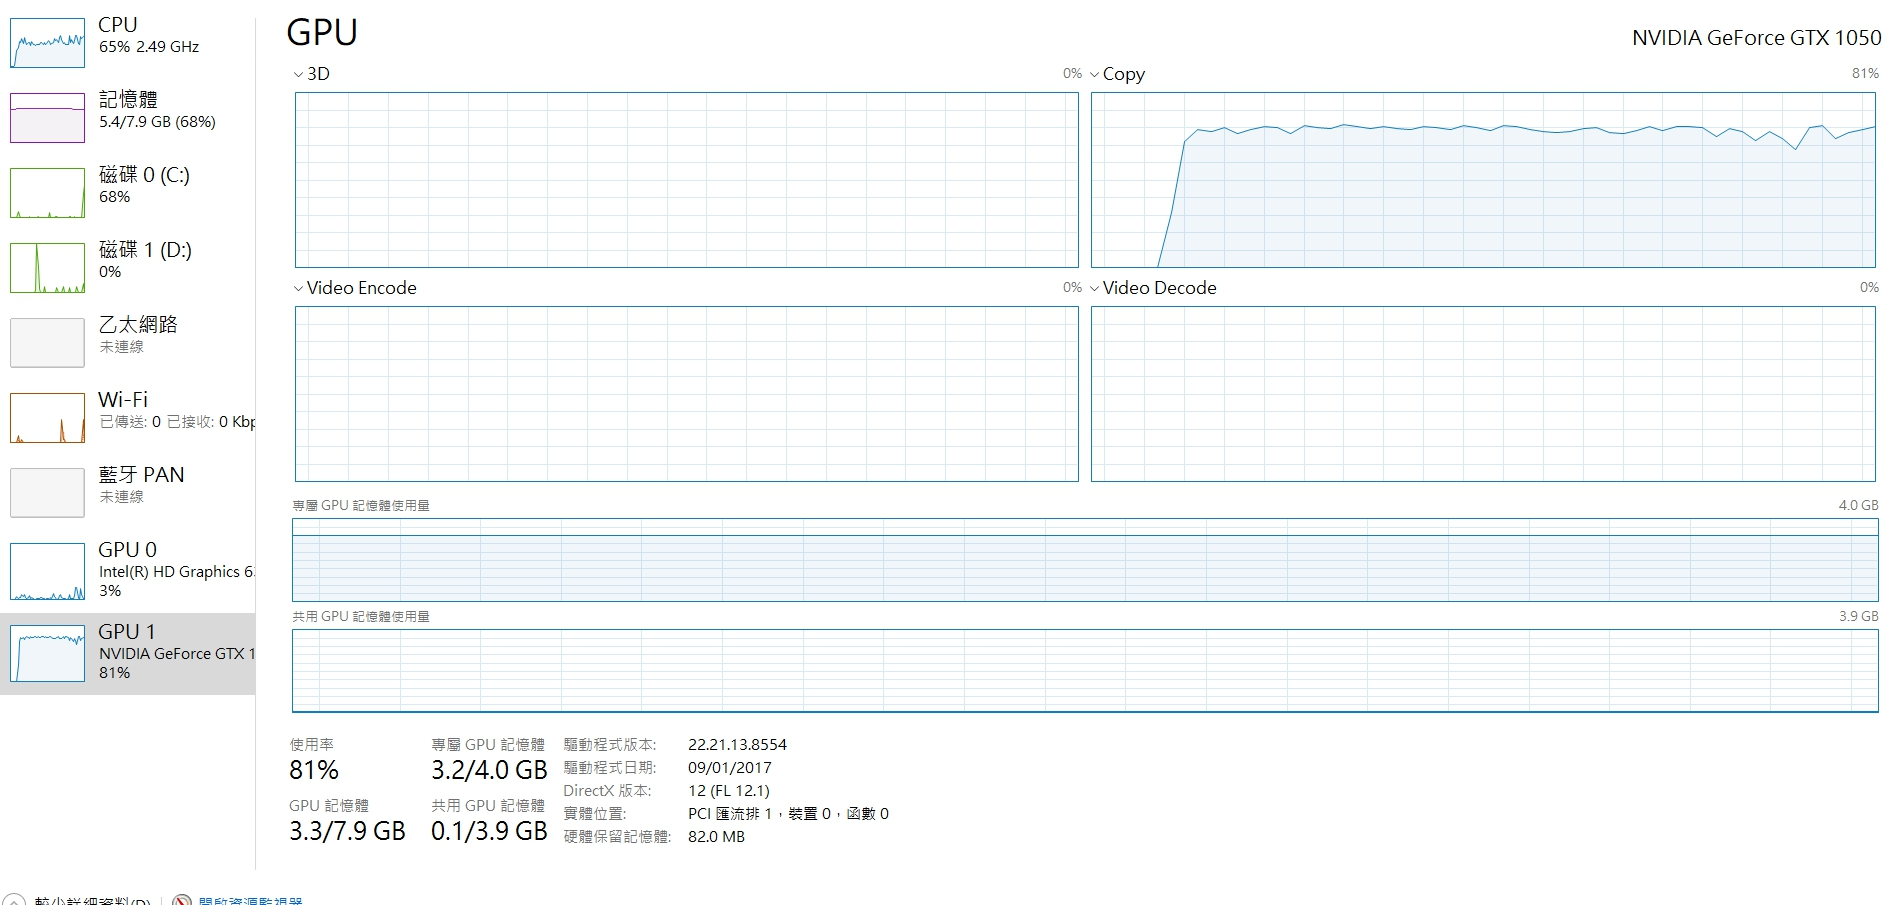

In [2]:
from IPython.display import Image
Image(filename = 'image/admin.jpg', width = 1000)

可以看到我們使用了80%的GPU以及65%CPU，成功的利用GPU進行運算。